![TP](../TeachersPro-logo-color.png)

# Twitter Analytics - Topic Modeling

### Lenin Escobar <lenin.escobar@net.teacherspro.com> - Descriptive analytics (06-February-2022)

In [1]:
%config IPCompleter.greedy=True
%load_ext memory_profiler
%matplotlib inline
%run TwitterAnalysisHelper.ipynb
%run TwitterAnalysisGeneralHelper.ipynb
%run TwitterAnalysis_Plot.ipynb

/opt/conda/envs/nlp3.9.9/lib/python3.9/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets
/opt/conda/envs/nlp3.9.9/lib/python3.9/site-packages/plotly/graph_objs/__init__.py:287: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/opt/conda/envs/nlp3.9.9/lib/python3.9/site-packages/plotly/graph_objs/__init__.py:287: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/opt/conda/envs/nlp3.9.9/lib/python3.9/site-packages/plotly/graph_objs/__init__.py:287: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/opt/conda/envs/nlp3.9.9/lib/python3

In [2]:
#import pyLDAvis
#print(pyLDAvis.__version__)

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#import os
#print (os.environ['CONDA_DEFAULT_ENV'])

In [5]:
#import pyparsing
#pyparsing.__version__

In [6]:
#import spacy
#print(spacy.__version__)

In [7]:
#import sys
#print(sys.version)

<h1 style="background-color:#D7F5FF;font-size:300%;">What is topic modeling?</h1>
<p>In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents.</p>
<p>The topics found, being abstract, should be named according to the context of the analysis.</p>
<p>All the text documents combined is known as the corpus.</p>
<p>Let's assume we have 10 articles, each of them written in 200 words and we decided to identify 5 topics then each article belongs to each topic by percentage of similarity.</p>

<h1 style="background-color:#D7F5FF;font-size:300%;">Twitter DB</h1>

In [8]:
#Connecting to sqlite3 database
dbConn = Sqlite3Db('data/social_network.db')

In [9]:
#pip install pyldavis

In [10]:
dbConn.query('''SELECT insert_timestamp, tweet_timestamp, tweet_term, tweet, place_type, place_name, place_full_name, place_country_code, place_country FROM Tweets; ''')

sqlStmRes = dbConn.cursor.fetchall()
#print(type(sqlStmRes))
#print(sqlStmRes)
df_Tweets_original = pd.DataFrame(sqlStmRes, columns =['insert_timestamp','tweet_timestamp','tweet_term', 'tweet', 'place_type', 'place_name', 'place_full_name', 'place_country_code', 'place_country'])

In [11]:
#Closing sqlite3 datbase connection
dbConn.close()

In [12]:
df_Tweets_original.head(3)

insert_timestamp     tweet_timestamp  tweet_term  \
0 2021-08-11 14:19:45.946146 2021-08-04 23:59:14  b'#edchat'   
1 2021-08-11 14:19:45.946839 2021-08-04 23:58:48  b'#edchat'   
2 2021-08-11 14:19:45.947049 2021-08-04 23:57:15  b'#edchat'   

                                               tweet place_type place_name  \
0  b'RT @Catlin_Tucker: Worried about keeping you...  Undefined  Undefined   
1  b'RT @mcleod: \xe2\x80\x9cThe focus for public...  Undefined  Undefined   
2  b'RT @TCEA: 10 Evidence-Based #Teaching Strate...  Undefined  Undefined   

  place_full_name place_country_code place_country  
0       Undefined          Undefined     Undefined  
1       Undefined          Undefined     Undefined  
2       Undefined          Undefined     Undefined

In [13]:
df_Tweets_original.shape

(3410, 9)

In [14]:
df_Tweets_original.dtypes

insert_timestamp      datetime64[ns]
tweet_timestamp       datetime64[ns]
tweet_term                    object
tweet                         object
place_type                    object
place_name                    object
place_full_name               object
place_country_code            object
place_country                 object
dtype: object

In [15]:
cleaningHelper = CleaningHelper(version = "1.0")
print(cleaningHelper)

Cleaning helper version 1.0


In [16]:
#There should be no null
cleaningHelper.get_nulls_data(df_Tweets_original)

Total  PercNotNull
insert_timestamp        0        100.0
tweet_timestamp         0        100.0
tweet_term              0        100.0
tweet                   0        100.0
place_type              0        100.0
place_name              0        100.0
place_full_name         0        100.0
place_country_code      0        100.0
place_country           0        100.0

In [17]:
#We are going to check the tweet terms, tweet dates and places at first

In [18]:
df_Tweets_mod = df_Tweets_original.copy()

In [19]:
#df_Tweets_mod['tweet_timestamp_date'] = df_Tweets_mod['tweet_timestamp'].dt.normalize()
df_Tweets_mod['tweet_timestamp_date'] = df_Tweets_mod['tweet_timestamp'].dt.date

In [20]:
df_Tweets_mod['tweet_str'] = df_Tweets_mod['tweet'].str.decode("utf-8")
df_Tweets_mod['tweet_term_str'] = df_Tweets_mod['tweet_term'].str.decode("utf-8")
#df_Tweets_mod[df_Tweets_mod.apply(type) == object] = df_Tweets_mod.str.decode("utf-8")

In [21]:
df_Tweets_mod.dtypes

insert_timestamp        datetime64[ns]
tweet_timestamp         datetime64[ns]
tweet_term                      object
tweet                           object
place_type                      object
place_name                      object
place_full_name                 object
place_country_code              object
place_country                   object
tweet_timestamp_date            object
tweet_str                       object
tweet_term_str                  object
dtype: object

In [22]:
df_Tweets_mod.head(3)

insert_timestamp     tweet_timestamp  tweet_term  \
0 2021-08-11 14:19:45.946146 2021-08-04 23:59:14  b'#edchat'   
1 2021-08-11 14:19:45.946839 2021-08-04 23:58:48  b'#edchat'   
2 2021-08-11 14:19:45.947049 2021-08-04 23:57:15  b'#edchat'   

                                               tweet place_type place_name  \
0  b'RT @Catlin_Tucker: Worried about keeping you...  Undefined  Undefined   
1  b'RT @mcleod: \xe2\x80\x9cThe focus for public...  Undefined  Undefined   
2  b'RT @TCEA: 10 Evidence-Based #Teaching Strate...  Undefined  Undefined   

  place_full_name place_country_code place_country tweet_timestamp_date  \
0       Undefined          Undefined     Undefined           2021-08-04   
1       Undefined          Undefined     Undefined           2021-08-04   
2       Undefined          Undefined     Undefined           2021-08-04   

                                           tweet_str tweet_term_str  
0  RT @Catlin_Tucker: Worried about keeping your ...        #edchat  
1  RT @mcleod: “The focus for public education sh...        #edchat  
2  RT @TCEA: 10 Evidence-Based #Teaching Strategi...        #edchat

<h3 style="background-color:powderblue;">Raw Data Plotting</h3>

In [23]:
plottingHelper = PlottingHelper(version = "1.0")
#print(plottingHelper)

In [24]:
plottingHelper._df_cat = df_Tweets_mod
ipywidgets.interact(plottingHelper.func_count_cat_plotty, \
                x_var_size=ipywidgets.IntSlider(layout={'border': '1px solid black'}, min=1, max=100, value=10, step=1, description="Num.Records"), \
                x_var = ipywidgets.Dropdown(layout={'border': '1px solid black'}, options=["tweet_term_str","tweet_str","place_type","place_name", \
                                                                                           "place_full_name","place_country_code","place_country","tweet_timestamp_date"], description="Feature"), \
                x_var_asc = ipywidgets.Checkbox(layout={'border': '1px solid black'}, value=False, description="Asc. Order"), \
                ax_title = ipywidgets.Textarea(layout={'border': '1px solid black'}, value="Tweets by Feature", description="Title") \
               );

interactive(children=(IntSlider(value=10, description='Num.Records', layout=Layout(border='1px solid black'), …

<h3 style="background-color:powderblue;">Data cleaning</h3>

In [25]:
#!python -m spacy download en_core_web_lg

In [26]:
#I decided to use the largest one
spacy_lg = spacy.load('en_core_web_lg')

In [27]:
# sets of punctuation in variable result 
punctuation_str = string.punctuation  
punctuation_str #I want to know if @ is actually include

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [28]:
#Stop words Set
#stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words = cleaningHelper.get_custom_stop_words(spacy_ = spacy_lg)

In [29]:
#English parser object
parser = spacy.lang.en.English()

In [30]:
cleaningTweets = CleaningTweets(version = "1.0", spacy_ = spacy_lg, parser_ = parser, punctuation_str_ = punctuation_str, stop_words_ = stop_words)
print(cleaningTweets)

Cleaning Tweets version 1.0


In [31]:
df_doc_tokens = cleaningTweets.get_words_df(df_Tweets_ = df_Tweets_mod)

Removing_Twitter-Username: [RT, :, Worried, about, keeping, your, ", fast, finishers, ", or, kids, who, pace, more, quickly, through, stations, occupied, without, giving, them, …]
Removing_Token-URL: [RT, :, Worried, about, keeping, your, ", fast, finishers, ", or, kids, who, pace, more, quickly, through, stations, occupied, without, giving, them, …]
Removing_emoji: [RT, :, Worried, about, keeping, your, ", fast, finishers, ", or, kids, who, pace, more, quickly, through, stations, occupied, without, giving, them, …]
Lemmatizing: ['rt', ':', 'worried', 'about', 'keep', 'your', '"', 'fast', 'finisher', '"', 'or', 'kid', 'who', 'pace', 'more', 'quickly', 'through', 'station', 'occupy', 'without', 'give', 'they', '…']
Stop-words: ['worried', 'fast', 'finisher', 'kid', 'pace', 'quickly', 'station', 'occupy']
Removing_Twitter-Username: [RT, :, “, The, focus, for, public, education, shifted, from, flexibility, and, forgiveness, to, restoring, the, metronome, of, schooling, ., This, included, 

Removing_Twitter-Username: [RT, :, 10, Evidence, -, Based, #, Teaching, Strategies, 

, https://t.co/IAW9bvDo9V,  , #, learning, #, edchat, #, edutwitter, #, k12, https://t.co/, …]
Removing_Token-URL: [RT, :, 10, Evidence, -, Based, #, Teaching, Strategies, 

,  , #, learning, #, edchat, #, edutwitter, #, k12, …]
Removing_emoji: [RT, :, 10, Evidence, -, Based, #, Teaching, Strategies, #, learning, #, edchat, #, edutwitter, #, k12, …]
Lemmatizing: ['rt', ':', '10', 'evidence', '-', 'base', '#', 'teaching', 'strategy', '#', 'learn', '#', 'edchat', '#', 'edutwitter', '#', 'k12', '…']
Stop-words: ['10', 'evidence', 'base', 'teaching', 'strategy', 'learn', 'edchat', 'edutwitter', 'k12']
Removing_Twitter-Username: [RT, :, #, EmpowertheLearner, has, teamed, up, with, .@BookCreatorApp, to, provide, teachers, a, way, to, help, kids, understand, and, value, their, identit, …]
Removing_Token-URL: [RT, :, #, EmpowertheLearner, has, teamed, up, with, .@BookCreatorApp, to, provide, teachers, a, way,

Removing_Twitter-Username: [#, VirtualReality, in, #, Education, :, How, #, VR, is, Used, in, Immersive, #, Learning, |, https://t.co/dTm4Vokw6, T]
Removing_Token-URL: [#, VirtualReality, in, #, Education, :, How, #, VR, is, Used, in, Immersive, #, Learning, |, T]
Removing_emoji: [#, VirtualReality, in, #, Education, :, How, #, VR, is, Used, in, Immersive, #, Learning, |, T]
Lemmatizing: ['#', 'virtualreality', 'in', '#', 'education', ':', 'how', '#', 'vr', 'be', 'use', 'in', 'immersive', '#', 'learning', '|', 't']
Stop-words: ['virtualreality', 'education', 'vr', 'immersive', 'learning']
Removing_Twitter-Username: [RT, :, 10, Evidence, -, Based, #, Teaching, Strategies, 

, https://t.co/IAW9bvDo9V,  , #, learning, #, edchat, #, edutwitter, #, k12, https://t.co/, …]
Removing_Token-URL: [RT, :, 10, Evidence, -, Based, #, Teaching, Strategies, 

,  , #, learning, #, edchat, #, edutwitter, #, k12, …]
Removing_emoji: [RT, :, 10, Evidence, -, Based, #, Teaching, Strategies, #, learning, #, 

Removing_Twitter-Username: [RT, :, The, know, how, to, kickoff, a, school, year, !, Thank, you, for, the, TGIF, grants, !, Congratulations, ,, Aces, !, #, W, …]
Removing_Token-URL: [RT, :, The, know, how, to, kickoff, a, school, year, !, Thank, you, for, the, TGIF, grants, !, Congratulations, ,, Aces, !, #, W, …]
Removing_emoji: [RT, :, The, know, how, to, kickoff, a, school, year, !, Thank, you, for, the, TGIF, grants, !, Congratulations, ,, Aces, !, #, W, …]
Lemmatizing: ['rt', ':', 'the', 'know', 'how', 'to', 'kickoff', 'a', 'school', 'year', '!', 'thank', 'you', 'for', 'the', 'tgif', 'grant', '!', 'congratulation', ',', 'aces', '!', '#', 'w', '…']
Stop-words: ['kickoff', 'school', 'thank', 'tgif', 'grant', 'congratulation', 'aces']
Removing_Twitter-Username: [RT, :, The, know, how, to, kickoff, a, school, year, !, Thank, you, for, the, TGIF, grants, !, Congratulations, ,, Aces, !, #, W, …]
Removing_Token-URL: [RT, :, The, know, how, to, kickoff, a, school, year, !, Thank, you, for,

Removing_Twitter-Username: [Apps, and, reading, programs, can, help, children, who, struggle, to, read, ., What, is, the, best, reading, app, for, kids, ?, Here, ’s, wha, …, https://t.co/fAch20NpcD]
Removing_Token-URL: [Apps, and, reading, programs, can, help, children, who, struggle, to, read, ., What, is, the, best, reading, app, for, kids, ?, Here, ’s, wha, …]
Removing_emoji: [Apps, and, reading, programs, can, help, children, who, struggle, to, read, ., What, is, the, best, reading, app, for, kids, ?, Here, ’s, wha, …]
Lemmatizing: ['app', 'and', 'read', 'program', 'can', 'help', 'child', 'who', 'struggle', 'to', 'read', '.', 'what', 'be', 'the', 'good', 'reading', 'app', 'for', 'kid', '?', 'here', '’', 'wha', '…']
Stop-words: ['app', 'read', 'program', 'help', 'child', 'struggle', 'read', 'reading', 'app', 'kid', '’', 'wha']
Removing_Twitter-Username: [Thank, you, to, Dr., Rodney, Murray, for, sitting, down, with, K16, CEO, Dr., Thomas, Waite, &, amp, ;, CRO, Steve, Mildner, to, c

Removing_Twitter-Username: [RT, :, If, you, are, a, NJ, resident, who, values, #, schoollibraries, &, amp, ;, #, literacy, ,, please, consider, signing, #, anecessitynotaluxury, …]
Removing_Token-URL: [RT, :, If, you, are, a, NJ, resident, who, values, #, schoollibraries, &, amp, ;, #, literacy, ,, please, consider, signing, #, anecessitynotaluxury, …]
Removing_emoji: [RT, :, If, you, are, a, NJ, resident, who, values, #, schoollibraries, &, amp, ;, #, literacy, ,, please, consider, signing, #, anecessitynotaluxury, …]
Lemmatizing: ['rt', ':', 'if', 'you', 'be', 'a', 'nj', 'resident', 'who', 'value', '#', 'schoollibrarie', '&', 'amp', ';', '#', 'literacy', ',', 'please', 'consider', 'sign', '#', 'anecessitynotaluxury', '…']
Stop-words: ['nj', 'resident', 'value', 'schoollibrarie', 'literacy', 'consider', 'sign', 'anecessitynotaluxury']
Removing_Twitter-Username: [RT, :, The, ‘, Revised, Working, in, Childhood, and, Adolescent, Literacy, Practice, Guidelines, ’, are, available, for, mem

Removing_Twitter-Username: [New, report, :, State, of, the, science, on, western, wildfires, ,, forests, and, climate, change, -, the, evidence, supporting, intenti, …, https://t.co/fhcjwpF8tl]
Removing_Token-URL: [New, report, :, State, of, the, science, on, western, wildfires, ,, forests, and, climate, change, -, the, evidence, supporting, intenti, …]
Removing_emoji: [New, report, :, State, of, the, science, on, western, wildfires, ,, forests, and, climate, change, -, the, evidence, supporting, intenti, …]
Lemmatizing: ['new', 'report', ':', 'state', 'of', 'the', 'science', 'on', 'western', 'wildfire', ',', 'forest', 'and', 'climate', 'change', '-', 'the', 'evidence', 'support', 'intenti', '…']
Stop-words: ['report', 'science', 'western', 'wildfire', 'forest', 'climate', 'change', 'evidence', 'support', 'intenti']
Removing_Twitter-Username: [NASA, TV, Coverage, Set, for, Next, International, Space, Station, Cargo, Launch, via, https://t.co/Tupg32DMS6, #, scichat, …, https://t.co/98Ku

Removing_Twitter-Username: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, August, 4, ,, 2021, #, REDFORED, #, tbats, #, edchat, …, https://t.co/3MrIH3RCi5]
Removing_Token-URL: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, August, 4, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Removing_emoji: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, August, 4, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'wednesday', ',', 'august', '4', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'wednesday', 'august', '4', '2021', 'redfored', 'tbat', 'edchat']
Removing_Twitter-Username: [RT, :, 5, ways, to, shift, teaching, practice, so, students, feel, less, math, anxious,

Removing_Twitter-Username: […, https://t.co/TXwoVRxlmB]
Removing_Token-URL: […]
Removing_emoji: […]
Lemmatizing: ['…']
Stop-words: []
Removing_Twitter-Username: [RT, :, What, an, honor, to, be, quoted, by, 👏, 🏼, 
, Making, mistakes, leads, to, growth, ., 💯, 

, …]
Removing_Token-URL: [RT, :, What, an, honor, to, be, quoted, by, 👏, 🏼, 
, Making, mistakes, leads, to, growth, ., 💯, 

, …]
Removing_emoji: [RT, :, What, an, honor, to, be, quoted, by, Making, mistakes, leads, to, growth, ., …]
Lemmatizing: ['rt', ':', 'what', 'an', 'honor', 'to', 'be', 'quote', 'by', 'make', 'mistake', 'lead', 'to', 'growth', '.', '…']
Stop-words: ['honor', 'quote', 'mistake', 'lead', 'growth']
Removing_Twitter-Username: [RT, :, Shoutout, to, in, -, class, shoutouts, !, 

, (, Inspiration, via, educator, ), 

, #, TeacherTwitter, #, edchat, #, EduGladiators, …]
Removing_Token-URL: [RT, :, Shoutout, to, in, -, class, shoutouts, !, 

, (, Inspiration, via, educator, ), 

, #, TeacherTwitter, #, edchat, #, EduG

Removing_Twitter-Username: [RT, :, This, just, in, …, issued, a, fact, sheet, and, flowchart, regarding, #, K12, quarantine, following, #, COVID, exposure, ., Fac, …]
Removing_Token-URL: [RT, :, This, just, in, …, issued, a, fact, sheet, and, flowchart, regarding, #, K12, quarantine, following, #, COVID, exposure, ., Fac, …]
Removing_emoji: [RT, :, This, just, in, …, issued, a, fact, sheet, and, flowchart, regarding, #, K12, quarantine, following, #, COVID, exposure, ., Fac, …]
Lemmatizing: ['rt', ':', 'this', 'just', 'in', '…', 'issue', 'a', 'fact', 'sheet', 'and', 'flowchart', 'regard', '#', 'k12', 'quarantine', 'follow', '#', 'covid', 'exposure', '.', 'fac', '…']
Stop-words: ['issue', 'sheet', 'flowchart', 'regard', 'k12', 'quarantine', 'follow', 'covid', 'exposure', 'fac']
Removing_Twitter-Username: [This, just, in, …, issued, a, fact, sheet, and, flowchart, regarding, #, K12, quarantine, following, #, COVID, exposure, ., …, https://t.co/SpbHaO1baH]
Removing_Token-URL: [This, just,

Removing_Twitter-Username: [RT, :, #, FEATURED, #, COURSES, 

, Machine, Learning, ,, Data, Science, and, Deep, Learning, with, Python, 

, Complete, hands, -, on, #, machine, #, learning, tutoria, …]
Removing_Token-URL: [RT, :, #, FEATURED, #, COURSES, 

, Machine, Learning, ,, Data, Science, and, Deep, Learning, with, Python, 

, Complete, hands, -, on, #, machine, #, learning, tutoria, …]
Removing_emoji: [RT, :, #, FEATURED, #, COURSES, Machine, Learning, ,, Data, Science, and, Deep, Learning, with, Python, Complete, hands, -, on, #, machine, #, learning, tutoria, …]
Lemmatizing: ['rt', ':', '#', 'feature', '#', 'course', 'machine', 'learning', ',', 'data', 'science', 'and', 'deep', 'learning', 'with', 'python', 'complete', 'hand', '-', 'on', '#', 'machine', '#', 'learn', 'tutoria', '…']
Stop-words: ['feature', 'course', 'machine', 'learning', 'data', 'science', 'deep', 'learning', 'python', 'complete', 'hand', 'machine', 'learn', 'tutoria']
Removing_Twitter-Username: [RT, :, #, FEA

Removing_Twitter-Username: [RT, :, Bloom, 's, Taxonomy,  , Question, and, Task, Design, Wheel, 

, https://t.co/lvRefYyt7F, #, edtech, #, learning, #, teaching, #, edutwitter, #, …]
Removing_Token-URL: [RT, :, Bloom, 's, Taxonomy,  , Question, and, Task, Design, Wheel, 

, #, edtech, #, learning, #, teaching, #, edutwitter, #, …]
Removing_emoji: [RT, :, Bloom, 's, Taxonomy, Question, and, Task, Design, Wheel, #, edtech, #, learning, #, teaching, #, edutwitter, #, …]
Lemmatizing: ['rt', ':', 'bloom', "'s", 'taxonomy', 'question', 'and', 'task', 'design', 'wheel', '#', 'edtech', '#', 'learn', '#', 'teach', '#', 'edutwitter', '#', '…']
Stop-words: ['bloom', 'taxonomy', 'question', 'task', 'design', 'wheel', 'edtech', 'learn', 'teach', 'edutwitter']
Removing_Twitter-Username: [Join,  , Friday, at, 11, AM, ET, 

, https://t.co/y74GgFnAov, 

, #, edtech, #, ditchbook, #, tlap, #, ETCoaches, #, hacklearning, …, https://t.co/mhRliwqSEL]
Removing_Token-URL: [Join,  , Friday, at, 11, AM, ET, 

,

Removing_Twitter-Username: [RT, :, More, teachers, are, being, asked, to, support, student, literacy, in, all, content, areas, ., 
, #, elachat, #, edchat, #, crosscurricular, #, les, …]
Removing_Token-URL: [RT, :, More, teachers, are, being, asked, to, support, student, literacy, in, all, content, areas, ., 
, #, elachat, #, edchat, #, crosscurricular, #, les, …]
Removing_emoji: [RT, :, More, teachers, are, being, asked, to, support, student, literacy, in, all, content, areas, ., #, elachat, #, edchat, #, crosscurricular, #, les, …]
Lemmatizing: ['rt', ':', 'more', 'teacher', 'be', 'be', 'ask', 'to', 'support', 'student', 'literacy', 'in', 'all', 'content', 'area', '.', '#', 'elachat', '#', 'edchat', '#', 'crosscurricular', '#', 'le', '…']
Stop-words: ['teacher', 'support', 'student', 'literacy', 'content', 'elachat', 'edchat', 'crosscurricular', 'le']
Removing_Twitter-Username: [Very, excited, to, get, lost, in, this, 👇, 
, #, dyslexia, #, edchat, #, engchat, #, reading, #, literacy,

Removing_Twitter-Username: [Join, us, Marketplace, at, the, Launch, Pad, ., Let, ’s, talk, #, CareerDevelopment, integration, and, #, Literacy, ,, it, ’s, …, https://t.co/9OLbJScZxL]
Removing_Token-URL: [Join, us, Marketplace, at, the, Launch, Pad, ., Let, ’s, talk, #, CareerDevelopment, integration, and, #, Literacy, ,, it, ’s, …]
Removing_emoji: [Join, us, Marketplace, at, the, Launch, Pad, ., Let, ’s, talk, #, CareerDevelopment, integration, and, #, Literacy, ,, it, ’s, …]
Lemmatizing: ['join', 'we', 'marketplace', 'at', 'the', 'launch', 'pad', '.', 'let', '’s', 'talk', '#', 'careerdevelopment', 'integration', 'and', '#', 'literacy', ',', 'it', '’', '…']
Stop-words: ['join', 'marketplace', 'launch', 'pad', 'talk', 'careerdevelopment', 'integration', 'literacy', '’']
Removing_Twitter-Username: [RT, :, ⭐, ️, ⭐, ️, ⭐, ️, ⭐, ️, ⭐, ️#Literacy, ✍, ️, 

 , 🚀, #, TimeTravel, to, 1592, 💥, #Plague, shuts, #, theatres, 👹, 

 , #, Hamnet, 🤩, #Shakespeare, &, amp, ;, #, Family, 

, #, Tower, of,

Removing_Twitter-Username: [RT, :, Biochar, can, boost, crop, yields, in, poor, soils, and, help, stop, the, effects, of, climate, change, ,, study, finds, ., So, why, are, n’t, we, using, it, …]
Removing_Token-URL: [RT, :, Biochar, can, boost, crop, yields, in, poor, soils, and, help, stop, the, effects, of, climate, change, ,, study, finds, ., So, why, are, n’t, we, using, it, …]
Removing_emoji: [RT, :, Biochar, can, boost, crop, yields, in, poor, soils, and, help, stop, the, effects, of, climate, change, ,, study, finds, ., So, why, are, n’t, we, using, it, …]
Lemmatizing: ['rt', ':', 'biochar', 'can', 'boost', 'crop', 'yield', 'in', 'poor', 'soil', 'and', 'help', 'stop', 'the', 'effect', 'of', 'climate', 'change', ',', 'study', 'find', '.', 'so', 'why', 'be', 'not', 'we', 'use', 'it', '…']
Stop-words: ['biochar', 'boost', 'crop', 'yield', 'poor', 'soil', 'help', 'stop', 'effect', 'climate', 'change', 'study']
Removing_Twitter-Username: [Biochar, can, boost, crop, yields, in, poor, 

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'july', '31', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', 'li', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'july', '31', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat', 'li']
Rem

Removing_Twitter-Username: [RT, :, “, Your, IQ, has, nothing, to, do, with, your, EQ, ., ”, 
, #, edchat, #, edtech, #, education, #, lrnchat, #, edapp, #, classroom, #, teaching, #, edreform, #, cpc, …]
Removing_Token-URL: [RT, :, “, Your, IQ, has, nothing, to, do, with, your, EQ, ., ”, 
, #, edchat, #, edtech, #, education, #, lrnchat, #, edapp, #, classroom, #, teaching, #, edreform, #, cpc, …]
Removing_emoji: [RT, :, “, Your, IQ, has, nothing, to, do, with, your, EQ, ., ”, #, edchat, #, edtech, #, education, #, lrnchat, #, edapp, #, classroom, #, teaching, #, edreform, #, cpc, …]
Lemmatizing: ['rt', ':', '"', 'your', 'iq', 'have', 'nothing', 'to', 'do', 'with', 'your', 'eq', '.', '"', '#', 'edchat', '#', 'edtech', '#', 'education', '#', 'lrnchat', '#', 'edapp', '#', 'classroom', '#', 'teach', '#', 'edreform', '#', 'cpc', '…']
Stop-words: ['iq', 'eq', 'edchat', 'edtech', 'education', 'lrnchat', 'edapp', 'classroom', 'teach', 'edreform', 'cpc']
Removing_Twitter-Username: […, https://

Removing_Twitter-Username: [", The, issue, is, not, the, virus, anymore, ., It, ’s, staffing, ., ", #, EdChat, 

, Read, the, full, article, here, :, https://t.co/xoegKTgKQy]
Removing_Token-URL: [", The, issue, is, not, the, virus, anymore, ., It, ’s, staffing, ., ", #, EdChat, 

, Read, the, full, article, here, :]
Removing_emoji: [", The, issue, is, not, the, virus, anymore, ., It, ’s, staffing, ., ", #, EdChat, Read, the, full, article, here, :]
Lemmatizing: ['"', 'the', 'issue', 'be', 'not', 'the', 'virus', 'anymore', '.', 'it', '’', 'staff', '.', '"', '#', 'edchat', 'read', 'the', 'full', 'article', 'here', ':']
Stop-words: ['issue', 'virus', 'anymore', '’', 'staff', 'edchat', 'read', 'article']
Removing_Twitter-Username: [RT, :, IDEA, :, 4, Tools, to, Help, Teachers, Remove, Backgrounds, from, Images, ., https://t.co/fspPLdQsJs, #, edtech, #, edchat, #, elemchat, #, 3rdchat, …]
Removing_Token-URL: [RT, :, IDEA, :, 4, Tools, to, Help, Teachers, Remove, Backgrounds, from, Images, .

Removing_Twitter-Username: [RT, :, What, is, Artificial, Intelligence, #, DeepLearning, #, learning, #, machinelearning,  , https://t.co/ssVmYgpBeC]
Removing_Token-URL: [RT, :, What, is, Artificial, Intelligence, #, DeepLearning, #, learning, #, machinelearning,  ]
Removing_emoji: [RT, :, What, is, Artificial, Intelligence, #, DeepLearning, #, learning, #, machinelearning]
Lemmatizing: ['rt', ':', 'what', 'be', 'artificial', 'intelligence', '#', 'deeplearning', '#', 'learn', '#', 'machinelearne']
Stop-words: ['artificial', 'intelligence', 'deeplearning', 'learn', 'machinelearne']
Removing_Twitter-Username: [RT, :, What, is, Artificial, Intelligence, #, DeepLearning, #, learning, #, machinelearning,  , https://t.co/ssVmYgpBeC]
Removing_Token-URL: [RT, :, What, is, Artificial, Intelligence, #, DeepLearning, #, learning, #, machinelearning,  ]
Removing_emoji: [RT, :, What, is, Artificial, Intelligence, #, DeepLearning, #, learning, #, machinelearning]
Lemmatizing: ['rt', ':', 'what', 'be'

Removing_Twitter-Username: [At, the, core, of, empowerment, lies, LOVE, ., Let, 's, show, LOVE, to, our, students, as, we, help, them, grow, ., 

, #, TeachUp, #, SEL, …, https://t.co/GxM8VYGRT8]
Removing_Token-URL: [At, the, core, of, empowerment, lies, LOVE, ., Let, 's, show, LOVE, to, our, students, as, we, help, them, grow, ., 

, #, TeachUp, #, SEL, …]
Removing_emoji: [At, the, core, of, empowerment, lies, LOVE, ., Let, 's, show, LOVE, to, our, students, as, we, help, them, grow, ., #, TeachUp, #, SEL, …]
Lemmatizing: ['at', 'the', 'core', 'of', 'empowerment', 'lie', 'love', '.', 'let', 'us', 'show', 'love', 'to', 'our', 'student', 'as', 'we', 'help', 'they', 'grow', '.', '#', 'teachup', '#', 'sel', '…']
Stop-words: ['core', 'empowerment', 'lie', 'love', 'love', 'student', 'help', 'grow', 'teachup', 'sel']
Removing_Twitter-Username: [RT, :, Do, n’t, miss, your, chance, to, hear, some, amazing, keynote, speakers, such, as, 
, 
, 
, 
, 
, Re, …]
Removing_Token-URL: [RT, :, Do, n’t, 

Removing_Twitter-Username: [RT, :, How, to, master, the, modern, meetings, in, Teams, !, 
, #, AV, #, AudioVisual, #, AVTechnology, #, Hybridworkplace, #, Technology, #, proAV, …]
Removing_Token-URL: [RT, :, How, to, master, the, modern, meetings, in, Teams, !, 
, #, AV, #, AudioVisual, #, AVTechnology, #, Hybridworkplace, #, Technology, #, proAV, …]
Removing_emoji: [RT, :, How, to, master, the, modern, meetings, in, Teams, !, #, AV, #, AudioVisual, #, AVTechnology, #, Hybridworkplace, #, Technology, #, proAV, …]
Lemmatizing: ['rt', ':', 'how', 'to', 'master', 'the', 'modern', 'meeting', 'in', 'teams', '!', '#', 'av', '#', 'audiovisual', '#', 'avtechnology', '#', 'hybridworkplace', '#', 'technology', '#', 'proav', '…']
Stop-words: ['master', 'modern', 'meeting', 'teams', 'av', 'audiovisual', 'avtechnology', 'hybridworkplace', 'technology', 'proav']
Removing_Twitter-Username: [RT, :, How, to, master, the, modern, meetings, in, Teams, !, 
, #, AV, #, AudioVisual, #, AVTechnology, #, Hybr

Removing_Twitter-Username: [RT, :, Calling, all, #, STEM, #, STEAM, #, teachers, and, #, librarians, #, homeschool, Join, us, for, a, Back, to, School, #, STEM, #, literacy, chat, hosted, …]
Removing_Token-URL: [RT, :, Calling, all, #, STEM, #, STEAM, #, teachers, and, #, librarians, #, homeschool, Join, us, for, a, Back, to, School, #, STEM, #, literacy, chat, hosted, …]
Removing_emoji: [RT, :, Calling, all, #, STEM, #, STEAM, #, teachers, and, #, librarians, #, homeschool, Join, us, for, a, Back, to, School, #, STEM, #, literacy, chat, hosted, …]
Lemmatizing: ['rt', ':', 'call', 'all', '#', 'stem', '#', 'steam', '#', 'teacher', 'and', '#', 'librarian', '#', 'homeschool', 'join', 'we', 'for', 'a', 'back', 'to', 'school', '#', 'stem', '#', 'literacy', 'chat', 'host', '…']
Stop-words: ['stem', 'steam', 'teacher', 'librarian', 'homeschool', 'join', 'school', 'stem', 'literacy', 'chat', 'host']
Removing_Twitter-Username: [I, LOVE, reading, ,, and, that, ’s, what, I, told, the, camera, bef

Removing_Twitter-Username: [RT, :, Elementary, Teacher, ?, Want, to, test, -, drive, the, NEW, Activate, Learning, PRIME, Interactive, Digital, Edition, for, 10, days, and, dow, …]
Removing_Token-URL: [RT, :, Elementary, Teacher, ?, Want, to, test, -, drive, the, NEW, Activate, Learning, PRIME, Interactive, Digital, Edition, for, 10, days, and, dow, …]
Removing_emoji: [RT, :, Elementary, Teacher, ?, Want, to, test, -, drive, the, NEW, Activate, Learning, PRIME, Interactive, Digital, Edition, for, 10, days, and, dow, …]
Lemmatizing: ['rt', ':', 'elementary', 'teacher', '?', 'want', 'to', 'test', '-', 'drive', 'the', 'new', 'activate', 'learn', 'prime', 'interactive', 'digital', 'edition', 'for', '10', 'day', 'and', 'dow', '…']
Stop-words: ['elementary', 'teacher', 'test', 'drive', 'activate', 'learn', 'prime', 'interactive', 'digital', 'edition', '10', 'day', 'dow']
Removing_Twitter-Username: [RT, :, NASA, ’s, Perseverance, Team, Assessing, First, Mars, Sampling, Attempt, via, https://t

Removing_Twitter-Username: [RT, :, A, great, page, to, bookmark, !, It, 's, jam, -, packed, with, lessons, and, games, for, teaching, kids, about, financial, responsibility, ., #, spon, …]
Removing_Token-URL: [RT, :, A, great, page, to, bookmark, !, It, 's, jam, -, packed, with, lessons, and, games, for, teaching, kids, about, financial, responsibility, ., #, spon, …]
Removing_emoji: [RT, :, A, great, page, to, bookmark, !, It, 's, jam, -, packed, with, lessons, and, games, for, teaching, kids, about, financial, responsibility, ., #, spon, …]
Lemmatizing: ['rt', ':', 'a', 'great', 'page', 'to', 'bookmark', '!', 'it', 'be', 'jam', '-', 'pack', 'with', 'lesson', 'and', 'game', 'for', 'teach', 'kid', 'about', 'financial', 'responsibility', '.', '#', 'spon', '…']
Stop-words: ['page', 'bookmark', 'jam', 'pack', 'lesson', 'game', 'teach', 'kid', 'financial', 'responsibility', 'spon']
Removing_Twitter-Username: [RT, :, A, great, page, to, bookmark, !, It, 's, jam, -, packed, with, lessons, an

Removing_Twitter-Username: [Being, genuinely, you, is, important, ., Build, trust, ., Students, will, question, your, sincereit, …, https://t.co/A9dRD0OD4, G]
Removing_Token-URL: [Being, genuinely, you, is, important, ., Build, trust, ., Students, will, question, your, sincereit, …, G]
Removing_emoji: [Being, genuinely, you, is, important, ., Build, trust, ., Students, will, question, your, sincereit, …, G]
Lemmatizing: ['be', 'genuinely', 'you', 'be', 'important', '.', 'build', 'trust', '.', 'student', 'will', 'question', 'your', 'sincereit', '…', 'g']
Stop-words: ['genuinely', 'build', 'trust', 'student', 'question', 'sincereit']
Removing_Twitter-Username: [Seating, activity, and, then, because, we, will, have, a, shortened, first, day, ,, my, students, will, have, time, t, …, https://t.co/M000LyulHg]
Removing_Token-URL: [Seating, activity, and, then, because, we, will, have, a, shortened, first, day, ,, my, students, will, have, time, t, …]
Removing_emoji: [Seating, activity, and, t

Removing_Twitter-Username: [Using, Movie, Clips, in, the, Classroom, #, edtech, #, edchat, https://t.co/c9syk78we7]
Removing_Token-URL: [Using, Movie, Clips, in, the, Classroom, #, edtech, #, edchat]
Removing_emoji: [Using, Movie, Clips, in, the, Classroom, #, edtech, #, edchat]
Lemmatizing: ['use', 'movie', 'clips', 'in', 'the', 'classroom', '#', 'edtech', '#', 'edchat']
Stop-words: ['movie', 'clips', 'classroom', 'edtech', 'edchat']
Removing_Twitter-Username: [RT, :, In, a, world, where, people, are, quick, to, freak, out, about, test, scores, ,, remember, :, 

, There, is, no, standardized, test, that, can, ass, …]
Removing_Token-URL: [RT, :, In, a, world, where, people, are, quick, to, freak, out, about, test, scores, ,, remember, :, 

, There, is, no, standardized, test, that, can, ass, …]
Removing_emoji: [RT, :, In, a, world, where, people, are, quick, to, freak, out, about, test, scores, ,, remember, :, There, is, no, standardized, test, that, can, ass, …]
Lemmatizing: ['rt', ':

Removing_Twitter-Username: [RT, :, Interested, in, learning, how, to, teach, on, -, grade, level, when, students, are, already, behind, ?, Download, ’s, FREE, 8, page, guide, …]
Removing_Token-URL: [RT, :, Interested, in, learning, how, to, teach, on, -, grade, level, when, students, are, already, behind, ?, Download, ’s, FREE, 8, page, guide, …]
Removing_emoji: [RT, :, Interested, in, learning, how, to, teach, on, -, grade, level, when, students, are, already, behind, ?, Download, ’s, FREE, 8, page, guide, …]
Lemmatizing: ['rt', ':', 'interested', 'in', 'learn', 'how', 'to', 'teach', 'on', '-', 'grade', 'level', 'when', 'student', 'be', 'already', 'behind', '?', 'download', '’s', 'free', '8', 'page', 'guide', '…']
Stop-words: ['learn', 'teach', 'grade', 'level', 'student', 'download', 'free', '8', 'page', 'guide']
Removing_Twitter-Username: [RT, :, Interested, in, learning, how, to, teach, on, -, grade, level, when, students, are, already, behind, ?, Download, ’s, FREE, 8, page, guide

Removing_Twitter-Username: [Just, finished, day, 2, of, 's, 100, Days, of, Python, bootcamp, ., My, next, step, is, to, package, the, 4, hours, of, learning, int, …, https://t.co/mOOO3ky9UF]
Removing_Token-URL: [Just, finished, day, 2, of, 's, 100, Days, of, Python, bootcamp, ., My, next, step, is, to, package, the, 4, hours, of, learning, int, …]
Removing_emoji: [Just, finished, day, 2, of, 's, 100, Days, of, Python, bootcamp, ., My, next, step, is, to, package, the, 4, hours, of, learning, int, …]
Lemmatizing: ['just', 'finish', 'day', '2', 'of', "'s", '100', 'day', 'of', 'python', 'bootcamp', '.', 'my', 'next', 'step', 'be', 'to', 'package', 'the', '4', 'hour', 'of', 'learn', 'int', '…']
Stop-words: ['finish', 'day', '2', '100', 'day', 'python', 'bootcamp', 'step', 'package', '4', 'hour', 'learn', 'int']
Removing_Twitter-Username: [RT, :, At, the, core, of, empowerment, lies, LOVE, ., Let, 's, show, LOVE, to, our, students, as, we, help, them, grow, ., 

, #, TeachUp, #, SEL, #, lea

Removing_Twitter-Username: [RT, :, Interested, in, learning, how, to, teach, on, -, grade, level, when, students, are, already, behind, ?, Download, ’s, FREE, 8, page, guide, …]
Removing_Token-URL: [RT, :, Interested, in, learning, how, to, teach, on, -, grade, level, when, students, are, already, behind, ?, Download, ’s, FREE, 8, page, guide, …]
Removing_emoji: [RT, :, Interested, in, learning, how, to, teach, on, -, grade, level, when, students, are, already, behind, ?, Download, ’s, FREE, 8, page, guide, …]
Lemmatizing: ['rt', ':', 'interested', 'in', 'learn', 'how', 'to', 'teach', 'on', '-', 'grade', 'level', 'when', 'student', 'be', 'already', 'behind', '?', 'download', '’s', 'free', '8', 'page', 'guide', '…']
Stop-words: ['learn', 'teach', 'grade', 'level', 'student', 'download', 'free', '8', 'page', 'guide']
Removing_Twitter-Username: [RT, :, I, am, so, excited, ., She, is, amazing, ., Her, book, is, groundbreaking, and, this, should, make, a, difference, on, what, equity, will,

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august', '7', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', 'l', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august', '7', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat']
Removing

Removing_Twitter-Username: [RT, :, “, The, best, time, to, plant, a, tree, is, 20, years, ago, ., The, second, -, best, time, is, now, ., ”, Chinese, proverb, #, scienceofeeading, allies, ,, le, …]
Removing_Token-URL: [RT, :, “, The, best, time, to, plant, a, tree, is, 20, years, ago, ., The, second, -, best, time, is, now, ., ”, Chinese, proverb, #, scienceofeeading, allies, ,, le, …]
Removing_emoji: [RT, :, “, The, best, time, to, plant, a, tree, is, 20, years, ago, ., The, second, -, best, time, is, now, ., ”, Chinese, proverb, #, scienceofeeading, allies, ,, le, …]
Lemmatizing: ['rt', ':', '"', 'the', 'good', 'time', 'to', 'plant', 'a', 'tree', 'be', '20', 'year', 'ago', '.', 'the', 'second', '-', 'good', 'time', 'be', 'now', '.', '"', 'chinese', 'proverb', '#', 'scienceofeeade', 'ally', ',', 'le', '…']
Stop-words: ['time', 'plant', 'tree', '20', 'ago', 'time', 'chinese', 'proverb', 'scienceofeeade', 'ally', 'le']
Removing_Twitter-Username: [FREE, Finger, Puppets, 
, TALK, BOOKS, w

Removing_Twitter-Username: [RT, :, 📚, COMPREHENSIVE, NOTES, -, FREE, DOWNLOAD, 
, https://t.co/17S4Oq9tBd, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, …]
Removing_Token-URL: [RT, :, 📚, COMPREHENSIVE, NOTES, -, FREE, DOWNLOAD, 
, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, …]
Removing_emoji: [RT, :, COMPREHENSIVE, NOTES, -, FREE, DOWNLOAD, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, …]
Lemmatizing: ['rt', ':', 'comprehensive', 'note', '-', 'free', 'download', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edleadership', '#', 'edtech', '#', 'engchat', '#', '…']
Stop-words: ['comprehensive', 'note', 'free', 'download', 'edchat', 'k12', 'learn', 'edleadership', 'edtech', 'engchat']
Removing_Twitter-Username: [RT, :, 📚, PAST, PAPERS, -, FREE, DOWNLOAD, 
, https://t.co/tTcUynqLVq, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …]
Removing_Token-URL: [

Removing_Twitter-Username: [RT, :, 📚, PAST, PAPERS, -, FREE, DOWNLOAD, 
, https://t.co/tTcUynqLVq, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …]
Removing_Token-URL: [RT, :, 📚, PAST, PAPERS, -, FREE, DOWNLOAD, 
, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …]
Removing_emoji: [RT, :, PAST, PAPERS, -, FREE, DOWNLOAD, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …]
Lemmatizing: ['rt', ':', 'past', 'paper', '-', 'free', 'download', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edleadership', '#', 'edtech', '#', 'engchat', '#', 'literacy', '…']
Stop-words: ['past', 'paper', 'free', 'download', 'edchat', 'k12', 'learn', 'edleadership', 'edtech', 'engchat', 'literacy']
Removing_Twitter-Username: [RT, :, 📚, SYLLABUS, -, FREE, DOWNLOAD, 
, https://t.co/6bvHZ2nVIb, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, #, s, …]
Remov

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august', '7', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', 'l', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august', '7', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat']
Removing

Removing_Twitter-Username: [RT, :, NEW, !, We, ’re, back, after, summer, hiatus, !, On, this, week, ’s, episode, of, #, TeachingKeating, we, talk, Ocean, ’s, 11, !, Here, are, the, person, …]
Removing_Token-URL: [RT, :, NEW, !, We, ’re, back, after, summer, hiatus, !, On, this, week, ’s, episode, of, #, TeachingKeating, we, talk, Ocean, ’s, 11, !, Here, are, the, person, …]
Removing_emoji: [RT, :, NEW, !, We, ’re, back, after, summer, hiatus, !, On, this, week, ’s, episode, of, #, TeachingKeating, we, talk, Ocean, ’s, 11, !, Here, are, the, person, …]
Lemmatizing: ['rt', ':', 'new', '!', 'we', '’re', 'back', 'after', 'summer', 'hiatus', '!', 'on', 'this', 'week', '’s', 'episode', 'of', '#', 'teachingkeate', 'we', 'talk', 'ocean', '’s', '11', '!', 'here', 'be', 'the', 'person', '…']
Stop-words: ['summer', 'hiatus', 'week', 'episode', 'teachingkeate', 'talk', 'ocean', '11', 'person']
Removing_Twitter-Username: [RT, :, Homework, can, be, useful, to, help, students, #, learning, ,, but, is

Removing_Twitter-Username: [RT, :, America, should, n’t, be, sending, #, unvaccinated, #, kids, back, to, #, school, |, Jorge, A, Caballero, 
, #, K12, Expedite, EUA, !, …]
Removing_Token-URL: [RT, :, America, should, n’t, be, sending, #, unvaccinated, #, kids, back, to, #, school, |, Jorge, A, Caballero, 
, #, K12, Expedite, EUA, !, …]
Removing_emoji: [RT, :, America, should, n’t, be, sending, #, unvaccinated, #, kids, back, to, #, school, |, Jorge, A, Caballero, #, K12, Expedite, EUA, !, …]
Lemmatizing: ['rt', ':', 'america', 'should', 'not', 'be', 'send', '#', 'unvaccinated', '#', 'kid', 'back', 'to', '#', 'school', '|', 'jorge', 'a', 'caballero', '#', 'k12', 'expedite', 'eua', '!', '…']
Stop-words: ['america', 'send', 'unvaccinated', 'kid', 'school', 'jorge', 'caballero', 'k12', 'expedite', 'eua']
Removing_Twitter-Username: [Need, some, new, ideas, ?, Order, my, book, Unconventional, Ways, to, ThriveinEDU, https://t.co/WTnxUFd0Pi, Many, ideas, for, #, pbl, …, https://t.co/OY5hvMqV9

Removing_Twitter-Username: [RT, :, We, have, such, awesome, Keynote, Speakers, lined, up, for, you, guys, this, year, !, Who, ’s, ready, for, this, year, ’s, conference, ?, !, 
, 👉, Meet, all, the, K, …]
Removing_Token-URL: [RT, :, We, have, such, awesome, Keynote, Speakers, lined, up, for, you, guys, this, year, !, Who, ’s, ready, for, this, year, ’s, conference, ?, !, 
, 👉, Meet, all, the, K, …]
Removing_emoji: [RT, :, We, have, such, awesome, Keynote, Speakers, lined, up, for, you, guys, this, year, !, Who, ’s, ready, for, this, year, ’s, conference, ?, !, Meet, all, the, K, …]
Lemmatizing: ['rt', ':', 'we', 'have', 'such', 'awesome', 'keynote', 'speakers', 'line', 'up', 'for', 'you', 'guy', 'this', 'year', '!', 'who', '’', 'ready', 'for', 'this', 'year', '’s', 'conference', '?', '!', 'meet', 'all', 'the', 'k', '…']
Stop-words: ['awesome', 'keynote', 'speakers', 'line', 'guy', '’', 'ready', 'conference', 'meet']
Removing_Twitter-Username: [RT, :, Check, out, Episode, 26, of, the, Le

Removing_Twitter-Username: [#, trivet, .., the, bolts, it, came, with, were, too, short, ., A, #, coleman, #, campoven, will, ride, atop, the, trivet, for, u, …, https://t.co/3yQcsVE5QE]
Removing_Token-URL: [#, trivet, .., the, bolts, it, came, with, were, too, short, ., A, #, coleman, #, campoven, will, ride, atop, the, trivet, for, u, …]
Removing_emoji: [#, trivet, .., the, bolts, it, came, with, were, too, short, ., A, #, coleman, #, campoven, will, ride, atop, the, trivet, for, u, …]
Lemmatizing: ['#', 'trivet', '..', 'the', 'bolt', 'it', 'come', 'with', 'be', 'too', 'short', '.', 'a', '#', 'coleman', '#', 'campoven', 'will', 'ride', 'atop', 'the', 'trivet', 'for', 'u', '…']
Stop-words: ['trivet', '..', 'bolt', 'short', 'coleman', 'campoven', 'ride', 'atop', 'trivet']
Removing_Twitter-Username: [RT, :, Need, some, new, ideas, ?, Order, my, book, Unconventional, Ways, to, ThriveinEDU, https://t.co/WTnxUFd0Pi, Many, ideas, for, #, pbl, #, SEL, #, globa, …]
Removing_Token-URL: [RT, :,

Removing_Twitter-Username: [RT, :, In, celebration, of, #, WomensDay, ,, we, were, lucky, enough, to, chat, to, two, #, women, in, #, literacy, ., Keep, an, eye, out, for, the, full, vi, …]
Removing_Token-URL: [RT, :, In, celebration, of, #, WomensDay, ,, we, were, lucky, enough, to, chat, to, two, #, women, in, #, literacy, ., Keep, an, eye, out, for, the, full, vi, …]
Removing_emoji: [RT, :, In, celebration, of, #, WomensDay, ,, we, were, lucky, enough, to, chat, to, two, #, women, in, #, literacy, ., Keep, an, eye, out, for, the, full, vi, …]
Lemmatizing: ['rt', ':', 'in', 'celebration', 'of', '#', 'womensday', ',', 'we', 'be', 'lucky', 'enough', 'to', 'chat', 'to', 'two', '#', 'woman', 'in', '#', 'literacy', '.', 'keep', 'an', 'eye', 'out', 'for', 'the', 'full', 'vi', '…']
Stop-words: ['celebration', 'womensday', 'lucky', 'chat', 'woman', 'literacy', 'eye', 'vi']
Removing_Twitter-Username: [RT, :, When, leveled, texts, are, used, in, classroom, and, school, settings, ,, teachers, a

Removing_Twitter-Username: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, 
, (, August, 8), :,  , Guar, gum, slime, fun, https://t.co/dz, …]
Removing_Token-URL: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, 
, (, August, 8), :,  , Guar, gum, slime, fun, …]
Removing_emoji: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, (, August, 8), :, Guar, gum, slime, fun, …]
Lemmatizing: ['rt', ':', 'icymi', ':', 'the', 'late', 'praxis', "'", 'science', 'smarts', "'", 'column', 'in', 'the', '(', 'august', '8)', ':', 'guar', 'gum', 'slime', 'fun', '…']
Stop-words: ['icymi', 'late', 'praxis', 'science', 'smarts', 'column', 'august', '8)', 'guar', 'gum', 'slime', 'fun']
Removing_Twitter-Username: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, 
, (, August, 8), :,  , Guar, gum, slime, fun, https://t.co/dz, …]
Removing_Token-URL: [RT, :, ICYMI, :, The, latest, Praxis, ', Scienc

Removing_Twitter-Username: [RT, :, ", We, need, to, focus, less, on, achieving, our, learning, objectives, and, more, on, the, quality, of, the, learners, ', cognitive, journey, to, t, …]
Removing_Token-URL: [RT, :, ", We, need, to, focus, less, on, achieving, our, learning, objectives, and, more, on, the, quality, of, the, learners, ', cognitive, journey, to, t, …]
Removing_emoji: [RT, :, ", We, need, to, focus, less, on, achieving, our, learning, objectives, and, more, on, the, quality, of, the, learners, ', cognitive, journey, to, t, …]
Lemmatizing: ['rt', ':', '"', 'we', 'need', 'to', 'focus', 'less', 'on', 'achieve', 'our', 'learn', 'objective', 'and', 'more', 'on', 'the', 'quality', 'of', 'the', 'learner', "'", 'cognitive', 'journey', 'to', 't', '…']
Stop-words: ['focus', 'achieve', 'learn', 'objective', 'quality', 'learner', 'cognitive', 'journey']
Removing_Twitter-Username: [ICYMI, The, Education, Endowment, Foundation, 's, Toolkit, is, a, complete, mess, :, It, is, now, time, 

Removing_Twitter-Username: [RT, :, Difference, Between, #, Teaching, and, #, Learning, 

, ❓, What, else, would, you, add, ?, 

, https://t.co/frw900wsJF,   , #, edchat, #, educoach, #, edleaders, #, te, …]
Removing_Token-URL: [RT, :, Difference, Between, #, Teaching, and, #, Learning, 

, ❓, What, else, would, you, add, ?, 

,   , #, edchat, #, educoach, #, edleaders, #, te, …]
Removing_emoji: [RT, :, Difference, Between, #, Teaching, and, #, Learning, What, else, would, you, add, ?, #, edchat, #, educoach, #, edleaders, #, te, …]
Lemmatizing: ['rt', ':', 'difference', 'between', '#', 'teaching', 'and', '#', 'learning', 'what', 'else', 'would', 'you', 'add', '?', '#', 'edchat', '#', 'educoach', '#', 'edleader', '#', 'te', '…']
Stop-words: ['difference', 'teaching', 'learning', 'add', 'edchat', 'educoach', 'edleader', 'te']
Removing_Twitter-Username: [RT, :, NEW, !, !, !, 10, ways, to, assess, students, ', processes, of, learning, and, depth, of, understanding, by, making, Student, Thi

Removing_Twitter-Username: [This, is, equally, advocating, for, #, highered, and, #, k12, in, Canada, 
, #, bced, #, abed, #, sasked, #, onted, #, cdned, #, edchat, 
, cc, ., …, https://t.co/3H7mMftGNJ]
Removing_Token-URL: [This, is, equally, advocating, for, #, highered, and, #, k12, in, Canada, 
, #, bced, #, abed, #, sasked, #, onted, #, cdned, #, edchat, 
, cc, ., …]
Removing_emoji: [This, is, equally, advocating, for, #, highered, and, #, k12, in, Canada, #, bced, #, abed, #, sasked, #, onted, #, cdned, #, edchat, cc, ., …]
Lemmatizing: ['this', 'be', 'equally', 'advocate', 'for', '#', 'highere', 'and', '#', 'k12', 'in', 'canada', '#', 'bce', '#', 'abe', '#', 'saske', '#', 'onted', '#', 'cdne', '#', 'edchat', 'cc', '.', '…']
Stop-words: ['equally', 'advocate', 'highere', 'k12', 'canada', 'bce', 'abe', 'saske', 'onted', 'cdne', 'edchat', 'cc']
Removing_Twitter-Username: [Can, you, recommend, anyone, for, this, job, in, Harker, Heights, ,, TX, ?, https://t.co/bkElitj8cz, #, K12, #, 

Removing_Twitter-Username: [RT, :, NEW, !, !, !, 10, ways, to, assess, students, ', processes, of, learning, and, depth, of, understanding, by, making, Student, Thinking, Visible, ., 

, #, tea, …]
Removing_Token-URL: [RT, :, NEW, !, !, !, 10, ways, to, assess, students, ', processes, of, learning, and, depth, of, understanding, by, making, Student, Thinking, Visible, ., 

, #, tea, …]
Removing_emoji: [RT, :, NEW, !, !, !, 10, ways, to, assess, students, ', processes, of, learning, and, depth, of, understanding, by, making, Student, Thinking, Visible, ., #, tea, …]
Lemmatizing: ['rt', ':', 'new', '!', '!', '!', '10', 'way', 'to', 'assess', 'student', "'", 'process', 'of', 'learning', 'and', 'depth', 'of', 'understanding', 'by', 'make', 'student', 'thinking', 'visible', '.', '#', 'tea', '…']
Stop-words: ['10', 'assess', 'student', 'process', 'learning', 'depth', 'understanding', 'student', 'thinking', 'visible', 'tea']
Removing_Twitter-Username: [RT, :, NEW, !, !, !, 10, ways, to, asses

Removing_Twitter-Username: [RT, :, When, began, working, with, K-5, learners, as, an, #, EdTech, coach, ,, she, saw, countless, possibilities, for, teaching, …]
Removing_Token-URL: [RT, :, When, began, working, with, K-5, learners, as, an, #, EdTech, coach, ,, she, saw, countless, possibilities, for, teaching, …]
Removing_emoji: [RT, :, When, began, working, with, K-5, learners, as, an, #, EdTech, coach, ,, she, saw, countless, possibilities, for, teaching, …]
Lemmatizing: ['rt', ':', 'when', 'begin', 'work', 'with', 'k-5', 'learner', 'as', 'an', '#', 'edtech', 'coach', ',', 'she', 'see', 'countless', 'possibility', 'for', 'teach', '…']
Stop-words: ['begin', 'k-5', 'learner', 'edtech', 'coach', 'countless', 'possibility', 'teach']
Removing_Twitter-Username: [RT, :, If, this, is, your, first, year, teaching, in, the, classroom, ,, you, ’ve, already, had, an, unusual, start, to, your, teaching, career, duri, …]
Removing_Token-URL: [RT, :, If, this, is, your, first, year, teaching, in, th

Removing_Twitter-Username: [RT, :, Honored, to, spend, #, NationalBookLoversDay, 📚, ❤, speaking, to, kids, and, teachers, about, the, importance, of, #, books, and, #, literacy, ., …]
Removing_Token-URL: [RT, :, Honored, to, spend, #, NationalBookLoversDay, 📚, ❤, speaking, to, kids, and, teachers, about, the, importance, of, #, books, and, #, literacy, ., …]
Removing_emoji: [RT, :, Honored, to, spend, #, NationalBookLoversDay, speaking, to, kids, and, teachers, about, the, importance, of, #, books, and, #, literacy, ., …]
Lemmatizing: ['rt', ':', 'honor', 'to', 'spend', '#', 'nationalbookloversday', 'speak', 'to', 'kid', 'and', 'teacher', 'about', 'the', 'importance', 'of', '#', 'book', 'and', '#', 'literacy', '.', '…']
Stop-words: ['honor', 'spend', 'nationalbookloversday', 'speak', 'kid', 'teacher', 'importance', 'book', 'literacy']
Removing_Twitter-Username: [Talk, about, Strong, 💪, Start, …, rolled, out, Reading, Academies, today, in, SBISD, !,  , More, coming, in, the, next, few, 

Removing_Twitter-Username: [RT, :, Panel, #, 4, is, the, key, to, a, successful, career, in, research, ., #, sciencetwitter, #, scichat, #, research, https://t.co/5QpBbPcXD7]
Removing_Token-URL: [RT, :, Panel, #, 4, is, the, key, to, a, successful, career, in, research, ., #, sciencetwitter, #, scichat, #, research]
Removing_emoji: [RT, :, Panel, #, 4, is, the, key, to, a, successful, career, in, research, ., #, sciencetwitter, #, scichat, #, research]
Lemmatizing: ['rt', ':', 'panel', '#', '4', 'be', 'the', 'key', 'to', 'a', 'successful', 'career', 'in', 'research', '.', '#', 'sciencetwitter', '#', 'scichat', '#', 'research']
Stop-words: ['panel', '4', 'key', 'successful', 'career', 'research', 'sciencetwitter', 'scichat', 'research']
Removing_Twitter-Username: [Afternoon, everyone, -, I, am, hoping, for, two, or, three, more, volunteers, who, might, be, willing, to, help, out, with, this, projec, …, https://t.co/jAMfUXsvBf]
Removing_Token-URL: [Afternoon, everyone, -, I, am, hoping, 

Removing_Twitter-Username: [RT, :, Stunning, ruling, given, the, long, history, of, CA, courts, focusing, on, the, equality, of, funding, /, resource, inputs, ., Now, the, #, caleg, has, …]
Removing_Token-URL: [RT, :, Stunning, ruling, given, the, long, history, of, CA, courts, focusing, on, the, equality, of, funding, /, resource, inputs, ., Now, the, #, caleg, has, …]
Removing_emoji: [RT, :, Stunning, ruling, given, the, long, history, of, CA, courts, focusing, on, the, equality, of, funding, /, resource, inputs, ., Now, the, #, caleg, has, …]
Lemmatizing: ['rt', ':', 'stunning', 'ruling', 'give', 'the', 'long', 'history', 'of', 'ca', 'court', 'focus', 'on', 'the', 'equality', 'of', 'funding', '/', 'resource', 'input', '.', 'now', 'the', '#', 'caleg', 'have', '…']
Stop-words: ['stunning', 'ruling', 'history', 'court', 'focus', 'equality', 'funding', 'resource', 'input', 'caleg']
Removing_Twitter-Username: [“, Thank, you, ”, is, called, a, magic, phrase, for, a, reason, —, it, drives,

Removing_Twitter-Username: [RT, :, Imagine, doing, a, whole, post, about, student, data, and, not, including, one, paragraph, about, student, data, privacy, ?, 

, Do, better, ,, …]
Removing_Token-URL: [RT, :, Imagine, doing, a, whole, post, about, student, data, and, not, including, one, paragraph, about, student, data, privacy, ?, 

, Do, better, ,, …]
Removing_emoji: [RT, :, Imagine, doing, a, whole, post, about, student, data, and, not, including, one, paragraph, about, student, data, privacy, ?, Do, better, ,, …]
Lemmatizing: ['rt', ':', 'imagine', 'do', 'a', 'whole', 'post', 'about', 'student', 'datum', 'and', 'not', 'include', 'one', 'paragraph', 'about', 'student', 'datum', 'privacy', '?', 'do', 'well', ',', '…']
Stop-words: ['imagine', 'post', 'student', 'datum', 'include', 'paragraph', 'student', 'datum', 'privacy']
Removing_Twitter-Username: [Teach, #, ELs, ?, Want, free, PD, ?, Just, click, on, the, link, below, and, watch, a, video, from, each, person, ., 37, videos, ., Oh

Removing_Twitter-Username: [RT, :, Reminder, :, In, one, week, ,, we, will, be, pushing, out, updates, to, the, CIAS, Launcher, ,, which, host, CTD, :, Digital, ,, on, 8.17.21, ., To, recei, …]
Removing_Token-URL: [RT, :, Reminder, :, In, one, week, ,, we, will, be, pushing, out, updates, to, the, CIAS, Launcher, ,, which, host, CTD, :, Digital, ,, on, 8.17.21, ., To, recei, …]
Removing_emoji: [RT, :, Reminder, :, In, one, week, ,, we, will, be, pushing, out, updates, to, the, CIAS, Launcher, ,, which, host, CTD, :, Digital, ,, on, 8.17.21, ., To, recei, …]
Lemmatizing: ['rt', ':', 'reminder', ':', 'in', 'one', 'week', ',', 'we', 'will', 'be', 'push', 'out', 'update', 'to', 'the', 'cias', 'launcher', ',', 'which', 'host', 'ctd', ':', 'digital', ',', 'on', '8.17.21', '.', 'to', 'recei', '…']
Stop-words: ['reminder', 'week', 'push', 'update', 'cias', 'launcher', 'host', 'ctd', 'digital', '8.17.21', 'recei']
Removing_Twitter-Username: [RT, :, Join, my, community, on, Facebook, to, be, par

Removing_Twitter-Username: [", Every, student, deserves, culturally, relevant, pedagogy, and, grade, -, level, complex, texts, ., ", 1, of, 4, guiding, principles, from, …, https://t.co/6NTVbjlNW3]
Removing_Token-URL: [", Every, student, deserves, culturally, relevant, pedagogy, and, grade, -, level, complex, texts, ., ", 1, of, 4, guiding, principles, from, …]
Removing_emoji: [", Every, student, deserves, culturally, relevant, pedagogy, and, grade, -, level, complex, texts, ., ", 1, of, 4, guiding, principles, from, …]
Lemmatizing: ['"', 'every', 'student', 'deserve', 'culturally', 'relevant', 'pedagogy', 'and', 'grade', '-', 'level', 'complex', 'text', '.', '"', '1', 'of', '4', 'guide', 'principle', 'from', '…']
Stop-words: ['student', 'deserve', 'culturally', 'relevant', 'pedagogy', 'grade', 'level', 'complex', 'text', '1', '4', 'guide', 'principle']
Removing_Twitter-Username: [It, ’s, the, simple, joys, in, life, ,, like, being, able, to, reach, the, sink, with, a, step, stool, !, 

Removing_Twitter-Username: [RT, :, Here, are, some, of, my, favorite, #, edtech, tools, !, 

, Interactive, Slides, 
, Word, Art, …]
Removing_Token-URL: [RT, :, Here, are, some, of, my, favorite, #, edtech, tools, !, 

, Interactive, Slides, 
, Word, Art, …]
Removing_emoji: [RT, :, Here, are, some, of, my, favorite, #, edtech, tools, !, Interactive, Slides, Word, Art, …]
Lemmatizing: ['rt', ':', 'here', 'be', 'some', 'of', 'my', 'favorite', '#', 'edtech', 'tool', '!', 'interactive', 'slides', 'word', 'art', '…']
Stop-words: ['favorite', 'edtech', 'tool', 'interactive', 'slides', 'word', 'art']
Removing_Twitter-Username: [RT, :, Find, out, more, about, the, role, supplemental, curriculum, materials, play, in, practically, addressing, some, of, the, issues, faced, …]
Removing_Token-URL: [RT, :, Find, out, more, about, the, role, supplemental, curriculum, materials, play, in, practically, addressing, some, of, the, issues, faced, …]
Removing_emoji: [RT, :, Find, out, more, about, the, rol

Removing_Twitter-Username: [RT, :, #, K12, #, Educators, and, parents, ,, HELP, US, support, #, teachers, to, address, alarmingly, low, #, literacy, rates, !, 

, Vote, for, our, #, SXSWEdu, …]
Removing_Token-URL: [RT, :, #, K12, #, Educators, and, parents, ,, HELP, US, support, #, teachers, to, address, alarmingly, low, #, literacy, rates, !, 

, Vote, for, our, #, SXSWEdu, …]
Removing_emoji: [RT, :, #, K12, #, Educators, and, parents, ,, HELP, US, support, #, teachers, to, address, alarmingly, low, #, literacy, rates, !, Vote, for, our, #, SXSWEdu, …]
Lemmatizing: ['rt', ':', '#', 'k12', '#', 'educators', 'and', 'parent', ',', 'help', 'us', 'support', '#', 'teacher', 'to', 'address', 'alarmingly', 'low', '#', 'literacy', 'rate', '!', 'vote', 'for', 'our', '#', 'sxswedu', '…']
Stop-words: ['k12', 'educators', 'parent', 'help', 'support', 'teacher', 'address', 'alarmingly', 'low', 'literacy', 'rate', 'vote', 'sxswedu']
Removing_Twitter-Username: [#, K12, #, Educators, and, parents, ,, 

Removing_Twitter-Username: [", The, genomes, of, living, animals, are, littered, with, DNA, from, long, -, gone, relatives, ,, providing, a, lens, on, evolution, ,, past, …, https://t.co/Y0ZLxWY4RY]
Removing_Token-URL: [", The, genomes, of, living, animals, are, littered, with, DNA, from, long, -, gone, relatives, ,, providing, a, lens, on, evolution, ,, past, …]
Removing_emoji: [", The, genomes, of, living, animals, are, littered, with, DNA, from, long, -, gone, relatives, ,, providing, a, lens, on, evolution, ,, past, …]
Lemmatizing: ['"', 'the', 'genome', 'of', 'live', 'animal', 'be', 'litter', 'with', 'dna', 'from', 'long', '-', 'go', 'relative', ',', 'provide', 'a', 'lens', 'on', 'evolution', ',', 'past', '…']
Stop-words: ['genome', 'live', 'animal', 'litter', 'dna', 'relative', 'provide', 'lens', 'evolution', 'past']
Removing_Twitter-Username: [Researchers, find, a, ‘, fearsome, dragon, ’, that, soared, over, outback, Queensland, -, “, This, thing, would, have, been, quite, savag

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, August, 10, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lear, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, August, 10, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lear, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, August, 10, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lear, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'tuesday', ',', 'august', '10', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'lear', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'tuesday', 'august', '10', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'lear']
Removing_Twitter-Usern

Removing_Twitter-Username: [RT, :, Watch, the, 4th, #, EdChat, in, our, Professional, Learning, series, !, Get, 3, ideas, on, how, to, lead, professional, learning, RIGHT, NOW, ., Down, …]
Removing_Token-URL: [RT, :, Watch, the, 4th, #, EdChat, in, our, Professional, Learning, series, !, Get, 3, ideas, on, how, to, lead, professional, learning, RIGHT, NOW, ., Down, …]
Removing_emoji: [RT, :, Watch, the, 4th, #, EdChat, in, our, Professional, Learning, series, !, Get, 3, ideas, on, how, to, lead, professional, learning, RIGHT, NOW, ., Down, …]
Lemmatizing: ['rt', ':', 'watch', 'the', '4th', '#', 'edchat', 'in', 'our', 'professional', 'learning', 'series', '!', 'get', '3', 'idea', 'on', 'how', 'to', 'lead', 'professional', 'learning', 'right', 'now', '.', 'down', '…']
Stop-words: ['watch', '4th', 'edchat', 'professional', 'learning', 'series', '3', 'idea', 'lead', 'professional', 'learning']
Removing_Twitter-Username: [RT, :, Each, student, ,, no, matter, the, grade, level, ,, should, le

Removing_Twitter-Username: [RT, :, The, 7, Pillars, of, Classroom, Wisdom, for, Lifelong, #, Learning, 

, https://t.co/UNPfvbWHs0,  , #, edchat, #, teachertwitter, #, k12, #, lrnc, …]
Removing_Token-URL: [RT, :, The, 7, Pillars, of, Classroom, Wisdom, for, Lifelong, #, Learning, 

,  , #, edchat, #, teachertwitter, #, k12, #, lrnc, …]
Removing_emoji: [RT, :, The, 7, Pillars, of, Classroom, Wisdom, for, Lifelong, #, Learning, #, edchat, #, teachertwitter, #, k12, #, lrnc, …]
Lemmatizing: ['rt', ':', 'the', '7', 'pillars', 'of', 'classroom', 'wisdom', 'for', 'lifelong', '#', 'learning', '#', 'edchat', '#', 'teachertwitter', '#', 'k12', '#', 'lrnc', '…']
Stop-words: ['7', 'pillars', 'classroom', 'wisdom', 'lifelong', 'learning', 'edchat', 'teachertwitter', 'k12', 'lrnc']
Removing_Twitter-Username: [#, US, “, #, CDC, has, recommended, universal, masking, in, schools, for, everyone, older, than, 2, ., Every, expert, I, spoke, with, stood, b, …, https://t.co/6Cq0psBjsH]
Removing_Token-URL: 

Removing_Twitter-Username: [Let, ’s, see, some, !,  , I, love, good, news, stories, !,  , #, Craftedcoaching, #, nooneleadsalone, #, joyfulleaders, #, momsasprincipals, …, https://t.co/WhPiyVVb1R]
Removing_Token-URL: [Let, ’s, see, some, !,  , I, love, good, news, stories, !,  , #, Craftedcoaching, #, nooneleadsalone, #, joyfulleaders, #, momsasprincipals, …]
Removing_emoji: [Let, ’s, see, some, !, I, love, good, news, stories, !, #, Craftedcoaching, #, nooneleadsalone, #, joyfulleaders, #, momsasprincipals, …]
Lemmatizing: ['let', '’s', 'see', 'some', '!', 'i', 'love', 'good', 'news', 'story', '!', '#', 'craftedcoache', '#', 'nooneleadsalone', '#', 'joyfulleader', '#', 'momsasprincipal', '…']
Stop-words: ['love', 'news', 'story', 'craftedcoache', 'nooneleadsalone', 'joyfulleader', 'momsasprincipal']
Removing_Twitter-Username: [RT, :, We, invite, you, to, attend, the, 2021, Pennsylvania, ASCD, Conference, Leadership, for, Engagement, in, Learning, in, a, New, Era, to, be, held, Nove, …

Removing_Twitter-Username: [RT, :, The, New, Camera, 2021, —, A, Full, Introduction, to, All, Camera, Features, for, Students, &, amp, ;, Teachers, 

, https://t.co/6g3fIi8Dgn, …]
Removing_Token-URL: [RT, :, The, New, Camera, 2021, —, A, Full, Introduction, to, All, Camera, Features, for, Students, &, amp, ;, Teachers, 

, …]
Removing_emoji: [RT, :, The, New, Camera, 2021, —, A, Full, Introduction, to, All, Camera, Features, for, Students, &, amp, ;, Teachers, …]
Lemmatizing: ['rt', ':', 'the', 'new', 'camera', '2021', '—', 'a', 'full', 'introduction', 'to', 'all', 'camera', 'features', 'for', 'student', '&', 'amp', ';', 'teacher', '…']
Stop-words: ['camera', '2021', '—', 'introduction', 'camera', 'features', 'student', 'teacher']
Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August14, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, 

Removing_Twitter-Username: [RT, :, AMAZING, MATILDA, 
, #, FREE, Download, FINGER, PUPPETS, at, https://t.co/TMF04Fa18h,  , “, Have, lots, of, fun, talking, about, books, and, emba, …]
Removing_Token-URL: [RT, :, AMAZING, MATILDA, 
, #, FREE, Download, FINGER, PUPPETS, at,  , “, Have, lots, of, fun, talking, about, books, and, emba, …]
Removing_emoji: [RT, :, AMAZING, MATILDA, #, FREE, Download, FINGER, PUPPETS, at, “, Have, lots, of, fun, talking, about, books, and, emba, …]
Lemmatizing: ['rt', ':', 'amazing', 'matilda', '#', 'free', 'download', 'finger', 'puppet', 'at', '"', 'have', 'lot', 'of', 'fun', 'talk', 'about', 'book', 'and', 'emba', '…']
Stop-words: ['amazing', 'matilda', 'free', 'download', 'finger', 'puppet', 'lot', 'fun', 'talk', 'book', 'emba']
Removing_Twitter-Username: [RT, :, AMAZING, MATILDA, 
, #, FREE, Download, FINGER, PUPPETS, at, https://t.co/TMF04Fa18h,  , “, Have, lots, of, fun, talking, about, books, and, emba, …]
Removing_Token-URL: [RT, :, AMAZING, MATILDA,

Removing_Twitter-Username: [RT, :, Should, we, be, worried, about, technology, ?, The, covid-19, pandemic, has, reinforced, humanity, ’s, dependence, on, modern, tech, ,, but, ....., ?,  , ht, …]
Removing_Token-URL: [RT, :, Should, we, be, worried, about, technology, ?, The, covid-19, pandemic, has, reinforced, humanity, ’s, dependence, on, modern, tech, ,, but, ....., ?,  , ht, …]
Removing_emoji: [RT, :, Should, we, be, worried, about, technology, ?, The, covid-19, pandemic, has, reinforced, humanity, ’s, dependence, on, modern, tech, ,, but, ....., ?, ht, …]
Lemmatizing: ['rt', ':', 'should', 'we', 'be', 'worried', 'about', 'technology', '?', 'the', 'covid-19', 'pandemic', 'have', 'reinforce', 'humanity', '’s', 'dependence', 'on', 'modern', 'tech', ',', 'but', '.....', '?', 'ht', '…']
Stop-words: ['worried', 'technology', 'covid-19', 'pandemic', 'reinforce', 'humanity', 'dependence', 'modern', 'tech', '.....', 'ht']
Removing_Twitter-Username: [RT, :, The, citizen, science, project, m

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Sunday, ,, August, 15, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learn, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Sunday, ,, August, 15, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learn, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Sunday, ,, August, 15, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learn, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'sunday', ',', 'august', '15', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'sunday', 'august', '15', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn']
Removing_Twitter-Usern

Removing_Twitter-Username: [RT, :, What, 's, one, language, swap, that, 's, made, a, difference, for, your, practice, ?, 

, (, Wisdom, via, T, ), 

, #, SchoolCulture, …]
Removing_Token-URL: [RT, :, What, 's, one, language, swap, that, 's, made, a, difference, for, your, practice, ?, 

, (, Wisdom, via, T, ), 

, #, SchoolCulture, …]
Removing_emoji: [RT, :, What, 's, one, language, swap, that, 's, made, a, difference, for, your, practice, ?, (, Wisdom, via, T, ), #, SchoolCulture, …]
Lemmatizing: ['rt', ':', 'what', 'be', 'one', 'language', 'swap', 'that', 'be', 'make', 'a', 'difference', 'for', 'your', 'practice', '?', '(', 'wisdom', 'via', 't', ')', '#', 'schoolculture', '…']
Stop-words: ['language', 'swap', 'difference', 'practice', 'wisdom', 'schoolculture']
Removing_Twitter-Username: [And, this, is, ", our, school, ", ,, so, we, all, need, to, take, care, of, it, ., https://t.co/VFX0DA7VkA]
Removing_Token-URL: [And, this, is, ", our, school, ", ,, so, we, all, need, to, take, car

Removing_Twitter-Username: [RT, :, Still, time, to, join, in, great, learning, opportunities, from, For, beginners, and, advanced, Formative, users, ,, join, in, !, htt, …]
Removing_Token-URL: [RT, :, Still, time, to, join, in, great, learning, opportunities, from, For, beginners, and, advanced, Formative, users, ,, join, in, !, htt, …]
Removing_emoji: [RT, :, Still, time, to, join, in, great, learning, opportunities, from, For, beginners, and, advanced, Formative, users, ,, join, in, !, htt, …]
Lemmatizing: ['rt', ':', 'still', 'time', 'to', 'join', 'in', 'great', 'learning', 'opportunity', 'from', 'for', 'beginner', 'and', 'advanced', 'formative', 'user', ',', 'join', 'in', '!', 'htt', '…']
Stop-words: ['time', 'join', 'learning', 'opportunity', 'beginner', 'advanced', 'formative', 'user', 'join', 'htt']
Removing_Twitter-Username: [Still, time, to, join, in, great, learning, opportunities, from, For, beginners, and, advanced, Formative, users, ,, jo, …, https://t.co/ENuyhJ5FjD]
Remov

Removing_Twitter-Username: [Affiliate, Marketing, Master, Class, Step, By, Step, #, MachineLearning, #, bigdata, #, learning,  , https://t.co/8cH88QM3Ac]
Removing_Token-URL: [Affiliate, Marketing, Master, Class, Step, By, Step, #, MachineLearning, #, bigdata, #, learning,  ]
Removing_emoji: [Affiliate, Marketing, Master, Class, Step, By, Step, #, MachineLearning, #, bigdata, #, learning]
Lemmatizing: ['affiliate', 'marketing', 'master', 'class', 'step', 'by', 'step', '#', 'machinelearne', '#', 'bigdata', '#', 'learn']
Stop-words: ['affiliate', 'marketing', 'master', 'class', 'step', 'step', 'machinelearne', 'bigdata', 'learn']
Removing_Twitter-Username: [RT, :, Pennsylvania, ASCD, 70th, Annual, Conference, -, Registration, is, now, open, ., Visit, https://t.co/rDf4GQacBy, for, more, information, ., Visit, h, …]
Removing_Token-URL: [RT, :, Pennsylvania, ASCD, 70th, Annual, Conference, -, Registration, is, now, open, ., Visit, for, more, information, ., Visit, h, …]
Removing_emoji: [RT, 

Removing_Twitter-Username: [RT, :, Applying, Artificial, Intelligence, &, amp, ;, Machine, Learning, to, eLearning, by, Shabbir, Mookhtiar, ., Conferencia, https://t.co/GGuz4AX9uv, #, AI, …]
Removing_Token-URL: [RT, :, Applying, Artificial, Intelligence, &, amp, ;, Machine, Learning, to, eLearning, by, Shabbir, Mookhtiar, ., Conferencia, #, AI, …]
Removing_emoji: [RT, :, Applying, Artificial, Intelligence, &, amp, ;, Machine, Learning, to, eLearning, by, Shabbir, Mookhtiar, ., Conferencia, #, AI, …]
Lemmatizing: ['rt', ':', 'apply', 'artificial', 'intelligence', '&', 'amp', ';', 'machine', 'learning', 'to', 'elearning', 'by', 'shabbir', 'mookhtiar', '.', 'conferencia', '#', 'ai', '…']
Stop-words: ['apply', 'artificial', 'intelligence', 'machine', 'learning', 'elearning', 'shabbir', 'mookhtiar', 'conferencia', 'ai']
Removing_Twitter-Username: [RT, :, Set, up, your, blended, learning, classroom, 

, https://t.co/XaPVGhCgDn, 

, #, edtech, #, ditchbook, #, tlap, #, ETCoaches, #, hacklearn

Removing_Twitter-Username: [RT, :, Give, students, concrete, strategies, for, determining, the, meaning, of, unknown, words, with, our, ', Context, Clues, and, Word, Part, Str, …]
Removing_Token-URL: [RT, :, Give, students, concrete, strategies, for, determining, the, meaning, of, unknown, words, with, our, ', Context, Clues, and, Word, Part, Str, …]
Removing_emoji: [RT, :, Give, students, concrete, strategies, for, determining, the, meaning, of, unknown, words, with, our, ', Context, Clues, and, Word, Part, Str, …]
Lemmatizing: ['rt', ':', 'give', 'student', 'concrete', 'strategy', 'for', 'determine', 'the', 'meaning', 'of', 'unknown', 'word', 'with', 'our', "'", 'context', 'clues', 'and', 'word', 'part', 'str', '…']
Stop-words: ['student', 'concrete', 'strategy', 'determine', 'meaning', 'unknown', 'word', 'context', 'clues', 'word', 'str']
Removing_Twitter-Username: [RT, :, Tech, for, Good, :, Indigenous, Organisations, to, Watch, https://t.co/7Fja1I5jA6, #, thismymob, …]
Removing_To

Removing_Twitter-Username: [RT, :, NASA, Awards, Contract, for, Translation, and, Logistics, Services, via, https://t.co/TRLTWBJbbj, #, scichat, #, aerospace, #, STEM, #, Scien, …]
Removing_Token-URL: [RT, :, NASA, Awards, Contract, for, Translation, and, Logistics, Services, via, #, scichat, #, aerospace, #, STEM, #, Scien, …]
Removing_emoji: [RT, :, NASA, Awards, Contract, for, Translation, and, Logistics, Services, via, #, scichat, #, aerospace, #, STEM, #, Scien, …]
Lemmatizing: ['rt', ':', 'nasa', 'awards', 'contract', 'for', 'translation', 'and', 'logistics', 'services', 'via', '#', 'scichat', '#', 'aerospace', '#', 'stem', '#', 'scien', '…']
Stop-words: ['nasa', 'awards', 'contract', 'translation', 'logistics', 'services', 'scichat', 'aerospace', 'stem', 'scien']
Removing_Twitter-Username: [NASA, Awards, Contract, for, Translation, and, Logistics, Services, via, https://t.co/TRLTWBJbbj, #, scichat, #, aerospace, #, STEM, #, Science, #, Space]
Removing_Token-URL: [NASA, Awards, C

Removing_Twitter-Username: [RT, :, Lots, of, great, names, and, conversations, here, !, !, 

, Thank, you, so, much, for, sharing, and, for, promoting, #, Ed, …]
Removing_Token-URL: [RT, :, Lots, of, great, names, and, conversations, here, !, !, 

, Thank, you, so, much, for, sharing, and, for, promoting, #, Ed, …]
Removing_emoji: [RT, :, Lots, of, great, names, and, conversations, here, !, !, Thank, you, so, much, for, sharing, and, for, promoting, #, Ed, …]
Lemmatizing: ['rt', ':', 'lot', 'of', 'great', 'name', 'and', 'conversation', 'here', '!', '!', 'thank', 'you', 'so', 'much', 'for', 'share', 'and', 'for', 'promote', '#', 'ed', '…']
Stop-words: ['lot', 'conversation', 'thank', 'share', 'promote', 'ed']
Removing_Twitter-Username: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Monday, ,, August, 16, ,, 2021, #, REDFORED, #, tbats, #, edchat, …, https://t.co/SShktROEhI]
Removing_Token-URL: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCA

Removing_Twitter-Username: [I, do, n’t, give, my, Ss, directions, ., Part, of, building, community, is, having, them, help, each, ot, …, https://t.co/i2biwQKIny]
Removing_Token-URL: [I, do, n’t, give, my, Ss, directions, ., Part, of, building, community, is, having, them, help, each, ot, …]
Removing_emoji: [I, do, n’t, give, my, Ss, directions, ., Part, of, building, community, is, having, them, help, each, ot, …]
Lemmatizing: ['i', 'do', 'not', 'give', 'my', 'ss', 'direction', '.', 'part', 'of', 'building', 'community', 'be', 'have', 'they', 'help', 'each', 'ot', '…']
Stop-words: ['ss', 'direction', 'building', 'community', 'help', 'ot']
Removing_Twitter-Username: [1, ., The, House, on, Mango, Street, 
, 2, ., Poet, X, 
, 3, ., _, _, _, _, _, _, _, _, _, _, _, 

, ^^^, (, your, recommendation, goes, here, !, ), 

, T, is, l, …, https://t.co/TCrZtTiHpU]
Removing_Token-URL: [1, ., The, House, on, Mango, Street, 
, 2, ., Poet, X, 
, 3, ., _, _, _, _, _, _, _, _, _, _, _, 

, ^^^, (, your

Removing_Twitter-Username: [RT, :, Reducing, airborne, COVID, in, schools, 
, -, Event, tomorrow, (, 8/18, ;, 3, pm, ET, ), 

, Getting, very, pumped, !, *, Excellent, *, multi, -, disciplinary, t, …]
Removing_Token-URL: [RT, :, Reducing, airborne, COVID, in, schools, 
, -, Event, tomorrow, (, 8/18, ;, 3, pm, ET, ), 

, Getting, very, pumped, !, *, Excellent, *, multi, -, disciplinary, t, …]
Removing_emoji: [RT, :, Reducing, airborne, COVID, in, schools, -, Event, tomorrow, (, 8/18, ;, 3, pm, ET, ), Getting, very, pumped, !, *, Excellent, *, multi, -, disciplinary, t, …]
Lemmatizing: ['rt', ':', 'reduce', 'airborne', 'covid', 'in', 'school', '-', 'event', 'tomorrow', '(', '8/18', ';', '3', 'pm', 'et', ')', 'get', 'very', 'pump', '!', '*', 'excellent', '*', 'multi', '-', 'disciplinary', 't', '…']
Stop-words: ['reduce', 'airborne', 'covid', 'school', 'event', 'tomorrow', '8/18', '3', 'pm', 'et', 'pump', 'excellent', 'multi', 'disciplinary']
Removing_Twitter-Username: [#, ECE, #, SEL, #, 

Removing_Twitter-Username: [RT, :, Learn, #, Python, with, Py, Learning, Companion, 
, 👨, ‍, 💻, 🧑, ‍, 💻, 👩, ‍, 💻, 
, https://t.co/xOQF66UQ2S, 
, 👩, ‍, 💻, 🧑, ‍, 💻, 👨, ‍, 💻, 
, #, 100DaysOfCode, #, 100daysofcodechallen, …]
Removing_Token-URL: [RT, :, Learn, #, Python, with, Py, Learning, Companion, 
, 👨, ‍, 💻, 🧑, ‍, 💻, 👩, ‍, 💻, 
, 
, 👩, ‍, 💻, 🧑, ‍, 💻, 👨, ‍, 💻, 
, #, 100DaysOfCode, #, 100daysofcodechallen, …]
Removing_emoji: [RT, :, Learn, #, Python, with, Py, Learning, Companion, ‍, ‍, ‍, ‍, ‍, ‍, #, 100DaysOfCode, #, 100daysofcodechallen, …]
Lemmatizing: ['rt', ':', 'learn', '#', 'python', 'with', 'py', 'learning', 'companion', '\u200d', '\u200d', '\u200d', '\u200d', '\u200d', '\u200d', '#', '100daysofcode', '#', '100daysofcodechallen', '…']
Stop-words: ['learn', 'python', 'py', 'learning', 'companion', '\u200d', '\u200d', '\u200d', '\u200d', '\u200d', '\u200d', '100daysofcode', '100daysofcodechallen']
Removing_Twitter-Username: [RT, :, Learn, #, Python, with, Py, Learning, Companion, 


Removing_Twitter-Username: [RT, :, Stop, by, to, see, the, latest, !, #, mieexpert, #, edutechau, #, edtech, https://t.co/koIJsU3NT0]
Removing_Token-URL: [RT, :, Stop, by, to, see, the, latest, !, #, mieexpert, #, edutechau, #, edtech]
Removing_emoji: [RT, :, Stop, by, to, see, the, latest, !, #, mieexpert, #, edutechau, #, edtech]
Lemmatizing: ['rt', ':', 'stop', 'by', 'to', 'see', 'the', 'late', '!', '#', 'mieexpert', '#', 'edutechau', '#', 'edtech']
Stop-words: ['stop', 'late', 'mieexpert', 'edutechau', 'edtech']
Removing_Twitter-Username: [RT, :, A, tutorial, video, on, the, Top, 10, new, features, for, #, MicrosoftTeams, 📽, Updates, rolling, out, now, &, amp, ;, include, 

, ✅, Create, Task, from, a, Te, …]
Removing_Token-URL: [RT, :, A, tutorial, video, on, the, Top, 10, new, features, for, #, MicrosoftTeams, 📽, Updates, rolling, out, now, &, amp, ;, include, 

, ✅, Create, Task, from, a, Te, …]
Removing_emoji: [RT, :, A, tutorial, video, on, the, Top, 10, new, features, for, #, 

Removing_Twitter-Username: [You, can, buy, wonderful, book, directly, from, here, :, 

, https://t.co/phHzadDyZl, 

, I, recom, …, https://t.co/ZCTajflNQC]
Removing_Token-URL: [You, can, buy, wonderful, book, directly, from, here, :, 

, 

, I, recom, …]
Removing_emoji: [You, can, buy, wonderful, book, directly, from, here, :, I, recom, …]
Lemmatizing: ['you', 'can', 'buy', 'wonderful', 'book', 'directly', 'from', 'here', ':', 'i', 'recom', '…']
Stop-words: ['buy', 'wonderful', 'book', 'directly', 'recom']
Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August14, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August14, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August

Removing_Twitter-Username: [RT, :, teachers, are, focused, on, increasing, student, outcomes, ., #, TeamWISE, #, OurScholarsDeserveIt, #, Plannning, #, Literacy, …]
Removing_Token-URL: [RT, :, teachers, are, focused, on, increasing, student, outcomes, ., #, TeamWISE, #, OurScholarsDeserveIt, #, Plannning, #, Literacy, …]
Removing_emoji: [RT, :, teachers, are, focused, on, increasing, student, outcomes, ., #, TeamWISE, #, OurScholarsDeserveIt, #, Plannning, #, Literacy, …]
Lemmatizing: ['rt', ':', 'teacher', 'be', 'focus', 'on', 'increase', 'student', 'outcome', '.', '#', 'teamwise', '#', 'ourscholarsdeserveit', '#', 'plannning', '#', 'literacy', '…']
Stop-words: ['teacher', 'focus', 'increase', 'student', 'outcome', 'teamwise', 'ourscholarsdeserveit', 'plannning', 'literacy']
Removing_Twitter-Username: [Spelling, champs, !, This, is, for, you, ., Cool, fundraiser, ., Show, your, knowledge, (, or, not, ), &, amp, ;, have, some, fun, ., $, $, toward, good, cau, …, https://t.co/C8Z6AIFhwQ

Removing_Twitter-Username: [RT, :, 1/2, ), Convert, your, static, #, WordDoc, ,, #, GoogleDoc, or, #, PDF, to, ➡, ️#Dynos, ., 

, Word, doc, from, #, GoOpenVA, :,  , https://t.co/ogF4eNa0a0, 

, Here, 's, …]
Removing_Token-URL: [RT, :, 1/2, ), Convert, your, static, #, WordDoc, ,, #, GoogleDoc, or, #, PDF, to, ➡, ️#Dynos, ., 

, Word, doc, from, #, GoOpenVA, :,  , 

, Here, 's, …]
Removing_emoji: [RT, :, 1/2, ), Convert, your, static, #, WordDoc, ,, #, GoogleDoc, or, #, PDF, to, ️#Dynos, ., Word, doc, from, #, GoOpenVA, :, Here, 's, …]
Lemmatizing: ['rt', ':', '1/2', ')', 'convert', 'your', 'static', '#', 'worddoc', ',', '#', 'googledoc', 'or', '#', 'pdf', 'to', '️#dynos', '.', 'word', 'doc', 'from', '#', 'goopenva', ':', 'here', 'be', '…']
Stop-words: ['1/2', 'convert', 'static', 'worddoc', 'googledoc', 'pdf', '️#dynos', 'word', 'doc', 'goopenva']
Removing_Twitter-Username: [RT, :, NEW, SIM, !, !, 

, Our, brand, new, #, HTML5, Number, Line, :, Distance, sim, provides, awesome, contex

Removing_Twitter-Username: [RT, :, NEW, POST, The, problem, with, inquiry, learning, :, It, ’s, not, what, you, think, it, is, https://t.co/UmJVaCsJ7, g, #, aussieED, #, ukedchat, #, edr, …]
Removing_Token-URL: [RT, :, NEW, POST, The, problem, with, inquiry, learning, :, It, ’s, not, what, you, think, it, is, g, #, aussieED, #, ukedchat, #, edr, …]
Removing_emoji: [RT, :, NEW, POST, The, problem, with, inquiry, learning, :, It, ’s, not, what, you, think, it, is, g, #, aussieED, #, ukedchat, #, edr, …]
Lemmatizing: ['rt', ':', 'new', 'post', 'the', 'problem', 'with', 'inquiry', 'learning', ':', 'it', '’', 'not', 'what', 'you', 'think', 'it', 'be', 'g', '#', 'aussieed', '#', 'ukedchat', '#', 'edr', '…']
Stop-words: ['post', 'inquiry', 'learning', '’', 'aussieed', 'ukedchat', 'edr']
Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August14, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removin

Removing_Twitter-Username: [RT, :, Back, -, to, -, School, #, edchat, https://t.co/hfQFrstk8, t]
Removing_Token-URL: [RT, :, Back, -, to, -, School, #, edchat, t]
Removing_emoji: [RT, :, Back, -, to, -, School, #, edchat, t]
Lemmatizing: ['rt', ':', 'back', '-', 'to', '-', 'school', '#', 'edchat', 't']
Stop-words: ['school', 'edchat']
Removing_Twitter-Username: [RT, :, Planning, to, experiment, with, the, station, rotation, model, this, year, ?, 

, 10, Tips, for, Teachers, Using, the, Station, Rotation, Mode, …]
Removing_Token-URL: [RT, :, Planning, to, experiment, with, the, station, rotation, model, this, year, ?, 

, 10, Tips, for, Teachers, Using, the, Station, Rotation, Mode, …]
Removing_emoji: [RT, :, Planning, to, experiment, with, the, station, rotation, model, this, year, ?, 10, Tips, for, Teachers, Using, the, Station, Rotation, Mode, …]
Lemmatizing: ['rt', ':', 'planning', 'to', 'experiment', 'with', 'the', 'station', 'rotation', 'model', 'this', 'year', '?', '10', 'tip', '

Removing_Twitter-Username: [#, learning, #, KnowItAll, 3, civilizations, 1, book, site, :, I, condemn, human, lack, of, interest, I, offer, this, solution, says, #, author, https://t.co/B9eqm9yCCD]
Removing_Token-URL: [#, learning, #, KnowItAll, 3, civilizations, 1, book, site, :, I, condemn, human, lack, of, interest, I, offer, this, solution, says, #, author]
Removing_emoji: [#, learning, #, KnowItAll, 3, civilizations, 1, book, site, :, I, condemn, human, lack, of, interest, I, offer, this, solution, says, #, author]
Lemmatizing: ['#', 'learn', '#', 'knowitall', '3', 'civilization', '1', 'book', 'site', ':', 'i', 'condemn', 'human', 'lack', 'of', 'interest', 'i', 'offer', 'this', 'solution', 'say', '#', 'author']
Stop-words: ['learn', 'knowitall', '3', 'civilization', '1', 'book', 'site', 'condemn', 'human', 'lack', 'offer', 'solution', 'author']
Removing_Twitter-Username: [what, a, great, review, by, one, of, my, western, colleagues, https://t.co/mdqRlGLHp8, #, PPI, #, learning, #,

Removing_Twitter-Username: [#, OutdoorLearning, Can, Bring, Curiosity, and, Connection, to, #, Education, #, AAIE, #, Empathy, #, SEL,  , https://t.co/MSBoQu9aaR, #, EdLeadership, #, KASlearns]
Removing_Token-URL: [#, OutdoorLearning, Can, Bring, Curiosity, and, Connection, to, #, Education, #, AAIE, #, Empathy, #, SEL,  , #, EdLeadership, #, KASlearns]
Removing_emoji: [#, OutdoorLearning, Can, Bring, Curiosity, and, Connection, to, #, Education, #, AAIE, #, Empathy, #, SEL, #, EdLeadership, #, KASlearns]
Lemmatizing: ['#', 'outdoorlearning', 'can', 'bring', 'curiosity', 'and', 'connection', 'to', '#', 'education', '#', 'aaie', '#', 'empathy', '#', 'sel', '#', 'edleadership', '#', 'kaslearn']
Stop-words: ['outdoorlearning', 'bring', 'curiosity', 'connection', 'education', 'aaie', 'empathy', 'sel', 'edleadership', 'kaslearn']
Removing_Twitter-Username: [Dear, Literacy, Educator, ..., we’ve, written, you, a, letter, ab, #, ShiftingtheBalance, 

, …, https://t.co/11YB1JYz6q]
Removing_Toke

Removing_Twitter-Username: [RT, :, Nervous, for, the, first, day, of, school, ?, That, 's, okay, !, Here, are, some, poems, to, get, you, ready, for, the, big, day, !, https://t.co/xhdTn, …]
Removing_Token-URL: [RT, :, Nervous, for, the, first, day, of, school, ?, That, 's, okay, !, Here, are, some, poems, to, get, you, ready, for, the, big, day, !, …]
Removing_emoji: [RT, :, Nervous, for, the, first, day, of, school, ?, That, 's, okay, !, Here, are, some, poems, to, get, you, ready, for, the, big, day, !, …]
Lemmatizing: ['rt', ':', 'nervous', 'for', 'the', 'first', 'day', 'of', 'school', '?', 'that', 'be', 'okay', '!', 'here', 'be', 'some', 'poem', 'to', 'get', 'you', 'ready', 'for', 'the', 'big', 'day', '!', '…']
Stop-words: ['nervous', 'day', 'school', 'okay', 'poem', 'ready', 'day']
Removing_Twitter-Username: [Big, thanks, to, Amy, Makechnie, for, sending, these, stories, my, way, !, I, ’m, looking, forward, to, reading, and, sharing, !, #, mglit, …, https://t.co/5B9DuqHW0i]
Remov

Removing_Twitter-Username: [Support, Literacy, projects, with, #, DollarGeneralLiteracyFoundation, 
, &, amp, ;,  , your, $, 10, becomes, $, 2, …, https://t.co/P32dpGdsMr]
Removing_Token-URL: [Support, Literacy, projects, with, #, DollarGeneralLiteracyFoundation, 
, &, amp, ;,  , your, $, 10, becomes, $, 2, …]
Removing_emoji: [Support, Literacy, projects, with, #, DollarGeneralLiteracyFoundation, &, amp, ;, your, $, 10, becomes, $, 2, …]
Lemmatizing: ['support', 'literacy', 'project', 'with', '#', 'dollargeneralliteracyfoundation', '&', 'amp', ';', 'your', '$', '10', 'become', '$', '2', '…']
Stop-words: ['support', 'literacy', 'project', 'dollargeneralliteracyfoundation', '10', '2']
Removing_Twitter-Username: [The, pandemic, threw, the, educational, environment, into, chaos, ,, but, 15, months, into, it, ,, it, ’s, becoming, clear, that, some, of, …, https://t.co/TA0Fw25u3r]
Removing_Token-URL: [The, pandemic, threw, the, educational, environment, into, chaos, ,, but, 15, months, into,

Removing_Twitter-Username: [When, you, think, ", math, station, rotation, ,, ", what, activities, come, to, mind, ?, 🧠, 

, Share, your, ideas, for, #, MTBoS, T, …, https://t.co/zwUk2RHgCD]
Removing_Token-URL: [When, you, think, ", math, station, rotation, ,, ", what, activities, come, to, mind, ?, 🧠, 

, Share, your, ideas, for, #, MTBoS, T, …]
Removing_emoji: [When, you, think, ", math, station, rotation, ,, ", what, activities, come, to, mind, ?, Share, your, ideas, for, #, MTBoS, T, …]
Lemmatizing: ['when', 'you', 'think', '"', 'math', 'station', 'rotation', ',', '"', 'what', 'activity', 'come', 'to', 'mind', '?', 'share', 'your', 'idea', 'for', '#', 'mtbos', 't', '…']
Stop-words: ['math', 'station', 'rotation', 'activity', 'mind', 'share', 'idea', 'mtbos']
Removing_Twitter-Username: [SoCal, middle, school, math, teachers, :, We, just, had, an, amazing, ,, last, -, minute, position, open, up, and, we, ’re, looking, for, a, pas, …, https://t.co/3E258wjBgL]
Removing_Token-URL: [SoCal

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, August, 18, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, August, 18, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, August, 18, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'wednesday', ',', 'august', '18', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'le', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'wednesday', 'august', '18', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'le']
Removing_Twitter-Usern

Removing_Twitter-Username: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August14, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …, https://t.co/2v1SaVeUTL]
Removing_Token-URL: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August14, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Removing_emoji: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August14, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august14', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august14', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech']
Removing_Twitter-Username: [RT, :, ", Sometimes, even, very, minor, shifts, in, what, we, say, can, have, a, profou

Removing_Twitter-Username: [RT, :, Setting, up, your, classroom, ?, Here, are, some, FREE, classroom, posters, to, engage, your, students, ., 

, https://t.co/8glNJ0dWCJ, 
, #, tea, …]
Removing_Token-URL: [RT, :, Setting, up, your, classroom, ?, Here, are, some, FREE, classroom, posters, to, engage, your, students, ., 

, 
, #, tea, …]
Removing_emoji: [RT, :, Setting, up, your, classroom, ?, Here, are, some, FREE, classroom, posters, to, engage, your, students, ., #, tea, …]
Lemmatizing: ['rt', ':', 'set', 'up', 'your', 'classroom', '?', 'here', 'be', 'some', 'free', 'classroom', 'poster', 'to', 'engage', 'your', 'student', '.', '#', 'tea', '…']
Stop-words: ['set', 'classroom', 'free', 'classroom', 'poster', 'engage', 'student', 'tea']
Removing_Twitter-Username: [Thank, you, to, for, featuring, Sierra, Vista, High, School, English, teacher, Charlene, Fried, on, the, Education, Beat, …, https://t.co/FofdmBAz6p]
Removing_Token-URL: [Thank, you, to, for, featuring, Sierra, Vista, High, Sc

Removing_Twitter-Username: [RT, :, 𝘼, 𝙨𝙚𝙣𝙨𝙚, 𝙤𝙛, 𝙥𝙪𝙧𝙥𝙤𝙨𝙚, 𝙞𝙣, 𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜, 𝙙𝙧𝙞𝙫𝙚𝙨, 𝙙𝙚𝙚𝙥𝙚𝙧, 𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜, 
, Hear, stories, of, real, impact, from, these, education, leaders, at, …]
Removing_Token-URL: [RT, :, 𝘼, 𝙨𝙚𝙣𝙨𝙚, 𝙤𝙛, 𝙥𝙪𝙧𝙥𝙤𝙨𝙚, 𝙞𝙣, 𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜, 𝙙𝙧𝙞𝙫𝙚𝙨, 𝙙𝙚𝙚𝙥𝙚𝙧, 𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜, 
, Hear, stories, of, real, impact, from, these, education, leaders, at, …]
Removing_emoji: [RT, :, 𝘼, 𝙨𝙚𝙣𝙨𝙚, 𝙤𝙛, 𝙥𝙪𝙧𝙥𝙤𝙨𝙚, 𝙞𝙣, 𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜, 𝙙𝙧𝙞𝙫𝙚𝙨, 𝙙𝙚𝙚𝙥𝙚𝙧, 𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜, Hear, stories, of, real, impact, from, these, education, leaders, at, …]
Lemmatizing: ['rt', ':', '𝘼', '𝙨𝙚𝙣𝙨𝙚', '𝙤𝙛', '𝙥𝙪𝙧𝙥𝙤𝙨𝙚', '𝙞𝙣', '𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜', '𝙙𝙧𝙞𝙫𝙚𝙨', '𝙙𝙚𝙚𝙥𝙚𝙧', '𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜', 'hear', 'story', 'of', 'real', 'impact', 'from', 'these', 'education', 'leader', 'at', '…']
Stop-words: ['𝘼', '𝙨𝙚𝙣𝙨𝙚', '𝙤𝙛', '𝙥𝙪𝙧𝙥𝙤𝙨𝙚', '𝙞𝙣', '𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜', '𝙙𝙧𝙞𝙫𝙚𝙨', '𝙙𝙚𝙚𝙥𝙚𝙧', '𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜', 'hear', 'story', 'real', 'impact', 'education', 'leader']
Removing_Twitter-Username: [𝘼, 𝙨𝙚𝙣𝙨𝙚, 𝙤𝙛, 𝙥𝙪𝙧𝙥𝙤𝙨𝙚, 𝙞𝙣, 𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜, 𝙙𝙧𝙞𝙫𝙚𝙨, 𝙙𝙚𝙚𝙥𝙚𝙧, 𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜, 
, Hear, stories, of, real, impact, from, these, education

Removing_Twitter-Username: [RT, :, Please, share, with, your, colleagues, ., Great, way, to, start, the, new, school, year, thinking, inclusive, tech, for, every, day, of, the, year, !, …]
Removing_Token-URL: [RT, :, Please, share, with, your, colleagues, ., Great, way, to, start, the, new, school, year, thinking, inclusive, tech, for, every, day, of, the, year, !, …]
Removing_emoji: [RT, :, Please, share, with, your, colleagues, ., Great, way, to, start, the, new, school, year, thinking, inclusive, tech, for, every, day, of, the, year, !, …]
Lemmatizing: ['rt', ':', 'please', 'share', 'with', 'your', 'colleague', '.', 'great', 'way', 'to', 'start', 'the', 'new', 'school', 'year', 'think', 'inclusive', 'tech', 'for', 'every', 'day', 'of', 'the', 'year', '!', '…']
Stop-words: ['share', 'colleague', 'start', 'school', 'inclusive', 'tech', 'day']
Removing_Twitter-Username: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August14, ,, 2021, #, REDFORED, #, tbats, #, edchat, #,

Removing_Twitter-Username: [Are, you, a, champion, of, #, literacy, in, your, #, classrooms, ,, #, schools, ,, and, districts, ?, Check, out, ", Literacy, Leadership, ,, ", a, ne, …, https://t.co/7pczI3lsB3]
Removing_Token-URL: [Are, you, a, champion, of, #, literacy, in, your, #, classrooms, ,, #, schools, ,, and, districts, ?, Check, out, ", Literacy, Leadership, ,, ", a, ne, …]
Removing_emoji: [Are, you, a, champion, of, #, literacy, in, your, #, classrooms, ,, #, schools, ,, and, districts, ?, Check, out, ", Literacy, Leadership, ,, ", a, ne, …]
Lemmatizing: ['be', 'you', 'a', 'champion', 'of', '#', 'literacy', 'in', 'your', '#', 'classroom', ',', '#', 'school', ',', 'and', 'district', '?', 'check', 'out', '"', 'literacy', 'leadership', ',', '"', 'a', 'ne', '…']
Stop-words: ['champion', 'literacy', 'classroom', 'school', 'district', 'check', 'literacy', 'leadership', 'ne']
Removing_Twitter-Username: [Thanks, for, supporting, teachers, !, My, district, in, Florida, has, over, 10,000

Removing_Twitter-Username: [.@LifeologyApp, recently, launched, a, new, course, to, help, expose, kids, to, different, #, STEMjobs, and, increase, their, excitem, …, https://t.co/TgmZUKn8s3]
Removing_Token-URL: [.@LifeologyApp, recently, launched, a, new, course, to, help, expose, kids, to, different, #, STEMjobs, and, increase, their, excitem, …]
Removing_emoji: [.@LifeologyApp, recently, launched, a, new, course, to, help, expose, kids, to, different, #, STEMjobs, and, increase, their, excitem, …]
Lemmatizing: ['.@lifeologyapp', 'recently', 'launch', 'a', 'new', 'course', 'to', 'help', 'expose', 'kid', 'to', 'different', '#', 'stemjob', 'and', 'increase', 'their', 'excitem', '…']
Stop-words: ['.@lifeologyapp', 'recently', 'launch', 'course', 'help', 'expose', 'kid', 'stemjob', 'increase', 'excitem']
Removing_Twitter-Username: [RT, :, Fossilised, egg, from, prehistoric, giant, turtle, reveals, baby,  , inside, -, ", These, were, not, small, turtles, by, any, stretch, ., ", https://t.c

Removing_Twitter-Username: [This, ., Whole, ., Thread, ., 

, 👇, 👇, 👇, 👇, 

, #, edtech, #, edchat, #, edreform, #, edpolicy, #, edcolo, #, suptchat, #, edadmin, #, k12, #, coronalearn, …, https://t.co/J71U5J5TJJ]
Removing_Token-URL: [This, ., Whole, ., Thread, ., 

, 👇, 👇, 👇, 👇, 

, #, edtech, #, edchat, #, edreform, #, edpolicy, #, edcolo, #, suptchat, #, edadmin, #, k12, #, coronalearn, …]
Removing_emoji: [This, ., Whole, ., Thread, ., #, edtech, #, edchat, #, edreform, #, edpolicy, #, edcolo, #, suptchat, #, edadmin, #, k12, #, coronalearn, …]
Lemmatizing: ['this', '.', 'whole', '.', 'thread', '.', '#', 'edtech', '#', 'edchat', '#', 'edreform', '#', 'edpolicy', '#', 'edcolo', '#', 'suptchat', '#', 'edadmin', '#', 'k12', '#', 'coronalearn', '…']
Stop-words: ['thread', 'edtech', 'edchat', 'edreform', 'edpolicy', 'edcolo', 'suptchat', 'edadmin', 'k12', 'coronalearn']
Removing_Twitter-Username: [NEW, POST, The, Explicit, /, Inquiry, Binary, :, Ultimately, ,, it, is, about, values, http

Removing_Twitter-Username: [RT, :, T, shares, these, messages, to, give, her, math, learners, a, boost, !, 

, What, words, of, wisdom, do, you, love, to, share, …]
Removing_Token-URL: [RT, :, T, shares, these, messages, to, give, her, math, learners, a, boost, !, 

, What, words, of, wisdom, do, you, love, to, share, …]
Removing_emoji: [RT, :, T, shares, these, messages, to, give, her, math, learners, a, boost, !, What, words, of, wisdom, do, you, love, to, share, …]
Lemmatizing: ['rt', ':', 't', 'share', 'these', 'message', 'to', 'give', 'her', 'math', 'learner', 'a', 'boost', '!', 'what', 'word', 'of', 'wisdom', 'do', 'you', 'love', 'to', 'share', '…']
Stop-words: ['share', 'message', 'math', 'learner', 'boost', 'word', 'wisdom', 'love', 'share']
Removing_Twitter-Username: [RT, :, ❗, Really, Useful, Websites, ❗, 

, https://t.co/0rEaXXWRG6, 
, #, edchat, #, globalED, #, edutwitter, #, librarytwitter, #, k12, https://t.co/SpqDw, …]
Removing_Token-URL: [RT, :, ❗, Really, Useful, Websi

Removing_Twitter-Username: [RT, :, #, K12, #, Superintendents, and, #, Principals, ,, do, you, know, why, 90, %, of, #, educators, agree, that, the, #, Audiobook, Solution, …]
Removing_Token-URL: [RT, :, #, K12, #, Superintendents, and, #, Principals, ,, do, you, know, why, 90, %, of, #, educators, agree, that, the, #, Audiobook, Solution, …]
Removing_emoji: [RT, :, #, K12, #, Superintendents, and, #, Principals, ,, do, you, know, why, 90, %, of, #, educators, agree, that, the, #, Audiobook, Solution, …]
Lemmatizing: ['rt', ':', '#', 'k12', '#', 'superintendent', 'and', '#', 'principals', ',', 'do', 'you', 'know', 'why', '90', '%', 'of', '#', 'educator', 'agree', 'that', 'the', '#', 'audiobook', 'solution', '…']
Stop-words: ['k12', 'superintendent', 'principals', '90', 'educator', 'agree', 'audiobook', 'solution']
Removing_Twitter-Username: [#, K12, #, Superintendents, and, #, Principals, ,, do, you, know, why, 90, %, of, #, educators, agree, that, the, #, Audiobook, S, …, https://t.co

Removing_Twitter-Username: [RT, :, Interested, in, discovering, how, AVID, helps, accelerate, learning, for, every, student, on, campus, ?, Check, out, this, interview, with, D, …]
Removing_Token-URL: [RT, :, Interested, in, discovering, how, AVID, helps, accelerate, learning, for, every, student, on, campus, ?, Check, out, this, interview, with, D, …]
Removing_emoji: [RT, :, Interested, in, discovering, how, AVID, helps, accelerate, learning, for, every, student, on, campus, ?, Check, out, this, interview, with, D, …]
Lemmatizing: ['rt', ':', 'interested', 'in', 'discover', 'how', 'avid', 'help', 'accelerate', 'learn', 'for', 'every', 'student', 'on', 'campus', '?', 'check', 'out', 'this', 'interview', 'with', 'd', '…']
Stop-words: ['discover', 'avid', 'help', 'accelerate', 'learn', 'student', 'campus', 'check', 'interview']
Removing_Twitter-Username: [RT, :, NEW, !, Maintain, healthy, professional, boundaries, at, school, ., 🚧, 14, Ways, |,  , Brain, Blast, 

, #, teachers, #, edchat

Removing_Twitter-Username: [RT, :, The, &, gt;FREE&lt, ;, #, ShakeUpLearning, Back, to, School, Conference, 9/24, !, 

, …]
Removing_Token-URL: [RT, :, The, &, gt;FREE&lt, ;, #, ShakeUpLearning, Back, to, School, Conference, 9/24, !, 

, …]
Removing_emoji: [RT, :, The, &, gt;FREE&lt, ;, #, ShakeUpLearning, Back, to, School, Conference, 9/24, !, …]
Lemmatizing: ['rt', ':', 'the', '&', 'gt;free&lt', ';', '#', 'shakeuplearne', 'back', 'to', 'school', 'conference', '9/24', '!', '…']
Stop-words: ['gt;free&lt', 'shakeuplearne', 'school', 'conference', '9/24']
Removing_Twitter-Username: [', Pawfect, ', for, #, earlyed, learners, and, fans, of, the, hit, #, PAWPatrol, series, 

 , #, Education, #, Gaming, #, Edtech, …, https://t.co/8puBBQ4sKH]
Removing_Token-URL: [', Pawfect, ', for, #, earlyed, learners, and, fans, of, the, hit, #, PAWPatrol, series, 

 , #, Education, #, Gaming, #, Edtech, …]
Removing_emoji: [', Pawfect, ', for, #, earlyed, learners, and, fans, of, the, hit, #, PAWPatrol, se

Removing_Twitter-Username: [RT, :, Mary, learning, her, ABCs, #, medievaltwitter, #, literacy, #, EducateWomen, 
, Bodleian, Library, MS, ., Douce, 231, https://t.co/l7u6V4NUWZ]
Removing_Token-URL: [RT, :, Mary, learning, her, ABCs, #, medievaltwitter, #, literacy, #, EducateWomen, 
, Bodleian, Library, MS, ., Douce, 231]
Removing_emoji: [RT, :, Mary, learning, her, ABCs, #, medievaltwitter, #, literacy, #, EducateWomen, Bodleian, Library, MS, ., Douce, 231]
Lemmatizing: ['rt', ':', 'mary', 'learn', 'her', 'abc', '#', 'medievaltwitter', '#', 'literacy', '#', 'educatewomen', 'bodleian', 'library', 'ms', '.', 'douce', '231']
Stop-words: ['mary', 'learn', 'abc', 'medievaltwitter', 'literacy', 'educatewomen', 'bodleian', 'library', 'ms', 'douce', '231']
Removing_Twitter-Username: [My, beautiful, friend, left, a, note, that, says, “, Gloria, ,, you, will, always, be, a, giver, of, stars, ”, on, my, parting, …, https://t.co/whGczSp0Du]
Removing_Token-URL: [My, beautiful, friend, left, a, not

Removing_Twitter-Username: [A, dark, network, of, human, activity, operates, in, critical, monarch, butterfly, habitat, -, protecting, Oyamel, forests, is, crit, …, https://t.co/oDC84HTHZR]
Removing_Token-URL: [A, dark, network, of, human, activity, operates, in, critical, monarch, butterfly, habitat, -, protecting, Oyamel, forests, is, crit, …]
Removing_emoji: [A, dark, network, of, human, activity, operates, in, critical, monarch, butterfly, habitat, -, protecting, Oyamel, forests, is, crit, …]
Lemmatizing: ['a', 'dark', 'network', 'of', 'human', 'activity', 'operate', 'in', 'critical', 'monarch', 'butterfly', 'habitat', '-', 'protect', 'oyamel', 'forest', 'be', 'crit', '…']
Stop-words: ['dark', 'network', 'human', 'activity', 'operate', 'critical', 'monarch', 'butterfly', 'habitat', 'protect', 'oyamel', 'forest', 'crit']
Removing_Twitter-Username: [RT, :, Voyages, provides, educators, with, learning, activities, based, on, real, data, from, the, Sloan, Digital, Sky, Survey, -, desig

Removing_Twitter-Username: [ICYMI, The, Explicit, /, Inquiry, Binary, :, Ultimately, ,, it, is, about, values, https://t.co/q2cNAhmpFj, #, aussieED, #, ukedchat, #, edchat, #, education, #, edreform]
Removing_Token-URL: [ICYMI, The, Explicit, /, Inquiry, Binary, :, Ultimately, ,, it, is, about, values, #, aussieED, #, ukedchat, #, edchat, #, education, #, edreform]
Removing_emoji: [ICYMI, The, Explicit, /, Inquiry, Binary, :, Ultimately, ,, it, is, about, values, #, aussieED, #, ukedchat, #, edchat, #, education, #, edreform]
Lemmatizing: ['icymi', 'the', 'explicit', '/', 'inquiry', 'binary', ':', 'ultimately', ',', 'it', 'be', 'about', 'value', '#', 'aussieed', '#', 'ukedchat', '#', 'edchat', '#', 'education', '#', 'edreform']
Stop-words: ['icymi', 'explicit', 'inquiry', 'binary', 'ultimately', 'value', 'aussieed', 'ukedchat', 'edchat', 'education', 'edreform']
Removing_Twitter-Username: [RT, :, ICYMI, The, Explicit, /, Inquiry, Binary, :, Ultimately, ,, it, is, about, values, https:/

Removing_Twitter-Username: [RT, :, Each, student, ,, no, matter, the, grade, level, ,, should, leave, your, classroom, the, first, day, of, school, believing, that, they, belong, ,, wr, …]
Removing_Token-URL: [RT, :, Each, student, ,, no, matter, the, grade, level, ,, should, leave, your, classroom, the, first, day, of, school, believing, that, they, belong, ,, wr, …]
Removing_emoji: [RT, :, Each, student, ,, no, matter, the, grade, level, ,, should, leave, your, classroom, the, first, day, of, school, believing, that, they, belong, ,, wr, …]
Lemmatizing: ['rt', ':', 'each', 'student', ',', 'no', 'matter', 'the', 'grade', 'level', ',', 'should', 'leave', 'your', 'classroom', 'the', 'first', 'day', 'of', 'school', 'believe', 'that', 'they', 'belong', ',', 'wr', '…']
Stop-words: ['student', 'matter', 'grade', 'level', 'leave', 'classroom', 'day', 'school', 'believe', 'belong', 'wr']
Removing_Twitter-Username: [RT, :, Looking, for, some, edtech, apps, to, use, in, your, classroom, this, y

Removing_Twitter-Username: [RT, :, #, K12, #, PolyUp, #, Innovation, Hub, #, Startups, are, collaborating, to, create, #, innovative, solutions, and, prototypes, for, #, CarbonRemoval, t, …]
Removing_Token-URL: [RT, :, #, K12, #, PolyUp, #, Innovation, Hub, #, Startups, are, collaborating, to, create, #, innovative, solutions, and, prototypes, for, #, CarbonRemoval, t, …]
Removing_emoji: [RT, :, #, K12, #, PolyUp, #, Innovation, Hub, #, Startups, are, collaborating, to, create, #, innovative, solutions, and, prototypes, for, #, CarbonRemoval, t, …]
Lemmatizing: ['rt', ':', '#', 'k12', '#', 'polyup', '#', 'innovation', 'hub', '#', 'startup', 'be', 'collaborate', 'to', 'create', '#', 'innovative', 'solution', 'and', 'prototype', 'for', '#', 'carbonremoval', 't', '…']
Stop-words: ['k12', 'polyup', 'innovation', 'hub', 'startup', 'collaborate', 'create', 'innovative', 'solution', 'prototype', 'carbonremoval']
Removing_Twitter-Username: [RT, :, 11, Tips, for, Inclusive, Education, 

, https

Removing_Twitter-Username: [RT, :, 📓, UNIVERSITY, NOTES, FOR, FREE, 
, https://t.co/sOQflsJlOY, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, #, …]
Removing_Token-URL: [RT, :, 📓, UNIVERSITY, NOTES, FOR, FREE, 
, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, #, …]
Removing_emoji: [RT, :, UNIVERSITY, NOTES, FOR, FREE, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, #, …]
Lemmatizing: ['rt', ':', 'university', 'note', 'for', 'free', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edleadership', '#', 'edtech', '#', 'engchat', '#', 'literacy', '#', '…']
Stop-words: ['university', 'note', 'free', 'edchat', 'k12', 'learn', 'edleadership', 'edtech', 'engchat', 'literacy']
Removing_Twitter-Username: [RT, :, 📙, DOWNLOAD, FREE, PAST, PAPERS, 
, https://t.co/tTcUynqLVq, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, #, …]
Removing_Token

Removing_Twitter-Username: [RT, :, I, love, this, #, ChoiceBoard, for, 2, reasons, :, 

, 1, ), it, breaks, away, from, the, 3x3, format, that, so, many, use, (, without, much, reason, ), …]
Removing_Token-URL: [RT, :, I, love, this, #, ChoiceBoard, for, 2, reasons, :, 

, 1, ), it, breaks, away, from, the, 3x3, format, that, so, many, use, (, without, much, reason, ), …]
Removing_emoji: [RT, :, I, love, this, #, ChoiceBoard, for, 2, reasons, :, 1, ), it, breaks, away, from, the, 3x3, format, that, so, many, use, (, without, much, reason, ), …]
Lemmatizing: ['rt', ':', 'i', 'love', 'this', '#', 'choiceboard', 'for', '2', 'reason', ':', '1', ')', 'it', 'break', 'away', 'from', 'the', '3x3', 'format', 'that', 'so', 'many', 'use', '(', 'without', 'much', 'reason', ')', '…']
Stop-words: ['love', 'choiceboard', '2', 'reason', '1', 'break', '3x3', 'format', 'reason']
Removing_Twitter-Username: [RT, :, It, 's, the, final, day, of, #, MES21, with, discussions, on, #, educationinnovation, and, 

Removing_Twitter-Username: [And, please, get, the, beautiful, Winsome, book, ., I, would, love, to, have, …, https://t.co/c7x1kaE2z4]
Removing_Token-URL: [And, please, get, the, beautiful, Winsome, book, ., I, would, love, to, have, …]
Removing_emoji: [And, please, get, the, beautiful, Winsome, book, ., I, would, love, to, have, …]
Lemmatizing: ['and', 'please', 'get', 'the', 'beautiful', 'winsome', 'book', '.', 'i', 'would', 'love', 'to', 'have', '…']
Stop-words: ['beautiful', 'winsome', 'book', 'love']
Removing_Twitter-Username: [RT, :, Giving, students, regular, opportunities, to, engage, in, rich, conversations, is, good, for, them, in, so, many, ways, ., 
, Interview, with, …]
Removing_Token-URL: [RT, :, Giving, students, regular, opportunities, to, engage, in, rich, conversations, is, good, for, them, in, so, many, ways, ., 
, Interview, with, …]
Removing_emoji: [RT, :, Giving, students, regular, opportunities, to, engage, in, rich, conversations, is, good, for, them, in, so, man

Removing_Twitter-Username: [RT, :, Barbara, Forrest, discusses, the, ", intelligent, design, ", movement, with, David, Garofalo, ., 
 
, #, SciChat, #, SciComm, 
, https://t.co/7AfZYhbHtn]
Removing_Token-URL: [RT, :, Barbara, Forrest, discusses, the, ", intelligent, design, ", movement, with, David, Garofalo, ., 
 
, #, SciChat, #, SciComm, 
]
Removing_emoji: [RT, :, Barbara, Forrest, discusses, the, ", intelligent, design, ", movement, with, David, Garofalo, ., #, SciChat, #, SciComm]
Lemmatizing: ['rt', ':', 'barbara', 'forrest', 'discuss', 'the', '"', 'intelligent', 'design', '"', 'movement', 'with', 'david', 'garofalo', '.', '#', 'scichat', '#', 'scicomm']
Stop-words: ['barbara', 'forrest', 'discuss', 'intelligent', 'design', 'movement', 'david', 'garofalo', 'scichat', 'scicomm']
Removing_Twitter-Username: [RT, :, 📕, DOWNLOAD, SYLLABUS, -, FREE, 
, https://t.co/6bvHZ2nVIb, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, #, s, …]
Removing_Tok

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August14, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August14, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August14, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august14', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', 'l', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august14', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat']
Removing_Twitter-

Removing_Twitter-Username: [RT, :, New, post, :, No, Act, of, Kindness, is, a, Wasted, Effort, https://t.co/GPVU2Hf9wF, #, edchat, #, cpchat, #, suptchat, #, edutwitter, https://t.co, …]
Removing_Token-URL: [RT, :, New, post, :, No, Act, of, Kindness, is, a, Wasted, Effort, #, edchat, #, cpchat, #, suptchat, #, edutwitter, …]
Removing_emoji: [RT, :, New, post, :, No, Act, of, Kindness, is, a, Wasted, Effort, #, edchat, #, cpchat, #, suptchat, #, edutwitter, …]
Lemmatizing: ['rt', ':', 'new', 'post', ':', 'no', 'act', 'of', 'kindness', 'be', 'a', 'wasted', 'effort', '#', 'edchat', '#', 'cpchat', '#', 'suptchat', '#', 'edutwitter', '…']
Stop-words: ['post', 'act', 'kindness', 'wasted', 'effort', 'edchat', 'cpchat', 'suptchat', 'edutwitter']
Removing_Twitter-Username: [RT, :, Making, Inferences, with, Photos, 📸, 
, https://t.co/ILRMPcpQ5k, 

, #, edtech, #, ditchbook, #, tlap, #, ETCoaches, #, hacklearning, #, GSuiteEdu, #, Goo, …]
Removing_Token-URL: [RT, :, Making, Inferences, with, Pho

Removing_Twitter-Username: [Why, is, it, important, to, spend, time, with, your, building, principals, BEFORE, the, school, year, starts, ?, Please, listen, to, the, …, https://t.co/euCVIO4HJs]
Removing_Token-URL: [Why, is, it, important, to, spend, time, with, your, building, principals, BEFORE, the, school, year, starts, ?, Please, listen, to, the, …]
Removing_emoji: [Why, is, it, important, to, spend, time, with, your, building, principals, BEFORE, the, school, year, starts, ?, Please, listen, to, the, …]
Lemmatizing: ['why', 'be', 'it', 'important', 'to', 'spend', 'time', 'with', 'your', 'building', 'principal', 'before', 'the', 'school', 'year', 'start', '?', 'please', 'listen', 'to', 'the', '…']
Stop-words: ['spend', 'time', 'building', 'principal', 'school', 'start', 'listen']
Removing_Twitter-Username: [RT, :, 11, Tips, for, Inclusive, Education, 

, https://t.co/xh9NYH13St, #, edleaders, #, edchat, #, learning, #, edutwitter, #, k12, https://t.c, …]
Removing_Token-URL: [RT, :,

Removing_Twitter-Username: [RT, :, #, FEATURED, #, COURSES, 

, Machine, Learning, ,, Data, Science, and, Deep, Learning, with, Python, 

, Complete, hands, -, on, #, machine, #, learning, tutoria, …]
Removing_Token-URL: [RT, :, #, FEATURED, #, COURSES, 

, Machine, Learning, ,, Data, Science, and, Deep, Learning, with, Python, 

, Complete, hands, -, on, #, machine, #, learning, tutoria, …]
Removing_emoji: [RT, :, #, FEATURED, #, COURSES, Machine, Learning, ,, Data, Science, and, Deep, Learning, with, Python, Complete, hands, -, on, #, machine, #, learning, tutoria, …]
Lemmatizing: ['rt', ':', '#', 'feature', '#', 'course', 'machine', 'learning', ',', 'data', 'science', 'and', 'deep', 'learning', 'with', 'python', 'complete', 'hand', '-', 'on', '#', 'machine', '#', 'learn', 'tutoria', '…']
Stop-words: ['feature', 'course', 'machine', 'learning', 'data', 'science', 'deep', 'learning', 'python', 'complete', 'hand', 'machine', 'learn', 'tutoria']
Removing_Twitter-Username: [RT, :, Is, yo

Removing_Twitter-Username: [RT, :, Need, some, new, ideas, ?, Order, my, book, Unconventional, Ways, to, ThriveinEDU, https://t.co/WTnxUFd0Pi, Many, ideas, for, #, pbl, #, SEL, #, globa, …]
Removing_Token-URL: [RT, :, Need, some, new, ideas, ?, Order, my, book, Unconventional, Ways, to, ThriveinEDU, Many, ideas, for, #, pbl, #, SEL, #, globa, …]
Removing_emoji: [RT, :, Need, some, new, ideas, ?, Order, my, book, Unconventional, Ways, to, ThriveinEDU, Many, ideas, for, #, pbl, #, SEL, #, globa, …]
Lemmatizing: ['rt', ':', 'need', 'some', 'new', 'idea', '?', 'order', 'my', 'book', 'unconventional', 'ways', 'to', 'thriveinedu', 'many', 'idea', 'for', '#', 'pbl', '#', 'sel', '#', 'globa', '…']
Stop-words: ['idea', 'book', 'unconventional', 'thriveinedu', 'idea', 'pbl', 'sel', 'globa']
Removing_Twitter-Username: [They, say, dogs, take, after, their, owners, so, we, knew, it, was, only, a, matter, of, time, for, Bailey, to, become, an, #, EdTech, Pup, …, b, …, https://t.co/ok84Dwzxs5]
Removi

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Sunday, ,, August, 22, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learn, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Sunday, ,, August, 22, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learn, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Sunday, ,, August, 22, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learn, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'sunday', ',', 'august', '22', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'sunday', 'august', '22', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn']
Removing_Twitter-Usern

Removing_Twitter-Username: [RT, :, NEW, :, Here, ’s, How, I, Created, a, Virtual, Class, Library, ., #, elachat, #, engchat, #, educoach, #, ellchat, #, sschat, #, scichat, 

, Middle, grades, tea, …]
Removing_Token-URL: [RT, :, NEW, :, Here, ’s, How, I, Created, a, Virtual, Class, Library, ., #, elachat, #, engchat, #, educoach, #, ellchat, #, sschat, #, scichat, 

, Middle, grades, tea, …]
Removing_emoji: [RT, :, NEW, :, Here, ’s, How, I, Created, a, Virtual, Class, Library, ., #, elachat, #, engchat, #, educoach, #, ellchat, #, sschat, #, scichat, Middle, grades, tea, …]
Lemmatizing: ['rt', ':', 'new', ':', 'here', '’', 'how', 'i', 'create', 'a', 'virtual', 'class', 'library', '.', '#', 'elachat', '#', 'engchat', '#', 'educoach', '#', 'ellchat', '#', 'sschat', '#', 'scichat', 'middle', 'grade', 'tea', '…']
Stop-words: ['’', 'create', 'virtual', 'class', 'library', 'elachat', 'engchat', 'educoach', 'ellchat', 'sschat', 'scichat', 'middle', 'grade', 'tea']
Removing_Twitter-Username: [

Removing_Twitter-Username: [RT, :, [, NewPost, ], Ontario, Math, Links, -, My, favourite, #, math, related, links, from, this, week, :, 

, https://t.co/ko0dUkvgov, 

, Links, and, hel, …]
Removing_Token-URL: [RT, :, [, NewPost, ], Ontario, Math, Links, -, My, favourite, #, math, related, links, from, this, week, :, 

, 

, Links, and, hel, …]
Removing_emoji: [RT, :, [, NewPost, ], Ontario, Math, Links, -, My, favourite, #, math, related, links, from, this, week, :, Links, and, hel, …]
Lemmatizing: ['rt', ':', '[', 'newpost', ']', 'ontario', 'math', 'links', '-', 'my', 'favourite', '#', 'math', 'relate', 'link', 'from', 'this', 'week', ':', 'link', 'and', 'hel', '…']
Stop-words: ['newpost', 'ontario', 'math', 'links', 'favourite', 'math', 'relate', 'link', 'week', 'link', 'hel']
Removing_Twitter-Username: [RT, :, #, Geometry, #, Algebra2, Ts, :, If, you, ’re, looking, for, a, beginning, -, of, -, the, -, year, activity, to, help, jog, Ss, ’, intuition, &, amp, ;, memory, re, :, sl, …]


Removing_Twitter-Username: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 21, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …, https://t.co/wNjnPCzCF7]
Removing_Token-URL: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 21, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Removing_emoji: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 21, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august', '21', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august', '21', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech']
Removing_Twitter-Username: [Parents, Are, Not, Okay, https://t.co/nSWMssghBv, 

, #, edtech, #, edcha

Removing_Twitter-Username: [RT, :, New, post, :, The, 6, Dimensions, of, Disruptive, Thinkers, https://t.co/Ztqte34y78, #, edchat, #, edutwitter, #, suptchat, #, DisruptiveThink, #, …]
Removing_Token-URL: [RT, :, New, post, :, The, 6, Dimensions, of, Disruptive, Thinkers, #, edchat, #, edutwitter, #, suptchat, #, DisruptiveThink, #, …]
Removing_emoji: [RT, :, New, post, :, The, 6, Dimensions, of, Disruptive, Thinkers, #, edchat, #, edutwitter, #, suptchat, #, DisruptiveThink, #, …]
Lemmatizing: ['rt', ':', 'new', 'post', ':', 'the', '6', 'dimensions', 'of', 'disruptive', 'thinkers', '#', 'edchat', '#', 'edutwitter', '#', 'suptchat', '#', 'disruptivethink', '#', '…']
Stop-words: ['post', '6', 'dimensions', 'disruptive', 'thinkers', 'edchat', 'edutwitter', 'suptchat', 'disruptivethink']
Removing_Twitter-Username: [RT, :, Familiar, with, the, 5E, Model, ?, Here, 's, what, the, students, and, the, teachers, should, be, during, each, phase, ., 

, https://t.co/D0Nbgx6LUQ, #, lea, …]
Removin

Removing_Twitter-Username: [RT, :, 📆, Mark, your, calendar, !, 📆, 

, Join, our, friend, Victoria, Thompson, for, a, Twitter, chat, all, about, using, Pear, Deck, in, your, math, classes, …]
Removing_Token-URL: [RT, :, 📆, Mark, your, calendar, !, 📆, 

, Join, our, friend, Victoria, Thompson, for, a, Twitter, chat, all, about, using, Pear, Deck, in, your, math, classes, …]
Removing_emoji: [RT, :, Mark, your, calendar, !, Join, our, friend, Victoria, Thompson, for, a, Twitter, chat, all, about, using, Pear, Deck, in, your, math, classes, …]
Lemmatizing: ['rt', ':', 'mark', 'your', 'calendar', '!', 'join', 'our', 'friend', 'victoria', 'thompson', 'for', 'a', 'twitter', 'chat', 'all', 'about', 'use', 'pear', 'deck', 'in', 'your', 'math', 'class', '…']
Stop-words: ['mark', 'calendar', 'join', 'friend', 'victoria', 'thompson', 'twitter', 'chat', 'pear', 'deck', 'math', 'class']
Removing_Twitter-Username: [RT, @__kapre, _, _, :, Arrow, functions, in, js, ,, really, nice, video, 
, https://t.c

Removing_Twitter-Username: [3/, Click, on, the, bell, to, set, a, reminder, for, the, premiere, event, ,, and, subscribe, to, our, channel, ., 
, Thank, you, !, We, look, for, …, https://t.co/VroZVaNo3k]
Removing_Token-URL: [3/, Click, on, the, bell, to, set, a, reminder, for, the, premiere, event, ,, and, subscribe, to, our, channel, ., 
, Thank, you, !, We, look, for, …]
Removing_emoji: [3/, Click, on, the, bell, to, set, a, reminder, for, the, premiere, event, ,, and, subscribe, to, our, channel, ., Thank, you, !, We, look, for, …]
Lemmatizing: ['3/', 'click', 'on', 'the', 'bell', 'to', 'set', 'a', 'reminder', 'for', 'the', 'premiere', 'event', ',', 'and', 'subscribe', 'to', 'our', 'channel', '.', 'thank', 'you', '!', 'we', 'look', 'for', '…']
Stop-words: ['3/', 'click', 'bell', 'set', 'reminder', 'premiere', 'event', 'subscribe', 'channel', 'thank', 'look']
Removing_Twitter-Username: [RT, :, Have, you, registered, for, the, 70th, Annual, Conference, ?, 
, Registration, is, now, ope

Removing_Twitter-Username: [RT, :, Attention, ALL, Educators, !, !, !,  

, What, is, the, ONE, classroom, change, you, made, with, technology, that, was, both, :, A., SUPER, -, EASY, …]
Removing_Token-URL: [RT, :, Attention, ALL, Educators, !, !, !,  

, What, is, the, ONE, classroom, change, you, made, with, technology, that, was, both, :, A., SUPER, -, EASY, …]
Removing_emoji: [RT, :, Attention, ALL, Educators, !, !, !, What, is, the, ONE, classroom, change, you, made, with, technology, that, was, both, :, A., SUPER, -, EASY, …]
Lemmatizing: ['rt', ':', 'attention', 'all', 'educators', '!', '!', '!', 'what', 'be', 'the', 'one', 'classroom', 'change', 'you', 'make', 'with', 'technology', 'that', 'be', 'both', ':', 'a.', 'super', '-', 'easy', '…']
Stop-words: ['attention', 'educators', 'classroom', 'change', 'technology', 'a.', 'super', 'easy']
Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Sunday, ,, August, 29, ,, 202

Removing_Twitter-Username: [RT, :, Indigenous, Literacy, Day, is, on, Wednesday, !, Promote, your, #, support, for, us, by, using, our, downloadable, resources, -, https://t.co/, …]
Removing_Token-URL: [RT, :, Indigenous, Literacy, Day, is, on, Wednesday, !, Promote, your, #, support, for, us, by, using, our, downloadable, resources, -, …]
Removing_emoji: [RT, :, Indigenous, Literacy, Day, is, on, Wednesday, !, Promote, your, #, support, for, us, by, using, our, downloadable, resources, -, …]
Lemmatizing: ['rt', ':', 'indigenous', 'literacy', 'day', 'be', 'on', 'wednesday', '!', 'promote', 'your', '#', 'support', 'for', 'we', 'by', 'use', 'our', 'downloadable', 'resource', '-', '…']
Stop-words: ['indigenous', 'literacy', 'day', 'wednesday', 'promote', 'support', 'downloadable', 'resource']
Removing_Twitter-Username: [What, Does, Dyslexia, Look, Like, in, the, Classroom, ?, 
, Free, webinar, with, Thursday, ,, September, 23, ,, 2021, ,, 4, :, …, https://t.co/ssGOIAHr8, K]
Removing_Token

Removing_Twitter-Username: [Sharing, Diigo, Links, and, Resources, (, weekly, ), https://t.co/JTEk4B2HDn, 
, #, edtech, #, edreform, #, gbl, #, scichat, https://t.co/SuSIeUzhM0]
Removing_Token-URL: [Sharing, Diigo, Links, and, Resources, (, weekly, ), 
, #, edtech, #, edreform, #, gbl, #, scichat]
Removing_emoji: [Sharing, Diigo, Links, and, Resources, (, weekly, ), #, edtech, #, edreform, #, gbl, #, scichat]
Lemmatizing: ['share', 'diigo', 'links', 'and', 'resources', '(', 'weekly', ')', '#', 'edtech', '#', 'edreform', '#', 'gbl', '#', 'scichat']
Stop-words: ['share', 'diigo', 'links', 'resources', 'weekly', 'edtech', 'edreform', 'gbl', 'scichat']
Removing_Twitter-Username: [RT, :, ", The, bones, of, a, teenage, hunter, -, gatherer, who, died, more, than, 7,000, years, ago, on, the, Indonesian, island, of, Sulawesi, tell, the, story, of, …]
Removing_Token-URL: [RT, :, ", The, bones, of, a, teenage, hunter, -, gatherer, who, died, more, than, 7,000, years, ago, on, the, Indonesian, isl

Removing_Twitter-Username: [RT, @3RTeacherTrain, :, When, I, hear, a, student, say, “, When, will, we, ever, use, this, ?, ”, I, hear, ,, “, I, do, n’t, understand, this, ., ”, I, rarely, hear, it, from, studen, …]
Removing_Token-URL: [RT, @3RTeacherTrain, :, When, I, hear, a, student, say, “, When, will, we, ever, use, this, ?, ”, I, hear, ,, “, I, do, n’t, understand, this, ., ”, I, rarely, hear, it, from, studen, …]
Removing_emoji: [RT, @3RTeacherTrain, :, When, I, hear, a, student, say, “, When, will, we, ever, use, this, ?, ”, I, hear, ,, “, I, do, n’t, understand, this, ., ”, I, rarely, hear, it, from, studen, …]
Lemmatizing: ['rt', '@3rteachertrain', ':', 'when', 'i', 'hear', 'a', 'student', 'say', '"', 'when', 'will', 'we', 'ever', 'use', 'this', '?', '"', 'i', 'hear', ',', '"', 'i', 'do', 'not', 'understand', 'this', '.', '"', 'i', 'rarely', 'hear', 'it', 'from', 'studen', '…']
Stop-words: ['@3rteachertrain', 'hear', 'student', 'hear', 'understand', 'rarely', 'hear', 'studen']

Removing_Twitter-Username: [RT, :, When, you, 're, teaching, classroom, routines, ,, keeping, these, 4, key, components, in, mind, can, help, make, your, communication, AND, y, …]
Removing_Token-URL: [RT, :, When, you, 're, teaching, classroom, routines, ,, keeping, these, 4, key, components, in, mind, can, help, make, your, communication, AND, y, …]
Removing_emoji: [RT, :, When, you, 're, teaching, classroom, routines, ,, keeping, these, 4, key, components, in, mind, can, help, make, your, communication, AND, y, …]
Lemmatizing: ['rt', ':', 'when', 'you', 'be', 'teach', 'classroom', 'routine', ',', 'keep', 'these', '4', 'key', 'component', 'in', 'mind', 'can', 'help', 'make', 'your', 'communication', 'and', 'y', '…']
Stop-words: ['teach', 'classroom', 'routine', '4', 'key', 'component', 'mind', 'help', 'communication']
Removing_Twitter-Username: [When, you, 're, teaching, classroom, routines, ,, keeping, these, 4, key, components, in, mind, can, help, make, your, communication, AN, …, 

Removing_Twitter-Username: [RT, :, There, are, no, ", Tier, 2, ", or, ", Tier, 3, ", students, ., They, are, all, just, students, ., Some, need, special, education, supports, or, interventio, …]
Removing_Token-URL: [RT, :, There, are, no, ", Tier, 2, ", or, ", Tier, 3, ", students, ., They, are, all, just, students, ., Some, need, special, education, supports, or, interventio, …]
Removing_emoji: [RT, :, There, are, no, ", Tier, 2, ", or, ", Tier, 3, ", students, ., They, are, all, just, students, ., Some, need, special, education, supports, or, interventio, …]
Lemmatizing: ['rt', ':', 'there', 'be', 'no', '"', 'tier', '2', '"', 'or', '"', 'tier', '3', '"', 'student', '.', 'they', 'be', 'all', 'just', 'student', '.', 'some', 'need', 'special', 'education', 'support', 'or', 'interventio', '…']
Stop-words: ['tier', '2', 'tier', '3', 'student', 'student', 'special', 'education', 'support', 'interventio']
Removing_Twitter-Username: [RT, :, Reminder, :, 

, The, things, that, make, you, grea

Removing_Twitter-Username: [Finally, learned, how, to, add, a, voiceover, to, my, videos, ., Yippee, !, !, Love, learning, these, little, editing, things, ., #, learning]
Removing_Token-URL: [Finally, learned, how, to, add, a, voiceover, to, my, videos, ., Yippee, !, !, Love, learning, these, little, editing, things, ., #, learning]
Removing_emoji: [Finally, learned, how, to, add, a, voiceover, to, my, videos, ., Yippee, !, !, Love, learning, these, little, editing, things, ., #, learning]
Lemmatizing: ['finally', 'learn', 'how', 'to', 'add', 'a', 'voiceover', 'to', 'my', 'video', '.', 'yippee', '!', '!', 'love', 'learn', 'these', 'little', 'edit', 'thing', '.', '#', 'learn']
Stop-words: ['finally', 'learn', 'add', 'voiceover', 'video', 'yippee', 'love', 'learn', 'little', 'edit', 'learn']
Removing_Twitter-Username: [#, btsarmy, motivated, in, #, learning, #, dance, w/, #, friends, (, let, ’s, learn, together, ..., https://t.co/ARQHr7it1W, via, …, https://t.co/IJKwYA7uKt]
Removing_Toke

Removing_Twitter-Username: [RT, :, There, 's, a, reason, so, many, schools, across, the, country, trust, MyVRSpot, with, all, their, live, broadcasting, needs, ., Contact, us, today, t, …]
Removing_Token-URL: [RT, :, There, 's, a, reason, so, many, schools, across, the, country, trust, MyVRSpot, with, all, their, live, broadcasting, needs, ., Contact, us, today, t, …]
Removing_emoji: [RT, :, There, 's, a, reason, so, many, schools, across, the, country, trust, MyVRSpot, with, all, their, live, broadcasting, needs, ., Contact, us, today, t, …]
Lemmatizing: ['rt', ':', 'there', 'be', 'a', 'reason', 'so', 'many', 'school', 'across', 'the', 'country', 'trust', 'myvrspot', 'with', 'all', 'their', 'live', 'broadcasting', 'need', '.', 'contact', 'we', 'today', 't', '…']
Stop-words: ['reason', 'school', 'country', 'trust', 'myvrspot', 'live', 'broadcasting', 'contact']
Removing_Twitter-Username: [RT, _, :, In, these, challenging, times, ,, the, transformational, benefits, of, #, edleadership, 

Removing_Twitter-Username: [RT, :, #, engsschat, will, begin, in, 15, minutes, !, Join, us, at, 6PM, CST, to, talk, ", Embracing, the, noisy, classroom, :, Fostering, rich, discussions, …]
Removing_Token-URL: [RT, :, #, engsschat, will, begin, in, 15, minutes, !, Join, us, at, 6PM, CST, to, talk, ", Embracing, the, noisy, classroom, :, Fostering, rich, discussions, …]
Removing_emoji: [RT, :, #, engsschat, will, begin, in, 15, minutes, !, Join, us, at, 6PM, CST, to, talk, ", Embracing, the, noisy, classroom, :, Fostering, rich, discussions, …]
Lemmatizing: ['rt', ':', '#', 'engsschat', 'will', 'begin', 'in', '15', 'minute', '!', 'join', 'we', 'at', '6pm', 'cst', 'to', 'talk', '"', 'embrace', 'the', 'noisy', 'classroom', ':', 'foster', 'rich', 'discussion', '…']
Stop-words: ['engsschat', 'begin', '15', 'minute', 'join', '6pm', 'cst', 'talk', 'embrace', 'noisy', 'classroom', 'foster', 'rich', 'discussion']
Removing_Twitter-Username: [Kent, Willmann, CU, Boulder,  , #, engchat]
Removing_To

Removing_Twitter-Username: [A3, :, I, 'm, thinking, about, dialogic, question, asking, during, shared, book, reading, and, while, playing, togeth, …, https://t.co/aMeRTUlIy2]
Removing_Token-URL: [A3, :, I, 'm, thinking, about, dialogic, question, asking, during, shared, book, reading, and, while, playing, togeth, …]
Removing_emoji: [A3, :, I, 'm, thinking, about, dialogic, question, asking, during, shared, book, reading, and, while, playing, togeth, …]
Lemmatizing: ['a3', ':', 'i', 'be', 'think', 'about', 'dialogic', 'question', 'ask', 'during', 'share', 'book', 'reading', 'and', 'while', 'play', 'togeth', '…']
Stop-words: ['a3', 'dialogic', 'question', 'share', 'book', 'reading', 'play', 'togeth']
Removing_Twitter-Username: [We, are, looking, forward, to, two, days, of, great, learning, with, educators, on, the, September, 1st, and, 2nd, Pr, …, https://t.co/gdSCm1t5QO]
Removing_Token-URL: [We, are, looking, forward, to, two, days, of, great, learning, with, educators, on, the, Septemb

Removing_Twitter-Username: [RT, :, ,, a, recent, recipient, of, NCSE, 's, Friend, of, Darwin, award, ,, is, racking, up, the, honors, !, 

, #, SciChat, #, SciComm, 
, https://t.co/Vn2, …]
Removing_Token-URL: [RT, :, ,, a, recent, recipient, of, NCSE, 's, Friend, of, Darwin, award, ,, is, racking, up, the, honors, !, 

, #, SciChat, #, SciComm, 
, …]
Removing_emoji: [RT, :, ,, a, recent, recipient, of, NCSE, 's, Friend, of, Darwin, award, ,, is, racking, up, the, honors, !, #, SciChat, #, SciComm, …]
Lemmatizing: ['rt', ':', ',', 'a', 'recent', 'recipient', 'of', 'ncse', "'s", 'friend', 'of', 'darwin', 'award', ',', 'be', 'rack', 'up', 'the', 'honor', '!', '#', 'scichat', '#', 'scicomm', '…']
Stop-words: ['recent', 'recipient', 'ncse', 'friend', 'darwin', 'award', 'rack', 'honor', 'scichat', 'scicomm']
Removing_Twitter-Username: [,, a, recent, recipient, of, NCSE, 's, Friend, of, Darwin, award, ,, is, racking, up, the, honors, !, 

, #, SciChat, #, SciComm, 
, https://t.co/Vn2U1Bd1vG]


Removing_Twitter-Username: [When, Parents, Oppose, Mask, -, Wearing, In, Schools, https://t.co/kVcD211Gy5, 

, #, edchat, #, edreform, #, edpolicy, #, edcolo, #, edadmin, …, https://t.co/eSm2Yw1dSP]
Removing_Token-URL: [When, Parents, Oppose, Mask, -, Wearing, In, Schools, 

, #, edchat, #, edreform, #, edpolicy, #, edcolo, #, edadmin, …]
Removing_emoji: [When, Parents, Oppose, Mask, -, Wearing, In, Schools, #, edchat, #, edreform, #, edpolicy, #, edcolo, #, edadmin, …]
Lemmatizing: ['when', 'parent', 'oppose', 'mask', '-', 'wearing', 'in', 'schools', '#', 'edchat', '#', 'edreform', '#', 'edpolicy', '#', 'edcolo', '#', 'edadmin', '…']
Stop-words: ['parent', 'oppose', 'mask', 'wearing', 'schools', 'edchat', 'edreform', 'edpolicy', 'edcolo', 'edadmin']
Removing_Twitter-Username: [ICYMI, Are, you, a, medieval, teacher, ?, Carl, Wieman, and, the, decision, -, making, education, revolution, https://t.co/Cw5YCPzWue, …, https://t.co/3JTnVNepMb]
Removing_Token-URL: [ICYMI, Are, you, a, medieva

Removing_Twitter-Username: [RT, :, Instead, of, assuming, a, student, is, n’t, “, motivated, to, learn, ,, ”, let, ’s, probe, what, cognitive, barriers, a, student, may, be, facing, that, …]
Removing_Token-URL: [RT, :, Instead, of, assuming, a, student, is, n’t, “, motivated, to, learn, ,, ”, let, ’s, probe, what, cognitive, barriers, a, student, may, be, facing, that, …]
Removing_emoji: [RT, :, Instead, of, assuming, a, student, is, n’t, “, motivated, to, learn, ,, ”, let, ’s, probe, what, cognitive, barriers, a, student, may, be, facing, that, …]
Lemmatizing: ['rt', ':', 'instead', 'of', 'assume', 'a', 'student', 'be', 'not', '"', 'motivated', 'to', 'learn', ',', '"', 'let', '’s', 'probe', 'what', 'cognitive', 'barrier', 'a', 'student', 'may', 'be', 'face', 'that', '…']
Stop-words: ['instead', 'assume', 'student', 'motivated', 'learn', 'probe', 'cognitive', 'barrier', 'student']
Removing_Twitter-Username: [Thanks, for, joining, tonight, ’s, #, edchat, ., What, are, your, thoughts, on

Removing_Twitter-Username: [RT, :, In, her, latest, blog, post, for, ,, explores, why, collaboration, and, role, clarity, are, important, to, the, de, …]
Removing_Token-URL: [RT, :, In, her, latest, blog, post, for, ,, explores, why, collaboration, and, role, clarity, are, important, to, the, de, …]
Removing_emoji: [RT, :, In, her, latest, blog, post, for, ,, explores, why, collaboration, and, role, clarity, are, important, to, the, de, …]
Lemmatizing: ['rt', ':', 'in', 'her', 'late', 'blog', 'post', 'for', ',', 'explore', 'why', 'collaboration', 'and', 'role', 'clarity', 'be', 'important', 'to', 'the', 'de', '…']
Stop-words: ['late', 'blog', 'post', 'explore', 'collaboration', 'role', 'clarity', 'de']
Removing_Twitter-Username: [RT, :, The, #, edtech, tools, used, during, #, virtuallearning, are, back, to, reinvent, the, way, students, complete, projects, ., Read, about, these, cool, …]
Removing_Token-URL: [RT, :, The, #, edtech, tools, used, during, #, virtuallearning, are, back, to,

Removing_Twitter-Username: [RT, :, We, need, servant, leaders, in, education, who, get, this, right, now, ., #, LeadUpChat, #, edchat, #, edleadership, #, education, https://t.co/HN62A5a, …]
Removing_Token-URL: [RT, :, We, need, servant, leaders, in, education, who, get, this, right, now, ., #, LeadUpChat, #, edchat, #, edleadership, #, education, …]
Removing_emoji: [RT, :, We, need, servant, leaders, in, education, who, get, this, right, now, ., #, LeadUpChat, #, edchat, #, edleadership, #, education, …]
Lemmatizing: ['rt', ':', 'we', 'need', 'servant', 'leader', 'in', 'education', 'who', 'get', 'this', 'right', 'now', '.', '#', 'leadupchat', '#', 'edchat', '#', 'edleadership', '#', 'education', '…']
Stop-words: ['servant', 'leader', 'education', 'leadupchat', 'edchat', 'edleadership', 'education']
Removing_Twitter-Username: [RT, :, Class, days, are, the, best, days, with, today, 🤐, 🤩, 🤓, in, Advanced, School, Law, #, EdLeadership, #, d, …]
Removing_Token-URL: [RT, :, Class, days, are

Removing_Twitter-Username: [RT, :, 75, %, globally, deployed, now, ,, shooting, for, 100, %, by, tomorrow, night, !, #, edtech, #, mieexpert, #, MicrosoftEDU, https://t.co/qqbIkvmzCi]
Removing_Token-URL: [RT, :, 75, %, globally, deployed, now, ,, shooting, for, 100, %, by, tomorrow, night, !, #, edtech, #, mieexpert, #, MicrosoftEDU]
Removing_emoji: [RT, :, 75, %, globally, deployed, now, ,, shooting, for, 100, %, by, tomorrow, night, !, #, edtech, #, mieexpert, #, MicrosoftEDU]
Lemmatizing: ['rt', ':', '75', '%', 'globally', 'deploy', 'now', ',', 'shoot', 'for', '100', '%', 'by', 'tomorrow', 'night', '!', '#', 'edtech', '#', 'mieexpert', '#', 'microsoftedu']
Stop-words: ['75', 'globally', 'deploy', 'shoot', '100', 'tomorrow', 'night', 'edtech', 'mieexpert', 'microsoftedu']
Removing_Twitter-Username: [75, %, globally, deployed, now, ,, shooting, for, 100, %, by, tomorrow, night, !, #, edtech, #, mieexpert, #, MicrosoftEDU, https://t.co/qqbIkvmzCi]
Removing_Token-URL: [75, %, globally, 

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, August, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lear, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, August, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lear, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, August, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lear, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'tuesday', ',', 'august', '31', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'lear', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'tuesday', 'august', '31', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'lear']
Removing_Twitter-Usern

Removing_Twitter-Username: [200, Free, Lesson, Plans, for, Science, and, Engineering, |, Science, Buddies, Blog, https://t.co/sTPPdhn8oG, via, #, STEM, #, SciChat, #, SciEd]
Removing_Token-URL: [200, Free, Lesson, Plans, for, Science, and, Engineering, |, Science, Buddies, Blog, via, #, STEM, #, SciChat, #, SciEd]
Removing_emoji: [200, Free, Lesson, Plans, for, Science, and, Engineering, |, Science, Buddies, Blog, via, #, STEM, #, SciChat, #, SciEd]
Lemmatizing: ['200', 'free', 'lesson', 'plans', 'for', 'science', 'and', 'engineering', '|', 'science', 'buddies', 'blog', 'via', '#', 'stem', '#', 'scichat', '#', 'scied']
Stop-words: ['200', 'free', 'lesson', 'plans', 'science', 'engineering', 'science', 'buddies', 'blog', 'stem', 'scichat', 'scied']
Removing_Twitter-Username: [RT, :, Help, students, settle, in, and, kickstart, the, school, year, with, one, of, these, fun, #, STEM, icebreakers, !, 

, https://t.co/gvqhPsg37, …]
Removing_Token-URL: [RT, :, Help, students, settle, in, and, 

Removing_Twitter-Username: [RT, :, Use, the, Number, Grids, and, Question, Builder, tool, on, Polypad, from, to, easily, create, questions, like, this, for, Ss, ., …]
Removing_Token-URL: [RT, :, Use, the, Number, Grids, and, Question, Builder, tool, on, Polypad, from, to, easily, create, questions, like, this, for, Ss, ., …]
Removing_emoji: [RT, :, Use, the, Number, Grids, and, Question, Builder, tool, on, Polypad, from, to, easily, create, questions, like, this, for, Ss, ., …]
Lemmatizing: ['rt', ':', 'use', 'the', 'number', 'grids', 'and', 'question', 'builder', 'tool', 'on', 'polypad', 'from', 'to', 'easily', 'create', 'question', 'like', 'this', 'for', 'ss', '.', '…']
Stop-words: ['grids', 'question', 'builder', 'tool', 'polypad', 'easily', 'create', 'question', 'ss']
Removing_Twitter-Username: [RT, :, 8️⃣, Ways, to, Pose, Better, Questions, in, #, Math, Class, 

, https://t.co/J2CFuazNBd, #, mathchat, #, stem, #, steam, #, lear, …]
Removing_Token-URL: [RT, :, 8️⃣, Ways, to, Pose, 

Removing_Twitter-Username: [Thanks, for, joining, tonight, ’s, #, edchat, ., What, are, your, thoughts, on, the, topic, :, Of, all, the, things, you, 're, expected, to, do, …, https://t.co/rVZM3nUIek]
Removing_Token-URL: [Thanks, for, joining, tonight, ’s, #, edchat, ., What, are, your, thoughts, on, the, topic, :, Of, all, the, things, you, 're, expected, to, do, …]
Removing_emoji: [Thanks, for, joining, tonight, ’s, #, edchat, ., What, are, your, thoughts, on, the, topic, :, Of, all, the, things, you, 're, expected, to, do, …]
Lemmatizing: ['thank', 'for', 'join', 'tonight', '’s', '#', 'edchat', '.', 'what', 'be', 'your', 'thought', 'on', 'the', 'topic', ':', 'of', 'all', 'the', 'thing', 'you', 'be', 'expect', 'to', 'do', '…']
Stop-words: ['thank', 'join', 'tonight', 'edchat', 'topic', 'expect']
Removing_Twitter-Username: [Who, can, build, on, that, ?, We, call, those, “, ice, cream, cone, ”, conversations, ., Encourages, a, student, to, build, …, https://t.co/OzCStXSB6I]
Removing_To

Removing_Twitter-Username: [RT, :, ", Multiple, opportunities, to, revisit, a, concept, means, multiple, opportunities, to, practice, ,, and, practice, build, fluency, …, prac, …]
Removing_Token-URL: [RT, :, ", Multiple, opportunities, to, revisit, a, concept, means, multiple, opportunities, to, practice, ,, and, practice, build, fluency, …, prac, …]
Removing_emoji: [RT, :, ", Multiple, opportunities, to, revisit, a, concept, means, multiple, opportunities, to, practice, ,, and, practice, build, fluency, …, prac, …]
Lemmatizing: ['rt', ':', '"', 'multiple', 'opportunity', 'to', 'revisit', 'a', 'concept', 'mean', 'multiple', 'opportunity', 'to', 'practice', ',', 'and', 'practice', 'build', 'fluency', '…', 'prac', '…']
Stop-words: ['multiple', 'opportunity', 'revisit', 'concept', 'mean', 'multiple', 'opportunity', 'practice', 'practice', 'build', 'fluency', 'prac']
Removing_Twitter-Username: [5️⃣, Top, Digital, Literacy, Skills, 

, https://t.co/lq39Az5vSY, 
, #, globalED, #, futureready

Removing_Twitter-Username: [RT, :, 8️⃣, Ways, to, Pose, Better, Questions, in, #, Math, Class, 

, https://t.co/J2CFuazNBd, #, mathchat, #, stem, #, steam, #, lear, …]
Removing_Token-URL: [RT, :, 8️⃣, Ways, to, Pose, Better, Questions, in, #, Math, Class, 

, #, mathchat, #, stem, #, steam, #, lear, …]
Removing_emoji: [RT, :, 8️⃣, Ways, to, Pose, Better, Questions, in, #, Math, Class, #, mathchat, #, stem, #, steam, #, lear, …]
Lemmatizing: ['rt', ':', '8️⃣', 'way', 'to', 'pose', 'better', 'questions', 'in', '#', 'math', 'class', '#', 'mathchat', '#', 'stem', '#', 'steam', '#', 'lear', '…']
Stop-words: ['8️⃣', 'pose', 'questions', 'math', 'class', 'mathchat', 'stem', 'steam', 'lear']
Removing_Twitter-Username: [RT, :, #, FEATURED, #, COURSES, 

, Machine, Learning, ,, Data, Science, and, Deep, Learning, with, Python, 

, Complete, hands, -, on, #, machine, #, learning, tutoria, …]
Removing_Token-URL: [RT, :, #, FEATURED, #, COURSES, 

, Machine, Learning, ,, Data, Science, and, Deep, L

Removing_Twitter-Username: [RT, :, If, you, ’ve, seen, the, power, of, the, Facing, History, approach, in, your, classroom, ,, 💭, imagine, 💭, how, it, could, transform, your, entire, …]
Removing_Token-URL: [RT, :, If, you, ’ve, seen, the, power, of, the, Facing, History, approach, in, your, classroom, ,, 💭, imagine, 💭, how, it, could, transform, your, entire, …]
Removing_emoji: [RT, :, If, you, ’ve, seen, the, power, of, the, Facing, History, approach, in, your, classroom, ,, imagine, how, it, could, transform, your, entire, …]
Lemmatizing: ['rt', ':', 'if', 'you', '’ve', 'see', 'the', 'power', 'of', 'the', 'face', 'history', 'approach', 'in', 'your', 'classroom', ',', 'imagine', 'how', 'it', 'could', 'transform', 'your', 'entire', '…']
Stop-words: ['power', 'history', 'approach', 'classroom', 'imagine', 'transform', 'entire']
Removing_Twitter-Username: [If, you, ’ve, seen, the, power, of, the, Facing, History, approach, in, your, classroom, ,, 💭, imagine, 💭, how, it, could, transform,

Removing_Twitter-Username: [RT, :, This, Micro, Tip, will, show, you, the, shortcut, to, looking, smarter, 🧠, 

, 👉, https://t.co/G8EWqqjDPx, 

, #, edtech, #, engchat, #, mieexpert, https, …]
Removing_Token-URL: [RT, :, This, Micro, Tip, will, show, you, the, shortcut, to, looking, smarter, 🧠, 

, 👉, 

, #, edtech, #, engchat, #, mieexpert, https, …]
Removing_emoji: [RT, :, This, Micro, Tip, will, show, you, the, shortcut, to, looking, smarter, #, edtech, #, engchat, #, mieexpert, https, …]
Lemmatizing: ['rt', ':', 'this', 'micro', 'tip', 'will', 'show', 'you', 'the', 'shortcut', 'to', 'look', 'smart', '#', 'edtech', '#', 'engchat', '#', 'mieexpert', 'https', '…']
Stop-words: ['micro', 'tip', 'shortcut', 'look', 'smart', 'edtech', 'engchat', 'mieexpert', 'https']
Removing_Twitter-Username: [RT, :, NEW, !, Top, Microsoft, Word, shortcuts, in, under, 1, minute, ⏰, Save, time, ,, get, more, productive, ,, and, engage, in, some, micro, -, learning, 🧠, 

, Y, …]
Removing_Token-URL: [RT, :,

Removing_Twitter-Username: [Help, children, develop, a, love, of, reading, &, amp, ;, learning, ,, no, matter, their, ability, level, ,, with, 's, Pebble, Go, !, G, …, https://t.co/bA0ue7t2yI]
Removing_Token-URL: [Help, children, develop, a, love, of, reading, &, amp, ;, learning, ,, no, matter, their, ability, level, ,, with, 's, Pebble, Go, !, G, …]
Removing_emoji: [Help, children, develop, a, love, of, reading, &, amp, ;, learning, ,, no, matter, their, ability, level, ,, with, 's, Pebble, Go, !, G, …]
Lemmatizing: ['help', 'child', 'develop', 'a', 'love', 'of', 'reading', '&', 'amp', ';', 'learning', ',', 'no', 'matter', 'their', 'ability', 'level', ',', 'with', "'s", 'pebble', 'go', '!', 'g', '…']
Stop-words: ['help', 'child', 'develop', 'love', 'reading', 'learning', 'matter', 'ability', 'level', 'pebble']
Removing_Twitter-Username: [RT, :, When, I, hear, people, say, that, #, teaching, #, multilingual/#bilingual, children, to, read, is, the, same, as, teaching, monolingual, chil

Removing_Twitter-Username: [NASA, Invites, Students, ,, Educators, to, Join, Artemis, I, Mission, via, https://t.co/oP71iv3mir, #, scichat, #, aerospace, #, STEM, #, Science, #, Space]
Removing_Token-URL: [NASA, Invites, Students, ,, Educators, to, Join, Artemis, I, Mission, via, #, scichat, #, aerospace, #, STEM, #, Science, #, Space]
Removing_emoji: [NASA, Invites, Students, ,, Educators, to, Join, Artemis, I, Mission, via, #, scichat, #, aerospace, #, STEM, #, Science, #, Space]
Lemmatizing: ['nasa', 'invite', 'students', ',', 'educators', 'to', 'join', 'artemis', 'i', 'mission', 'via', '#', 'scichat', '#', 'aerospace', '#', 'stem', '#', 'science', '#', 'space']
Stop-words: ['nasa', 'invite', 'students', 'educators', 'join', 'artemis', 'mission', 'scichat', 'aerospace', 'stem', 'science', 'space']
Removing_Twitter-Username: [RT, :, 8️⃣, Ways, to, Pose, Better, Questions, in, #, Math, Class, 

, https://t.co/J2CFuazNBd, #, mathchat, #, stem, #, steam, #, lear, …]
Removing_Token-URL: 

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, September, 1, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, September, 1, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, September, 1, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'wednesday', ',', 'september', '1', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'wednesday', 'september', '1', '2021', 'redfored', 'tbat', 'edchat', 'k12']
Removing_Twitter-Username: [RT, :, B

Removing_Twitter-Username: [RT, :, What, are, your, favorite, ways, to, spark, meaningful, discussions, with, your, Ss, ?, 

, (, Inspiration, via, T, on, IG, ), 

, #, …]
Removing_Token-URL: [RT, :, What, are, your, favorite, ways, to, spark, meaningful, discussions, with, your, Ss, ?, 

, (, Inspiration, via, T, on, IG, ), 

, #, …]
Removing_emoji: [RT, :, What, are, your, favorite, ways, to, spark, meaningful, discussions, with, your, Ss, ?, (, Inspiration, via, T, on, IG, ), #, …]
Lemmatizing: ['rt', ':', 'what', 'be', 'your', 'favorite', 'way', 'to', 'spark', 'meaningful', 'discussion', 'with', 'your', 's', '?', '(', 'inspiration', 'via', 't', 'on', 'ig', ')', '#', '…']
Stop-words: ['favorite', 'spark', 'meaningful', 'discussion', 'inspiration', 'ig']
Removing_Twitter-Username: [I, really, like, this, .]
Removing_Token-URL: [I, really, like, this, .]
Removing_emoji: [I, really, like, this, .]
Lemmatizing: ['i', 'really', 'like', 'this', '.']
Stop-words: []
Removing_Twitter-Usernam

Removing_Twitter-Username: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …, https://t.co/XCKanf5GmI]
Removing_Token-URL: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Removing_emoji: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august', '28', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august', '28', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech']
Removing_Twitter-Username: [RT, :, Online, choices, can, have, real, -, life, consequences, ., How, d

Removing_Twitter-Username: [RT, :, #, ADHD, in, Girls, |, Understood, -, For, #, learning, and, thinking, differences, https://t.co/12ddnGV3Pb]
Removing_Token-URL: [RT, :, #, ADHD, in, Girls, |, Understood, -, For, #, learning, and, thinking, differences]
Removing_emoji: [RT, :, #, ADHD, in, Girls, |, Understood, -, For, #, learning, and, thinking, differences]
Lemmatizing: ['rt', ':', '#', 'adhd', 'in', 'girls', '|', 'understood', '-', 'for', '#', 'learn', 'and', 'think', 'difference']
Stop-words: ['adhd', 'girls', 'understood', 'learn', 'difference']
Removing_Twitter-Username: [RT, :, Higher, Order, Thinking, Questions, for, Your, Next, Lesson, 

, https://t.co/QGoq6MAwa2, 
, #, learning, #, globalED, #, edutwitter, #, K12, #, e, …]
Removing_Token-URL: [RT, :, Higher, Order, Thinking, Questions, for, Your, Next, Lesson, 

, 
, #, learning, #, globalED, #, edutwitter, #, K12, #, e, …]
Removing_emoji: [RT, :, Higher, Order, Thinking, Questions, for, Your, Next, Lesson, #, learning, #, 

Removing_Twitter-Username: [RT, :, Check, out, the, well, -, deserved, shoutout, to, Mark, Estrada, ,, superintendent, ,, in, for, his, incredible, leaders, …]
Removing_Token-URL: [RT, :, Check, out, the, well, -, deserved, shoutout, to, Mark, Estrada, ,, superintendent, ,, in, for, his, incredible, leaders, …]
Removing_emoji: [RT, :, Check, out, the, well, -, deserved, shoutout, to, Mark, Estrada, ,, superintendent, ,, in, for, his, incredible, leaders, …]
Lemmatizing: ['rt', ':', 'check', 'out', 'the', 'well', '-', 'deserved', 'shoutout', 'to', 'mark', 'estrada', ',', 'superintendent', ',', 'in', 'for', 'his', 'incredible', 'leader', '…']
Stop-words: ['check', 'deserved', 'shoutout', 'mark', 'estrada', 'superintendent', 'incredible', 'leader']
Removing_Twitter-Username: [RT, :, A, different, kind, of, Q&amp;A, :, Along, ,, a, new, digital, SEL, tool, ,, helps, teachers, connect, with, individual, students, :, https://t.co/, …]
Removing_Token-URL: [RT, :, A, different, kind, of, Q&amp

Removing_Twitter-Username: [New, enrollment, option, for, 's, 2021, -, 22, Teaching, Argument, online, course, !, Enroll, in, all, four, courses, or, …, https://t.co/ynq4I95wyI]
Removing_Token-URL: [New, enrollment, option, for, 's, 2021, -, 22, Teaching, Argument, online, course, !, Enroll, in, all, four, courses, or, …]
Removing_emoji: [New, enrollment, option, for, 's, 2021, -, 22, Teaching, Argument, online, course, !, Enroll, in, all, four, courses, or, …]
Lemmatizing: ['new', 'enrollment', 'option', 'for', "'s", '2021', '-', '22', 'teaching', 'argument', 'online', 'course', '!', 'enroll', 'in', 'all', 'four', 'course', 'or', '…']
Stop-words: ['enrollment', 'option', '2021', '22', 'teaching', 'argument', 'online', 'course', 'enroll', 'course']
Removing_Twitter-Username: [What, Makes, a, Book, ', Appropriate, ', for, School, ?, https://t.co/AJHAqty8fH, #, edchat, #, engchat, #, kidlit]
Removing_Token-URL: [What, Makes, a, Book, ', Appropriate, ', for, School, ?, #, edchat, #, engch

Removing_Twitter-Username: [Add, a, dark, romance, high, suspense, to, your, reading, list, this, weekend, ., https://t.co/6lwaOtAAw3, Collect, them, all, ., …, https://t.co/4UoA6pLxlL]
Removing_Token-URL: [Add, a, dark, romance, high, suspense, to, your, reading, list, this, weekend, ., Collect, them, all, ., …]
Removing_emoji: [Add, a, dark, romance, high, suspense, to, your, reading, list, this, weekend, ., Collect, them, all, ., …]
Lemmatizing: ['add', 'a', 'dark', 'romance', 'high', 'suspense', 'to', 'your', 'reading', 'list', 'this', 'weekend', '.', 'collect', 'they', 'all', '.', '…']
Stop-words: ['add', 'dark', 'romance', 'suspense', 'reading', 'list', 'weekend', 'collect']
Removing_Twitter-Username: [RT, :, One, of, our, learners, ,, Ignacia, Pacheco, ,, shared, her, journey, of, learning, English, with, us, through, an, inspiring, essay, she, wrote, in, one, …]
Removing_Token-URL: [RT, :, One, of, our, learners, ,, Ignacia, Pacheco, ,, shared, her, journey, of, learning, Engli

Removing_Twitter-Username: [What, does, it, mean, to, ", start, with, strengths, ", in, the, Math, classroom, this, year, ?, shares, three, key, success, factors, …, https://t.co/xK53kaPEWA]
Removing_Token-URL: [What, does, it, mean, to, ", start, with, strengths, ", in, the, Math, classroom, this, year, ?, shares, three, key, success, factors, …]
Removing_emoji: [What, does, it, mean, to, ", start, with, strengths, ", in, the, Math, classroom, this, year, ?, shares, three, key, success, factors, …]
Lemmatizing: ['what', 'do', 'it', 'mean', 'to', '"', 'start', 'with', 'strength', '"', 'in', 'the', 'math', 'classroom', 'this', 'year', '?', 'share', 'three', 'key', 'success', 'factor', '…']
Stop-words: ['mean', 'start', 'strength', 'math', 'classroom', 'share', 'key', 'success', 'factor']
Removing_Twitter-Username: [RT, :, #, CORECHAT, |, Tuesdays, 6:30, -, 7, PM, ET, on, Twitter, 

, TUE, SEPT, 07, |, Building, Student, Ownership, within, a, Math, Classroom, 

, GUEST, MO, …]
Removing_T

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, September, 2, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, l, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, September, 2, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, l, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, September, 2, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, l, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'thursday', ',', 'september', '2', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'l', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'thursday', 'september', '2', '2021', 'redfored', 'tbat', 'edchat', 'k12']
Removing_Twitter-Username: 

Removing_Twitter-Username: [", School, boards, are, typically, nonpartisan, ,, hyper, -, local, elections, that, deal, very, specifically, with, wonky, education, is, …, https://t.co/LWhIidIfqN]
Removing_Token-URL: [", School, boards, are, typically, nonpartisan, ,, hyper, -, local, elections, that, deal, very, specifically, with, wonky, education, is, …]
Removing_emoji: [", School, boards, are, typically, nonpartisan, ,, hyper, -, local, elections, that, deal, very, specifically, with, wonky, education, is, …]
Lemmatizing: ['"', 'school', 'board', 'be', 'typically', 'nonpartisan', ',', 'hyper', '-', 'local', 'election', 'that', 'deal', 'very', 'specifically', 'with', 'wonky', 'education', 'be', '…']
Stop-words: ['school', 'board', 'typically', 'nonpartisan', 'hyper', 'local', 'election', 'deal', 'specifically', 'wonky', 'education']
Removing_Twitter-Username: [RT, :, Make, student, thinking, VISIBLE, 👀, 

, 🧠, 🚀, via, 
, #, edchat, #, globalED, #, learning, #, edutwitter, #, teachertw

Removing_Twitter-Username: [#, K12, #, Superintendents, and, #, Principals, ,, give, your, #, teachers, and, their, #, strugglingreaders, a, fresh, start, by, joining, ov, …, https://t.co/PDv5EewXNM]
Removing_Token-URL: [#, K12, #, Superintendents, and, #, Principals, ,, give, your, #, teachers, and, their, #, strugglingreaders, a, fresh, start, by, joining, ov, …]
Removing_emoji: [#, K12, #, Superintendents, and, #, Principals, ,, give, your, #, teachers, and, their, #, strugglingreaders, a, fresh, start, by, joining, ov, …]
Lemmatizing: ['#', 'k12', '#', 'superintendent', 'and', '#', 'principal', ',', 'give', 'your', '#', 'teacher', 'and', 'their', '#', 'strugglingreader', 'a', 'fresh', 'start', 'by', 'join', 'ov', '…']
Stop-words: ['k12', 'superintendent', 'principal', 'teacher', 'strugglingreader', 'fresh', 'start', 'join', 'ov']
Removing_Twitter-Username: [RT, :, 8, Tips, for, Creating, GREAT, Video, Responses, for, Engaging, Comments, 🎥, 

, https://t.co/I9w5fVBBro, 
, #, edtech,

Removing_Twitter-Username: [RT, :, Make, student, thinking, VISIBLE, 👀, 

, 🧠, 🚀, via, 
, #, edchat, #, globalED, #, learning, #, edutwitter, #, teachertwitter, https://t.co/iPzXIqdPvw]
Removing_Token-URL: [RT, :, Make, student, thinking, VISIBLE, 👀, 

, 🧠, 🚀, via, 
, #, edchat, #, globalED, #, learning, #, edutwitter, #, teachertwitter]
Removing_emoji: [RT, :, Make, student, thinking, VISIBLE, via, #, edchat, #, globalED, #, learning, #, edutwitter, #, teachertwitter]
Lemmatizing: ['rt', ':', 'make', 'student', 'think', 'visible', 'via', '#', 'edchat', '#', 'globaled', '#', 'learn', '#', 'edutwitter', '#', 'teachertwitter']
Stop-words: ['student', 'visible', 'edchat', 'globaled', 'learn', 'edutwitter', 'teachertwitter']
Removing_Twitter-Username: [RT, :, ", We, should, reward, #, failure, and, encourage, learning, in, the, workplace, ., ", #, learning, #, careers, #, leadershipadvice, #, careerdevel, …]
Removing_Token-URL: [RT, :, ", We, should, reward, #, failure, and, encourage, lea

Removing_Twitter-Username: [RT, :, I, created, my, animated, #, GoogleKeep, headers, in, Canva, ,, saved, as, GIFs, and, uploaded, to, Keep, ., They, make, me, smile, :), 

, You, can, als, …]
Removing_Token-URL: [RT, :, I, created, my, animated, #, GoogleKeep, headers, in, Canva, ,, saved, as, GIFs, and, uploaded, to, Keep, ., They, make, me, smile, :), 

, You, can, als, …]
Removing_emoji: [RT, :, I, created, my, animated, #, GoogleKeep, headers, in, Canva, ,, saved, as, GIFs, and, uploaded, to, Keep, ., They, make, me, smile, :), You, can, als, …]
Lemmatizing: ['rt', ':', 'i', 'create', 'my', 'animated', '#', 'googlekeep', 'header', 'in', 'canva', ',', 'save', 'as', 'gif', 'and', 'upload', 'to', 'keep', '.', 'they', 'make', 'i', 'smile', ':)', 'you', 'can', 'als', '…']
Stop-words: ['create', 'animated', 'googlekeep', 'header', 'canva', 'save', 'gif', 'upload', 'smile', ':)', 'als']
Removing_Twitter-Username: [There, is, still, time, to, share, your, #, classroomstory, video, for, a,

Removing_Twitter-Username: [Hey, Check, out, the, most, recent, issue, of, English, Journal, by, I, know, you, have, used, The, Harlem, Hellfi, …, https://t.co/QtlLpafVU6]
Removing_Token-URL: [Hey, Check, out, the, most, recent, issue, of, English, Journal, by, I, know, you, have, used, The, Harlem, Hellfi, …]
Removing_emoji: [Hey, Check, out, the, most, recent, issue, of, English, Journal, by, I, know, you, have, used, The, Harlem, Hellfi, …]
Lemmatizing: ['hey', 'check', 'out', 'the', 'most', 'recent', 'issue', 'of', 'english', 'journal', 'by', 'i', 'know', 'you', 'have', 'use', 'the', 'harlem', 'hellfi', '…']
Stop-words: ['hey', 'check', 'recent', 'issue', 'english', 'journal', 'harlem', 'hellfi']
Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Friday, ,, September, 3, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCAT

Removing_Twitter-Username: [#, Literacy, makes, you, #, powerful, 

, Saturate, yourself, with, words, .]
Removing_Token-URL: [#, Literacy, makes, you, #, powerful, 

, Saturate, yourself, with, words, .]
Removing_emoji: [#, Literacy, makes, you, #, powerful, Saturate, yourself, with, words, .]
Lemmatizing: ['#', 'literacy', 'make', 'you', '#', 'powerful', 'saturate', 'yourself', 'with', 'word', '.']
Stop-words: ['literacy', 'powerful', 'saturate', 'word']
Removing_Twitter-Username: [RT, :, Thank, you, so, much, !, We, are, pretty, excited, about, the, line, up, as, well, ., So, pleased, with, the, range, of, #, literacy, …]
Removing_Token-URL: [RT, :, Thank, you, so, much, !, We, are, pretty, excited, about, the, line, up, as, well, ., So, pleased, with, the, range, of, #, literacy, …]
Removing_emoji: [RT, :, Thank, you, so, much, !, We, are, pretty, excited, about, the, line, up, as, well, ., So, pleased, with, the, range, of, #, literacy, …]
Lemmatizing: ['rt', ':', 'thank', 'you', 

Removing_Twitter-Username: [RT, :, While, often, thought, of, in, grades, 3–5, ,, the, study, of, fractions, and, their, applications, extends, well, beyond, the, elementary, …]
Removing_Token-URL: [RT, :, While, often, thought, of, in, grades, 3–5, ,, the, study, of, fractions, and, their, applications, extends, well, beyond, the, elementary, …]
Removing_emoji: [RT, :, While, often, thought, of, in, grades, 3–5, ,, the, study, of, fractions, and, their, applications, extends, well, beyond, the, elementary, …]
Lemmatizing: ['rt', ':', 'while', 'often', 'think', 'of', 'in', 'grade', '3–5', ',', 'the', 'study', 'of', 'fraction', 'and', 'their', 'application', 'extend', 'well', 'beyond', 'the', 'elementary', '…']
Stop-words: ['grade', '3–5', 'study', 'fraction', 'application', 'extend', 'elementary']
Removing_Twitter-Username: [RT, :, TODOS, -, Met, Grant, .,  , Apply, by, November, 1, ,, 2021, https://t.co/uzTstDWtQM, #, mathequity, #, tmfsj, #, mtbos, #, iteachmath, #, mathchat, https:/

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Friday, ,, September, 3, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Friday, ,, September, 3, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Friday, ,, September, 3, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'friday', ',', 'september', '3', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'lea', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'friday', 'september', '3', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'lea']
Removing_Twitter-Usern

Removing_Twitter-Username: [RT, :, A, tutorial, video, on, my, Top, 25, Tips, &, amp, ;, Tricks, for, Microsoft, Forms, !, Get, back, into, the, swing, of, things, for, the, new, school, year, b, …]
Removing_Token-URL: [RT, :, A, tutorial, video, on, my, Top, 25, Tips, &, amp, ;, Tricks, for, Microsoft, Forms, !, Get, back, into, the, swing, of, things, for, the, new, school, year, b, …]
Removing_emoji: [RT, :, A, tutorial, video, on, my, Top, 25, Tips, &, amp, ;, Tricks, for, Microsoft, Forms, !, Get, back, into, the, swing, of, things, for, the, new, school, year, b, …]
Lemmatizing: ['rt', ':', 'a', 'tutorial', 'video', 'on', 'my', 'top', '25', 'tips', '&', 'amp', ';', 'trick', 'for', 'microsoft', 'forms', '!', 'get', 'back', 'into', 'the', 'swing', 'of', 'thing', 'for', 'the', 'new', 'school', 'year', 'b', '…']
Stop-words: ['tutorial', 'video', '25', 'tips', 'trick', 'microsoft', 'forms', 'swing', 'school']
Removing_Twitter-Username: [RT, :, Relevancy, Check, :, Why, Am, I, Teaching

Removing_Twitter-Username: [RT, :, 8, Tips, for, Creating, GREAT, Video, Responses, for, Engaging, Comments, 🎥, 

, https://t.co/I9w5fVBBro, 
, #, edtech, #, learning, #, teac, …]
Removing_Token-URL: [RT, :, 8, Tips, for, Creating, GREAT, Video, Responses, for, Engaging, Comments, 🎥, 

, 
, #, edtech, #, learning, #, teac, …]
Removing_emoji: [RT, :, 8, Tips, for, Creating, GREAT, Video, Responses, for, Engaging, Comments, #, edtech, #, learning, #, teac, …]
Lemmatizing: ['rt', ':', '8', 'tip', 'for', 'create', 'great', 'video', 'response', 'for', 'engaging', 'comments', '#', 'edtech', '#', 'learn', '#', 'teac', '…']
Stop-words: ['8', 'tip', 'create', 'video', 'response', 'engaging', 'comments', 'edtech', 'learn', 'teac']
Removing_Twitter-Username: [RT, :, ICYMI, :, As, principals, ', roles, have, expanded, ,, so, have, those, of, assistant, principals, ., These, 11, leaders, exemplify, the, support, a, …]
Removing_Token-URL: [RT, :, ICYMI, :, As, principals, ', roles, have, expanded, ,

Removing_Twitter-Username: [School, hallways, are, often, used, for, 1, -, on-1, ,, small, -, group@enrichment, ., hallways, also, play, spaces, for, our, fun, -, l, …, https://t.co/xSaCoTqW9N]
Removing_Token-URL: [School, hallways, are, often, used, for, 1, -, on-1, ,, small, -, group@enrichment, ., hallways, also, play, spaces, for, our, fun, -, l, …]
Removing_emoji: [School, hallways, are, often, used, for, 1, -, on-1, ,, small, -, group@enrichment, ., hallways, also, play, spaces, for, our, fun, -, l, …]
Lemmatizing: ['school', 'hallway', 'be', 'often', 'use', 'for', '1', '-', 'on-1', ',', 'small', '-', 'group@enrichment', '.', 'hallway', 'also', 'play', 'space', 'for', 'our', 'fun', '-', 'l', '…']
Stop-words: ['school', 'hallway', '1', 'on-1', 'group@enrichment', 'hallway', 'play', 'space', 'fun']
Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, KEEP, UP/, CATCH, UP, WITH, DIANE, RAVITCH, 'S, BLOG, A, site, to, discuss, better, education, for, all, #, REDFORED, #, tbats,

Removing_Twitter-Username: [RT, :, Come, try, a, free, session, with, oBaBu, !, Click, the, form, to, sign, up, for, today, 's, exploratory, sessions, full, of, stories, ,, games, ,, and, …]
Removing_Token-URL: [RT, :, Come, try, a, free, session, with, oBaBu, !, Click, the, form, to, sign, up, for, today, 's, exploratory, sessions, full, of, stories, ,, games, ,, and, …]
Removing_emoji: [RT, :, Come, try, a, free, session, with, oBaBu, !, Click, the, form, to, sign, up, for, today, 's, exploratory, sessions, full, of, stories, ,, games, ,, and, …]
Lemmatizing: ['rt', ':', 'come', 'try', 'a', 'free', 'session', 'with', 'obabu', '!', 'click', 'the', 'form', 'to', 'sign', 'up', 'for', 'today', "'s", 'exploratory', 'session', 'full', 'of', 'story', ',', 'game', ',', 'and', '…']
Stop-words: ['try', 'free', 'session', 'obabu', 'click', 'form', 'sign', 'exploratory', 'session', 'story', 'game']
Removing_Twitter-Username: [RT, :, Looking, for, #, medialiteracy, activities, to, incorporate, in

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, September, 4, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, September, 4, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, September, 4, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'september', '4', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'september', '4', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat']
Removing_Twitter-User

Removing_Twitter-Username: [RT, :, Mountaintop, mining, causes, 40, %, loss, of, aquatic, biodiversity, -, “, A, very, small, increase, in, mining, activities, in, the, watershed, is, alr, …]
Removing_Token-URL: [RT, :, Mountaintop, mining, causes, 40, %, loss, of, aquatic, biodiversity, -, “, A, very, small, increase, in, mining, activities, in, the, watershed, is, alr, …]
Removing_emoji: [RT, :, Mountaintop, mining, causes, 40, %, loss, of, aquatic, biodiversity, -, “, A, very, small, increase, in, mining, activities, in, the, watershed, is, alr, …]
Lemmatizing: ['rt', ':', 'mountaintop', 'mining', 'cause', '40', '%', 'loss', 'of', 'aquatic', 'biodiversity', '-', '"', 'a', 'very', 'small', 'increase', 'in', 'mining', 'activity', 'in', 'the', 'watershed', 'be', 'alr', '…']
Stop-words: ['mountaintop', 'mining', 'cause', '40', 'loss', 'aquatic', 'biodiversity', 'increase', 'mining', 'activity', 'watershed', 'alr']
Removing_Twitter-Username: [Mountaintop, mining, causes, 40, %, loss, of,

Removing_Twitter-Username: [RT, :, While, often, thought, of, in, grades, 3–5, ,, the, study, of, fractions, and, their, applications, extends, well, beyond, the, elementary, …]
Removing_Token-URL: [RT, :, While, often, thought, of, in, grades, 3–5, ,, the, study, of, fractions, and, their, applications, extends, well, beyond, the, elementary, …]
Removing_emoji: [RT, :, While, often, thought, of, in, grades, 3–5, ,, the, study, of, fractions, and, their, applications, extends, well, beyond, the, elementary, …]
Lemmatizing: ['rt', ':', 'while', 'often', 'think', 'of', 'in', 'grade', '3–5', ',', 'the', 'study', 'of', 'fraction', 'and', 'their', 'application', 'extend', 'well', 'beyond', 'the', 'elementary', '…']
Stop-words: ['grade', '3–5', 'study', 'fraction', 'application', 'extend', 'elementary']
Removing_Twitter-Username: [RT, :, Join, #, CoreChat, on, Tuesday, ,, 9/7, at, 6:30, pm, ET, ,, when, leads, the, discussion, on, Building, Student, Ownership, wit, …]
Removing_Token-URL: [RT

Removing_Twitter-Username: [RT, :, What, out, -, of, -, the, -, box, exit, ticket, strategies, have, you, tried, and, loved, ?,  

, (, 📸, via, educator, ), 

, #, EduTwitter, #, G, …]
Removing_Token-URL: [RT, :, What, out, -, of, -, the, -, box, exit, ticket, strategies, have, you, tried, and, loved, ?,  

, (, 📸, via, educator, ), 

, #, EduTwitter, #, G, …]
Removing_emoji: [RT, :, What, out, -, of, -, the, -, box, exit, ticket, strategies, have, you, tried, and, loved, ?, (, via, educator, ), #, EduTwitter, #, G, …]
Lemmatizing: ['rt', ':', 'what', 'out', '-', 'of', '-', 'the', '-', 'box', 'exit', 'ticket', 'strategy', 'have', 'you', 'try', 'and', 'love', '?', '(', 'via', 'educator', ')', '#', 'edutwitter', '#', 'g', '…']
Stop-words: ['box', 'exit', 'ticket', 'strategy', 'try', 'love', 'educator', 'edutwitter']
Removing_Twitter-Username: [RT, :, Hope, many, good, things, come, your, way, today, …]
Removing_Token-URL: [RT, :, Hope, many, good, things, come, your, way, today, …]
Remov

Removing_Twitter-Username: [RT, :, 😲,  , Blended, Learning, with, Google, for, School, Leaders, !, (, FREE, Webinar, ), 

, ➡, ️,   , Explore, ways, to, support, learning, in, the, ", New, …]
Removing_Token-URL: [RT, :, 😲,  , Blended, Learning, with, Google, for, School, Leaders, !, (, FREE, Webinar, ), 

, ➡, ️,   , Explore, ways, to, support, learning, in, the, ", New, …]
Removing_emoji: [RT, :, Blended, Learning, with, Google, for, School, Leaders, !, (, FREE, Webinar, ), ️, Explore, ways, to, support, learning, in, the, ", New, …]
Lemmatizing: ['rt', ':', 'blended', 'learning', 'with', 'google', 'for', 'school', 'leaders', '!', '(', 'free', 'webinar', ')', '️', 'explore', 'way', 'to', 'support', 'learn', 'in', 'the', '"', 'new', '…']
Stop-words: ['blended', 'learning', 'google', 'school', 'leaders', 'free', 'webinar', '️', 'explore', 'support', 'learn']
Removing_Twitter-Username: [RT, :, Every, T, is, unique, –, just, like, their, Ss, !, 

, (, Wisdom, via, educator, ), 

, #, Teac

Removing_Twitter-Username: [#, Humor, :, ", Anne, ", sent, a, #, 1960s, #, postcard, to, her, family, telling, them, ", Bob, ", gave, up, any, bright, ideas, of, #, learning, …, https://t.co/A0grMy21ZY]
Removing_Token-URL: [#, Humor, :, ", Anne, ", sent, a, #, 1960s, #, postcard, to, her, family, telling, them, ", Bob, ", gave, up, any, bright, ideas, of, #, learning, …]
Removing_emoji: [#, Humor, :, ", Anne, ", sent, a, #, 1960s, #, postcard, to, her, family, telling, them, ", Bob, ", gave, up, any, bright, ideas, of, #, learning, …]
Lemmatizing: ['#', 'humor', ':', '"', 'anne', '"', 'send', 'a', '#', '1960s', '#', 'postcard', 'to', 'her', 'family', 'tell', 'they', '"', 'bob', '"', 'give', 'up', 'any', 'bright', 'idea', 'of', '#', 'learn', '…']
Stop-words: ['humor', 'anne', 'send', '1960s', 'postcard', 'family', 'tell', 'bob', 'bright', 'idea', 'learn']
Removing_Twitter-Username: [RT, :, #, FEATURED, #, COURSES, 
, Complete, #, Python, #, Developer, in, 2021, :, Zero, to, Mastery, 
, 

Removing_Twitter-Username: [What, tips, do, these, powerhouse, women, in, #, edleadership, have, ?, Check, out, our, #, edupodcast, with, authors, &, amp, ;, industry, consul, …, https://t.co/bwx2KyBTDS]
Removing_Token-URL: [What, tips, do, these, powerhouse, women, in, #, edleadership, have, ?, Check, out, our, #, edupodcast, with, authors, &, amp, ;, industry, consul, …]
Removing_emoji: [What, tips, do, these, powerhouse, women, in, #, edleadership, have, ?, Check, out, our, #, edupodcast, with, authors, &, amp, ;, industry, consul, …]
Lemmatizing: ['what', 'tip', 'do', 'these', 'powerhouse', 'woman', 'in', '#', 'edleadership', 'have', '?', 'check', 'out', 'our', '#', 'edupodcast', 'with', 'author', '&', 'amp', ';', 'industry', 'consul', '…']
Stop-words: ['tip', 'powerhouse', 'woman', 'edleadership', 'check', 'edupodcast', 'author', 'industry', 'consul']
Removing_Twitter-Username: [A, former, student, reached, out, to, share, her, memories, of, elementary, school, ., I, shared, it, w

Removing_Twitter-Username: [Beyond, the, Basics, —, How, Edtech, Can, Provide, Students, with, Essential, 21st, Century, Skills, https://t.co/ZpBDwell0v, #, edtech, via]
Removing_Token-URL: [Beyond, the, Basics, —, How, Edtech, Can, Provide, Students, with, Essential, 21st, Century, Skills, #, edtech, via]
Removing_emoji: [Beyond, the, Basics, —, How, Edtech, Can, Provide, Students, with, Essential, 21st, Century, Skills, #, edtech, via]
Lemmatizing: ['beyond', 'the', 'basics', '—', 'how', 'edtech', 'can', 'provide', 'student', 'with', 'essential', '21st', 'century', 'skills', '#', 'edtech', 'via']
Stop-words: ['basics', '—', 'edtech', 'provide', 'student', 'essential', '21st', 'century', 'skills', 'edtech']
Removing_Twitter-Username: [RT, :, 📩, Download, our, FREE, #, ebook, :, Digital, Icebreakers, that, Shatter, ., So, ,, so, ,, so, many, ideas, for, #, backtoschool, that, it, 's, going, to, be, hard, …]
Removing_Token-URL: [RT, :, 📩, Download, our, FREE, #, ebook, :, Digital, Icebr

Removing_Twitter-Username: [RT, :, 3, days, left, !, Please, RT, #, teachertwitter, !, !, Bonus, if, you, donate, $, 5, you, have, a, chance, to, win, some, $, for, your, project, as, well, …]
Removing_Token-URL: [RT, :, 3, days, left, !, Please, RT, #, teachertwitter, !, !, Bonus, if, you, donate, $, 5, you, have, a, chance, to, win, some, $, for, your, project, as, well, …]
Removing_emoji: [RT, :, 3, days, left, !, Please, RT, #, teachertwitter, !, !, Bonus, if, you, donate, $, 5, you, have, a, chance, to, win, some, $, for, your, project, as, well, …]
Lemmatizing: ['rt', ':', '3', 'day', 'leave', '!', 'please', 'rt', '#', 'teachertwitter', '!', '!', 'bonus', 'if', 'you', 'donate', '$', '5', 'you', 'have', 'a', 'chance', 'to', 'win', 'some', '$', 'for', 'your', 'project', 'as', 'well', '…']
Stop-words: ['3', 'day', 'leave', 'teachertwitter', 'bonus', 'donate', '5', 'chance', 'win', 'project']
Removing_Twitter-Username: [RT, :, Children, who, read, become, adults, who, think, ., #, ed

Removing_Twitter-Username: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, (, September, 4, ):, ", What, goes, bump, in, the, night, ", ., ht, …]
Removing_Token-URL: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, (, September, 4, ):, ", What, goes, bump, in, the, night, ", ., ht, …]
Removing_emoji: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, (, September, 4, ):, ", What, goes, bump, in, the, night, ", ., ht, …]
Lemmatizing: ['rt', ':', 'icymi', ':', 'the', 'late', 'praxis', "'", 'science', 'smarts', "'", 'column', 'in', 'the', '(', 'september', '4', '):', '"', 'what', 'go', 'bump', 'in', 'the', 'night', '"', '.', 'ht', '…']
Stop-words: ['icymi', 'late', 'praxis', 'science', 'smarts', 'column', 'september', '4', '):', 'bump', 'night', 'ht']
Removing_Twitter-Username: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, (, September, 4, ):, ", What, goes, bump, in, 

Removing_Twitter-Username: [RT, :, #, Gamificación, Nos, gusta, 

, Sharing, Diigo, Links, and, Resources, (, weekly, ), https://t.co/SnBk2IWzNi, #, edtech, #, edreform, #, …]
Removing_Token-URL: [RT, :, #, Gamificación, Nos, gusta, 

, Sharing, Diigo, Links, and, Resources, (, weekly, ), #, edtech, #, edreform, #, …]
Removing_emoji: [RT, :, #, Gamificación, Nos, gusta, Sharing, Diigo, Links, and, Resources, (, weekly, ), #, edtech, #, edreform, #, …]
Lemmatizing: ['rt', ':', '#', 'gamificación', 'nos', 'gusta', 'share', 'diigo', 'links', 'and', 'resources', '(', 'weekly', ')', '#', 'edtech', '#', 'edreform', '#', '…']
Stop-words: ['gamificación', 'nos', 'gusta', 'share', 'diigo', 'links', 'resources', 'weekly', 'edtech', 'edreform']
Removing_Twitter-Username: [RT, :, Sharing, Diigo, Links, and, Resources, (, weekly, ), https://t.co/19i5Bb5qHh, 
, #, edtech, #, edreform, #, gbl, #, MinecraftEdu, https://t.co/7Rtd2, …]
Removing_Token-URL: [RT, :, Sharing, Diigo, Links, and, Resources, (

Removing_Twitter-Username: [RT, :, Here, 's, to, a, new, week, full, of, chances, to, make, a, difference, !, (, Inspiration, via, educator, ), #, TeacherTwitter, …]
Removing_Token-URL: [RT, :, Here, 's, to, a, new, week, full, of, chances, to, make, a, difference, !, (, Inspiration, via, educator, ), #, TeacherTwitter, …]
Removing_emoji: [RT, :, Here, 's, to, a, new, week, full, of, chances, to, make, a, difference, !, (, Inspiration, via, educator, ), #, TeacherTwitter, …]
Lemmatizing: ['rt', ':', 'here', 'be', 'to', 'a', 'new', 'week', 'full', 'of', 'chance', 'to', 'make', 'a', 'difference', '!', '(', 'inspiration', 'via', 'educator', ')', '#', 'teachertwitter', '…']
Stop-words: ['week', 'chance', 'difference', 'inspiration', 'educator', 'teachertwitter']
Removing_Twitter-Username: [Thank, you, for, sharing, my, quote, 🌺, 🌸]
Removing_Token-URL: [Thank, you, for, sharing, my, quote, 🌺, 🌸]
Removing_emoji: [Thank, you, for, sharing, my, quote]
Lemmatizing: ['thank', 'you', 'for', 'shar

Removing_Twitter-Username: [Calling, all, ELA, ,, History, ,, Math, ,, &, amp, ;, Science, high, school, teachers, with, 2, -, 8, years, of, experience, ,, working, at, schools, whe, …, https://t.co/NanS7NIY1i]
Removing_Token-URL: [Calling, all, ELA, ,, History, ,, Math, ,, &, amp, ;, Science, high, school, teachers, with, 2, -, 8, years, of, experience, ,, working, at, schools, whe, …]
Removing_emoji: [Calling, all, ELA, ,, History, ,, Math, ,, &, amp, ;, Science, high, school, teachers, with, 2, -, 8, years, of, experience, ,, working, at, schools, whe, …]
Lemmatizing: ['call', 'all', 'ela', ',', 'history', ',', 'math', ',', '&', 'amp', ';', 'science', 'high', 'school', 'teacher', 'with', '2', '-', '8', 'year', 'of', 'experience', ',', 'work', 'at', 'school', 'whe', '…']
Stop-words: ['ela', 'history', 'math', 'science', 'school', 'teacher', '2', '8', 'experience', 'school', 'whe']
Removing_Twitter-Username: [RT, :, 🙌, 🏼Tonight, was, such, an, excellent, #, schoolboard, meeting‼️I, fe

Removing_Twitter-Username: [RT, :, Working, with, Data, Products, #, ArtificialIntelligence, #, learning, #, machinelearning, via, https://t.co/kpF6ctybjv, https://t.co/AbWTf, …]
Removing_Token-URL: [RT, :, Working, with, Data, Products, #, ArtificialIntelligence, #, learning, #, machinelearning, via, …]
Removing_emoji: [RT, :, Working, with, Data, Products, #, ArtificialIntelligence, #, learning, #, machinelearning, via, …]
Lemmatizing: ['rt', ':', 'work', 'with', 'data', 'products', '#', 'artificialintelligence', '#', 'learn', '#', 'machinelearning', 'via', '…']
Stop-words: ['data', 'products', 'artificialintelligence', 'learn', 'machinelearning']
Removing_Twitter-Username: [I, need, a, first, donor, to, my, project, for, Magnetic, Bookshelves, !, My, K-3rd, grade, students, need, easy, acce, …, https://t.co/OXG7eXrt2P]
Removing_Token-URL: [I, need, a, first, donor, to, my, project, for, Magnetic, Bookshelves, !, My, K-3rd, grade, students, need, easy, acce, …]
Removing_emoji: [I, ne

Removing_Twitter-Username: [., Join, me, in, #, BICCauseWeCare, #, community, for, the, chance, to, win, 1, of, 500, BIC, tote, bags, containing, a, surprise, BIC, prod, …, https://t.co/EKk4b7ooxN]
Removing_Token-URL: [., Join, me, in, #, BICCauseWeCare, #, community, for, the, chance, to, win, 1, of, 500, BIC, tote, bags, containing, a, surprise, BIC, prod, …]
Removing_emoji: [., Join, me, in, #, BICCauseWeCare, #, community, for, the, chance, to, win, 1, of, 500, BIC, tote, bags, containing, a, surprise, BIC, prod, …]
Lemmatizing: ['.', 'join', 'i', 'in', '#', 'biccausewecare', '#', 'community', 'for', 'the', 'chance', 'to', 'win', '1', 'of', '500', 'bic', 'tote', 'bag', 'contain', 'a', 'surprise', 'bic', 'prod', '…']
Stop-words: ['join', 'biccausewecare', 'community', 'chance', 'win', '1', '500', 'bic', 'tote', 'bag', 'contain', 'surprise', 'bic', 'prod']
Removing_Twitter-Username: [RT, :, Yes, !, All, #, EdLeadership, must, read, rn, ., Why, ..., ?, 

, Well, ..., 

, An, Education

Removing_Twitter-Username: [Have, you, ever, looked, at, The, Forgetting, Curve, ?, We, can, do, something, about, that, ., #, Take2, 
, https://t.co/WHMJOZ2QMJ, …, https://t.co/zD0Hd1UObA]
Removing_Token-URL: [Have, you, ever, looked, at, The, Forgetting, Curve, ?, We, can, do, something, about, that, ., #, Take2, 
, …]
Removing_emoji: [Have, you, ever, looked, at, The, Forgetting, Curve, ?, We, can, do, something, about, that, ., #, Take2, …]
Lemmatizing: ['have', 'you', 'ever', 'look', 'at', 'the', 'forgetting', 'curve', '?', 'we', 'can', 'do', 'something', 'about', 'that', '.', '#', 'take2', '…']
Stop-words: ['look', 'forgetting', 'curve', 'take2']
Removing_Twitter-Username: [RT, :, *, *, *, FREE, RESOURCE, *, *, *, 

, A, full, AQA, -, style, Language, Paper, 2, insert, and, question, paper, on, ', houses, ', with, an, article, from, the, ', …]
Removing_Token-URL: [RT, :, *, *, *, FREE, RESOURCE, *, *, *, 

, A, full, AQA, -, style, Language, Paper, 2, insert, and, question, paper

Removing_Twitter-Username: [Stay, tuned, for, my, book, giveaway, over, on, instagram, !, ♥, ️, 📚, #, literacy, #, books, #, foodallergy, #, education, #, writingcommunity, …, https://t.co/1zuDq4pv6p]
Removing_Token-URL: [Stay, tuned, for, my, book, giveaway, over, on, instagram, !, ♥, ️, 📚, #, literacy, #, books, #, foodallergy, #, education, #, writingcommunity, …]
Removing_emoji: [Stay, tuned, for, my, book, giveaway, over, on, instagram, !, ️, #, literacy, #, books, #, foodallergy, #, education, #, writingcommunity, …]
Lemmatizing: ['stay', 'tune', 'for', 'my', 'book', 'giveaway', 'over', 'on', 'instagram', '!', '️', '#', 'literacy', '#', 'book', '#', 'foodallergy', '#', 'education', '#', 'writingcommunity', '…']
Stop-words: ['stay', 'tune', 'book', 'giveaway', 'instagram', '️', 'literacy', 'book', 'foodallergy', 'education', 'writingcommunity']
Removing_Twitter-Username: [Developmental, Disadvantage, in, #, WestHeidelberg, :, a, #, presentation, series, 
, SESSION, 1, :, Developme

Removing_Twitter-Username: [Check, out, this, activity, set, by, students, ,, for, students, !, 💚, #, STEM, #, STEMeducation, #, mathchat, #, scichat, #, engineering, #, FETC, …, https://t.co/LtCOp8TrkU]
Removing_Token-URL: [Check, out, this, activity, set, by, students, ,, for, students, !, 💚, #, STEM, #, STEMeducation, #, mathchat, #, scichat, #, engineering, #, FETC, …]
Removing_emoji: [Check, out, this, activity, set, by, students, ,, for, students, !, #, STEM, #, STEMeducation, #, mathchat, #, scichat, #, engineering, #, FETC, …]
Lemmatizing: ['check', 'out', 'this', 'activity', 'set', 'by', 'student', ',', 'for', 'student', '!', '#', 'stem', '#', 'stemeducation', '#', 'mathchat', '#', 'scichat', '#', 'engineering', '#', 'fetc', '…']
Stop-words: ['check', 'activity', 'set', 'student', 'student', 'stem', 'stemeducation', 'mathchat', 'scichat', 'engineering', 'fetc']
Removing_Twitter-Username: [The, oldest, known, example, of, animal, hybrids, were, produced, by, Syro, -, Mesopotami

Removing_Twitter-Username: [Republicans, sure, would, like, us, to, ignore, the, racism, ., #, GOP, #, maga, #, republicans, #, virginia, …, https://t.co/oHBAQ11gXK]
Removing_Token-URL: [Republicans, sure, would, like, us, to, ignore, the, racism, ., #, GOP, #, maga, #, republicans, #, virginia, …]
Removing_emoji: [Republicans, sure, would, like, us, to, ignore, the, racism, ., #, GOP, #, maga, #, republicans, #, virginia, …]
Lemmatizing: ['republicans', 'sure', 'would', 'like', 'we', 'to', 'ignore', 'the', 'racism', '.', '#', 'gop', '#', 'maga', '#', 'republicans', '#', 'virginia', '…']
Stop-words: ['republicans', 'ignore', 'racism', 'gop', 'maga', 'republicans', 'virginia']
Removing_Twitter-Username: [I, love, ,, love, ,, LOVE, this, project, ., Really, nice, work, ,, !,  , 🙂, 

, #, edtech, #, edchat, #, edreform, #, edpolicy, #, edcolo, …, https://t.co/kBvyY3CxxF]
Removing_Token-URL: [I, love, ,, love, ,, LOVE, this, project, ., Really, nice, work, ,, !,  , 🙂, 

, #, edtech, #, edc

Removing_Twitter-Username: [RT, :, These, #, ELL, techniques, are, good, to, keep, in, mind, for, your, virtual, OR, in, -, person, math, classroom, !, 

, (, 📸, via, T, Brooke, Bee, ), #, E, …]
Removing_Token-URL: [RT, :, These, #, ELL, techniques, are, good, to, keep, in, mind, for, your, virtual, OR, in, -, person, math, classroom, !, 

, (, 📸, via, T, Brooke, Bee, ), #, E, …]
Removing_emoji: [RT, :, These, #, ELL, techniques, are, good, to, keep, in, mind, for, your, virtual, OR, in, -, person, math, classroom, !, (, via, T, Brooke, Bee, ), #, E, …]
Lemmatizing: ['rt', ':', 'these', '#', 'ell', 'technique', 'be', 'good', 'to', 'keep', 'in', 'mind', 'for', 'your', 'virtual', 'or', 'in', '-', 'person', 'math', 'classroom', '!', '(', 'via', 't', 'brooke', 'bee', ')', '#', 'e', '…']
Stop-words: ['ell', 'technique', 'mind', 'virtual', 'person', 'math', 'classroom', 'brooke', 'bee']
Removing_Twitter-Username: [RT, :, Great, strategies, and, techniques, for, our, emerging, multilingual, s

Removing_Twitter-Username: [RT, :, #, ShadowHills, #, percussion, students, continue, exploring, #, melodic, concerts, with, bells, ., #, music, #, k12, #, middleschool, #, schoolba, …]
Removing_Token-URL: [RT, :, #, ShadowHills, #, percussion, students, continue, exploring, #, melodic, concerts, with, bells, ., #, music, #, k12, #, middleschool, #, schoolba, …]
Removing_emoji: [RT, :, #, ShadowHills, #, percussion, students, continue, exploring, #, melodic, concerts, with, bells, ., #, music, #, k12, #, middleschool, #, schoolba, …]
Lemmatizing: ['rt', ':', '#', 'shadowhills', '#', 'percussion', 'student', 'continue', 'explore', '#', 'melodic', 'concert', 'with', 'bell', '.', '#', 'music', '#', 'k12', '#', 'middleschool', '#', 'schoolba', '…']
Stop-words: ['shadowhills', 'percussion', 'student', 'continue', 'explore', 'melodic', 'concert', 'bell', 'music', 'k12', 'middleschool', 'schoolba']
Removing_Twitter-Username: [RT, :, Day, 4, in, the, program, of, our, Summer, 2022, Landmarks, 

Removing_Twitter-Username: [when, we, learn, from, one, another, we, grow, together, 🌱, 
, ., 
, ., 
, ., 
, #, compost, #, learning, #, growing, #, communitycomposting, …, https://t.co/qqhMnM7juS]
Removing_Token-URL: [when, we, learn, from, one, another, we, grow, together, 🌱, 
, ., 
, ., 
, ., 
, #, compost, #, learning, #, growing, #, communitycomposting, …]
Removing_emoji: [when, we, learn, from, one, another, we, grow, together, ., ., ., #, compost, #, learning, #, growing, #, communitycomposting, …]
Lemmatizing: ['when', 'we', 'learn', 'from', 'one', 'another', 'we', 'grow', 'together', '.', '.', '.', '#', 'compost', '#', 'learn', '#', 'grow', '#', 'communitycomposte', '…']
Stop-words: ['learn', 'grow', 'compost', 'learn', 'grow', 'communitycomposte']
Removing_Twitter-Username: [RT, :, Asynchronous, Javascript, from, A, to, Z, https://t.co/2jtNtXxE05,   , #, javascript, #, developer, #, programming, #, tech, #, learning, #, elear, …]
Removing_Token-URL: [RT, :, Asynchronous, Java

Removing_Twitter-Username: [For, Social, Emotional, Learning, to, Move, Beyond, Buzzwords, ,, It, Must, Start, with, Educators, https://t.co/Ll1hqexfEQ, …, https://t.co/F7P98nNkyT]
Removing_Token-URL: [For, Social, Emotional, Learning, to, Move, Beyond, Buzzwords, ,, It, Must, Start, with, Educators, …]
Removing_emoji: [For, Social, Emotional, Learning, to, Move, Beyond, Buzzwords, ,, It, Must, Start, with, Educators, …]
Lemmatizing: ['for', 'social', 'emotional', 'learning', 'to', 'move', 'beyond', 'buzzwords', ',', 'it', 'must', 'start', 'with', 'educators', '…']
Stop-words: ['social', 'emotional', 'learning', 'buzzwords', 'start', 'educators']
Removing_Twitter-Username: [Check, out, the, latest, E, -, Learning, news, and, resources, at, https://t.co/JPqTsXgk19, (, updated, daily, ), #, elearning, …, https://t.co/Qx8dRp3A2Q]
Removing_Token-URL: [Check, out, the, latest, E, -, Learning, news, and, resources, at, (, updated, daily, ), #, elearning, …]
Removing_emoji: [Check, out, the, 

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, January, 26, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, January, 26, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, January, 26, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'thursday', ',', 'january', '26', ',', '2022', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'le', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'thursday', 'january', '26', '2022', 'redfored', 'tbat', 'edchat', 'k12', 'le']
Removing_Twitter-Usern

Removing_Twitter-Username: [RT, :, System, leaders, !, Explore, our, online, courses, at, https://t.co/85JHIRvHCM, 
, Group, discounts, and, customizations, available, !, 
, #, e, …]
Removing_Token-URL: [RT, :, System, leaders, !, Explore, our, online, courses, at, 
, Group, discounts, and, customizations, available, !, 
, #, e, …]
Removing_emoji: [RT, :, System, leaders, !, Explore, our, online, courses, at, Group, discounts, and, customizations, available, !, #, e, …]
Lemmatizing: ['rt', ':', 'system', 'leader', '!', 'explore', 'our', 'online', 'course', 'at', 'group', 'discount', 'and', 'customization', 'available', '!', '#', 'e', '…']
Stop-words: ['system', 'leader', 'explore', 'online', 'course', 'discount', 'customization', 'available']
Removing_Twitter-Username: [#, NationalFamilyLiteracyDay, is, Today, !, 
, Join, A4, in, celebrating, the, importance, of, family, #, literacy, with, a, day, of, famil, …, https://t.co/at7oAYEzf2]
Removing_Token-URL: [#, NationalFamilyLiteracyDay,

Removing_Twitter-Username: [RT, :, Learning, soars, when, #, teaching, with, #, primarysources, !, https://t.co/UdM04Lcxv0, #, tlchat, #, sschat, #, scichat, #, artsed, #, edchat, #, TodayInHi, …]
Removing_Token-URL: [RT, :, Learning, soars, when, #, teaching, with, #, primarysources, !, #, tlchat, #, sschat, #, scichat, #, artsed, #, edchat, #, TodayInHi, …]
Removing_emoji: [RT, :, Learning, soars, when, #, teaching, with, #, primarysources, !, #, tlchat, #, sschat, #, scichat, #, artsed, #, edchat, #, TodayInHi, …]
Lemmatizing: ['rt', ':', 'learning', 'soar', 'when', '#', 'teach', 'with', '#', 'primarysource', '!', '#', 'tlchat', '#', 'sschat', '#', 'scichat', '#', 'artsed', '#', 'edchat', '#', 'todayinhi', '…']
Stop-words: ['learning', 'soar', 'teach', 'primarysource', 'tlchat', 'sschat', 'scichat', 'artsed', 'edchat', 'todayinhi']
Removing_Twitter-Username: [Why, Pronouncing, Students, ', Names, Correctly, is, So, Important, |, NEA, https://t.co/p7Il08hUNa, #, D123, #, edchat, #, e

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, January, 26, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, January, 26, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, January, 26, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'thursday', ',', 'january', '26', ',', '2022', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'le', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'thursday', 'january', '26', '2022', 'redfored', 'tbat', 'edchat', 'k12', 'le']
Removing_Twitter-Usern

Removing_Twitter-Username: [_, 🙌, Shoutout, to, this, advice, !]
Removing_Token-URL: [_, 🙌, Shoutout, to, this, advice, !]
Removing_emoji: [_, Shoutout, to, this, advice, !]
Lemmatizing: ['_', 'shoutout', 'to', 'this', 'advice', '!']
Stop-words: ['shoutout', 'advice']
Removing_Twitter-Username: [🙌, Thanks, for, sharing, this, advice, ,, Kachobe, !]
Removing_Token-URL: [🙌, Thanks, for, sharing, this, advice, ,, Kachobe, !]
Removing_emoji: [Thanks, for, sharing, this, advice, ,, Kachobe, !]
Lemmatizing: ['thank', 'for', 'share', 'this', 'advice', ',', 'kachobe', '!']
Stop-words: ['thank', 'share', 'advice', 'kachobe']
Removing_Twitter-Username: [🙌, Shoutout, to, this, idea, !, We, 'd, love, to, know, an, example, of, something, you, keep, in, the, sub, tub, !]
Removing_Token-URL: [🙌, Shoutout, to, this, idea, !, We, 'd, love, to, know, an, example, of, something, you, keep, in, the, sub, tub, !]
Removing_emoji: [Shoutout, to, this, idea, !, We, 'd, love, to, know, an, example, of, someth

Removing_Twitter-Username: [RT, :, Our, greatest, goal, is, helping, students, listen, and, learn, -, TeachLogic, ., https://t.co/lfYpTB16dW, 

, #, Tech, #, K12, #, ClassroomAudio, #, …]
Removing_Token-URL: [RT, :, Our, greatest, goal, is, helping, students, listen, and, learn, -, TeachLogic, ., 

, #, Tech, #, K12, #, ClassroomAudio, #, …]
Removing_emoji: [RT, :, Our, greatest, goal, is, helping, students, listen, and, learn, -, TeachLogic, ., #, Tech, #, K12, #, ClassroomAudio, #, …]
Lemmatizing: ['rt', ':', 'our', 'great', 'goal', 'be', 'help', 'student', 'listen', 'and', 'learn', '-', 'teachlogic', '.', '#', 'tech', '#', 'k12', '#', 'classroomaudio', '#', '…']
Stop-words: ['goal', 'help', 'student', 'listen', 'learn', 'teachlogic', 'tech', 'k12', 'classroomaudio']
Removing_Twitter-Username: [RT, :, Our, greatest, goal, is, helping, students, listen, and, learn, -, TeachLogic, ., https://t.co/lfYpTB16dW, 

, #, Tech, #, K12, #, ClassroomAudio, #, …]
Removing_Token-URL: [RT, :, Our,

Removing_Twitter-Username: [RT, :, The, Lean, Startup, :, Best, course, on, Entrepreneurship, -, Medea, Tech, #, Startup, #, bigdata, #, learning, #, machinelearning, via, https://t.c, …]
Removing_Token-URL: [RT, :, The, Lean, Startup, :, Best, course, on, Entrepreneurship, -, Medea, Tech, #, Startup, #, bigdata, #, learning, #, machinelearning, via, …]
Removing_emoji: [RT, :, The, Lean, Startup, :, Best, course, on, Entrepreneurship, -, Medea, Tech, #, Startup, #, bigdata, #, learning, #, machinelearning, via, …]
Lemmatizing: ['rt', ':', 'the', 'lean', 'startup', ':', 'good', 'course', 'on', 'entrepreneurship', '-', 'medea', 'tech', '#', 'startup', '#', 'bigdata', '#', 'learn', '#', 'machinelearning', 'via', '…']
Stop-words: ['lean', 'startup', 'course', 'entrepreneurship', 'medea', 'tech', 'startup', 'bigdata', 'learn', 'machinelearning']
Removing_Twitter-Username: [RT, :, It, 's, the, joy, for, me, !, Was, on, a, long, call, with, one, of, our, merchants, today, taking, her, through

Removing_Twitter-Username: [RT, :, As, a, thank, you, to, #, educators, across, all, #, RGV, and, #, ElPaso, area, school, districts, ,, I, ’m, giving, away, four, $, 25, gift, car, …]
Removing_Token-URL: [RT, :, As, a, thank, you, to, #, educators, across, all, #, RGV, and, #, ElPaso, area, school, districts, ,, I, ’m, giving, away, four, $, 25, gift, car, …]
Removing_emoji: [RT, :, As, a, thank, you, to, #, educators, across, all, #, RGV, and, #, ElPaso, area, school, districts, ,, I, ’m, giving, away, four, $, 25, gift, car, …]
Lemmatizing: ['rt', ':', 'as', 'a', 'thank', 'you', 'to', '#', 'educator', 'across', 'all', '#', 'rgv', 'and', '#', 'elpaso', 'area', 'school', 'district', ',', 'i', '’m', 'give', 'away', 'four', '$', '25', 'gift', 'car', '…']
Stop-words: ['thank', 'educator', 'rgv', 'elpaso', 'school', 'district', '25', 'gift', 'car']
Removing_Twitter-Username: [🎉, Exciting, announcement, 🎉, 

, SELinEDU, podcast, launches, tomorrow, !, 
, Join, co, -, hosts, Krista, Leh, an

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 22, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 22, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 22, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'january', '22', ',', '2022', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'january', '22', '2022', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat']
Removing_Twitter-Username:

Removing_Twitter-Username: [My, Book, Club, students, enjoyed, presenting, their, assignments, and, projects, !, 📘, 🌊, 🐠, 
, #, literacy, 
, …, https://t.co/mT48nN46cT]
Removing_Token-URL: [My, Book, Club, students, enjoyed, presenting, their, assignments, and, projects, !, 📘, 🌊, 🐠, 
, #, literacy, 
, …]
Removing_emoji: [My, Book, Club, students, enjoyed, presenting, their, assignments, and, projects, !, #, literacy, …]
Lemmatizing: ['my', 'book', 'club', 'student', 'enjoy', 'present', 'their', 'assignment', 'and', 'project', '!', '#', 'literacy', '…']
Stop-words: ['book', 'club', 'student', 'enjoy', 'assignment', 'project', 'literacy']
Removing_Twitter-Username: [RT, :, I, have, brought, a, book, into, the, shower, ., (, I, also, have, played, guitar, in, the, shower, ., ), The, reading, adventure, did, n't, go, as, well, ...., …]
Removing_Token-URL: [RT, :, I, have, brought, a, book, into, the, shower, ., (, I, also, have, played, guitar, in, the, shower, ., ), The, reading, adventur

Removing_Twitter-Username: [RT, :, Our, STEM, Writing, Contest, opens, on, Feb., 2, ., What, STEM, -, related, concept, could, you, explain, to, a, general, audience, ?,  , #, scichat, …]
Removing_Token-URL: [RT, :, Our, STEM, Writing, Contest, opens, on, Feb., 2, ., What, STEM, -, related, concept, could, you, explain, to, a, general, audience, ?,  , #, scichat, …]
Removing_emoji: [RT, :, Our, STEM, Writing, Contest, opens, on, Feb., 2, ., What, STEM, -, related, concept, could, you, explain, to, a, general, audience, ?, #, scichat, …]
Lemmatizing: ['rt', ':', 'our', 'stem', 'writing', 'contest', 'open', 'on', 'feb.', '2', '.', 'what', 'stem', '-', 'relate', 'concept', 'could', 'you', 'explain', 'to', 'a', 'general', 'audience', '?', '#', 'scichat', '…']
Stop-words: ['stem', 'writing', 'contest', 'feb.', '2', 'stem', 'relate', 'concept', 'explain', 'audience', 'scichat']
Removing_Twitter-Username: [Understanding, Learning, ‘, Acceleration, ’, :, Going, Slow, to, Go, Fast, https://t.co

Removing_Twitter-Username: [RT, :, NEW, TODAY, Response, to, Bowers, :, Inaccurate, claims, and, motivated, reasoning, https://t.co/pYSJIxSx92, #, aussieED, #, ukedchat, #, edcha, …]
Removing_Token-URL: [RT, :, NEW, TODAY, Response, to, Bowers, :, Inaccurate, claims, and, motivated, reasoning, #, aussieED, #, ukedchat, #, edcha, …]
Removing_emoji: [RT, :, NEW, TODAY, Response, to, Bowers, :, Inaccurate, claims, and, motivated, reasoning, #, aussieED, #, ukedchat, #, edcha, …]
Lemmatizing: ['rt', ':', 'new', 'today', 'response', 'to', 'bowers', ':', 'inaccurate', 'claim', 'and', 'motivated', 'reasoning', '#', 'aussieed', '#', 'ukedchat', '#', 'edcha', '…']
Stop-words: ['response', 'bowers', 'inaccurate', 'claim', 'motivated', 'reasoning', 'aussieed', 'ukedchat', 'edcha']
Removing_Twitter-Username: [RT, :, This, whole, thread, illustrates, the, complete, absurdity, of, the, #, SanFrancisco, Board, of, Education, ., Apparently, board, members, think, …]
Removing_Token-URL: [RT, :, This, w

Removing_Twitter-Username: [Signaling, for, attention, .]
Removing_Token-URL: [Signaling, for, attention, .]
Removing_emoji: [Signaling, for, attention, .]
Lemmatizing: ['signal', 'for', 'attention', '.']
Stop-words: ['signal', 'attention']
Removing_Twitter-Username: […, https://t.co/xzwXe7DEdL]
Removing_Token-URL: […]
Removing_emoji: […]
Lemmatizing: ['…']
Stop-words: []
Removing_Twitter-Username: [RT, :, What, advice, would, you, share, with, an, educator, who, 's, transitioning, to, a, 1:1, tech, classroom, ?, 

, T, and, her, ear, …]
Removing_Token-URL: [RT, :, What, advice, would, you, share, with, an, educator, who, 's, transitioning, to, a, 1:1, tech, classroom, ?, 

, T, and, her, ear, …]
Removing_emoji: [RT, :, What, advice, would, you, share, with, an, educator, who, 's, transitioning, to, a, 1:1, tech, classroom, ?, T, and, her, ear, …]
Lemmatizing: ['rt', ':', 'what', 'advice', 'would', 'you', 'share', 'with', 'an', 'educator', 'who', 'be', 'transition', 'to', 'a', '1:1', '

Removing_Twitter-Username: [7, Ways, To, Be, A, Dealer, in, Hope, by, #, edchat,  , https://t.co/HjNIbI4J9z]
Removing_Token-URL: [7, Ways, To, Be, A, Dealer, in, Hope, by, #, edchat,  ]
Removing_emoji: [7, Ways, To, Be, A, Dealer, in, Hope, by, #, edchat]
Lemmatizing: ['7', 'ways', 'to', 'be', 'a', 'dealer', 'in', 'hope', 'by', '#', 'edchat']
Stop-words: ['7', 'dealer', 'hope', 'edchat']
Removing_Twitter-Username: [RT, :, ", Every, child, has, a, different, learning, style, and, pace, ., Each, child, is, unique, ,, not, only, capable, of, learning, but, also, capa, …]
Removing_Token-URL: [RT, :, ", Every, child, has, a, different, learning, style, and, pace, ., Each, child, is, unique, ,, not, only, capable, of, learning, but, also, capa, …]
Removing_emoji: [RT, :, ", Every, child, has, a, different, learning, style, and, pace, ., Each, child, is, unique, ,, not, only, capable, of, learning, but, also, capa, …]
Lemmatizing: ['rt', ':', '"', 'every', 'child', 'have', 'a', 'different', '

Removing_Twitter-Username: [RT, :, The, 2022, Talent, ID, phase, is, well, underway, for, our, U16, lads, ., 

, The, group, trained, together, this, morning, for, their, second, ses, …]
Removing_Token-URL: [RT, :, The, 2022, Talent, ID, phase, is, well, underway, for, our, U16, lads, ., 

, The, group, trained, together, this, morning, for, their, second, ses, …]
Removing_emoji: [RT, :, The, 2022, Talent, ID, phase, is, well, underway, for, our, U16, lads, ., The, group, trained, together, this, morning, for, their, second, ses, …]
Lemmatizing: ['rt', ':', 'the', '2022', 'talent', 'id', 'phase', 'be', 'well', 'underway', 'for', 'our', 'u16', 'lad', '.', 'the', 'group', 'train', 'together', 'this', 'morning', 'for', 'their', 'second', 'se', '…']
Stop-words: ['2022', 'talent', 'id', 'phase', 'underway', 'u16', 'lad', 'train', 'morning', 'se']
Removing_Twitter-Username: [RT, :, Complete, Python, for, data, science, and, cloud, computing, https://t.co/TSfdCFbijZ,  , #, machinelearning, #,

Removing_Twitter-Username: [Join, Join, me, in, #, BICCauseWeCare, #, community, for, the, chance, to, win, 1, of, 500, BIC, tote, bags, containing, a, surprise, BIC, p, …, https://t.co/y0HDqNfSRH]
Removing_Token-URL: [Join, Join, me, in, #, BICCauseWeCare, #, community, for, the, chance, to, win, 1, of, 500, BIC, tote, bags, containing, a, surprise, BIC, p, …]
Removing_emoji: [Join, Join, me, in, #, BICCauseWeCare, #, community, for, the, chance, to, win, 1, of, 500, BIC, tote, bags, containing, a, surprise, BIC, p, …]
Lemmatizing: ['join', 'join', 'i', 'in', '#', 'biccausewecare', '#', 'community', 'for', 'the', 'chance', 'to', 'win', '1', 'of', '500', 'bic', 'tote', 'bag', 'contain', 'a', 'surprise', 'bic', 'p', '…']
Stop-words: ['join', 'join', 'biccausewecare', 'community', 'chance', 'win', '1', '500', 'bic', 'tote', 'bag', 'contain', 'surprise', 'bic']
Removing_Twitter-Username: [RT, :, Managing, Director, for, School, Instructional, Leadership, Design, is, needed, 
, https://t.c

Removing_Twitter-Username: [RT, :, NEW, !, !, 7, Chunking, Curriculum, Tips, 🪜, 🧱, ✂, ️, |,  , Brain, Blast, 
, #, engchat, #, edchat, #, ukedchat, #, k12, #, teachers, #, curriculum, #, classroom, #, educati, …]
Removing_Token-URL: [RT, :, NEW, !, !, 7, Chunking, Curriculum, Tips, 🪜, 🧱, ✂, ️, |,  , Brain, Blast, 
, #, engchat, #, edchat, #, ukedchat, #, k12, #, teachers, #, curriculum, #, classroom, #, educati, …]
Removing_emoji: [RT, :, NEW, !, !, 7, Chunking, Curriculum, Tips, ️, |, Brain, Blast, #, engchat, #, edchat, #, ukedchat, #, k12, #, teachers, #, curriculum, #, classroom, #, educati, …]
Lemmatizing: ['rt', ':', 'new', '!', '!', '7', 'chunking', 'curriculum', 'tip', '️', '|', 'brain', 'blast', '#', 'engchat', '#', 'edchat', '#', 'ukedchat', '#', 'k12', '#', 'teacher', '#', 'curriculum', '#', 'classroom', '#', 'educati', '…']
Stop-words: ['7', 'chunking', 'curriculum', 'tip', '️', 'brain', 'blast', 'engchat', 'edchat', 'ukedchat', 'k12', 'teacher', 'curriculum', 'classroom', 

Removing_Twitter-Username: [RT, :, Join, us, for, this, free, webinar, to, learn, about, the, missing, link, between, #, phonics, and, #, fluency, ., 

, Register, now, https://t.co/Vyx, …]
Removing_Token-URL: [RT, :, Join, us, for, this, free, webinar, to, learn, about, the, missing, link, between, #, phonics, and, #, fluency, ., 

, Register, now, …]
Removing_emoji: [RT, :, Join, us, for, this, free, webinar, to, learn, about, the, missing, link, between, #, phonics, and, #, fluency, ., Register, now, …]
Lemmatizing: ['rt', ':', 'join', 'we', 'for', 'this', 'free', 'webinar', 'to', 'learn', 'about', 'the', 'miss', 'link', 'between', '#', 'phonic', 'and', '#', 'fluency', '.', 'register', 'now', '…']
Stop-words: ['join', 'free', 'webinar', 'learn', 'miss', 'link', 'phonic', 'fluency', 'register']
Removing_Twitter-Username: [Learning, to, read, well, is, on, the, way, to, learning, to, live, well, ., ~Amèlie, Oksenberg, Rorty, 
, #, literacy, #, LiteracyMatters]
Removing_Token-URL: [Lea

Removing_Twitter-Username: [Sharing, Hydroponics, In, The, Classroom, with, Premiere, Rush, #, EdChat, #, SciChat, -Home,  , Automation, https://t.co/tbH780JB1i]
Removing_Token-URL: [Sharing, Hydroponics, In, The, Classroom, with, Premiere, Rush, #, EdChat, #, SciChat, -Home,  , Automation]
Removing_emoji: [Sharing, Hydroponics, In, The, Classroom, with, Premiere, Rush, #, EdChat, #, SciChat, -Home, Automation]
Lemmatizing: ['share', 'hydroponics', 'in', 'the', 'classroom', 'with', 'premiere', 'rush', '#', 'edchat', '#', 'scichat', '-home', 'automation']
Stop-words: ['share', 'hydroponics', 'classroom', 'premiere', 'rush', 'edchat', 'scichat', '-home', 'automation']
Removing_Twitter-Username: [RT, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, #, MedHat, News, (, January, 29, ):, Snack, Time, Science, -,  , https://t.co/Zh34Eb0MyZ, …]
Removing_Token-URL: [RT, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, #, MedHat, News, (, January, 29, ):, Snack, Tim

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 29, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 29, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 29, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'january', '29', ',', '2022', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'january', '29', '2022', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat']
Removing_Twitter-Username:

Removing_Twitter-Username: [Big, Education, Ape, :, Network, for, Public, Education, Blog, Post, of, the, Day, This, Week, #, REDFORED, #, tbats, #, edchat, #, K12, …, https://t.co/ctI408WjJV]
Removing_Token-URL: [Big, Education, Ape, :, Network, for, Public, Education, Blog, Post, of, the, Day, This, Week, #, REDFORED, #, tbats, #, edchat, #, K12, …]
Removing_emoji: [Big, Education, Ape, :, Network, for, Public, Education, Blog, Post, of, the, Day, This, Week, #, REDFORED, #, tbats, #, edchat, #, K12, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'network', 'for', 'public', 'education', 'blog', 'post', 'of', 'the', 'day', 'this', 'week', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '…']
Stop-words: ['education', 'ape', 'network', 'public', 'education', 'blog', 'post', 'day', 'week', 'redfored', 'tbat', 'edchat', 'k12']
Removing_Twitter-Username: [how, do, you, do, that, in, this, covid-19, environment, ,, ?, 
 , we, can, only, eat, during, lunch, hr, in, the, cafeteria]

Removing_Twitter-Username: [We, are, banning, books, ,, curtailing, the, teaching, of, racism, and, its, impact, ,, reducing, teachers, by, 40, %, ,, and, having, studen, …, https://t.co/MDO1y1ETJh]
Removing_Token-URL: [We, are, banning, books, ,, curtailing, the, teaching, of, racism, and, its, impact, ,, reducing, teachers, by, 40, %, ,, and, having, studen, …]
Removing_emoji: [We, are, banning, books, ,, curtailing, the, teaching, of, racism, and, its, impact, ,, reducing, teachers, by, 40, %, ,, and, having, studen, …]
Lemmatizing: ['we', 'be', 'ban', 'book', ',', 'curtail', 'the', 'teaching', 'of', 'racism', 'and', 'its', 'impact', ',', 'reduce', 'teacher', 'by', '40', '%', ',', 'and', 'have', 'studen', '…']
Stop-words: ['ban', 'book', 'curtail', 'teaching', 'racism', 'impact', 'reduce', 'teacher', '40', 'studen']
Removing_Twitter-Username: [The, World, #, HigherEducation, Conference, 
, Barcelona, ,, 18, -, 20, May, 2022, 

, #, WHEC2022, aims, at, reshaping, ideas, and, prac, …,

Removing_Twitter-Username: [RT, :, Overall, ,, it, was, a, great, 12, months, in, #, schoolPR, for, our, clients, ., Here, ’s, a, snapshot, of, just, some, of, the, coverage, secured, ., …]
Removing_Token-URL: [RT, :, Overall, ,, it, was, a, great, 12, months, in, #, schoolPR, for, our, clients, ., Here, ’s, a, snapshot, of, just, some, of, the, coverage, secured, ., …]
Removing_emoji: [RT, :, Overall, ,, it, was, a, great, 12, months, in, #, schoolPR, for, our, clients, ., Here, ’s, a, snapshot, of, just, some, of, the, coverage, secured, ., …]
Lemmatizing: ['rt', ':', 'overall', ',', 'it', 'be', 'a', 'great', '12', 'month', 'in', '#', 'schoolpr', 'for', 'our', 'client', '.', 'here', '’', 'a', 'snapshot', 'of', 'just', 'some', 'of', 'the', 'coverage', 'secure', '.', '…']
Stop-words: ['overall', '12', 'month', 'schoolpr', 'client', '’', 'snapshot', 'coverage', 'secure']
Removing_Twitter-Username: [RT, :, NEW, !, !, 7, Chunking, Curriculum, Tips, 🪜, 🧱, ✂, ️, |,  , Brain, Blast, 
, #, en

Removing_Twitter-Username: [Reflecting, on, the, critical, importance, of, positive, #, EdLeadership, 

, Blessed, to, have, had, these, role, models, back, in, …, https://t.co/RVocyxmbhv]
Removing_Token-URL: [Reflecting, on, the, critical, importance, of, positive, #, EdLeadership, 

, Blessed, to, have, had, these, role, models, back, in, …]
Removing_emoji: [Reflecting, on, the, critical, importance, of, positive, #, EdLeadership, Blessed, to, have, had, these, role, models, back, in, …]
Lemmatizing: ['reflect', 'on', 'the', 'critical', 'importance', 'of', 'positive', '#', 'edleadership', 'bless', 'to', 'have', 'have', 'these', 'role', 'model', 'back', 'in', '…']
Stop-words: ['reflect', 'critical', 'importance', 'positive', 'edleadership', 'bless', 'role', 'model']
Removing_Twitter-Username: [Second, book, of, 2022, comes, to, me, with, strong, messages, to, lead, and, live, in, true, love, #, edleadership, #, weleaded, …, https://t.co/SL9LHywusS]
Removing_Token-URL: [Second, book, o

Removing_Twitter-Username: [An, underprivilged, person, in, India, with, a, smartphone, may, have, the, wealth, of, internet, available, to, others, globally, bu, …, https://t.co/lMebW8sA1P]
Removing_Token-URL: [An, underprivilged, person, in, India, with, a, smartphone, may, have, the, wealth, of, internet, available, to, others, globally, bu, …]
Removing_emoji: [An, underprivilged, person, in, India, with, a, smartphone, may, have, the, wealth, of, internet, available, to, others, globally, bu, …]
Lemmatizing: ['an', 'underprivilged', 'person', 'in', 'india', 'with', 'a', 'smartphone', 'may', 'have', 'the', 'wealth', 'of', 'internet', 'available', 'to', 'other', 'globally', 'bu', '…']
Stop-words: ['underprivilged', 'person', 'india', 'smartphone', 'wealth', 'internet', 'available', 'globally', 'bu']
Removing_Twitter-Username: [RT, :, We, have, n’t, tweeted, in, awhile, but, this, is, momentous, ., On, or, about, February, 14th, 2022, ,, The, Miller, -, Driscoll, Morning, Show, ,, our

Removing_Twitter-Username: [RT, :, NEW, !, !, 7, Chunking, Curriculum, Tips, 🪜, 🧱, ✂, ️, |,  , Brain, Blast, 
, #, engchat, #, edchat, #, ukedchat, #, k12, #, teachers, #, curriculum, #, classroom, #, educati, …]
Removing_Token-URL: [RT, :, NEW, !, !, 7, Chunking, Curriculum, Tips, 🪜, 🧱, ✂, ️, |,  , Brain, Blast, 
, #, engchat, #, edchat, #, ukedchat, #, k12, #, teachers, #, curriculum, #, classroom, #, educati, …]
Removing_emoji: [RT, :, NEW, !, !, 7, Chunking, Curriculum, Tips, ️, |, Brain, Blast, #, engchat, #, edchat, #, ukedchat, #, k12, #, teachers, #, curriculum, #, classroom, #, educati, …]
Lemmatizing: ['rt', ':', 'new', '!', '!', '7', 'chunking', 'curriculum', 'tip', '️', '|', 'brain', 'blast', '#', 'engchat', '#', 'edchat', '#', 'ukedchat', '#', 'k12', '#', 'teacher', '#', 'curriculum', '#', 'classroom', '#', 'educati', '…']
Stop-words: ['7', 'chunking', 'curriculum', 'tip', '️', 'brain', 'blast', 'engchat', 'edchat', 'ukedchat', 'k12', 'teacher', 'curriculum', 'classroom', 

Removing_Twitter-Username: [RT, :, New, this, afternoon, in, your, #, ATALibrary, :,  , Teach, Smarter, :, Literacy, Strategies, for, Early, Childhood, Teachers, https://t.co/, …]
Removing_Token-URL: [RT, :, New, this, afternoon, in, your, #, ATALibrary, :,  , Teach, Smarter, :, Literacy, Strategies, for, Early, Childhood, Teachers, …]
Removing_emoji: [RT, :, New, this, afternoon, in, your, #, ATALibrary, :, Teach, Smarter, :, Literacy, Strategies, for, Early, Childhood, Teachers, …]
Lemmatizing: ['rt', ':', 'new', 'this', 'afternoon', 'in', 'your', '#', 'atalibrary', ':', 'teach', 'smart', ':', 'literacy', 'strategy', 'for', 'early', 'childhood', 'teachers', '…']
Stop-words: ['afternoon', 'atalibrary', 'teach', 'smart', 'literacy', 'strategy', 'childhood', 'teachers']
Removing_Twitter-Username: [RT, :, #, AuthorSpotlight, 🔦, We, would, like, to, shed, light, &, amp, ;, awareness, to, Author, Sheldon, C., McAfee, 📕, 📗, 📕, 📗, 📕, 📗, ., 

, #, AuthorSpo, …]
Removing_Token-URL: [RT, :, #, 

Removing_Twitter-Username: [Videogame, Players, Needed, To, Solve, Puzzles, and, Help, Advance, Cancer, Research, -, https://t.co/yBGh1gl33D, …, https://t.co/BRdAHdbA5s]
Removing_Token-URL: [Videogame, Players, Needed, To, Solve, Puzzles, and, Help, Advance, Cancer, Research, -, …]
Removing_emoji: [Videogame, Players, Needed, To, Solve, Puzzles, and, Help, Advance, Cancer, Research, -, …]
Lemmatizing: ['videogame', 'player', 'need', 'to', 'solve', 'puzzle', 'and', 'help', 'advance', 'cancer', 'research', '-', '…']
Stop-words: ['videogame', 'player', 'solve', 'puzzle', 'help', 'advance', 'cancer', 'research']
Removing_Twitter-Username: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, (, January, 29, ):, Snack, Time, Science, -,  , #, STEM, #, SciCh, …]
Removing_Token-URL: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, (, January, 29, ):, Snack, Time, Science, -,  , #, STEM, #, SciCh, …]
Removing_emoji: [RT, :, ICYMI, :, The, 

Removing_Twitter-Username: [RT, :, There, ’s, no, such, thing, as, one, -, size, -, fits, -, all, when, it, comes, to, your, email, frequency, ., Here, ’s, how, to, find, your, own, email, frequ, …]
Removing_Token-URL: [RT, :, There, ’s, no, such, thing, as, one, -, size, -, fits, -, all, when, it, comes, to, your, email, frequency, ., Here, ’s, how, to, find, your, own, email, frequ, …]
Removing_emoji: [RT, :, There, ’s, no, such, thing, as, one, -, size, -, fits, -, all, when, it, comes, to, your, email, frequency, ., Here, ’s, how, to, find, your, own, email, frequ, …]
Lemmatizing: ['rt', ':', 'there', '’', 'no', 'such', 'thing', 'as', 'one', '-', 'size', '-', 'fit', '-', 'all', 'when', 'it', 'come', 'to', 'your', 'email', 'frequency', '.', 'here', '’', 'how', 'to', 'find', 'your', 'own', 'email', 'frequ', '…']
Stop-words: ['’', 'size', 'fit', 'email', 'frequency', '’', 'email', 'frequ']
Removing_Twitter-Username: [There, ’s, no, such, thing, as, one, -, size, -, fits, -, all, when,

Removing_Twitter-Username: [ , and,  , -, both, are, extremely, engaging, !]
Removing_Token-URL: [ , and,  , -, both, are, extremely, engaging, !]
Removing_emoji: [and, -, both, are, extremely, engaging, !]
Lemmatizing: ['and', '-', 'both', 'be', 'extremely', 'engaging', '!']
Stop-words: ['extremely', 'engaging']
Removing_Twitter-Username: [RT, :, The, things, you, say, to, your, Ss, make, a, difference, ,, reminds, educator, ., 

, #, BeTheOne, #, ChampForKids, #, KidsDese, …]
Removing_Token-URL: [RT, :, The, things, you, say, to, your, Ss, make, a, difference, ,, reminds, educator, ., 

, #, BeTheOne, #, ChampForKids, #, KidsDese, …]
Removing_emoji: [RT, :, The, things, you, say, to, your, Ss, make, a, difference, ,, reminds, educator, ., #, BeTheOne, #, ChampForKids, #, KidsDese, …]
Lemmatizing: ['rt', ':', 'the', 'thing', 'you', 'say', 'to', 'your', 'ss', 'make', 'a', 'difference', ',', 'remind', 'educator', '.', '#', 'betheone', '#', 'champforkids', '#', 'kidsdese', '…']
Stop-word

Removing_Twitter-Username: [RT, :, The, main, thing, is, to, keep, the, main, thing, the, main, thing, ., -, Steven, Covey, #, CatherineBosley, #, EdChat, https://t.co/PaNoSmFtsL]
Removing_Token-URL: [RT, :, The, main, thing, is, to, keep, the, main, thing, the, main, thing, ., -, Steven, Covey, #, CatherineBosley, #, EdChat]
Removing_emoji: [RT, :, The, main, thing, is, to, keep, the, main, thing, the, main, thing, ., -, Steven, Covey, #, CatherineBosley, #, EdChat]
Lemmatizing: ['rt', ':', 'the', 'main', 'thing', 'be', 'to', 'keep', 'the', 'main', 'thing', 'the', 'main', 'thing', '.', '-', 'steven', 'covey', '#', 'catherinebosley', '#', 'edchat']
Stop-words: ['main', 'main', 'main', 'steven', 'covey', 'catherinebosley', 'edchat']
Removing_Twitter-Username: [Posted, yesterday, :, Model, What, You, Expect, https://t.co/iwLEZHY26X, #, edchat, #, edutwitter, #, suptchat, #, CultureEd, …, https://t.co/e3DbJbOkpQ]
Removing_Token-URL: [Posted, yesterday, :, Model, What, You, Expect, #, edch

Removing_Twitter-Username: [Enabling, The, Scaling, Of, Machine, Learning, Across, Decentralized, Data, Whilst, Preserving, Data, Privacy, #, Learning, …, https://t.co/h1tCX6xP0, g]
Removing_Token-URL: [Enabling, The, Scaling, Of, Machine, Learning, Across, Decentralized, Data, Whilst, Preserving, Data, Privacy, #, Learning, …, g]
Removing_emoji: [Enabling, The, Scaling, Of, Machine, Learning, Across, Decentralized, Data, Whilst, Preserving, Data, Privacy, #, Learning, …, g]
Lemmatizing: ['enable', 'the', 'scaling', 'of', 'machine', 'learning', 'across', 'decentralized', 'data', 'whilst', 'preserve', 'data', 'privacy', '#', 'learning', '…', 'g']
Stop-words: ['enable', 'scaling', 'machine', 'learning', 'decentralized', 'data', 'whilst', 'preserve', 'data', 'privacy', 'learning']
Removing_Twitter-Username: [RT, :, The, Complete, Python, Course, for, Machine, Learning, Engineers, https://t.co/m1JCJEqWAW,  , #, machinelearning, #, datascience, #, bigd, …]
Removing_Token-URL: [RT, :, The, C

Removing_Twitter-Username: [RT, :, Still, looking, for, a, Monday, 1, PM, session, at, #, TASA2022, 😊, Check, out, this, session, I, ’m, doing, with, &, amp, ;, Gina, G, …]
Removing_Token-URL: [RT, :, Still, looking, for, a, Monday, 1, PM, session, at, #, TASA2022, 😊, Check, out, this, session, I, ’m, doing, with, &, amp, ;, Gina, G, …]
Removing_emoji: [RT, :, Still, looking, for, a, Monday, 1, PM, session, at, #, TASA2022, Check, out, this, session, I, ’m, doing, with, &, amp, ;, Gina, G, …]
Lemmatizing: ['rt', ':', 'still', 'look', 'for', 'a', 'monday', '1', 'pm', 'session', 'at', '#', 'tasa2022', 'check', 'out', 'this', 'session', 'i', '’m', 'do', 'with', '&', 'amp', ';', 'gina', 'g', '…']
Stop-words: ['look', 'monday', '1', 'pm', 'session', 'tasa2022', 'check', 'session', 'gina']
Removing_Twitter-Username: [RT, :, I, always, love, getting, to, learn, from, fellow, #, baylorleads, cohort, members, !, Thank, you, for, sharing, your, story, with, us, …]
Removing_Token-URL: [RT, :, I, 

Removing_Twitter-Username: [RT, :, Get, those, typing, fingers, ready, !, #, engsschat, will, begin, in, just, 10, minutes, ., We, will, be, talking, ", Co, -, Creating, Learning, Communi, …]
Removing_Token-URL: [RT, :, Get, those, typing, fingers, ready, !, #, engsschat, will, begin, in, just, 10, minutes, ., We, will, be, talking, ", Co, -, Creating, Learning, Communi, …]
Removing_emoji: [RT, :, Get, those, typing, fingers, ready, !, #, engsschat, will, begin, in, just, 10, minutes, ., We, will, be, talking, ", Co, -, Creating, Learning, Communi, …]
Lemmatizing: ['rt', ':', 'get', 'those', 'type', 'finger', 'ready', '!', '#', 'engsschat', 'will', 'begin', 'in', 'just', '10', 'minute', '.', 'we', 'will', 'be', 'talk', '"', 'co', '-', 'creating', 'learning', 'communi', '…']
Stop-words: ['type', 'finger', 'ready', 'engsschat', 'begin', '10', 'minute', 'talk', 'co', 'creating', 'learning', 'communi']
Removing_Twitter-Username: [Get, those, typing, fingers, ready, !, #, engsschat, will, b

Removing_Twitter-Username: [RT, :, Complete, our, M.Ed, ., in, Literacy, in, two, years, !, The, same, high, quality, M.Ed, ., streamlined, allows, students, to, finish, in, two, yea, …]
Removing_Token-URL: [RT, :, Complete, our, M.Ed, ., in, Literacy, in, two, years, !, The, same, high, quality, M.Ed, ., streamlined, allows, students, to, finish, in, two, yea, …]
Removing_emoji: [RT, :, Complete, our, M.Ed, ., in, Literacy, in, two, years, !, The, same, high, quality, M.Ed, ., streamlined, allows, students, to, finish, in, two, yea, …]
Lemmatizing: ['rt', ':', 'complete', 'our', 'm.ed', '.', 'in', 'literacy', 'in', 'two', 'year', '!', 'the', 'same', 'high', 'quality', 'm.ed', '.', 'streamline', 'allow', 'student', 'to', 'finish', 'in', 'two', 'yea', '…']
Stop-words: ['complete', 'm.ed', 'literacy', 'quality', 'm.ed', 'streamline', 'allow', 'student', 'finish', 'yea']
Removing_Twitter-Username: [Grab, your, copy, of, Gertie, Saves, the, Day, then, head, over, to, my, website, for, some

Removing_Twitter-Username: [Mark, your, calendar, (, and, register, now, ), for, Nita, Bharti, 's, Penn, State, #, DarwinDay, talk, on, ", Adaptation, for, Survival, :, Hum, …, https://t.co/I6CyO2oQmE]
Removing_Token-URL: [Mark, your, calendar, (, and, register, now, ), for, Nita, Bharti, 's, Penn, State, #, DarwinDay, talk, on, ", Adaptation, for, Survival, :, Hum, …]
Removing_emoji: [Mark, your, calendar, (, and, register, now, ), for, Nita, Bharti, 's, Penn, State, #, DarwinDay, talk, on, ", Adaptation, for, Survival, :, Hum, …]
Lemmatizing: ['mark', 'your', 'calendar', '(', 'and', 'register', 'now', ')', 'for', 'nita', 'bharti', "'s", 'penn', 'state', '#', 'darwinday', 'talk', 'on', '"', 'adaptation', 'for', 'survival', ':', 'hum', '…']
Stop-words: ['mark', 'calendar', 'register', 'nita', 'bharti', 'penn', 'darwinday', 'talk', 'adaptation', 'survival', 'hum']
Removing_Twitter-Username: [Dicebreakers, and, Activity, Debriefing, Templates, •, TechNotes, Blog, https://t.co/ZjOuDIQHEW,

Removing_Twitter-Username: [STAR, WARS, themed, Geometry, Vocab, Bulletin, Board, !, 

, Fun, way, for, kids, to, learn, 26, key, terms, 

, Download, here, :, …, https://t.co/9iwyW39aA8]
Removing_Token-URL: [STAR, WARS, themed, Geometry, Vocab, Bulletin, Board, !, 

, Fun, way, for, kids, to, learn, 26, key, terms, 

, Download, here, :, …]
Removing_emoji: [STAR, WARS, themed, Geometry, Vocab, Bulletin, Board, !, Fun, way, for, kids, to, learn, 26, key, terms, Download, here, :, …]
Lemmatizing: ['star', 'war', 'theme', 'geometry', 'vocab', 'bulletin', 'board', '!', 'fun', 'way', 'for', 'kid', 'to', 'learn', '26', 'key', 'term', 'download', 'here', ':', '…']
Stop-words: ['star', 'war', 'theme', 'geometry', 'vocab', 'bulletin', 'board', 'fun', 'kid', 'learn', '26', 'key', 'term', 'download']
Removing_Twitter-Username: [RT, :, Register, to, attend, the, #, OAME2022, virtual, conference, to, Explore, the, Relationship, between, Mathematical, and, Political, Knowledg, …]
Removing_Token-URL

Removing_Twitter-Username: [RT, :, The, Impact, of, Covid-, 19, on, Higher, Education, ., Upneet, Grover, ,, Jay, Bagri, y, Abhishek, Ballabh, https://t.co/ZCjOEoERwd,  , #, elearning, #, m, …]
Removing_Token-URL: [RT, :, The, Impact, of, Covid-, 19, on, Higher, Education, ., Upneet, Grover, ,, Jay, Bagri, y, Abhishek, Ballabh,  , #, elearning, #, m, …]
Removing_emoji: [RT, :, The, Impact, of, Covid-, 19, on, Higher, Education, ., Upneet, Grover, ,, Jay, Bagri, y, Abhishek, Ballabh, #, elearning, #, m, …]
Lemmatizing: ['rt', ':', 'the', 'impact', 'of', 'covid-', '19', 'on', 'higher', 'education', '.', 'upneet', 'grover', ',', 'jay', 'bagri', 'y', 'abhishek', 'ballabh', '#', 'elearne', '#', 'm', '…']
Stop-words: ['impact', 'covid-', '19', 'education', 'upneet', 'grover', 'jay', 'bagri', 'abhishek', 'ballabh', 'elearne']
Removing_Twitter-Username: [RT, :, Connections, are, key, ,, says, T, ., 

, #, TeacherTwitter, #, TeacherFriends, #, BeTheOne, https://t.co/gzsuQlQG2q]
Removing_Token-U

Removing_Twitter-Username: [RT, :, What, is, your, favorite, subject, to, teach, (, or, learn, about, ), ?, 🤔, 

, Reply, back, to, let, us, know, !, 

, #, Teachers, #, EdChat, https://t.co/ddt1kxgQT5]
Removing_Token-URL: [RT, :, What, is, your, favorite, subject, to, teach, (, or, learn, about, ), ?, 🤔, 

, Reply, back, to, let, us, know, !, 

, #, Teachers, #, EdChat]
Removing_emoji: [RT, :, What, is, your, favorite, subject, to, teach, (, or, learn, about, ), ?, Reply, back, to, let, us, know, !, #, Teachers, #, EdChat]
Lemmatizing: ['rt', ':', 'what', 'be', 'your', 'favorite', 'subject', 'to', 'teach', '(', 'or', 'learn', 'about', ')', '?', 'reply', 'back', 'to', 'let', 'we', 'know', '!', '#', 'teacher', '#', 'edchat']
Stop-words: ['favorite', 'subject', 'teach', 'learn', 'reply', 'teacher', 'edchat']
Removing_Twitter-Username: [RT, :, If, you, are, new, to, #, Edchat, just, follow, the, hashtag, for, awhile, until, you, are, comfortable, enough, to, add, a, tweet, to, the, chat, 

Removing_Twitter-Username: [RT, :, After, the, pandemic, ,, it, 's, not, a, surprise, anymore, that, #, edtech, benefits, #, K12, students, ', #, learning, ., These, educators, share, their, ex, …]
Removing_Token-URL: [RT, :, After, the, pandemic, ,, it, 's, not, a, surprise, anymore, that, #, edtech, benefits, #, K12, students, ', #, learning, ., These, educators, share, their, ex, …]
Removing_emoji: [RT, :, After, the, pandemic, ,, it, 's, not, a, surprise, anymore, that, #, edtech, benefits, #, K12, students, ', #, learning, ., These, educators, share, their, ex, …]
Lemmatizing: ['rt', ':', 'after', 'the', 'pandemic', ',', 'it', 'be', 'not', 'a', 'surprise', 'anymore', 'that', '#', 'edtech', 'benefit', '#', 'k12', 'student', "'", '#', 'learning', '.', 'these', 'educator', 'share', 'their', 'ex', '…']
Stop-words: ['pandemic', 'surprise', 'anymore', 'edtech', 'benefit', 'k12', 'student', 'learning', 'educator', 'share', 'ex']
Removing_Twitter-Username: [RT, :, Lots, of, moves, in, the

Removing_Twitter-Username: [RT, :, reminds, us, of, the, inputs, needed, to, grow, a, new, teacher, or, administrator, ., At, #, LACOE, our, Educational, Leadership, …]
Removing_Token-URL: [RT, :, reminds, us, of, the, inputs, needed, to, grow, a, new, teacher, or, administrator, ., At, #, LACOE, our, Educational, Leadership, …]
Removing_emoji: [RT, :, reminds, us, of, the, inputs, needed, to, grow, a, new, teacher, or, administrator, ., At, #, LACOE, our, Educational, Leadership, …]
Lemmatizing: ['rt', ':', 'remind', 'we', 'of', 'the', 'input', 'need', 'to', 'grow', 'a', 'new', 'teacher', 'or', 'administrator', '.', 'at', '#', 'lacoe', 'our', 'educational', 'leadership', '…']
Stop-words: ['remind', 'input', 'grow', 'teacher', 'administrator', 'lacoe', 'educational', 'leadership']
Removing_Twitter-Username: [RT, :, Write, your, leadership, story, !, Join, us, for, three, sessions, ,, from, March, 24, -, April, 7, completely, online, ,, exploring, your, leadership, philo, …]
Removing_To

Removing_Twitter-Username: [RT, :, What, February, resources, do, you, have, for, Valentines, day, ,, Black, History, Month, ,, and, Winter, olympics, ?, Let, 's, Collaborate, !, 

, htt, …]
Removing_Token-URL: [RT, :, What, February, resources, do, you, have, for, Valentines, day, ,, Black, History, Month, ,, and, Winter, olympics, ?, Let, 's, Collaborate, !, 

, htt, …]
Removing_emoji: [RT, :, What, February, resources, do, you, have, for, Valentines, day, ,, Black, History, Month, ,, and, Winter, olympics, ?, Let, 's, Collaborate, !, htt, …]
Lemmatizing: ['rt', ':', 'what', 'february', 'resource', 'do', 'you', 'have', 'for', 'valentines', 'day', ',', 'black', 'history', 'month', ',', 'and', 'winter', 'olympic', '?', 'let', 'us', 'collaborate', '!', 'htt', '…']
Stop-words: ['february', 'resource', 'valentines', 'day', 'black', 'history', 'month', 'winter', 'olympic', 'collaborate', 'htt']
Removing_Twitter-Username: [RT, :, Tomorrow, join, and, for, some, bite, -, size, yummies, on, d

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, February, 1, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, February, 1, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, February, 1, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'tuesday', ',', 'february', '1', ',', '2022', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'lea', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'tuesday', 'february', '1', '2022', 'redfored', 'tbat', 'edchat', 'k12', 'lea']
Removing_Twitter-Usern

Removing_Twitter-Username: [RT, :, Thinking, about, how, you, might, make, the, most, of, your, time, with, Ss, during, Summer, School, ?,  , SIPPS, can, make, an, amazing, difference, …]
Removing_Token-URL: [RT, :, Thinking, about, how, you, might, make, the, most, of, your, time, with, Ss, during, Summer, School, ?,  , SIPPS, can, make, an, amazing, difference, …]
Removing_emoji: [RT, :, Thinking, about, how, you, might, make, the, most, of, your, time, with, Ss, during, Summer, School, ?, SIPPS, can, make, an, amazing, difference, …]
Lemmatizing: ['rt', ':', 'think', 'about', 'how', 'you', 'might', 'make', 'the', 'most', 'of', 'your', 'time', 'with', 'ss', 'during', 'summer', 'school', '?', 'sipps', 'can', 'make', 'an', 'amazing', 'difference', '…']
Stop-words: ['time', 'ss', 'summer', 'school', 'sipps', 'amazing', 'difference']
Removing_Twitter-Username: [", 54, %, of, American, adults, between, the, ages, of, 16, -, 74, read, below, a, 6th, grade, level, ., ", 

, This, chills, me

Removing_Twitter-Username: [RT, :, It, 's, important, to, narrow, and, deepen, the, way, time, and, energy, are, spent, in, the, math, classroom, --, but, how, do, you, know, where, …]
Removing_Token-URL: [RT, :, It, 's, important, to, narrow, and, deepen, the, way, time, and, energy, are, spent, in, the, math, classroom, --, but, how, do, you, know, where, …]
Removing_emoji: [RT, :, It, 's, important, to, narrow, and, deepen, the, way, time, and, energy, are, spent, in, the, math, classroom, --, but, how, do, you, know, where, …]
Lemmatizing: ['rt', ':', 'it', 'be', 'important', 'to', 'narrow', 'and', 'deepen', 'the', 'way', 'time', 'and', 'energy', 'be', 'spend', 'in', 'the', 'math', 'classroom', '--', 'but', 'how', 'do', 'you', 'know', 'where', '…']
Stop-words: ['narrow', 'deepen', 'time', 'energy', 'spend', 'math', 'classroom', '--']
Removing_Twitter-Username: [RT, :, STAR, WARS, themed, Geometry, Vocab, Bulletin, Board, !, 

, Fun, way, for, kids, to, learn, 26, key, terms, 

, Do

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, February, 1, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, February, 1, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, February, 1, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'tuesday', ',', 'february', '1', ',', '2022', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'lea', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'tuesday', 'february', '1', '2022', 'redfored', 'tbat', 'edchat', 'k12', 'lea']
Removing_Twitter-Usern

Removing_Twitter-Username: [Appreciate, you, sharing, this, idea, ,, Ruby, !]
Removing_Token-URL: [Appreciate, you, sharing, this, idea, ,, Ruby, !]
Removing_emoji: [Appreciate, you, sharing, this, idea, ,, Ruby, !]
Lemmatizing: ['appreciate', 'you', 'share', 'this', 'idea', ',', 'ruby', '!']
Stop-words: ['appreciate', 'share', 'idea', 'ruby']
Removing_Twitter-Username: [Sure, ., I, would, also, like, to, pose, a, question, about, resources, teachers, use, to, teach, world, geography, o, …, https://t.co/AvLOJmXHmN]
Removing_Token-URL: [Sure, ., I, would, also, like, to, pose, a, question, about, resources, teachers, use, to, teach, world, geography, o, …]
Removing_emoji: [Sure, ., I, would, also, like, to, pose, a, question, about, resources, teachers, use, to, teach, world, geography, o, …]
Lemmatizing: ['sure', '.', 'i', 'would', 'also', 'like', 'to', 'pose', 'a', 'question', 'about', 'resource', 'teacher', 'use', 'to', 'teach', 'world', 'geography', 'o', '…']
Stop-words: ['pose', 'q

Removing_Twitter-Username: [RT, :, Get, up, -, to, -, date, info, on, school, mask, policies, via, this, tracking, map, ., #, schoolmasks, #, k12, https://t.co/AgJ0, …]
Removing_Token-URL: [RT, :, Get, up, -, to, -, date, info, on, school, mask, policies, via, this, tracking, map, ., #, schoolmasks, #, k12, …]
Removing_emoji: [RT, :, Get, up, -, to, -, date, info, on, school, mask, policies, via, this, tracking, map, ., #, schoolmasks, #, k12, …]
Lemmatizing: ['rt', ':', 'get', 'up', '-', 'to', '-', 'date', 'info', 'on', 'school', 'mask', 'policy', 'via', 'this', 'tracking', 'map', '.', '#', 'schoolmask', '#', 'k12', '…']
Stop-words: ['date', 'info', 'school', 'mask', 'policy', 'tracking', 'map', 'schoolmask', 'k12']
Removing_Twitter-Username: [#, Trust, is, key, to, effect, schools, ,, especially, those, who, are, working, to, overcome, obstacles, ., Looking, forward, to, hearing, …, https://t.co/c24OpsUQK9]
Removing_Token-URL: [#, Trust, is, key, to, effect, schools, ,, especially, t

Removing_Twitter-Username: [RT, :, Manjaro, Interview, &, amp, ;, Best, Communications, Platform, For, Community, Building, ?, |, Destination, Linux, 263, 

, https://t.co/oppsCBonCs, …]
Removing_Token-URL: [RT, :, Manjaro, Interview, &, amp, ;, Best, Communications, Platform, For, Community, Building, ?, |, Destination, Linux, 263, 

, …]
Removing_emoji: [RT, :, Manjaro, Interview, &, amp, ;, Best, Communications, Platform, For, Community, Building, ?, |, Destination, Linux, 263, …]
Lemmatizing: ['rt', ':', 'manjaro', 'interview', '&', 'amp', ';', 'best', 'communications', 'platform', 'for', 'community', 'building', '?', '|', 'destination', 'linux', '263', '…']
Stop-words: ['manjaro', 'interview', 'communications', 'platform', 'community', 'building', 'destination', 'linux', '263']
Removing_Twitter-Username: [RT, :, AI, Applications, in, People, Management, https://t.co/Ftj2CwO4, kg,  , #, machinelearning, #, datascience, #, bigdata, #, AI, #, learning, #, el, …]
Removing_Token-URL: [

Removing_Twitter-Username: [RT, :, Every, educational, leader, must, ask, these, 2, questions, everyday, before, leaving, ..., They, are, the, sole, purpose, of, the, job, ., I, …]
Removing_Token-URL: [RT, :, Every, educational, leader, must, ask, these, 2, questions, everyday, before, leaving, ..., They, are, the, sole, purpose, of, the, job, ., I, …]
Removing_emoji: [RT, :, Every, educational, leader, must, ask, these, 2, questions, everyday, before, leaving, ..., They, are, the, sole, purpose, of, the, job, ., I, …]
Lemmatizing: ['rt', ':', 'every', 'educational', 'leader', 'must', 'ask', 'these', '2', 'question', 'everyday', 'before', 'leave', '...', 'they', 'be', 'the', 'sole', 'purpose', 'of', 'the', 'job', '.', 'i', '…']
Stop-words: ['educational', 'leader', '2', 'question', 'everyday', 'leave', 'sole', 'purpose', 'job']
Removing_Twitter-Username: [RT, :, Love, to, see, this, ., Our, partnership, with, Team, is, five, years, strong, --, with, many, more, in, the, future, ., Shou

Removing_Twitter-Username: [From, block, to, text, coding, ,, the, latest, Wonder, Workshop, #, robotics, bundles, include, some, all, -, new, elements, ., #, CSforAll, …, https://t.co/WHpnoTPX6i]
Removing_Token-URL: [From, block, to, text, coding, ,, the, latest, Wonder, Workshop, #, robotics, bundles, include, some, all, -, new, elements, ., #, CSforAll, …]
Removing_emoji: [From, block, to, text, coding, ,, the, latest, Wonder, Workshop, #, robotics, bundles, include, some, all, -, new, elements, ., #, CSforAll, …]
Lemmatizing: ['from', 'block', 'to', 'text', 'coding', ',', 'the', 'late', 'wonder', 'workshop', '#', 'robotic', 'bundle', 'include', 'some', 'all', '-', 'new', 'element', '.', '#', 'csforall', '…']
Stop-words: ['block', 'text', 'coding', 'late', 'wonder', 'workshop', 'robotic', 'bundle', 'include', 'element', 'csforall']
Removing_Twitter-Username: [RT, :, For, the, night, crew, ,, I, wrote, about, and, #, EdTech, ethics, ., 

, Agency, or, exploitation, ?, I, know, what, 

Removing_Twitter-Username: [RT, :, How, is, my, teaching, ?, 🔦, ⚙, ️, 📪, 📌, Tips, for, soliciting, student, feedback,  , |, Brain, Blast, 

, #, edchat, #, k12, #, teaching, #, feedback, #, assessment, #, cl, …]
Removing_Token-URL: [RT, :, How, is, my, teaching, ?, 🔦, ⚙, ️, 📪, 📌, Tips, for, soliciting, student, feedback,  , |, Brain, Blast, 

, #, edchat, #, k12, #, teaching, #, feedback, #, assessment, #, cl, …]
Removing_emoji: [RT, :, How, is, my, teaching, ?, ️, Tips, for, soliciting, student, feedback, |, Brain, Blast, #, edchat, #, k12, #, teaching, #, feedback, #, assessment, #, cl, …]
Lemmatizing: ['rt', ':', 'how', 'be', 'my', 'teaching', '?', '️', 'tip', 'for', 'solicit', 'student', 'feedback', '|', 'brain', 'blast', '#', 'edchat', '#', 'k12', '#', 'teach', '#', 'feedback', '#', 'assessment', '#', 'cl', '…']
Stop-words: ['teaching', '️', 'tip', 'solicit', 'student', 'feedback', 'brain', 'blast', 'edchat', 'k12', 'teach', 'feedback', 'assessment', 'cl']
Removing_Twitter-Usernam

Removing_Twitter-Username: [RT, :, We, 're, sending, out, 10,000, copies, of, this, giant, ,, colorful, science, poster, !, Get, yours, ., #, sponsored, by, #, scichat,   , http, …]
Removing_Token-URL: [RT, :, We, 're, sending, out, 10,000, copies, of, this, giant, ,, colorful, science, poster, !, Get, yours, ., #, sponsored, by, #, scichat,   , http, …]
Removing_emoji: [RT, :, We, 're, sending, out, 10,000, copies, of, this, giant, ,, colorful, science, poster, !, Get, yours, ., #, sponsored, by, #, scichat, http, …]
Lemmatizing: ['rt', ':', 'we', 'be', 'send', 'out', '10,000', 'copy', 'of', 'this', 'giant', ',', 'colorful', 'science', 'poster', '!', 'get', 'yours', '.', '#', 'sponsor', 'by', '#', 'scichat', 'http', '…']
Stop-words: ['send', '10,000', 'copy', 'giant', 'colorful', 'science', 'poster', 'sponsor', 'scichat', 'http']
Removing_Twitter-Username: [RT, :, University, of, Alberta, Researchers, find, new, uses, for, oilsands, leftovers, -, Folio, https://t.co/ITNyw2zdGP, #, sci

Removing_Twitter-Username: [RT, :, Most, teachers, know, that, you, ca, n't, divide, by, ZERO, ., But, can, you, explain, to, your, students, why, ?, 

, #, mathchat, #, maths, #, mathed, …]
Removing_Token-URL: [RT, :, Most, teachers, know, that, you, ca, n't, divide, by, ZERO, ., But, can, you, explain, to, your, students, why, ?, 

, #, mathchat, #, maths, #, mathed, …]
Removing_emoji: [RT, :, Most, teachers, know, that, you, ca, n't, divide, by, ZERO, ., But, can, you, explain, to, your, students, why, ?, #, mathchat, #, maths, #, mathed, …]
Lemmatizing: ['rt', ':', 'most', 'teacher', 'know', 'that', 'you', 'can', 'not', 'divide', 'by', 'zero', '.', 'but', 'can', 'you', 'explain', 'to', 'your', 'student', 'why', '?', '#', 'mathchat', '#', 'math', '#', 'mathe', '…']
Stop-words: ['teacher', 'divide', 'zero', 'explain', 'student', 'mathchat', 'math', 'mathe']
Removing_Twitter-Username: [Station, rotations, with, one, of, my, favorite, activities, -, shopping, !, Ok, ,, really, it, was,

Removing_Twitter-Username: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 29, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …, https://t.co/wcmSC57v45]
Removing_Token-URL: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 29, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Removing_emoji: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 29, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'january', '29', ',', '2022', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'january', '29', '2022', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech']
Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, KEEP, UP/, CATCH, UP, WITH, DIANE, RA

Removing_Twitter-Username: [How, do, you, plan, lessons, around, podcasts, ?, 

, #, HistoryTeacher, is, looking, for, ways, to, engage, his, Ss, in, …, https://t.co/FoyIwjX8JF]
Removing_Token-URL: [How, do, you, plan, lessons, around, podcasts, ?, 

, #, HistoryTeacher, is, looking, for, ways, to, engage, his, Ss, in, …]
Removing_emoji: [How, do, you, plan, lessons, around, podcasts, ?, #, HistoryTeacher, is, looking, for, ways, to, engage, his, Ss, in, …]
Lemmatizing: ['how', 'do', 'you', 'plan', 'lesson', 'around', 'podcast', '?', '#', 'historyteacher', 'be', 'look', 'for', 'way', 'to', 'engage', 'his', 'ss', 'in', '…']
Stop-words: ['plan', 'lesson', 'podcast', 'historyteacher', 'look', 'engage', 'ss']


In [32]:
df_doc_tokens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31528 entries, 0 to 31527
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   token_  31528 non-null  object
dtypes: object(1)
memory usage: 246.4+ KB


In [33]:
df_doc_tokens.head(3)

token_
0   worried
1      fast
2  finisher

In [34]:
df_Tweets_mod.head(3)

insert_timestamp     tweet_timestamp  tweet_term  \
0 2021-08-11 14:19:45.946146 2021-08-04 23:59:14  b'#edchat'   
1 2021-08-11 14:19:45.946839 2021-08-04 23:58:48  b'#edchat'   
2 2021-08-11 14:19:45.947049 2021-08-04 23:57:15  b'#edchat'   

                                               tweet place_type place_name  \
0  b'RT @Catlin_Tucker: Worried about keeping you...  Undefined  Undefined   
1  b'RT @mcleod: \xe2\x80\x9cThe focus for public...  Undefined  Undefined   
2  b'RT @TCEA: 10 Evidence-Based #Teaching Strate...  Undefined  Undefined   

  place_full_name place_country_code place_country tweet_timestamp_date  \
0       Undefined          Undefined     Undefined           2021-08-04   
1       Undefined          Undefined     Undefined           2021-08-04   
2       Undefined          Undefined     Undefined           2021-08-04   

                                           tweet_str tweet_term_str  
0  RT @Catlin_Tucker: Worried about keeping your ...        #edchat  
1  RT @mcleod: “The focus for public education sh...        #edchat  
2  RT @TCEA: 10 Evidence-Based #Teaching Strategi...        #edchat

In [35]:
#df_doc_tokens = pd.DataFrame({'token_': pd.Series([], dtype='str')})
#df_Tweets_= df_Tweets_mod.copy()
#for index, row in df_Tweets_.iterrows():
#    if index > 0:
#        break    # break here
#    token_ = str(row["tweet"], encoding='UTF-8')
#    print(token_)
#    doc_tokens = cleaningTweets.do_spacy_tokenizer(token_ = token_)
#    #print(doc_tokens)
#    for doc_token in doc_tokens:
#        df_doc_tokens = df_doc_tokens.append({'token_' : doc_token}, ignore_index = True)

In [36]:
df_doc_tokens

token_
0             worried
1                fast
2            finisher
3                 kid
4                pace
...               ...
31523         podcast
31524  historyteacher
31525            look
31526          engage
31527              ss

[31528 rows x 1 columns]

In [37]:
df_doc_tokens.groupby(['token_']).token_.value_counts().nlargest(5)

token_     token_   
education  education    692
edchat     edchat       669
learn      learn        613
k12        k12          504
edtech     edtech       433
Name: token_, dtype: int64

In [38]:
#Top 10 tokens
df_doc_tokens_grp = df_doc_tokens[['token_']].groupby(['token_'])['token_'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10)
df_doc_tokens_grp

token_  count
1698  education    692
1659     edchat    669
2907      learn    613
2783        k12    504
1683     edtech    433
4683    student    410
454         ape    311
4050   redfored    311
4800       tbat    309
97         2021    286

In [39]:
ls_doc_tokens = cleaningTweets.get_words_list(df_Tweets_ = df_doc_tokens)
#ls_doc_tokens

In [40]:
ls_doc_tokens

['worried',
 'fast',
 'finisher',
 'kid',
 'pace',
 'quickly',
 'station',
 'occupy',
 'focus',
 'public',
 'education',
 'shift',
 'flexibility',
 'forgiveness',
 'restore',
 'metronome',
 'schooling',
 'include',
 '10',
 'evidence',
 'base',
 'teaching',
 'strategy',
 'learn',
 'edchat',
 'edutwitter',
 'k12',
 'planning',
 'google',
 'docs',
 'slides',
 'sites',
 'student',
 'create',
 'scavenger',
 'hunt',
 'student',
 'worried',
 'fast',
 'finisher',
 'kid',
 'pace',
 'quickly',
 'station',
 'occupy',
 'worried',
 'fast',
 'finisher',
 'kid',
 'pace',
 'quickly',
 'station',
 'occupy',
 'empowerthelearner',
 'team',
 '.@bookcreatorapp',
 'provide',
 'teacher',
 'help',
 'kid',
 'understand',
 'value',
 'identit',
 'navigate',
 'world',
 'ed',
 'tech',
 'feel',
 'overwhelming',
 'tech',
 'select',
 'actually',
 'meet',
 'yo',
 'garden',
 'kid',
 'outside',
 'purpose',
 'garden',
 'kid',
 'beginning',
 'middle',
 'worried',
 'fast',
 'finisher',
 'kid',
 'pace',
 'quickly',
 'statio

In [41]:
word_freq = collections.Counter(ls_doc_tokens)
word_freq.most_common(10)

[('education', 692),
 ('edchat', 669),
 ('learn', 613),
 ('k12', 504),
 ('edtech', 433),
 ('student', 410),
 ('ape', 311),
 ('redfored', 311),
 ('tbat', 309),
 ('2021', 286)]

<h3 style="background-color:powderblue;">Word Cloud</h3>

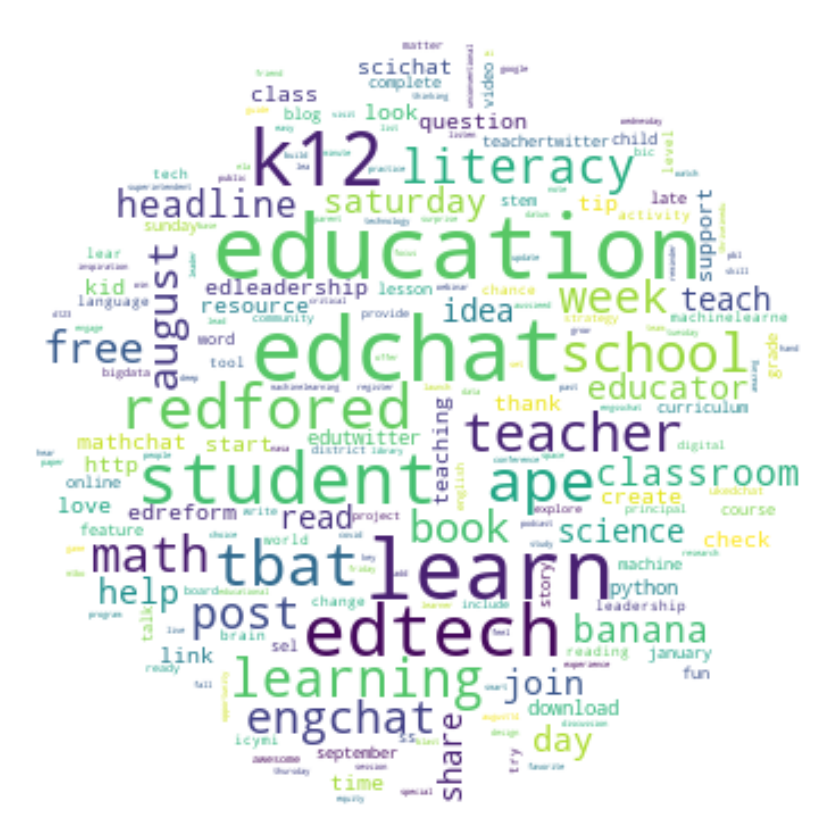

In [42]:
#Instantiate mask
char_mask = np.array(Image.open("covid19.png")) 
#Instantiate the wordcloud object
wc = wordcloud.WordCloud(background_color='white', max_words=300, stopwords=stop_words, collocations=False, max_font_size=40, random_state=42, mask=char_mask)
# Generate word cloud
wc=wc.generate(" ".join(ls_doc_tokens).lower())
# Show word cloud
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h1 style="background-color:powderblue;">Topic-modelling</h1>

In [43]:
#!pip show ipython

In [44]:
#!pip install emoji

In [45]:
#corpus = ['This is the first document.',
#          'This document is the second document.',
#          'And this is the third one.',
#          'Is this the first document?',
#         ]

In [46]:
df_Tweets_mod.head(2)

insert_timestamp     tweet_timestamp  tweet_term  \
0 2021-08-11 14:19:45.946146 2021-08-04 23:59:14  b'#edchat'   
1 2021-08-11 14:19:45.946839 2021-08-04 23:58:48  b'#edchat'   

                                               tweet place_type place_name  \
0  b'RT @Catlin_Tucker: Worried about keeping you...  Undefined  Undefined   
1  b'RT @mcleod: \xe2\x80\x9cThe focus for public...  Undefined  Undefined   

  place_full_name place_country_code place_country tweet_timestamp_date  \
0       Undefined          Undefined     Undefined           2021-08-04   
1       Undefined          Undefined     Undefined           2021-08-04   

                                           tweet_str tweet_term_str  
0  RT @Catlin_Tucker: Worried about keeping your ...        #edchat  
1  RT @mcleod: “The focus for public education sh...        #edchat

In [47]:
tqdm.pandas()
df_Tweets_mod["processed_tweet_str"] = df_Tweets_mod["tweet_str"].apply(cleaningTweets.get_token_list)

Removing_Twitter-Username: [RT, :, Worried, about, keeping, your, ", fast, finishers, ", or, kids, who, pace, more, quickly, through, stations, occupied, without, giving, them, …]
Removing_Token-URL: [RT, :, Worried, about, keeping, your, ", fast, finishers, ", or, kids, who, pace, more, quickly, through, stations, occupied, without, giving, them, …]
Removing_emoji: [RT, :, Worried, about, keeping, your, ", fast, finishers, ", or, kids, who, pace, more, quickly, through, stations, occupied, without, giving, them, …]
Lemmatizing: ['rt', ':', 'worried', 'about', 'keep', 'your', '"', 'fast', 'finisher', '"', 'or', 'kid', 'who', 'pace', 'more', 'quickly', 'through', 'station', 'occupy', 'without', 'give', 'they', '…']
Stop-words: ['worried', 'fast', 'finisher', 'kid', 'pace', 'quickly', 'station', 'occupy']
Removing_Twitter-Username: [RT, :, “, The, focus, for, public, education, shifted, from, flexibility, and, forgiveness, to, restoring, the, metronome, of, schooling, ., This, included, 

Removing_Twitter-Username: [RT, :, 🗣, ️, Conversation, Starts, for, Kids, :, 50, +, Would, You, Rather, Questions, 👇, 
, -, -, -, 
, https://t.co/DxMK46Ph9I,   , 
, #, edchat, #, ntchat, #, …]
Removing_Token-URL: [RT, :, 🗣, ️, Conversation, Starts, for, Kids, :, 50, +, Would, You, Rather, Questions, 👇, 
, -, -, -, 
,   , 
, #, edchat, #, ntchat, #, …]
Removing_emoji: [RT, :, ️, Conversation, Starts, for, Kids, :, 50, +, Would, You, Rather, Questions, -, -, -, #, edchat, #, ntchat, #, …]
Lemmatizing: ['rt', ':', '️', 'conversation', 'start', 'for', 'kids', ':', '50', '+', 'would', 'you', 'rather', 'question', '-', '-', '-', '#', 'edchat', '#', 'ntchat', '#', '…']
Stop-words: ['️', 'conversation', 'start', 'kids', '50', 'question', 'edchat', 'ntchat']
Removing_Twitter-Username: [RT, :, ICYMI, :, 40, Google, for, Education, Updates, for, Summer, 2021, 

, https://t.co/XCyvGx3UtC, #, edtech, #, gsuite, #, educoach, #, teaching, #, k, …]
Removing_Token-URL: [RT, :, ICYMI, :, 40, Google, for

Removing_Twitter-Username: [RT, :, The, know, how, to, kickoff, a, school, year, !, Thank, you, for, the, TGIF, grants, !, Congratulations, ,, Aces, !, #, W, …]
Removing_Token-URL: [RT, :, The, know, how, to, kickoff, a, school, year, !, Thank, you, for, the, TGIF, grants, !, Congratulations, ,, Aces, !, #, W, …]
Removing_emoji: [RT, :, The, know, how, to, kickoff, a, school, year, !, Thank, you, for, the, TGIF, grants, !, Congratulations, ,, Aces, !, #, W, …]
Lemmatizing: ['rt', ':', 'the', 'know', 'how', 'to', 'kickoff', 'a', 'school', 'year', '!', 'thank', 'you', 'for', 'the', 'tgif', 'grant', '!', 'congratulation', ',', 'aces', '!', '#', 'w', '…']
Stop-words: ['kickoff', 'school', 'thank', 'tgif', 'grant', 'congratulation', 'aces']
Removing_Twitter-Username: [RT, :, “, In, ELA, ,, leveling, text, is, leveling, lives, ”, 

, #, UnboundEdVirtualSummit, #, KnowBetterDoBetter, #, BeTheChange, #, EdLeade, …]
Removing_Token-URL: [RT, :, “, In, ELA, ,, leveling, text, is, leveling, lives,

Removing_Twitter-Username: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, August, 4, ,, 2021, #, REDFORED, #, tbats, #, edchat, …, https://t.co/3MrIH3RCi5]
Removing_Token-URL: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, August, 4, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Removing_emoji: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Wednesday, ,, August, 4, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'wednesday', ',', 'august', '4', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'wednesday', 'august', '4', '2021', 'redfored', 'tbat', 'edchat']
Removing_Twitter-Username: [RT, :, More, teachers, are, being, asked, to, support, student, literacy, in, all, cont

Removing_Twitter-Username: [Polar, bears, bash, walrus, skulls, with, boulders, and, ice, blocks, ,, study, suggests, -, until, scientific, researchers, actually, …, https://t.co/mnx411UKBk]
Removing_Token-URL: [Polar, bears, bash, walrus, skulls, with, boulders, and, ice, blocks, ,, study, suggests, -, until, scientific, researchers, actually, …]
Removing_emoji: [Polar, bears, bash, walrus, skulls, with, boulders, and, ice, blocks, ,, study, suggests, -, until, scientific, researchers, actually, …]
Lemmatizing: ['polar', 'bear', 'bash', 'walrus', 'skull', 'with', 'boulder', 'and', 'ice', 'block', ',', 'study', 'suggest', '-', 'until', 'scientific', 'researcher', 'actually', '…']
Stop-words: ['polar', 'bear', 'bash', 'walrus', 'skull', 'boulder', 'ice', 'block', 'study', 'suggest', 'scientific', 'researcher', 'actually']
Removing_Twitter-Username: [One, of, World, ’s, Rarest, Chameleons, Found, Clinging, to, Survival, in, Patches, of, Rainforest, in, Malawi, -, …, https://t.co/f6t3Pdbs

Removing_Twitter-Username: [RT, :, “, The, focus, for, public, education, shifted, from, flexibility, and, forgiveness, to, restoring, the, metronome, of, schooling, ., This, included, …]
Removing_Token-URL: [RT, :, “, The, focus, for, public, education, shifted, from, flexibility, and, forgiveness, to, restoring, the, metronome, of, schooling, ., This, included, …]
Removing_emoji: [RT, :, “, The, focus, for, public, education, shifted, from, flexibility, and, forgiveness, to, restoring, the, metronome, of, schooling, ., This, included, …]
Lemmatizing: ['rt', ':', '"', 'the', 'focus', 'for', 'public', 'education', 'shift', 'from', 'flexibility', 'and', 'forgiveness', 'to', 'restore', 'the', 'metronome', 'of', 'schooling', '.', 'this', 'include', '…']
Stop-words: ['focus', 'public', 'education', 'shift', 'flexibility', 'forgiveness', 'restore', 'metronome', 'schooling', 'include']
Removing_Twitter-Username: [“, The, focus, for, public, education, shifted, from, flexibility, and, forgive

Removing_Twitter-Username: [RT, :, Shoutout, to, in, -, class, shoutouts, !, 

, (, Inspiration, via, educator, ), 

, #, TeacherTwitter, #, edchat, #, EduGladiators, …]
Removing_Token-URL: [RT, :, Shoutout, to, in, -, class, shoutouts, !, 

, (, Inspiration, via, educator, ), 

, #, TeacherTwitter, #, edchat, #, EduGladiators, …]
Removing_emoji: [RT, :, Shoutout, to, in, -, class, shoutouts, !, (, Inspiration, via, educator, ), #, TeacherTwitter, #, edchat, #, EduGladiators, …]
Lemmatizing: ['rt', ':', 'shoutout', 'to', 'in', '-', 'class', 'shoutout', '!', '(', 'inspiration', 'via', 'educator', ')', '#', 'teachertwitter', '#', 'edchat', '#', 'edugladiators', '…']
Stop-words: ['shoutout', 'class', 'shoutout', 'inspiration', 'educator', 'teachertwitter', 'edchat', 'edugladiators']
Removing_Twitter-Username: [Join,  , Friday, at, 11, AM, ET, 

, https://t.co/y74GgFnAov, 

, #, edtech, #, ditchbook, #, tlap, #, ETCoaches, #, hacklearning, …, https://t.co/mhRliwqSEL]
Removing_Token-URL: [J

Removing_Twitter-Username: [RT, :, Hmmm, ...., seems, like, NYTimes, could, do, better, ., Another, great, graph, to, share, with, my, #, math, classes, !, 
, #, k12, #, mtbos, #, noticewonde, …]
Removing_Token-URL: [RT, :, Hmmm, ...., seems, like, NYTimes, could, do, better, ., Another, great, graph, to, share, with, my, #, math, classes, !, 
, #, k12, #, mtbos, #, noticewonde, …]
Removing_emoji: [RT, :, Hmmm, ...., seems, like, NYTimes, could, do, better, ., Another, great, graph, to, share, with, my, #, math, classes, !, #, k12, #, mtbos, #, noticewonde, …]
Lemmatizing: ['rt', ':', 'hmmm', '....', 'seem', 'like', 'nytimes', 'could', 'do', 'well', '.', 'another', 'great', 'graph', 'to', 'share', 'with', 'my', '#', 'math', 'class', '!', '#', 'k12', '#', 'mtbo', '#', 'noticewonde', '…']
Stop-words: ['hmmm', '....', 'nytimes', 'graph', 'share', 'math', 'class', 'k12', 'mtbo', 'noticewonde']
Removing_Twitter-Username: [RT, :, Our, client, is, in, the, K12, and, Higher, Education, e, -, L

Removing_Twitter-Username: [RT, :, Interested, in, activating, the, learning, sciences, in, your, district, ?, Explore, 's, policy, recommendations, here, :, https://t.c, …]
Removing_Token-URL: [RT, :, Interested, in, activating, the, learning, sciences, in, your, district, ?, Explore, 's, policy, recommendations, here, :, …]
Removing_emoji: [RT, :, Interested, in, activating, the, learning, sciences, in, your, district, ?, Explore, 's, policy, recommendations, here, :, …]
Lemmatizing: ['rt', ':', 'interested', 'in', 'activate', 'the', 'learn', 'science', 'in', 'your', 'district', '?', 'explore', "'s", 'policy', 'recommendation', 'here', ':', '…']
Stop-words: ['activate', 'learn', 'science', 'district', 'explore', 'policy', 'recommendation']
Removing_Twitter-Username: [RT, :, Welcome, to, the, team, ,, George, Gogonas, !, We, are, thrilled, to, have, you, aboard, !, #, txed, #, backtoschool, #, edleaders, …]
Removing_Token-URL: [RT, :, Welcome, to, the, team, ,, George, Gogonas, !, We,

Removing_Twitter-Username: [RT, :, More, teachers, are, being, asked, to, support, student, literacy, in, all, content, areas, ., 
, #, elachat, #, edchat, #, crosscurricular, #, les, …]
Removing_Token-URL: [RT, :, More, teachers, are, being, asked, to, support, student, literacy, in, all, content, areas, ., 
, #, elachat, #, edchat, #, crosscurricular, #, les, …]
Removing_emoji: [RT, :, More, teachers, are, being, asked, to, support, student, literacy, in, all, content, areas, ., #, elachat, #, edchat, #, crosscurricular, #, les, …]
Lemmatizing: ['rt', ':', 'more', 'teacher', 'be', 'be', 'ask', 'to', 'support', 'student', 'literacy', 'in', 'all', 'content', 'area', '.', '#', 'elachat', '#', 'edchat', '#', 'crosscurricular', '#', 'le', '…']
Stop-words: ['teacher', 'support', 'student', 'literacy', 'content', 'elachat', 'edchat', 'crosscurricular', 'le']
Removing_Twitter-Username: [Very, excited, to, get, lost, in, this, 👇, 
, #, dyslexia, #, edchat, #, engchat, #, reading, #, literacy,

Removing_Twitter-Username: [RT, :, Massive, ancient, lake, across, prairies, emptied, quickly, enough, to, set, off, an, ice, age, ,, study, suggests, https://t.co/n9p05sXq7B, via, @p, …]
Removing_Token-URL: [RT, :, Massive, ancient, lake, across, prairies, emptied, quickly, enough, to, set, off, an, ice, age, ,, study, suggests, via, @p, …]
Removing_emoji: [RT, :, Massive, ancient, lake, across, prairies, emptied, quickly, enough, to, set, off, an, ice, age, ,, study, suggests, via, @p, …]
Lemmatizing: ['rt', ':', 'massive', 'ancient', 'lake', 'across', 'prairie', 'empty', 'quickly', 'enough', 'to', 'set', 'off', 'an', 'ice', 'age', ',', 'study', 'suggest', 'via', '@p', '…']
Stop-words: ['massive', 'ancient', 'lake', 'prairie', 'quickly', 'set', 'ice', 'age', 'study', 'suggest', '@p']
Removing_Twitter-Username: [RT, :, U, of, A, research, identifies, protein, linked, to, often, -, fatal, inflammation, in, COVID-19, patients, -, could, change, how, COVID-19, is, treate, …]
Removing_Tok

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'july', '31', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', 'li', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'july', '31', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat', 'li']
Rem

Removing_Twitter-Username: [RT, :, This, is, the, most, important, issue, we, need, to, address, in, education, ., Without, teachers, we, can, not, educate, students, ., No, amount, o, …]
Removing_Token-URL: [RT, :, This, is, the, most, important, issue, we, need, to, address, in, education, ., Without, teachers, we, can, not, educate, students, ., No, amount, o, …]
Removing_emoji: [RT, :, This, is, the, most, important, issue, we, need, to, address, in, education, ., Without, teachers, we, can, not, educate, students, ., No, amount, o, …]
Lemmatizing: ['rt', ':', 'this', 'be', 'the', 'most', 'important', 'issue', 'we', 'need', 'to', 'address', 'in', 'education', '.', 'without', 'teacher', 'we', 'can', 'not', 'educate', 'student', '.', 'no', 'amount', 'o', '…']
Stop-words: ['issue', 'address', 'education', 'teacher', 'educate', 'student']
Removing_Twitter-Username: [RT, :, We, have, to, make, mistakes, in, order, to, learn, and, make, new, discoveries, !, (, By, ), 

, https://t.co/JhJ

Removing_Twitter-Username: [Graph, Attention, Networks, (, GAT, ), #, DeepLearning, #, learning, via, https://t.co/iWAHge7rvy, https://t.co/gR90XQgY5, g]
Removing_Token-URL: [Graph, Attention, Networks, (, GAT, ), #, DeepLearning, #, learning, via, g]
Removing_emoji: [Graph, Attention, Networks, (, GAT, ), #, DeepLearning, #, learning, via, g]
Lemmatizing: ['graph', 'attention', 'networks', '(', 'gat', ')', '#', 'deeplearning', '#', 'learning', 'via', 'g']
Stop-words: ['graph', 'attention', 'networks', 'gat', 'deeplearning', 'learning']
Removing_Twitter-Username: [RT, :, What, is, Artificial, Intelligence, #, DeepLearning, #, learning, #, machinelearning,  , https://t.co/ssVmYgpBeC]
Removing_Token-URL: [RT, :, What, is, Artificial, Intelligence, #, DeepLearning, #, learning, #, machinelearning,  ]
Removing_emoji: [RT, :, What, is, Artificial, Intelligence, #, DeepLearning, #, learning, #, machinelearning]
Lemmatizing: ['rt', ':', 'what', 'be', 'artificial', 'intelligence', '#', 'deeple

Removing_Twitter-Username: [RT, :, Grab, 16, of, the, new, and, improved, Sphero, Mini, robots, and, all, the, #, teaching, materials, you, need, for, #, coding, in, the, Sphero, Mini, E, …]
Removing_Token-URL: [RT, :, Grab, 16, of, the, new, and, improved, Sphero, Mini, robots, and, all, the, #, teaching, materials, you, need, for, #, coding, in, the, Sphero, Mini, E, …]
Removing_emoji: [RT, :, Grab, 16, of, the, new, and, improved, Sphero, Mini, robots, and, all, the, #, teaching, materials, you, need, for, #, coding, in, the, Sphero, Mini, E, …]
Lemmatizing: ['rt', ':', 'grab', '16', 'of', 'the', 'new', 'and', 'improve', 'sphero', 'mini', 'robot', 'and', 'all', 'the', '#', 'teaching', 'material', 'you', 'need', 'for', '#', 'coding', 'in', 'the', 'sphero', 'mini', 'e', '…']
Stop-words: ['grab', '16', 'improve', 'sphero', 'mini', 'robot', 'teaching', 'material', 'coding', 'sphero', 'mini']
Removing_Twitter-Username: [RT, :, We, have, to, make, mistakes, in, order, to, learn, and, make

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'july', '31', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', 'li', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'july', '31', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat', 'li']
Rem

Removing_Twitter-Username: [Greenhouse, Gas, Caused, Global, Cooling, 34, Million, Years, Ago, ,, Study, Finds, -,  , only, a, decrease, in, carbon, dioxide, could, h, …, https://t.co/I5cpAN00wH]
Removing_Token-URL: [Greenhouse, Gas, Caused, Global, Cooling, 34, Million, Years, Ago, ,, Study, Finds, -,  , only, a, decrease, in, carbon, dioxide, could, h, …]
Removing_emoji: [Greenhouse, Gas, Caused, Global, Cooling, 34, Million, Years, Ago, ,, Study, Finds, -, only, a, decrease, in, carbon, dioxide, could, h, …]
Lemmatizing: ['greenhouse', 'gas', 'cause', 'global', 'cooling', '34', 'million', 'year', 'ago', ',', 'study', 'find', '-', 'only', 'a', 'decrease', 'in', 'carbon', 'dioxide', 'could', 'h', '…']
Stop-words: ['greenhouse', 'gas', 'cause', 'global', 'cooling', '34', 'million', 'ago', 'study', 'decrease', 'carbon', 'dioxide']
Removing_Twitter-Username: [RT, :, Runner, -, up, Stories, from, the, “, What, Does, Biodiversity, Mean, to, You, ?, “, Essay, Contest, https://t.co/tJ8UjyC8u

Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'friday', 'august', '6', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learni']
Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, July, 31, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, li, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'july', '31', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', 'li', '…']
Stop-words

Removing_Twitter-Username: [Supporting, Special, Education, Students, w/, Rob, Salgado, #, reimaginedschools, #, njed, #, edchat,  , #, njedpartners, #, pln, #, edreform, …, https://t.co/oV6lYb7Wot]
Removing_Token-URL: [Supporting, Special, Education, Students, w/, Rob, Salgado, #, reimaginedschools, #, njed, #, edchat,  , #, njedpartners, #, pln, #, edreform, …]
Removing_emoji: [Supporting, Special, Education, Students, w/, Rob, Salgado, #, reimaginedschools, #, njed, #, edchat, #, njedpartners, #, pln, #, edreform, …]
Lemmatizing: ['support', 'special', 'education', 'students', 'w/', 'rob', 'salgado', '#', 'reimaginedschool', '#', 'njed', '#', 'edchat', '#', 'njedpartner', '#', 'pln', '#', 'edreform', '…']
Stop-words: ['support', 'special', 'education', 'students', 'w/', 'rob', 'salgado', 'reimaginedschool', 'njed', 'edchat', 'njedpartner', 'pln', 'edreform']
Removing_Twitter-Username: [Using, Movie, Clips, in, the, Classroom, #, edtech, #, edchat, https://t.co/c9syk78we7]
Removing_T

Removing_Twitter-Username: [The, Word, of, the, Day, ., We, are, #, Reading, ,, join, us, ., 

, #, BookClub, #, books, #, readingcommunity, #, readingclub, #, learning, …, https://t.co/2jF0ZD2SkK]
Removing_Token-URL: [The, Word, of, the, Day, ., We, are, #, Reading, ,, join, us, ., 

, #, BookClub, #, books, #, readingcommunity, #, readingclub, #, learning, …]
Removing_emoji: [The, Word, of, the, Day, ., We, are, #, Reading, ,, join, us, ., #, BookClub, #, books, #, readingcommunity, #, readingclub, #, learning, …]
Lemmatizing: ['the', 'word', 'of', 'the', 'day', '.', 'we', 'be', '#', 'reading', ',', 'join', 'we', '.', '#', 'bookclub', '#', 'book', '#', 'readingcommunity', '#', 'readingclub', '#', 'learning', '…']
Stop-words: ['word', 'day', 'reading', 'join', 'bookclub', 'book', 'readingcommunity', 'readingclub', 'learning']
Removing_Twitter-Username: [In, this, article, ,, we, are, going, to, look, at, some, major, reasons, why, #, learning, #, English, is, so, #, important, for, ch

Removing_Twitter-Username: [📚, SYLLABUS, -, FREE, DOWNLOAD, 
, https://t.co/6bvHZ2nVIb, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …, https://t.co/OfAHeY3aFB]
Removing_Token-URL: [📚, SYLLABUS, -, FREE, DOWNLOAD, 
, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …]
Removing_emoji: [SYLLABUS, -, FREE, DOWNLOAD, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …]
Lemmatizing: ['syllabus', '-', 'free', 'download', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edleadership', '#', 'edtech', '#', 'engchat', '#', 'literacy', '…']
Stop-words: ['syllabus', 'free', 'download', 'edchat', 'k12', 'learn', 'edleadership', 'edtech', 'engchat', 'literacy']
Removing_Twitter-Username: [RT, :, #, AugmentedReality, will, change, the, way, we, study, #, Math, 

, #, AR, #, VR, #, AI, #, MixedReality, #, Edtech, #, Education, 
, @J, …]
Removing_Token-URL: [RT, :, #, AugmentedReality, w

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august', '7', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', 'l', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august', '7', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat']
Removing

Removing_Twitter-Username: [📚, SYLLABUS, -, FREE, DOWNLOAD, 
, https://t.co/6bvHZ2nVIb, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …, https://t.co/OfAHeY3aFB]
Removing_Token-URL: [📚, SYLLABUS, -, FREE, DOWNLOAD, 
, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …]
Removing_emoji: [SYLLABUS, -, FREE, DOWNLOAD, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …]
Lemmatizing: ['syllabus', '-', 'free', 'download', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edleadership', '#', 'edtech', '#', 'engchat', '#', 'literacy', '…']
Stop-words: ['syllabus', 'free', 'download', 'edchat', 'k12', 'learn', 'edleadership', 'edtech', 'engchat', 'literacy']
Removing_Twitter-Username: [📚, PAST, PAPERS, -, FREE, DOWNLOAD, 
, https://t.co/tTcUynqLVq, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, …, https://t.co/Cw4ucSS3Zt]
Removing_Token-URL: [📚, PAST, P

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 7, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, l, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august', '7', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', 'l', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august', '7', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat']
Removing

Removing_Twitter-Username: [If, kids, do, n't, get, recess, then, politicians, do, n't, get, recess, ., 
, #, edchat]
Removing_Token-URL: [If, kids, do, n't, get, recess, then, politicians, do, n't, get, recess, ., 
, #, edchat]
Removing_emoji: [If, kids, do, n't, get, recess, then, politicians, do, n't, get, recess, ., #, edchat]
Lemmatizing: ['if', 'kid', 'do', 'not', 'get', 'recess', 'then', 'politician', 'do', 'not', 'get', 'recess', '.', '#', 'edchat']
Stop-words: ['kid', 'recess', 'politician', 'recess', 'edchat']
Removing_Twitter-Username: [RT, :, Homework, can, be, useful, to, help, students, #, learning, ,, but, is, n't, always, the, best, strategy, ., Here, are, alternatives, to, homework, ., 

, https, …]
Removing_Token-URL: [RT, :, Homework, can, be, useful, to, help, students, #, learning, ,, but, is, n't, always, the, best, strategy, ., Here, are, alternatives, to, homework, ., 

, https, …]
Removing_emoji: [RT, :, Homework, can, be, useful, to, help, students, #, learnin

Removing_Twitter-Username: [RT, :, #, learning, 
, 🚀, #, Opportunity, ,, There, is, a, solid, path, to, general, #, AI, 
, https://t.co/0jbnzqvi2Y, 
, https://t.co/kNaL7xZ2iE, 
, https://t, ., …]
Removing_Token-URL: [RT, :, #, learning, 
, 🚀, #, Opportunity, ,, There, is, a, solid, path, to, general, #, AI, 
, 
, 
, https://t, ., …]
Removing_emoji: [RT, :, #, learning, #, Opportunity, ,, There, is, a, solid, path, to, general, #, AI, https://t, ., …]
Lemmatizing: ['rt', ':', '#', 'learn', '#', 'opportunity', ',', 'there', 'be', 'a', 'solid', 'path', 'to', 'general', '#', 'ai', 'https://t', '.', '…']
Stop-words: ['learn', 'opportunity', 'solid', 'path', 'ai', 'https://t']
Removing_Twitter-Username: [RT, :, #, learning, #, AI, #, digital, 
, 🚀, #, Opportunity, ,, Observing, the, new, world, with, our, exceptional, general, natural, intelligence, 
, https://t, …]
Removing_Token-URL: [RT, :, #, learning, #, AI, #, digital, 
, 🚀, #, Opportunity, ,, Observing, the, new, world, with, our, exc

Removing_Twitter-Username: [We, 've, got, our, badges, and, excited, to, get, going, !, Here, 's, a, peek, at, what, 's, up, to, the, next, 3, days, at, the, …, https://t.co/vSMJCclGpj]
Removing_Token-URL: [We, 've, got, our, badges, and, excited, to, get, going, !, Here, 's, a, peek, at, what, 's, up, to, the, next, 3, days, at, the, …]
Removing_emoji: [We, 've, got, our, badges, and, excited, to, get, going, !, Here, 's, a, peek, at, what, 's, up, to, the, next, 3, days, at, the, …]
Lemmatizing: ['we', "'ve", 'get', 'our', 'badge', 'and', 'excite', 'to', 'get', 'go', '!', 'here', 'be', 'a', 'peek', 'at', 'what', 'be', 'up', 'to', 'the', 'next', '3', 'day', 'at', 'the', '…']
Stop-words: ['badge', 'excite', 'peek', '3', 'day']
Removing_Twitter-Username: [Finding, a, class, to, partner, with, virtually, AND, activities, to, do, together, 

, https://t.co/hDobCvVDaq, 

, #, ditchbook, #, edtech, https://t.co/xXCpjrMy4n]
Removing_Token-URL: [Finding, a, class, to, partner, with, virtually

Removing_Twitter-Username: [RT, :, GCSE, English, language, and, literature, revision, books,  , -, our, pick, of, the, best, recent, publications, ,, chosen, by, experienced, t, …]
Removing_Token-URL: [RT, :, GCSE, English, language, and, literature, revision, books,  , -, our, pick, of, the, best, recent, publications, ,, chosen, by, experienced, t, …]
Removing_emoji: [RT, :, GCSE, English, language, and, literature, revision, books, -, our, pick, of, the, best, recent, publications, ,, chosen, by, experienced, t, …]
Lemmatizing: ['rt', ':', 'gcse', 'english', 'language', 'and', 'literature', 'revision', 'book', '-', 'our', 'pick', 'of', 'the', 'good', 'recent', 'publication', ',', 'choose', 'by', 'experienced', 't', '…']
Stop-words: ['gcse', 'english', 'language', 'literature', 'revision', 'book', 'pick', 'recent', 'publication', 'choose', 'experienced']
Removing_Twitter-Username: [RT, :, Math, by, the, Book, is, here, !,  , Students, learn, through, stories, so, here, is, your, opp

Removing_Twitter-Username: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, 
, (, August, 8), :,  , Guar, gum, slime, fun, https://t.co/dz, …]
Removing_Token-URL: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, 
, (, August, 8), :,  , Guar, gum, slime, fun, …]
Removing_emoji: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, (, August, 8), :, Guar, gum, slime, fun, …]
Lemmatizing: ['rt', ':', 'icymi', ':', 'the', 'late', 'praxis', "'", 'science', 'smarts', "'", 'column', 'in', 'the', '(', 'august', '8)', ':', 'guar', 'gum', 'slime', 'fun', '…']
Stop-words: ['icymi', 'late', 'praxis', 'science', 'smarts', 'column', 'august', '8)', 'guar', 'gum', 'slime', 'fun']
Removing_Twitter-Username: [RT, :, ICYMI, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, 
, (, August, 8), :,  , Guar, gum, slime, fun, https://t.co/dz, …]
Removing_Token-URL: [RT, :, ICYMI, :, The, latest, Praxis, ', Scienc

Removing_Twitter-Username: [Vol, 14, ,, No, 13, (, 2019, ), International, Journal, of, Emerging, Technologies, in, Learning, (, iJET, ),  , https://t.co/UaTIBuyjz0, …, https://t.co/RJ0KkuwXPX]
Removing_Token-URL: [Vol, 14, ,, No, 13, (, 2019, ), International, Journal, of, Emerging, Technologies, in, Learning, (, iJET, ),  , …]
Removing_emoji: [Vol, 14, ,, No, 13, (, 2019, ), International, Journal, of, Emerging, Technologies, in, Learning, (, iJET, ), …]
Lemmatizing: ['vol', '14', ',', 'no', '13', '(', '2019', ')', 'international', 'journal', 'of', 'emerging', 'technologies', 'in', 'learning', '(', 'ijet', ')', '…']
Stop-words: ['vol', '14', '13', '2019', 'international', 'journal', 'emerging', 'technologies', 'learning', 'ijet']
Removing_Twitter-Username: [RT, :, YESTERDAY, 'S, POST, The, Education, Endowment, Foundation, 's, Toolkit, is, a, complete, mess, :, It, is, now, time, to, quietly, let, it, go, http, …]
Removing_Token-URL: [RT, :, YESTERDAY, 'S, POST, The, Education, Endow

Removing_Twitter-Username: [RT, :, At, the, end, of, the, day, ,, what, matters, is, that, YOU, know, you, did, your, best, &, amp, ;, gave, it, your, all, ., Do, n't, stop, ., Your, students, need, …]
Removing_Token-URL: [RT, :, At, the, end, of, the, day, ,, what, matters, is, that, YOU, know, you, did, your, best, &, amp, ;, gave, it, your, all, ., Do, n't, stop, ., Your, students, need, …]
Removing_emoji: [RT, :, At, the, end, of, the, day, ,, what, matters, is, that, YOU, know, you, did, your, best, &, amp, ;, gave, it, your, all, ., Do, n't, stop, ., Your, students, need, …]
Lemmatizing: ['rt', ':', 'at', 'the', 'end', 'of', 'the', 'day', ',', 'what', 'matter', 'be', 'that', 'you', 'know', 'you', 'do', 'your', 'good', '&', 'amp', ';', 'give', 'it', 'you', 'all', '.', 'do', 'not', 'stop', '.', 'your', 'student', 'need', '…']
Stop-words: ['day', 'matter', 'stop', 'student']
Removing_Twitter-Username: [RT, :, This, week, 's, sketch, :, Empowered, Inquiry, Spaces, and, the, work, of,

Removing_Twitter-Username: [RT, :, #, FEATURED, #, COURSES, 

, Machine, Learning, ,, Data, Science, and, Deep, Learning, with, Python, 

, Complete, hands, -, on, #, machine, #, learning, tutoria, …]
Removing_Token-URL: [RT, :, #, FEATURED, #, COURSES, 

, Machine, Learning, ,, Data, Science, and, Deep, Learning, with, Python, 

, Complete, hands, -, on, #, machine, #, learning, tutoria, …]
Removing_emoji: [RT, :, #, FEATURED, #, COURSES, Machine, Learning, ,, Data, Science, and, Deep, Learning, with, Python, Complete, hands, -, on, #, machine, #, learning, tutoria, …]
Lemmatizing: ['rt', ':', '#', 'feature', '#', 'course', 'machine', 'learning', ',', 'data', 'science', 'and', 'deep', 'learning', 'with', 'python', 'complete', 'hand', '-', 'on', '#', 'machine', '#', 'learn', 'tutoria', '…']
Stop-words: ['feature', 'course', 'machine', 'learning', 'data', 'science', 'deep', 'learning', 'python', 'complete', 'hand', 'machine', 'learn', 'tutoria']
Removing_Twitter-Username: [RT, :, Teache

Removing_Twitter-Username: [RT, :, Google, Student, Training, &, amp, ;, Chromebook, Troubleshooting, resources, I, put, together, to, help, students, learn, Google, basics, and, to, …]
Removing_Token-URL: [RT, :, Google, Student, Training, &, amp, ;, Chromebook, Troubleshooting, resources, I, put, together, to, help, students, learn, Google, basics, and, to, …]
Removing_emoji: [RT, :, Google, Student, Training, &, amp, ;, Chromebook, Troubleshooting, resources, I, put, together, to, help, students, learn, Google, basics, and, to, …]
Lemmatizing: ['rt', ':', 'google', 'student', 'training', '&', 'amp', ';', 'chromebook', 'troubleshooting', 'resource', 'i', 'put', 'together', 'to', 'help', 'student', 'learn', 'google', 'basic', 'and', 'to', '…']
Stop-words: ['google', 'student', 'training', 'chromebook', 'troubleshooting', 'resource', 'help', 'student', 'learn', 'google', 'basic']
Removing_Twitter-Username: [RT, :, Is, #, DeepMind, ’s,  , reinforcement, learning, system, a, step, toward

Removing_Twitter-Username: [RT, :, Calling, all, literacies, practitioners, 📯, ✨, seeking, your, experiences, of, working, with, picturebooks, and, how, you, have, modified, th, …]
Removing_Token-URL: [RT, :, Calling, all, literacies, practitioners, 📯, ✨, seeking, your, experiences, of, working, with, picturebooks, and, how, you, have, modified, th, …]
Removing_emoji: [RT, :, Calling, all, literacies, practitioners, seeking, your, experiences, of, working, with, picturebooks, and, how, you, have, modified, th, …]
Lemmatizing: ['rt', ':', 'call', 'all', 'literacy', 'practitioner', 'seek', 'your', 'experience', 'of', 'work', 'with', 'picturebook', 'and', 'how', 'you', 'have', 'modify', 'th', '…']
Stop-words: ['literacy', 'practitioner', 'seek', 'experience', 'picturebook', 'modify', 'th']
Removing_Twitter-Username: [Was, your, summer, reading, interrupted, by, back, to, school, ?, We, get, you, ., #, Georgia, #, Literacy, #, Reading, #, toomanybooks, https://t.co/JANrJ9NzyB]
Removing_Tok

Removing_Twitter-Username: [10, Best, Examples, Of, VR, And, AR, In, Education, via, https://t.co/tejXnNEbKm, #, D123, #, edchat, #, edtech, #, cpchat, …, https://t.co/PMBw5l4mR7]
Removing_Token-URL: [10, Best, Examples, Of, VR, And, AR, In, Education, via, #, D123, #, edchat, #, edtech, #, cpchat, …]
Removing_emoji: [10, Best, Examples, Of, VR, And, AR, In, Education, via, #, D123, #, edchat, #, edtech, #, cpchat, …]
Lemmatizing: ['10', 'good', 'examples', 'of', 'vr', 'and', 'ar', 'in', 'education', 'via', '#', 'd123', '#', 'edchat', '#', 'edtech', '#', 'cpchat', '…']
Stop-words: ['10', 'examples', 'vr', 'ar', 'education', 'd123', 'edchat', 'edtech', 'cpchat']
Removing_Twitter-Username: [This, was, so, me, 🤣, #, teachertwitter, #, teachers, #, teachersofinstagram, #, mathchat, #, mathteacher, #, edchat, https://t.co/5kdnDw1xll]
Removing_Token-URL: [This, was, so, me, 🤣, #, teachertwitter, #, teachers, #, teachersofinstagram, #, mathchat, #, mathteacher, #, edchat]
Removing_emoji: [Thi

Removing_Twitter-Username: [RT, :, 📚, PAST, PAPERS, -, FREE, DOWNLOAD, 
, https://t.co/tTcUynqLVq, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …]
Removing_Token-URL: [RT, :, 📚, PAST, PAPERS, -, FREE, DOWNLOAD, 
, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …]
Removing_emoji: [RT, :, PAST, PAPERS, -, FREE, DOWNLOAD, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, …]
Lemmatizing: ['rt', ':', 'past', 'paper', '-', 'free', 'download', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edleadership', '#', 'edtech', '#', 'engchat', '#', 'literacy', '…']
Stop-words: ['past', 'paper', 'free', 'download', 'edchat', 'k12', 'learn', 'edleadership', 'edtech', 'engchat', 'literacy']
Removing_Twitter-Username: [RT, :, 📚, UPDATED, SCHEMES, OF, WORK, -, FREE, DOWNLOAD, 

, https://t.co/iQoq4VI4Hc, 
, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engch, …]
Removing

Removing_Twitter-Username: [RT, :, When, students, feel, included, and, supported, ,, they, 're, ready, to, learn, ., #, Sponsored, by, #, BTS, #, edchat, #, diversity, #, i, …]
Removing_Token-URL: [RT, :, When, students, feel, included, and, supported, ,, they, 're, ready, to, learn, ., #, Sponsored, by, #, BTS, #, edchat, #, diversity, #, i, …]
Removing_emoji: [RT, :, When, students, feel, included, and, supported, ,, they, 're, ready, to, learn, ., #, Sponsored, by, #, BTS, #, edchat, #, diversity, #, i, …]
Lemmatizing: ['rt', ':', 'when', 'student', 'feel', 'include', 'and', 'support', ',', 'they', 'be', 'ready', 'to', 'learn', '.', '#', 'sponsor', 'by', '#', 'bts', '#', 'edchat', '#', 'diversity', '#', 'i', '…']
Stop-words: ['student', 'feel', 'include', 'support', 'ready', 'learn', 'sponsor', 'bts', 'edchat', 'diversity']
Removing_Twitter-Username: [RT, :, That, 's, just, it, ,, .,  , They, do, n't, think, it, is, that, serious, .,  , ", It, 's, just, a, bad, cold, ., I, 'm, not,

Removing_Twitter-Username: [RT, :, HAPPY, TUESDAY, !, Why, not, celebrate, with, another, FAST, FRENCH, video?!, 📺, Today, ,, we, learn, about, French, Possessive, Adjectives, ,, b, …]
Removing_Token-URL: [RT, :, HAPPY, TUESDAY, !, Why, not, celebrate, with, another, FAST, FRENCH, video?!, 📺, Today, ,, we, learn, about, French, Possessive, Adjectives, ,, b, …]
Removing_emoji: [RT, :, HAPPY, TUESDAY, !, Why, not, celebrate, with, another, FAST, FRENCH, video?!, Today, ,, we, learn, about, French, Possessive, Adjectives, ,, b, …]
Lemmatizing: ['rt', ':', 'happy', 'tuesday', '!', 'why', 'not', 'celebrate', 'with', 'another', 'fast', 'french', 'video?!', 'today', ',', 'we', 'learn', 'about', 'french', 'possessive', 'adjectives', ',', 'b', '…']
Stop-words: ['happy', 'tuesday', 'celebrate', 'fast', 'french', 'video?!', 'learn', 'french', 'possessive', 'adjectives']
Removing_Twitter-Username: [I, know, today, did, n’t, go, as, planned, but, I, am, so, proud, of, as, he, battled, till, the, en

Removing_Twitter-Username: [RT, :, Imagine, doing, a, whole, post, about, student, data, and, not, including, one, paragraph, about, student, data, privacy, ?, 

, Do, better, ,, …]
Removing_Token-URL: [RT, :, Imagine, doing, a, whole, post, about, student, data, and, not, including, one, paragraph, about, student, data, privacy, ?, 

, Do, better, ,, …]
Removing_emoji: [RT, :, Imagine, doing, a, whole, post, about, student, data, and, not, including, one, paragraph, about, student, data, privacy, ?, Do, better, ,, …]
Lemmatizing: ['rt', ':', 'imagine', 'do', 'a', 'whole', 'post', 'about', 'student', 'datum', 'and', 'not', 'include', 'one', 'paragraph', 'about', 'student', 'datum', 'privacy', '?', 'do', 'well', ',', '…']
Stop-words: ['imagine', 'post', 'student', 'datum', 'include', 'paragraph', 'student', 'datum', 'privacy']
Removing_Twitter-Username: [RT, :, ", By, the, end, of, 2030, ,, whoever, wants, access, to, higher, ed, ,, gets, it, ., ", ..., what, a, wonderfully, ambitious, 

Removing_Twitter-Username: [RT, :, Teacher, training, and, development, are, vital, for, the, successful, implementation, of, our, literacy, program-, Sun, Books, .,  , Here, ,, …]
Removing_Token-URL: [RT, :, Teacher, training, and, development, are, vital, for, the, successful, implementation, of, our, literacy, program-, Sun, Books, .,  , Here, ,, …]
Removing_emoji: [RT, :, Teacher, training, and, development, are, vital, for, the, successful, implementation, of, our, literacy, program-, Sun, Books, ., Here, ,, …]
Lemmatizing: ['rt', ':', 'teacher', 'training', 'and', 'development', 'be', 'vital', 'for', 'the', 'successful', 'implementation', 'of', 'our', 'literacy', 'program-', 'sun', 'books', '.', 'here', ',', '…']
Stop-words: ['teacher', 'training', 'development', 'vital', 'successful', 'implementation', 'literacy', 'program-', 'sun', 'books']
Removing_Twitter-Username: [Translating, Reading, Science, to, Success, for, ELLs, and, Older, Students, !, Thank, you, ,, Secondary, Educa

Removing_Twitter-Username: [", The, genomes, of, living, animals, are, littered, with, DNA, from, long, -, gone, relatives, ,, providing, a, lens, on, evolution, ,, past, …, https://t.co/Y0ZLxWY4RY]
Removing_Token-URL: [", The, genomes, of, living, animals, are, littered, with, DNA, from, long, -, gone, relatives, ,, providing, a, lens, on, evolution, ,, past, …]
Removing_emoji: [", The, genomes, of, living, animals, are, littered, with, DNA, from, long, -, gone, relatives, ,, providing, a, lens, on, evolution, ,, past, …]
Lemmatizing: ['"', 'the', 'genome', 'of', 'live', 'animal', 'be', 'litter', 'with', 'dna', 'from', 'long', '-', 'go', 'relative', ',', 'provide', 'a', 'lens', 'on', 'evolution', ',', 'past', '…']
Stop-words: ['genome', 'live', 'animal', 'litter', 'dna', 'relative', 'provide', 'lens', 'evolution', 'past']
Removing_Twitter-Username: [Researchers, find, a, ‘, fearsome, dragon, ’, that, soared, over, outback, Queensland, -, “, This, thing, would, have, been, quite, savag

Removing_Twitter-Username: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, August, 10, ,, 2021, #, REDFORED, #, tbats, #, edchat, …, https://t.co/jKD4jnQ033]
Removing_Token-URL: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, August, 10, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Removing_emoji: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Tuesday, ,, August, 10, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'tuesday', ',', 'august', '10', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'tuesday', 'august', '10', '2021', 'redfored', 'tbat', 'edchat']
Removing_Twitter-Username: [RT, :, Rock, ON, with, our, Anthem, from, !, 
, https://t.co/vAfdjqSkiB, #, ASCDL2L, #, edch

Removing_Twitter-Username: [RT, :, Create, a, critical, thinking, mindset, with, this, guidance, from, ., Start, off, the, new, school, year, creating, an, en, …]
Removing_Token-URL: [RT, :, Create, a, critical, thinking, mindset, with, this, guidance, from, ., Start, off, the, new, school, year, creating, an, en, …]
Removing_emoji: [RT, :, Create, a, critical, thinking, mindset, with, this, guidance, from, ., Start, off, the, new, school, year, creating, an, en, …]
Lemmatizing: ['rt', ':', 'create', 'a', 'critical', 'thinking', 'mindset', 'with', 'this', 'guidance', 'from', '.', 'start', 'off', 'the', 'new', 'school', 'year', 'create', 'an', 'en', '…']
Stop-words: ['create', 'critical', 'thinking', 'mindset', 'guidance', 'start', 'school', 'create', 'en']
Removing_Twitter-Username: [RT, :, I, love, using, my, ", Library, Skills, ", stories, and, songs, to, kick, off, the, year, as, our, littles, learn, about, the, library, ,, books, a, …]
Removing_Token-URL: [RT, :, I, love, using, my

Removing_Twitter-Username: [RT, :, I, will, instruct, you, and, teach, you, in, the, way, you, should, go, ;, 
, I, will, counsel, you, with, my, loving, eye, on, yo, …]
Removing_Token-URL: [RT, :, I, will, instruct, you, and, teach, you, in, the, way, you, should, go, ;, 
, I, will, counsel, you, with, my, loving, eye, on, yo, …]
Removing_emoji: [RT, :, I, will, instruct, you, and, teach, you, in, the, way, you, should, go, ;, I, will, counsel, you, with, my, loving, eye, on, yo, …]
Lemmatizing: ['rt', ':', 'i', 'will', 'instruct', 'you', 'and', 'teach', 'you', 'in', 'the', 'way', 'you', 'should', 'go', ';', 'i', 'will', 'counsel', 'you', 'with', 'my', 'love', 'eye', 'on', 'yo', '…']
Stop-words: ['instruct', 'teach', 'counsel', 'love', 'eye', 'yo']
Removing_Twitter-Username: [RT, :, Why, not, try, something, new, today, ?, Explore, the, #, PanamaPapers, data, set, with, a, #, graphdatabase, sandbox, ., Easy, to, get, started, with, ,, fri, …]
Removing_Token-URL: [RT, :, Why, not, try,

Removing_Twitter-Username: [Many, things, I, read, &, amp, ;, think, about, are, shared, by, my, friend, ,, &, amp, ;, this, speaks, to, my, soul, .,  , Centering, the, …, https://t.co/8bwDMa7w0a]
Removing_Token-URL: [Many, things, I, read, &, amp, ;, think, about, are, shared, by, my, friend, ,, &, amp, ;, this, speaks, to, my, soul, .,  , Centering, the, …]
Removing_emoji: [Many, things, I, read, &, amp, ;, think, about, are, shared, by, my, friend, ,, &, amp, ;, this, speaks, to, my, soul, ., Centering, the, …]
Lemmatizing: ['many', 'thing', 'i', 'read', '&', 'amp', ';', 'think', 'about', 'be', 'share', 'by', 'my', 'friend', ',', '&', 'amp', ';', 'this', 'speak', 'to', 'my', 'soul', '.', 'center', 'the', '…']
Stop-words: ['read', 'share', 'friend', 'speak', 'soul', 'center']
Removing_Twitter-Username: [RT, :, Create, a, critical, thinking, mindset, with, this, guidance, from, ., Start, off, the, new, school, year, creating, an, en, …]
Removing_Token-URL: [RT, :, Create, a, critical,

Removing_Twitter-Username: [RT, :, AMAZING, MATILDA, 
, #, FREE, Download, FINGER, PUPPETS, at, https://t.co/TMF04Fa18h,  , “, Have, lots, of, fun, talking, about, books, and, emba, …]
Removing_Token-URL: [RT, :, AMAZING, MATILDA, 
, #, FREE, Download, FINGER, PUPPETS, at,  , “, Have, lots, of, fun, talking, about, books, and, emba, …]
Removing_emoji: [RT, :, AMAZING, MATILDA, #, FREE, Download, FINGER, PUPPETS, at, “, Have, lots, of, fun, talking, about, books, and, emba, …]
Lemmatizing: ['rt', ':', 'amazing', 'matilda', '#', 'free', 'download', 'finger', 'puppet', 'at', '"', 'have', 'lot', 'of', 'fun', 'talk', 'about', 'book', 'and', 'emba', '…']
Stop-words: ['amazing', 'matilda', 'free', 'download', 'finger', 'puppet', 'lot', 'fun', 'talk', 'book', 'emba']
Removing_Twitter-Username: [RT, :, AMAZING, MATILDA, 
, #, FREE, Download, FINGER, PUPPETS, at, https://t.co/TMF04Fa18h,  , “, Have, lots, of, fun, talking, about, books, and, emba, …]
Removing_Token-URL: [RT, :, AMAZING, MATILDA,

Removing_Twitter-Username: [Loose, Parts, for, 8/15/2021, -, Ridden, off, into, the, subset, https://t.co/umY9sBElKT, #, arcamax, #, humour, #, SciChat, #, MathChat]
Removing_Token-URL: [Loose, Parts, for, 8/15/2021, -, Ridden, off, into, the, subset, #, arcamax, #, humour, #, SciChat, #, MathChat]
Removing_emoji: [Loose, Parts, for, 8/15/2021, -, Ridden, off, into, the, subset, #, arcamax, #, humour, #, SciChat, #, MathChat]
Lemmatizing: ['loose', 'parts', 'for', '8/15/2021', '-', 'ridden', 'off', 'into', 'the', 'subset', '#', 'arcamax', '#', 'humour', '#', 'scichat', '#', 'mathchat']
Stop-words: ['loose', '8/15/2021', 'ridden', 'subset', 'arcamax', 'humour', 'scichat', 'mathchat']
Removing_Twitter-Username: [A, place, value, task, that, can, be, used, for, whole, number, and, decimals, ., Consider, it, for, mini, -, lessons, ,, small, group, ,, stati, …, https://t.co/kQohNsgOjV]
Removing_Token-URL: [A, place, value, task, that, can, be, used, for, whole, number, and, decimals, ., Con

Removing_Twitter-Username: [RT, :, [, LISTEN, ], Adultification, :, What, Happens, When, Our, Schools, Place, Grownup, Expectations, on, Teenage, Black, Girls, ?, with, …]
Removing_Token-URL: [RT, :, [, LISTEN, ], Adultification, :, What, Happens, When, Our, Schools, Place, Grownup, Expectations, on, Teenage, Black, Girls, ?, with, …]
Removing_emoji: [RT, :, [, LISTEN, ], Adultification, :, What, Happens, When, Our, Schools, Place, Grownup, Expectations, on, Teenage, Black, Girls, ?, with, …]
Lemmatizing: ['rt', ':', '[', 'listen', ']', 'adultification', ':', 'what', 'happen', 'when', 'our', 'schools', 'place', 'grownup', 'expectations', 'on', 'teenage', 'black', 'girls', '?', 'with', '…']
Stop-words: ['listen', 'adultification', 'happen', 'schools', 'grownup', 'expectations', 'teenage', 'black', 'girls']
Removing_Twitter-Username: [RT, :, This, self, -, care, solutions, chart, ", leads, to, great, conversations, and, normalizes, ", self, -, care, ,, says, T, ., Might, you, try, …]
Rem

Removing_Twitter-Username: [RT, :, The, Big, List, of, Class, Discussion, Strategies, 

, https://t.co/m0axmkGaN6,  ,  
, #, edutwitter, #, learning, #, edchat, #, k12, #, teach, …]
Removing_Token-URL: [RT, :, The, Big, List, of, Class, Discussion, Strategies, 

,  ,  
, #, edutwitter, #, learning, #, edchat, #, k12, #, teach, …]
Removing_emoji: [RT, :, The, Big, List, of, Class, Discussion, Strategies, #, edutwitter, #, learning, #, edchat, #, k12, #, teach, …]
Lemmatizing: ['rt', ':', 'the', 'big', 'list', 'of', 'class', 'discussion', 'strategy', '#', 'edutwitter', '#', 'learn', '#', 'edchat', '#', 'k12', '#', 'teach', '…']
Stop-words: ['list', 'class', 'discussion', 'strategy', 'edutwitter', 'learn', 'edchat', 'k12', 'teach']
Removing_Twitter-Username: [RT, :, Set, up, your, blended, learning, classroom, 

, https://t.co/XaPVGhCgDn, 

, #, edtech, #, ditchbook, #, tlap, #, ETCoaches, #, hacklearning, #, GSuit, …]
Removing_Token-URL: [RT, :, Set, up, your, blended, learning, classroo

Removing_Twitter-Username: [RT, :, #, InspirationElevatesHumanity, 
, If, it, inspires, me, I, do, it, 
, If, it, does, n't, I, do, n't, 
, Meaningful, simplified, life, ?, 
, #, inspirationa, …]
Removing_Token-URL: [RT, :, #, InspirationElevatesHumanity, 
, If, it, inspires, me, I, do, it, 
, If, it, does, n't, I, do, n't, 
, Meaningful, simplified, life, ?, 
, #, inspirationa, …]
Removing_emoji: [RT, :, #, InspirationElevatesHumanity, If, it, inspires, me, I, do, it, If, it, does, n't, I, do, n't, Meaningful, simplified, life, ?, #, inspirationa, …]
Lemmatizing: ['rt', ':', '#', 'inspirationelevateshumanity', 'if', 'it', 'inspire', 'i', 'i', 'do', 'it', 'if', 'it', 'do', 'not', 'i', 'do', 'not', 'meaningful', 'simplified', 'life', '?', '#', 'inspirationa', '…']
Stop-words: ['inspirationelevateshumanity', 'inspire', 'meaningful', 'simplified', 'life', 'inspirationa']
Removing_Twitter-Username: [#, FREECOURSE, Learn, JSON, for, beginners, with, JavaScript,   , https://t.co/ZBe7U18ZDy, 

Removing_Twitter-Username: [RT, :, Want, a, versatile, strategy, that, prioritizes, student, agency, &, amp, ;, frees, you, to, work, w, /, individuals, or, small, groups, ?, 

, Choice, Bo, …]
Removing_Token-URL: [RT, :, Want, a, versatile, strategy, that, prioritizes, student, agency, &, amp, ;, frees, you, to, work, w, /, individuals, or, small, groups, ?, 

, Choice, Bo, …]
Removing_emoji: [RT, :, Want, a, versatile, strategy, that, prioritizes, student, agency, &, amp, ;, frees, you, to, work, w, /, individuals, or, small, groups, ?, Choice, Bo, …]
Lemmatizing: ['rt', ':', 'want', 'a', 'versatile', 'strategy', 'that', 'prioritize', 'student', 'agency', '&', 'amp', ';', 'free', 'you', 'to', 'work', 'w', '/', 'individual', 'or', 'small', 'group', '?', 'choice', 'bo', '…']
Stop-words: ['versatile', 'strategy', 'prioritize', 'student', 'agency', 'free', 'individual', 'choice', 'bo']
Removing_Twitter-Username: [RT, :, Applying, Artificial, Intelligence, &, amp, ;, Machine, Learning, to

Removing_Twitter-Username: [It, 's, always, interesting, to, read, a, novel, with, your, students, &, amp, ;, then, watch, the, corresponding, film, that, was, made, from, t, …, https://t.co/4APfCoCzPv]
Removing_Token-URL: [It, 's, always, interesting, to, read, a, novel, with, your, students, &, amp, ;, then, watch, the, corresponding, film, that, was, made, from, t, …]
Removing_emoji: [It, 's, always, interesting, to, read, a, novel, with, your, students, &, amp, ;, then, watch, the, corresponding, film, that, was, made, from, t, …]
Lemmatizing: ['it', 'be', 'always', 'interesting', 'to', 'read', 'a', 'novel', 'with', 'your', 'student', '&', 'amp', ';', 'then', 'watch', 'the', 'corresponding', 'film', 'that', 'be', 'make', 'from', 't', '…']
Stop-words: ['read', 'novel', 'student', 'watch', 'corresponding', 'film']
Removing_Twitter-Username: [Are, you, a, champion, of, #, literacy, in, your, #, classrooms, ,, #, schools, ,, and, districts, ?, Check, out, ", Literacy, Leadership, ,, ",

Removing_Twitter-Username: [RT, :, Most, teachers, would, agree, that, differentiating, instruction, for, students, has, always, been, the, ideal, ,, but, few, have, ever, fi, …]
Removing_Token-URL: [RT, :, Most, teachers, would, agree, that, differentiating, instruction, for, students, has, always, been, the, ideal, ,, but, few, have, ever, fi, …]
Removing_emoji: [RT, :, Most, teachers, would, agree, that, differentiating, instruction, for, students, has, always, been, the, ideal, ,, but, few, have, ever, fi, …]
Lemmatizing: ['rt', ':', 'most', 'teacher', 'would', 'agree', 'that', 'differentiate', 'instruction', 'for', 'student', 'have', 'always', 'be', 'the', 'ideal', ',', 'but', 'few', 'have', 'ever', 'fi', '…']
Stop-words: ['teacher', 'agree', 'differentiate', 'instruction', 'student', 'ideal', 'fi']
Removing_Twitter-Username: [RT, :, Most, teachers, would, agree, that, differentiating, instruction, for, students, has, always, been, the, ideal, ,, but, few, have, ever, fi, …]
Remov

Removing_Twitter-Username: [Mrs., Anderson, #, 6thgrade, Mr., Taylor, #, senioryear, both, gave, me, extra, #, secondchances, https://t.co/hQ0BVWqSFv]
Removing_Token-URL: [Mrs., Anderson, #, 6thgrade, Mr., Taylor, #, senioryear, both, gave, me, extra, #, secondchances]
Removing_emoji: [Mrs., Anderson, #, 6thgrade, Mr., Taylor, #, senioryear, both, gave, me, extra, #, secondchances]
Lemmatizing: ['mrs.', 'anderson', '#', '6thgrade', 'mr.', 'taylor', '#', 'senioryear', 'both', 'give', 'i', 'extra', '#', 'secondchance']
Stop-words: ['mrs.', 'anderson', '6thgrade', 'mr.', 'taylor', 'senioryear', 'extra', 'secondchance']
Removing_Twitter-Username: [RT, :, Sometimes, ,, your, #, WhyITeach, becomes, their, #, WhyITeach, ., 

, (, Wisdom, via, educator, ), #, TeacherLife, #, TeacherHeart, #, E, …]
Removing_Token-URL: [RT, :, Sometimes, ,, your, #, WhyITeach, becomes, their, #, WhyITeach, ., 

, (, Wisdom, via, educator, ), #, TeacherLife, #, TeacherHeart, #, E, …]
Removing_emoji: [RT, :, Somet

Removing_Twitter-Username: [See, our, latest, Killeen, ,, TX, job, and, click, to, apply, :, Educational, Aide, -, Alternative, Education, -, https://t.co/5cq79Ir1ZB, #, K12, #, Education]
Removing_Token-URL: [See, our, latest, Killeen, ,, TX, job, and, click, to, apply, :, Educational, Aide, -, Alternative, Education, -, #, K12, #, Education]
Removing_emoji: [See, our, latest, Killeen, ,, TX, job, and, click, to, apply, :, Educational, Aide, -, Alternative, Education, -, #, K12, #, Education]
Lemmatizing: ['see', 'our', 'late', 'killeen', ',', 'tx', 'job', 'and', 'click', 'to', 'apply', ':', 'educational', 'aide', '-', 'alternative', 'education', '-', '#', 'k12', '#', 'education']
Stop-words: ['late', 'killeen', 'tx', 'job', 'click', 'apply', 'educational', 'aide', 'alternative', 'education', 'k12', 'education']
Removing_Twitter-Username: [RT, :, Reducing, airborne, COVID, in, schools, 
, -, Event, tomorrow, (, 8/18, ;, 3, pm, ET, ), 

, Getting, very, pumped, !, *, Excellent, *, mult

Removing_Twitter-Username: [Wisestep, 's, top, 13, reasons, why, education, is, important, :, 
, https://t.co/vDlz8X2oUG, 

, #, education, #, motivation, #, motivational, …, https://t.co/d6mF5lGw2Y]
Removing_Token-URL: [Wisestep, 's, top, 13, reasons, why, education, is, important, :, 
, 

, #, education, #, motivation, #, motivational, …]
Removing_emoji: [Wisestep, 's, top, 13, reasons, why, education, is, important, :, #, education, #, motivation, #, motivational, …]
Lemmatizing: ['wisestep', "'s", 'top', '13', 'reason', 'why', 'education', 'be', 'important', ':', '#', 'education', '#', 'motivation', '#', 'motivational', '…']
Stop-words: ['wisestep', '13', 'reason', 'education', 'education', 'motivation', 'motivational']
Removing_Twitter-Username: [This, is, an, extremely, insightful, read, to, know, how, what, led, to, the, fallout, ., 

, ", We, did, n’t, fight, a, 20, -, year, war, in, Afgha, …, https://t.co/qD9NvoEbdf]
Removing_Token-URL: [This, is, an, extremely, insightful, re

Removing_Twitter-Username: [RT, :, Meet, a, few, of, our, dedicated, and, knowledgeable, instructors, !, Our, instructors, are, committed, to, student, success, ,, and, s, …]
Removing_Token-URL: [RT, :, Meet, a, few, of, our, dedicated, and, knowledgeable, instructors, !, Our, instructors, are, committed, to, student, success, ,, and, s, …]
Removing_emoji: [RT, :, Meet, a, few, of, our, dedicated, and, knowledgeable, instructors, !, Our, instructors, are, committed, to, student, success, ,, and, s, …]
Lemmatizing: ['rt', ':', 'meet', 'a', 'few', 'of', 'our', 'dedicated', 'and', 'knowledgeable', 'instructor', '!', 'our', 'instructor', 'be', 'commit', 'to', 'student', 'success', ',', 'and', 's', '…']
Stop-words: ['meet', 'dedicated', 'knowledgeable', 'instructor', 'instructor', 'commit', 'student', 'success']
Removing_Twitter-Username: [Whether, you, want, to, develop, a, distance, learning, strategy, ,, build, an, online, orientation, or, implement, 1:1, devices, —, the, …, https://t.co

Removing_Twitter-Username: [RT, :, There, could, n’t, be, better, news, about, the, future, of, #, literacy, growth, in, North, Carolina, ., Everyone, pulling, together, can, mo, …]
Removing_Token-URL: [RT, :, There, could, n’t, be, better, news, about, the, future, of, #, literacy, growth, in, North, Carolina, ., Everyone, pulling, together, can, mo, …]
Removing_emoji: [RT, :, There, could, n’t, be, better, news, about, the, future, of, #, literacy, growth, in, North, Carolina, ., Everyone, pulling, together, can, mo, …]
Lemmatizing: ['rt', ':', 'there', 'could', 'not', 'be', 'well', 'news', 'about', 'the', 'future', 'of', '#', 'literacy', 'growth', 'in', 'north', 'carolina', '.', 'everyone', 'pull', 'together', 'can', 'mo', '…']
Stop-words: ['news', 'future', 'literacy', 'growth', 'north', 'carolina', 'pull', 'mo']
Removing_Twitter-Username: [#, K12, #, Educators, and, parents, ,, HELP, US, support, #, teachers, to, address, alarmingly, low, #, literacy, rates, !, 

, Vote, for, our,

Removing_Twitter-Username: [RT, :, NEW, SIM, !, !, 

, Our, brand, new, #, HTML5, Number, Line, :, Distance, sim, provides, awesome, contexts, to, explore, absolute, value, ,, directed, dista, …]
Removing_Token-URL: [RT, :, NEW, SIM, !, !, 

, Our, brand, new, #, HTML5, Number, Line, :, Distance, sim, provides, awesome, contexts, to, explore, absolute, value, ,, directed, dista, …]
Removing_emoji: [RT, :, NEW, SIM, !, !, Our, brand, new, #, HTML5, Number, Line, :, Distance, sim, provides, awesome, contexts, to, explore, absolute, value, ,, directed, dista, …]
Lemmatizing: ['rt', ':', 'new', 'sim', '!', '!', 'our', 'brand', 'new', '#', 'html5', 'number', 'line', ':', 'distance', 'sim', 'provide', 'awesome', 'context', 'to', 'explore', 'absolute', 'value', ',', 'direct', 'dista', '…']
Stop-words: ['sim', 'brand', 'html5', 'line', 'distance', 'sim', 'provide', 'awesome', 'context', 'explore', 'absolute', 'value', 'direct', 'dista']
Removing_Twitter-Username: [RT, :, 1/2, ), Convert, your,

Removing_Twitter-Username: [RT, :, How, will, you, let, your, students, know, they, matter, to, you, this, year, ?, (, Inspiration, via, educator, ), https://t.c, …]
Removing_Token-URL: [RT, :, How, will, you, let, your, students, know, they, matter, to, you, this, year, ?, (, Inspiration, via, educator, ), …]
Removing_emoji: [RT, :, How, will, you, let, your, students, know, they, matter, to, you, this, year, ?, (, Inspiration, via, educator, ), …]
Lemmatizing: ['rt', ':', 'how', 'will', 'you', 'let', 'your', 'student', 'know', 'they', 'matter', 'to', 'you', 'this', 'year', '?', '(', 'inspiration', 'via', 'educator', ')', '…']
Stop-words: ['student', 'matter', 'inspiration', 'educator']
Removing_Twitter-Username: [RT, :, How, will, you, let, your, students, know, they, matter, to, you, this, year, ?, (, Inspiration, via, educator, ), https://t.c, …]
Removing_Token-URL: [RT, :, How, will, you, let, your, students, know, they, matter, to, you, this, year, ?, (, Inspiration, via, educato

Removing_Twitter-Username: [RT, :, I, ’d, like, to, connect, with, more, educators, that, have, a, focus, on, K-8, literacy, !, 
, #, edutwitter, #, educhat, #, teachertwitter, #, edtec, …]
Removing_Token-URL: [RT, :, I, ’d, like, to, connect, with, more, educators, that, have, a, focus, on, K-8, literacy, !, 
, #, edutwitter, #, educhat, #, teachertwitter, #, edtec, …]
Removing_emoji: [RT, :, I, ’d, like, to, connect, with, more, educators, that, have, a, focus, on, K-8, literacy, !, #, edutwitter, #, educhat, #, teachertwitter, #, edtec, …]
Lemmatizing: ['rt', ':', 'i', '’d', 'like', 'to', 'connect', 'with', 'more', 'educator', 'that', 'have', 'a', 'focus', 'on', 'k-8', 'literacy', '!', '#', 'edutwitter', '#', 'educhat', '#', 'teachertwitter', '#', 'edtec', '…']
Stop-words: ['connect', 'educator', 'focus', 'k-8', 'literacy', 'edutwitter', 'educhat', 'teachertwitter', 'edtec']
Removing_Twitter-Username: [RT, :, FYI, -, The, Smithsonian, posts, a, variety, of, articles, for, kids, of, 

Removing_Twitter-Username: [NEW, digital, catalog, for, :, 

, 💙, #, Teachers, 
, ❤, ️#TeacherLibrarians, 
, 💛, #, Principals, 
, 💚, #, EdLeadership, 

, Tools, for, hands, -, on, ,, project-, …, https://t.co/eSHexWuQoR]
Removing_Token-URL: [NEW, digital, catalog, for, :, 

, 💙, #, Teachers, 
, ❤, ️#TeacherLibrarians, 
, 💛, #, Principals, 
, 💚, #, EdLeadership, 

, Tools, for, hands, -, on, ,, project-, …]
Removing_emoji: [NEW, digital, catalog, for, :, #, Teachers, ️#TeacherLibrarians, #, Principals, #, EdLeadership, Tools, for, hands, -, on, ,, project-, …]
Lemmatizing: ['new', 'digital', 'catalog', 'for', ':', '#', 'teacher', '️#teacherlibrarians', '#', 'principal', '#', 'edleadership', 'tool', 'for', 'hand', '-', 'on', ',', 'project-', '…']
Stop-words: ['digital', 'catalog', 'teacher', '️#teacherlibrarians', 'principal', 'edleadership', 'tool', 'hand', 'project-']
Removing_Twitter-Username: [Today, ,, our, 2021, Fellows, took, part, in, training, led, by, ,, unpacking, the, ways, i

Removing_Twitter-Username: [RT, :, I, ’d, like, to, connect, with, more, educators, that, have, a, focus, on, K-8, literacy, !, 
, #, edutwitter, #, educhat, #, teachertwitter, #, edtec, …]
Removing_Token-URL: [RT, :, I, ’d, like, to, connect, with, more, educators, that, have, a, focus, on, K-8, literacy, !, 
, #, edutwitter, #, educhat, #, teachertwitter, #, edtec, …]
Removing_emoji: [RT, :, I, ’d, like, to, connect, with, more, educators, that, have, a, focus, on, K-8, literacy, !, #, edutwitter, #, educhat, #, teachertwitter, #, edtec, …]
Lemmatizing: ['rt', ':', 'i', '’d', 'like', 'to', 'connect', 'with', 'more', 'educator', 'that', 'have', 'a', 'focus', 'on', 'k-8', 'literacy', '!', '#', 'edutwitter', '#', 'educhat', '#', 'teachertwitter', '#', 'edtec', '…']
Stop-words: ['connect', 'educator', 'focus', 'k-8', 'literacy', 'edutwitter', 'educhat', 'teachertwitter', 'edtec']
Removing_Twitter-Username: [RT, :, Learn, how, the, design, of, mini, -, assessments, can, help, teachers, un

Removing_Twitter-Username: [Support, Literacy, projects, with, #, DollarGeneralLiteracyFoundation, 
, &, amp, ;,  , your, $, 10, becomes, $, 2, …, https://t.co/P32dpGdsMr]
Removing_Token-URL: [Support, Literacy, projects, with, #, DollarGeneralLiteracyFoundation, 
, &, amp, ;,  , your, $, 10, becomes, $, 2, …]
Removing_emoji: [Support, Literacy, projects, with, #, DollarGeneralLiteracyFoundation, &, amp, ;, your, $, 10, becomes, $, 2, …]
Lemmatizing: ['support', 'literacy', 'project', 'with', '#', 'dollargeneralliteracyfoundation', '&', 'amp', ';', 'your', '$', '10', 'become', '$', '2', '…']
Stop-words: ['support', 'literacy', 'project', 'dollargeneralliteracyfoundation', '10', '2']
Removing_Twitter-Username: [The, pandemic, threw, the, educational, environment, into, chaos, ,, but, 15, months, into, it, ,, it, ’s, becoming, clear, that, some, of, …, https://t.co/TA0Fw25u3r]
Removing_Token-URL: [The, pandemic, threw, the, educational, environment, into, chaos, ,, but, 15, months, into,

Removing_Twitter-Username: [Solving, Two, -, Step, Equations, Using, Visual, Representations, :, The, Linear, Model, 

, Another, problem, utilizing, quotative, divi, …, https://t.co/VCITJ7iH8a]
Removing_Token-URL: [Solving, Two, -, Step, Equations, Using, Visual, Representations, :, The, Linear, Model, 

, Another, problem, utilizing, quotative, divi, …]
Removing_emoji: [Solving, Two, -, Step, Equations, Using, Visual, Representations, :, The, Linear, Model, Another, problem, utilizing, quotative, divi, …]
Lemmatizing: ['solve', 'two', '-', 'step', 'equations', 'use', 'visual', 'representations', ':', 'the', 'linear', 'model', 'another', 'problem', 'utilize', 'quotative', 'divi', '…']
Stop-words: ['solve', 'step', 'equations', 'visual', 'representations', 'linear', 'model', 'utilize', 'quotative', 'divi']
Removing_Twitter-Username: [This, YouTube, playlist, is, EdTech, gold, ✨, https://t.co/hjAkI6ZV9j, 
, #, edulastic, #, mathchat, #, scichat, #, sschat, #, elachat]
Removing_Token-URL

Removing_Twitter-Username: […, https://t.co/MxPDTWxnQb]
Removing_Token-URL: […]
Removing_emoji: […]
Lemmatizing: ['…']
Stop-words: []
Removing_Twitter-Username: […, https://t.co/pHmAnEaEs9]
Removing_Token-URL: […]
Removing_emoji: […]
Lemmatizing: ['…']
Stop-words: []
Removing_Twitter-Username: [Love, love, love, !, !, !, https://t.co/Va1wnp6ics]
Removing_Token-URL: [Love, love, love, !, !, !]
Removing_emoji: [Love, love, love, !, !, !]
Lemmatizing: ['love', 'love', 'love', '!', '!', '!']
Stop-words: ['love', 'love', 'love']
Removing_Twitter-Username: [RT, :, ", Students, ca, n't, learn, unless, they, feel, safe, ,, ", says, educator, Jessica, Minahan, ., 

, 8, research, -, based, ,, trauma, -, informed, strat, …]
Removing_Token-URL: [RT, :, ", Students, ca, n't, learn, unless, they, feel, safe, ,, ", says, educator, Jessica, Minahan, ., 

, 8, research, -, based, ,, trauma, -, informed, strat, …]
Removing_emoji: [RT, :, ", Students, ca, n't, learn, unless, they, feel, safe, ,, ", says

Removing_Twitter-Username: [RT, :, STEAM, #, GrantProgram, Awarding, $, 500, per, Classroom, This, Month, https://t.co/HArKrQSdKP, #, K12, #, STEAM, https://t.co/JV8X4c7Uxr]
Removing_Token-URL: [RT, :, STEAM, #, GrantProgram, Awarding, $, 500, per, Classroom, This, Month, #, K12, #, STEAM]
Removing_emoji: [RT, :, STEAM, #, GrantProgram, Awarding, $, 500, per, Classroom, This, Month, #, K12, #, STEAM]
Lemmatizing: ['rt', ':', 'steam', '#', 'grantprogram', 'award', '$', '500', 'per', 'classroom', 'this', 'month', '#', 'k12', '#', 'steam']
Stop-words: ['steam', 'grantprogram', 'award', '500', 'classroom', 'month', 'k12', 'steam']
Removing_Twitter-Username: [RT, :, “, This, case, should, be, tried, and, a, record, made, ,, and, then, we, ’ll, see, where, we, are, at, the, end, of, that, ., ", #, Florida, #, maskmandate, …]
Removing_Token-URL: [RT, :, “, This, case, should, be, tried, and, a, record, made, ,, and, then, we, ’ll, see, where, we, are, at, the, end, of, that, ., ", #, Florida,

Removing_Twitter-Username: [#, leadership, #, learning, #, AI, #, Growth, #, Digital, #, strategy, 
, #, GK, #, GKPath, #, PDT, #, DT, 
, #, COVID19, 
, g, -, f(2)435, THE, BIG, PICTURE, OF, T, …, https://t.co/ePPROdufUa]
Removing_Token-URL: [#, leadership, #, learning, #, AI, #, Growth, #, Digital, #, strategy, 
, #, GK, #, GKPath, #, PDT, #, DT, 
, #, COVID19, 
, g, -, f(2)435, THE, BIG, PICTURE, OF, T, …]
Removing_emoji: [#, leadership, #, learning, #, AI, #, Growth, #, Digital, #, strategy, #, GK, #, GKPath, #, PDT, #, DT, #, COVID19, g, -, f(2)435, THE, BIG, PICTURE, OF, T, …]
Lemmatizing: ['#', 'leadership', '#', 'learn', '#', 'ai', '#', 'growth', '#', 'digital', '#', 'strategy', '#', 'gk', '#', 'gkpath', '#', 'pdt', '#', 'dt', '#', 'covid19', 'g', '-', 'f(2)435', 'the', 'big', 'picture', 'of', 't', '…']
Stop-words: ['leadership', 'learn', 'ai', 'growth', 'digital', 'strategy', 'gk', 'gkpath', 'pdt', 'dt', 'covid19', 'f(2)435', 'picture']
Removing_Twitter-Username: [Introspective

Removing_Twitter-Username: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, August, 19, ,, 2021, #, REDFORED, #, tbats, #, edchat, …, https://t.co/J6n2NYBJtL]
Removing_Token-URL: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, August, 19, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Removing_emoji: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, August, 19, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'thursday', ',', 'august', '19', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'thursday', 'august', '19', '2021', 'redfored', 'tbat', 'edchat']
Removing_Twitter-Username: [RT, :, Please, share, with, your, colleagues, ., Great, way, to, start, the, new, schoo

Removing_Twitter-Username: [Help, get, books, into, the, hands, of, my, title, 1, elementary, students, !, Many, families, ca, n’t, afford, books, ., I, buy, $, 1, books, f, …, https://t.co/gFEctyExqH]
Removing_Token-URL: [Help, get, books, into, the, hands, of, my, title, 1, elementary, students, !, Many, families, ca, n’t, afford, books, ., I, buy, $, 1, books, f, …]
Removing_emoji: [Help, get, books, into, the, hands, of, my, title, 1, elementary, students, !, Many, families, ca, n’t, afford, books, ., I, buy, $, 1, books, f, …]
Lemmatizing: ['help', 'get', 'book', 'into', 'the', 'hand', 'of', 'my', 'title', '1', 'elementary', 'student', '!', 'many', 'family', 'can', 'not', 'afford', 'book', '.', 'i', 'buy', '$', '1', 'book', 'f', '…']
Stop-words: ['help', 'book', 'hand', 'title', '1', 'elementary', 'student', 'family', 'afford', 'book', 'buy', '1', 'book']
Removing_Twitter-Username: [Yup, …, 2, …, 3, …, 4, ., That, ’s, right, …, 2, …, 3, …, 4, ., 
, #, MusicEducation, #, literacy, 

Removing_Twitter-Username: [🎉, Celebrate, growth, !, Speed, is, just, one, factor, in, a, student, 's, journey, toward, #, mathfluency, and, our, #, mathgame, strives, t, …, https://t.co/7N3aU9Wso0]
Removing_Token-URL: [🎉, Celebrate, growth, !, Speed, is, just, one, factor, in, a, student, 's, journey, toward, #, mathfluency, and, our, #, mathgame, strives, t, …]
Removing_emoji: [Celebrate, growth, !, Speed, is, just, one, factor, in, a, student, 's, journey, toward, #, mathfluency, and, our, #, mathgame, strives, t, …]
Lemmatizing: ['celebrate', 'growth', '!', 'speed', 'be', 'just', 'one', 'factor', 'in', 'a', 'student', "'s", 'journey', 'toward', '#', 'mathfluency', 'and', 'our', '#', 'mathgame', 'strive', 't', '…']
Stop-words: ['celebrate', 'growth', 'speed', 'factor', 'student', 'journey', 'mathfluency', 'mathgame', 'strive']
Removing_Twitter-Username: [I, 'll, be, teaching, a, course, in, Industrial, Mathematics, (, elective, ), ., What, topics, /, skills, do, you, think, would, b

Removing_Twitter-Username: [Promoting, students, ", identity]
Removing_Token-URL: [Promoting, students, ", identity]
Removing_emoji: [Promoting, students, ", identity]
Lemmatizing: ['promote', 'student', '"', 'identity']
Stop-words: ['promote', 'student', 'identity']
Removing_Twitter-Username: [RT, :, What, are, your, favorite, first, -, day, books, to, read, aloud, with, Ss, ?, 📚, 🗣, 

, (, Question, via, elementary, T, ), #, Insta, …]
Removing_Token-URL: [RT, :, What, are, your, favorite, first, -, day, books, to, read, aloud, with, Ss, ?, 📚, 🗣, 

, (, Question, via, elementary, T, ), #, Insta, …]
Removing_emoji: [RT, :, What, are, your, favorite, first, -, day, books, to, read, aloud, with, Ss, ?, (, Question, via, elementary, T, ), #, Insta, …]
Lemmatizing: ['rt', ':', 'what', 'be', 'your', 'favorite', 'first', '-', 'day', 'book', 'to', 'read', 'aloud', 'with', 'ss', '?', '(', 'question', 'via', 'elementary', 't', ')', '#', 'insta', '…']
Stop-words: ['favorite', 'day', 'book', 'rea

Removing_Twitter-Username: [RT, :, Take, this, survey, !, Not, only, will, you, help, us, create, a, new, product, or, service, to, help, educators, ,, you, 'll, also, have, a, chance, to, …]
Removing_Token-URL: [RT, :, Take, this, survey, !, Not, only, will, you, help, us, create, a, new, product, or, service, to, help, educators, ,, you, 'll, also, have, a, chance, to, …]
Removing_emoji: [RT, :, Take, this, survey, !, Not, only, will, you, help, us, create, a, new, product, or, service, to, help, educators, ,, you, 'll, also, have, a, chance, to, …]
Lemmatizing: ['rt', ':', 'take', 'this', 'survey', '!', 'not', 'only', 'will', 'you', 'help', 'we', 'create', 'a', 'new', 'product', 'or', 'service', 'to', 'help', 'educator', ',', 'you', "'ll", 'also', 'have', 'a', 'chance', 'to', '…']
Stop-words: ['survey', 'help', 'create', 'product', 'service', 'help', 'educator', 'chance']
Removing_Twitter-Username: [RT, :, Having, an, intentionally, inclusive, culture, helps, invite, students, into,

Removing_Twitter-Username: [RT, :, NEW, !, Maintain, healthy, professional, boundaries, at, school, ., 🚧, 14, Ways, |,  , Brain, Blast, 

, #, teachers, #, edchat, #, selfcare, #, elemchat, #, prin, …]
Removing_Token-URL: [RT, :, NEW, !, Maintain, healthy, professional, boundaries, at, school, ., 🚧, 14, Ways, |,  , Brain, Blast, 

, #, teachers, #, edchat, #, selfcare, #, elemchat, #, prin, …]
Removing_emoji: [RT, :, NEW, !, Maintain, healthy, professional, boundaries, at, school, ., 14, Ways, |, Brain, Blast, #, teachers, #, edchat, #, selfcare, #, elemchat, #, prin, …]
Lemmatizing: ['rt', ':', 'new', '!', 'maintain', 'healthy', 'professional', 'boundary', 'at', 'school', '.', '14', 'ways', '|', 'brain', 'blast', '#', 'teacher', '#', 'edchat', '#', 'selfcare', '#', 'elemchat', '#', 'prin', '…']
Stop-words: ['maintain', 'healthy', 'professional', 'boundary', 'school', '14', 'brain', 'blast', 'teacher', 'edchat', 'selfcare', 'elemchat', 'prin']
Removing_Twitter-Username: [RT, :, The, la

Removing_Twitter-Username: [RT, :, Nervous, for, the, first, day, of, school, ?, That, 's, okay, !, Here, are, some, poems, to, get, you, ready, for, the, big, day, !, https://t.co/xhdTn, …]
Removing_Token-URL: [RT, :, Nervous, for, the, first, day, of, school, ?, That, 's, okay, !, Here, are, some, poems, to, get, you, ready, for, the, big, day, !, …]
Removing_emoji: [RT, :, Nervous, for, the, first, day, of, school, ?, That, 's, okay, !, Here, are, some, poems, to, get, you, ready, for, the, big, day, !, …]
Lemmatizing: ['rt', ':', 'nervous', 'for', 'the', 'first', 'day', 'of', 'school', '?', 'that', 'be', 'okay', '!', 'here', 'be', 'some', 'poem', 'to', 'get', 'you', 'ready', 'for', 'the', 'big', 'day', '!', '…']
Stop-words: ['nervous', 'day', 'school', 'okay', 'poem', 'ready', 'day']
Removing_Twitter-Username: [Put, your, students, on, the, path, to, their, best, test, scores, with, https://t.co/tEPvsZwWSF, 's, new, Roadmap, to, the, SAT, /, PSAT, :, …, https://t.co/WqmZziG2w6]
Rem

Removing_Twitter-Username: [RT, :, Study, of, tyrannosaur, braincases, shows, more, variation, than, previously, thought, https://t.co/nZ6e4tl4pC, via, #, CdnSci, #, A, …]
Removing_Token-URL: [RT, :, Study, of, tyrannosaur, braincases, shows, more, variation, than, previously, thought, via, #, CdnSci, #, A, …]
Removing_emoji: [RT, :, Study, of, tyrannosaur, braincases, shows, more, variation, than, previously, thought, via, #, CdnSci, #, A, …]
Lemmatizing: ['rt', ':', 'study', 'of', 'tyrannosaur', 'braincase', 'show', 'more', 'variation', 'than', 'previously', 'think', 'via', '#', 'cdnsci', '#', 'a', '…']
Stop-words: ['study', 'tyrannosaur', 'braincase', 'variation', 'previously', 'cdnsci']
Removing_Twitter-Username: [RT, :, Study, of, tyrannosaur, braincases, shows, more, variation, than, previously, thought, https://t.co/nZ6e4tl4pC, via, #, CdnSci, #, A, …]
Removing_Token-URL: [RT, :, Study, of, tyrannosaur, braincases, shows, more, variation, than, previously, thought, via, #, CdnSc

Removing_Twitter-Username: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Friday, ,, August, 20, ,, 2021, #, REDFORED, #, tbats, #, edchat, …, https://t.co/B9l9wYV1bj]
Removing_Token-URL: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Friday, ,, August, 20, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Removing_emoji: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Friday, ,, August, 20, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'friday', ',', 'august', '20', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'friday', 'august', '20', '2021', 'redfored', 'tbat', 'edchat']
Removing_Twitter-Username: [ICYMI, The, Explicit, /, Inquiry, Binary, :, Ultimately, ,, it, is, about, values, https://t.co/q

Removing_Twitter-Username: [RT, :, Each, student, ,, no, matter, the, grade, level, ,, should, leave, your, classroom, the, first, day, of, school, believing, that, they, belong, ,, wr, …]
Removing_Token-URL: [RT, :, Each, student, ,, no, matter, the, grade, level, ,, should, leave, your, classroom, the, first, day, of, school, believing, that, they, belong, ,, wr, …]
Removing_emoji: [RT, :, Each, student, ,, no, matter, the, grade, level, ,, should, leave, your, classroom, the, first, day, of, school, believing, that, they, belong, ,, wr, …]
Lemmatizing: ['rt', ':', 'each', 'student', ',', 'no', 'matter', 'the', 'grade', 'level', ',', 'should', 'leave', 'your', 'classroom', 'the', 'first', 'day', 'of', 'school', 'believe', 'that', 'they', 'belong', ',', 'wr', '…']
Stop-words: ['student', 'matter', 'grade', 'level', 'leave', 'classroom', 'day', 'school', 'believe', 'belong', 'wr']
Removing_Twitter-Username: [RT, :, Looking, for, some, edtech, apps, to, use, in, your, classroom, this, y

Removing_Twitter-Username: [RT, :, More, SEL, mindfulness, intuitive, mark, making, with, my, littles, to, warm, up, our, creative, muscle, ., #, mindfulness, #, sel, …]
Removing_Token-URL: [RT, :, More, SEL, mindfulness, intuitive, mark, making, with, my, littles, to, warm, up, our, creative, muscle, ., #, mindfulness, #, sel, …]
Removing_emoji: [RT, :, More, SEL, mindfulness, intuitive, mark, making, with, my, littles, to, warm, up, our, creative, muscle, ., #, mindfulness, #, sel, …]
Lemmatizing: ['rt', ':', 'more', 'sel', 'mindfulness', 'intuitive', 'mark', 'make', 'with', 'my', 'little', 'to', 'warm', 'up', 'our', 'creative', 'muscle', '.', '#', 'mindfulness', '#', 'sel', '…']
Stop-words: ['sel', 'mindfulness', 'intuitive', 'mark', 'little', 'warm', 'creative', 'muscle', 'mindfulness', 'sel']
Removing_Twitter-Username: [RT, :, Check, if, Binary, String, Has, at, Most, One, Segment, of, Ones, -, LeetCode, https://t.co/HBvcne6HvQ, 
, #, 100DaysOfCode, #, LeetCode, #, javasc, …]
Remo

Removing_Twitter-Username: [RT, :, I, love, this, #, ChoiceBoard, for, 2, reasons, :, 

, 1, ), it, breaks, away, from, the, 3x3, format, that, so, many, use, (, without, much, reason, ), …]
Removing_Token-URL: [RT, :, I, love, this, #, ChoiceBoard, for, 2, reasons, :, 

, 1, ), it, breaks, away, from, the, 3x3, format, that, so, many, use, (, without, much, reason, ), …]
Removing_emoji: [RT, :, I, love, this, #, ChoiceBoard, for, 2, reasons, :, 1, ), it, breaks, away, from, the, 3x3, format, that, so, many, use, (, without, much, reason, ), …]
Lemmatizing: ['rt', ':', 'i', 'love', 'this', '#', 'choiceboard', 'for', '2', 'reason', ':', '1', ')', 'it', 'break', 'away', 'from', 'the', '3x3', 'format', 'that', 'so', 'many', 'use', '(', 'without', 'much', 'reason', ')', '…']
Stop-words: ['love', 'choiceboard', '2', 'reason', '1', 'break', '3x3', 'format', 'reason']
Removing_Twitter-Username: [RT, :, I, want, to, interview, a, teacher, who, teaches, with, an, iPad, and, whose, students, hav

Removing_Twitter-Username: [RT, :, 📙, DOWNLOAD, FREE, PAST, PAPERS, 
, https://t.co/tTcUynqLVq, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, #, …]
Removing_Token-URL: [RT, :, 📙, DOWNLOAD, FREE, PAST, PAPERS, 
, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, #, …]
Removing_emoji: [RT, :, DOWNLOAD, FREE, PAST, PAPERS, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, #, …]
Lemmatizing: ['rt', ':', 'download', 'free', 'past', 'paper', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edleadership', '#', 'edtech', '#', 'engchat', '#', 'literacy', '#', '…']
Stop-words: ['download', 'free', 'past', 'paper', 'edchat', 'k12', 'learn', 'edleadership', 'edtech', 'engchat', 'literacy']
Removing_Twitter-Username: [RT, :, 📗, FREE, COMPREHENSIVE, NOTES, 
, https://t.co/17S4Oq9tBd, 

, #, edchat, #, K12, #, learning, #, edleadership, #, edtech, #, engchat, #, literacy, #, s, …]
Removi

Removing_Twitter-Username: [Clearing, up, the, confusion, about, COVID, boosters, https://t.co/Yue8YTQiMT, via, &, amp, ;, #, CovidVaccine, #, science, #, SciComm, #, SciChat]
Removing_Token-URL: [Clearing, up, the, confusion, about, COVID, boosters, via, &, amp, ;, #, CovidVaccine, #, science, #, SciComm, #, SciChat]
Removing_emoji: [Clearing, up, the, confusion, about, COVID, boosters, via, &, amp, ;, #, CovidVaccine, #, science, #, SciComm, #, SciChat]
Lemmatizing: ['clear', 'up', 'the', 'confusion', 'about', 'covid', 'booster', 'via', '&', 'amp', ';', '#', 'covidvaccine', '#', 'science', '#', 'scicomm', '#', 'scichat']
Stop-words: ['confusion', 'covid', 'booster', 'covidvaccine', 'science', 'scicomm', 'scichat']
Removing_Twitter-Username: [RT, :, Barbara, Forrest, discusses, the, ", intelligent, design, ", movement, with, David, Garofalo, ., 
 
, #, SciChat, #, SciComm, 
, https://t.co/7AfZYhbHtn]
Removing_Token-URL: [RT, :, Barbara, Forrest, discusses, the, ", intelligent, design,

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Saturday, ,, August, 21, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Saturday, ,, August, 21, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Saturday, ,, August, 21, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, lea, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'saturday', ',', 'august', '21', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'lea', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'saturday', 'august', '21', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'lea']
Removing_Twitter-Usern

Removing_Twitter-Username: [One, week, left, to, sign, up, for, the, Global, Postcard, Exchange, !, https://t.co/2t6vmDkpig, #, gpe21_22, #, globaled, …, https://t.co/QGsSNevnrh]
Removing_Token-URL: [One, week, left, to, sign, up, for, the, Global, Postcard, Exchange, !, #, gpe21_22, #, globaled, …]
Removing_emoji: [One, week, left, to, sign, up, for, the, Global, Postcard, Exchange, !, #, gpe21_22, #, globaled, …]
Lemmatizing: ['one', 'week', 'leave', 'to', 'sign', 'up', 'for', 'the', 'global', 'postcard', 'exchange', '!', '#', 'gpe21_22', '#', 'globale', '…']
Stop-words: ['week', 'leave', 'sign', 'global', 'postcard', 'exchange', 'gpe21_22', 'globale']
Removing_Twitter-Username: [RT, :, Making, Inferences, with, Photos, 📸, 
, https://t.co/ILRMPcpQ5k, 

, #, edtech, #, ditchbook, #, tlap, #, ETCoaches, #, hacklearning, #, GSuiteEdu, #, Goo, …]
Removing_Token-URL: [RT, :, Making, Inferences, with, Photos, 📸, 
, 

, #, edtech, #, ditchbook, #, tlap, #, ETCoaches, #, hacklearning, #, GSu

Removing_Twitter-Username: [RT, :, #, FEATURED, #, COURSES, 
, Complete, #, Python, #, Developer, in, 2021, :, Zero, to, Mastery, 
, How, to, become, a, #, Python3, Developer, and, get, hired, 
, Build, …]
Removing_Token-URL: [RT, :, #, FEATURED, #, COURSES, 
, Complete, #, Python, #, Developer, in, 2021, :, Zero, to, Mastery, 
, How, to, become, a, #, Python3, Developer, and, get, hired, 
, Build, …]
Removing_emoji: [RT, :, #, FEATURED, #, COURSES, Complete, #, Python, #, Developer, in, 2021, :, Zero, to, Mastery, How, to, become, a, #, Python3, Developer, and, get, hired, Build, …]
Lemmatizing: ['rt', ':', '#', 'feature', '#', 'course', 'complete', '#', 'python', '#', 'developer', 'in', '2021', ':', 'zero', 'to', 'mastery', 'how', 'to', 'become', 'a', '#', 'python3', 'developer', 'and', 'get', 'hire', 'build', '…']
Stop-words: ['feature', 'course', 'complete', 'python', 'developer', '2021', 'zero', 'mastery', 'python3', 'developer', 'hire', 'build']
Removing_Twitter-Username: [RT, :,

Removing_Twitter-Username: [RT, :, Making, Inferences, with, Photos, 📸, 
, https://t.co/ILRMPcpQ5k, 

, #, edtech, #, ditchbook, #, tlap, #, ETCoaches, #, hacklearning, #, GSuiteEdu, #, Goo, …]
Removing_Token-URL: [RT, :, Making, Inferences, with, Photos, 📸, 
, 

, #, edtech, #, ditchbook, #, tlap, #, ETCoaches, #, hacklearning, #, GSuiteEdu, #, Goo, …]
Removing_emoji: [RT, :, Making, Inferences, with, Photos, #, edtech, #, ditchbook, #, tlap, #, ETCoaches, #, hacklearning, #, GSuiteEdu, #, Goo, …]
Lemmatizing: ['rt', ':', 'make', 'inference', 'with', 'photos', '#', 'edtech', '#', 'ditchbook', '#', 'tlap', '#', 'etcoache', '#', 'hacklearne', '#', 'gsuiteedu', '#', 'goo', '…']
Stop-words: ['inference', 'photos', 'edtech', 'ditchbook', 'tlap', 'etcoache', 'hacklearne', 'gsuiteedu', 'goo']
Removing_Twitter-Username: [The, Basics, of, Using, Google, Forms, #, edtech, #, edchat, https://t.co/LFbZWOj0nA]
Removing_Token-URL: [The, Basics, of, Using, Google, Forms, #, edtech, #, edchat]
Removi

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 21, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 21, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 21, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august', '21', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august', '21', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat']
Removing_Twitter-

Removing_Twitter-Username: [The, Teacher, 's, Guide, to, Service, Learning, https://t.co/58Eh9UtdXG, #, D123, #, edchat, #, edtech, #, cpchat, #, elemchat, #, mschat, …, https://t.co/mVY4IMQVTs]
Removing_Token-URL: [The, Teacher, 's, Guide, to, Service, Learning, #, D123, #, edchat, #, edtech, #, cpchat, #, elemchat, #, mschat, …]
Removing_emoji: [The, Teacher, 's, Guide, to, Service, Learning, #, D123, #, edchat, #, edtech, #, cpchat, #, elemchat, #, mschat, …]
Lemmatizing: ['the', 'teacher', "'s", 'guide', 'to', 'service', 'learning', '#', 'd123', '#', 'edchat', '#', 'edtech', '#', 'cpchat', '#', 'elemchat', '#', 'mschat', '…']
Stop-words: ['teacher', 'guide', 'service', 'learning', 'd123', 'edchat', 'edtech', 'cpchat', 'elemchat', 'mschat']
Removing_Twitter-Username: [NEW, :, Building, Community, by, Sharing, Identity, Slides, ., #, mschat, #, elachat, #, sschat, #, scichat, #, mathchat, #, educoach, 

, As, …, https://t.co/MzWFPPXfc2]
Removing_Token-URL: [NEW, :, Building, Communit

Removing_Twitter-Username: [RT, :, Teach, Truth, ., #, equityedu, #, educolor, #, edtech, #, edchat, #, edreform, #, edpolicy, #, edcolo, #, suptchat, #, edadmin, #, k12, #, coronalearn, #, coronaedu, #, …]
Removing_Token-URL: [RT, :, Teach, Truth, ., #, equityedu, #, educolor, #, edtech, #, edchat, #, edreform, #, edpolicy, #, edcolo, #, suptchat, #, edadmin, #, k12, #, coronalearn, #, coronaedu, #, …]
Removing_emoji: [RT, :, Teach, Truth, ., #, equityedu, #, educolor, #, edtech, #, edchat, #, edreform, #, edpolicy, #, edcolo, #, suptchat, #, edadmin, #, k12, #, coronalearn, #, coronaedu, #, …]
Lemmatizing: ['rt', ':', 'teach', 'truth', '.', '#', 'equityedu', '#', 'educolor', '#', 'edtech', '#', 'edchat', '#', 'edreform', '#', 'edpolicy', '#', 'edcolo', '#', 'suptchat', '#', 'edadmin', '#', 'k12', '#', 'coronalearn', '#', 'coronaedu', '#', '…']
Stop-words: ['teach', 'truth', 'equityedu', 'educolor', 'edtech', 'edchat', 'edreform', 'edpolicy', 'edcolo', 'suptchat', 'edadmin', 'k12', 'c

Removing_Twitter-Username: [RT, :, New, post, :, The, 6, Dimensions, of, Disruptive, Thinkers, https://t.co/Ztqte34y78, #, edchat, #, edutwitter, #, suptchat, #, DisruptiveThink, #, …]
Removing_Token-URL: [RT, :, New, post, :, The, 6, Dimensions, of, Disruptive, Thinkers, #, edchat, #, edutwitter, #, suptchat, #, DisruptiveThink, #, …]
Removing_emoji: [RT, :, New, post, :, The, 6, Dimensions, of, Disruptive, Thinkers, #, edchat, #, edutwitter, #, suptchat, #, DisruptiveThink, #, …]
Lemmatizing: ['rt', ':', 'new', 'post', ':', 'the', '6', 'dimensions', 'of', 'disruptive', 'thinkers', '#', 'edchat', '#', 'edutwitter', '#', 'suptchat', '#', 'disruptivethink', '#', '…']
Stop-words: ['post', '6', 'dimensions', 'disruptive', 'thinkers', 'edchat', 'edutwitter', 'suptchat', 'disruptivethink']
Removing_Twitter-Username: [RT, :, Familiar, with, the, 5E, Model, ?, Here, 's, what, the, students, and, the, teachers, should, be, during, each, phase, ., 

, https://t.co/D0Nbgx6LUQ, #, lea, …]
Removin

Removing_Twitter-Username: [I, realized, something, powerful, this, past, week, ,, the, number, of, free, courses, on, are, immense, ,, coupled, with, the, …, https://t.co/q4PpAl9p5q]
Removing_Token-URL: [I, realized, something, powerful, this, past, week, ,, the, number, of, free, courses, on, are, immense, ,, coupled, with, the, …]
Removing_emoji: [I, realized, something, powerful, this, past, week, ,, the, number, of, free, courses, on, are, immense, ,, coupled, with, the, …]
Lemmatizing: ['i', 'realize', 'something', 'powerful', 'this', 'past', 'week', ',', 'the', 'number', 'of', 'free', 'course', 'on', 'be', 'immense', ',', 'couple', 'with', 'the', '…']
Stop-words: ['realize', 'powerful', 'past', 'week', 'free', 'course', 'immense', 'couple']
Removing_Twitter-Username: [Arrow, functions, in, js, ,, really, nice, video, 
, https://t.co/VblxISfLEY, 
, #, 100DaysOfCode, 
, #, javascript, #, arrowfunction, …, https://t.co/Ip6JYaDdPG]
Removing_Token-URL: [Arrow, functions, in, js, ,, r

Removing_Twitter-Username: [RT, :, Have, you, registered, for, the, 70th, Annual, Conference, ?, 
, Registration, is, now, open, ., 
, ✅, Visit, https://t.co/ILxBRYaf3h, for, more, informat, …]
Removing_Token-URL: [RT, :, Have, you, registered, for, the, 70th, Annual, Conference, ?, 
, Registration, is, now, open, ., 
, ✅, Visit, for, more, informat, …]
Removing_emoji: [RT, :, Have, you, registered, for, the, 70th, Annual, Conference, ?, Registration, is, now, open, ., Visit, for, more, informat, …]
Lemmatizing: ['rt', ':', 'have', 'you', 'register', 'for', 'the', '70th', 'annual', 'conference', '?', 'registration', 'be', 'now', 'open', '.', 'visit', 'for', 'more', 'informat', '…']
Stop-words: ['register', '70th', 'annual', 'conference', 'registration', 'visit', 'informat']
Removing_Twitter-Username: [Thank, you, for, inviting, me, to, join, this, panel, w/, ,, ,, ,, &, amp, ;, …, https://t.co/nnf0cG4ytP]
Removing_Token-URL: [Thank, you, for, inviting, me, to, join, this, panel, w/, ,,

Removing_Twitter-Username: [Ditch, That, Textbook, by, Matt, Miller, #, edtech, #, edchat, https://t.co/QmsEK7NWyK]
Removing_Token-URL: [Ditch, That, Textbook, by, Matt, Miller, #, edtech, #, edchat]
Removing_emoji: [Ditch, That, Textbook, by, Matt, Miller, #, edtech, #, edchat]
Lemmatizing: ['ditch', 'that', 'textbook', 'by', 'matt', 'miller', '#', 'edtech', '#', 'edchat']
Stop-words: ['ditch', 'textbook', 'matt', 'miller', 'edtech', 'edchat']
Removing_Twitter-Username: [How, IT, Support, Software, Can, Modernize, #, Technology, in, Schools, https://t.co/lYItLD1JgR, #, education, #, ITSM, #, edtech, https://t.co/z2T8lwEGN8]
Removing_Token-URL: [How, IT, Support, Software, Can, Modernize, #, Technology, in, Schools, #, education, #, ITSM, #, edtech]
Removing_emoji: [How, IT, Support, Software, Can, Modernize, #, Technology, in, Schools, #, education, #, ITSM, #, edtech]
Lemmatizing: ['how', 'it', 'support', 'software', 'can', 'modernize', '#', 'technology', 'in', 'schools', '#', 'educa

Removing_Twitter-Username: [RT, :, Indigenous, Literacy, Day, is, on, Wednesday, !, Promote, your, #, support, for, us, by, using, our, downloadable, resources, -, https://t.co/, …]
Removing_Token-URL: [RT, :, Indigenous, Literacy, Day, is, on, Wednesday, !, Promote, your, #, support, for, us, by, using, our, downloadable, resources, -, …]
Removing_emoji: [RT, :, Indigenous, Literacy, Day, is, on, Wednesday, !, Promote, your, #, support, for, us, by, using, our, downloadable, resources, -, …]
Lemmatizing: ['rt', ':', 'indigenous', 'literacy', 'day', 'be', 'on', 'wednesday', '!', 'promote', 'your', '#', 'support', 'for', 'we', 'by', 'use', 'our', 'downloadable', 'resource', '-', '…']
Stop-words: ['indigenous', 'literacy', 'day', 'wednesday', 'promote', 'support', 'downloadable', 'resource']
Removing_Twitter-Username: [What, Does, Dyslexia, Look, Like, in, the, Classroom, ?, 
, Free, webinar, with, Thursday, ,, September, 23, ,, 2021, ,, 4, :, …, https://t.co/ssGOIAHr8, K]
Removing_Token

Removing_Twitter-Username: [RT, :, My, wife, asked, me, to, make, a, math, poster, for, Henry, ., 

, Here, 's, where, we, landed, :, 

, #, mtbos, #, mathchat, #, k2, #, maths, #, iteachmath, http, …]
Removing_Token-URL: [RT, :, My, wife, asked, me, to, make, a, math, poster, for, Henry, ., 

, Here, 's, where, we, landed, :, 

, #, mtbos, #, mathchat, #, k2, #, maths, #, iteachmath, http, …]
Removing_emoji: [RT, :, My, wife, asked, me, to, make, a, math, poster, for, Henry, ., Here, 's, where, we, landed, :, #, mtbos, #, mathchat, #, k2, #, maths, #, iteachmath, http, …]
Lemmatizing: ['rt', ':', 'my', 'wife', 'ask', 'i', 'to', 'make', 'a', 'math', 'poster', 'for', 'henry', '.', 'here', 'be', 'where', 'we', 'land', ':', '#', 'mtbo', '#', 'mathchat', '#', 'k2', '#', 'maths', '#', 'iteachmath', 'http', '…']
Stop-words: ['wife', 'math', 'poster', 'henry', 'land', 'mtbo', 'mathchat', 'k2', 'maths', 'iteachmath', 'http']
Removing_Twitter-Username: [RT, :, My, wife, asked, me, to, make, a, 

Removing_Twitter-Username: [RT, :, ICYMI, Educational, Progressivism, :, What, is, it, and, why, does, it, matter, ?, https://t.co/h3SG1fVRMX, #, aussieED, #, ukedchat, #, edreform, …]
Removing_Token-URL: [RT, :, ICYMI, Educational, Progressivism, :, What, is, it, and, why, does, it, matter, ?, #, aussieED, #, ukedchat, #, edreform, …]
Removing_emoji: [RT, :, ICYMI, Educational, Progressivism, :, What, is, it, and, why, does, it, matter, ?, #, aussieED, #, ukedchat, #, edreform, …]
Lemmatizing: ['rt', ':', 'icymi', 'educational', 'progressivism', ':', 'what', 'be', 'it', 'and', 'why', 'do', 'it', 'matter', '?', '#', 'aussieed', '#', 'ukedchat', '#', 'edreform', '…']
Stop-words: ['icymi', 'educational', 'progressivism', 'matter', 'aussieed', 'ukedchat', 'edreform']
Removing_Twitter-Username: [ICYMI, Educational, Progressivism, :, What, is, it, and, why, does, it, matter, ?, https://t.co/h3SG1fVRMX, #, aussieED, #, ukedchat, #, edreform, #, education, #, edchat]
Removing_Token-URL: [ICYM

Removing_Twitter-Username: [RT, :, ", At, this, time, of, national, trauma, ,, we, should, not, forget, that, tests, have, a, long, history, of, being, the, cause, of, inequity, rath, …]
Removing_Token-URL: [RT, :, ", At, this, time, of, national, trauma, ,, we, should, not, forget, that, tests, have, a, long, history, of, being, the, cause, of, inequity, rath, …]
Removing_emoji: [RT, :, ", At, this, time, of, national, trauma, ,, we, should, not, forget, that, tests, have, a, long, history, of, being, the, cause, of, inequity, rath, …]
Lemmatizing: ['rt', ':', '"', 'at', 'this', 'time', 'of', 'national', 'trauma', ',', 'we', 'should', 'not', 'forget', 'that', 'test', 'have', 'a', 'long', 'history', 'of', 'be', 'the', 'cause', 'of', 'inequity', 'rath', '…']
Stop-words: ['time', 'national', 'trauma', 'forget', 'test', 'history', 'cause', 'inequity', 'rath']
Removing_Twitter-Username: [RT, :, Were, you, at, school, on, September, 11, ,, 2001, ?, If, you, were, a, public, school, teacher,

Removing_Twitter-Username: [#, btsarmy, motivated, in, #, learning, #, dance, w/, #, friends, (, let, ’s, learn, together, ..., https://t.co/ARQHr7it1W, via, …, https://t.co/IJKwYA7uKt]
Removing_Token-URL: [#, btsarmy, motivated, in, #, learning, #, dance, w/, #, friends, (, let, ’s, learn, together, ..., via, …]
Removing_emoji: [#, btsarmy, motivated, in, #, learning, #, dance, w/, #, friends, (, let, ’s, learn, together, ..., via, …]
Lemmatizing: ['#', 'btsarmy', 'motivate', 'in', '#', 'learn', '#', 'dance', 'w/', '#', 'friend', '(', 'let', '’s', 'learn', 'together', '...', 'via', '…']
Stop-words: ['btsarmy', 'motivate', 'learn', 'dance', 'w/', 'friend', 'learn']
Removing_Twitter-Username: [RT, :, #, FEATURED, #, COURSES, 
, Complete, #, Python, #, Developer, in, 2021, :, Zero, to, Mastery, 
, How, to, become, a, #, Python3, Developer, and, get, hired, 
, Build, …]
Removing_Token-URL: [RT, :, #, FEATURED, #, COURSES, 
, Complete, #, Python, #, Developer, in, 2021, :, Zero, to, Master

Removing_Twitter-Username: [Great, day, !, Students, completed, a, Gallary, Walk, of, Student, created, presentations, about, renewable, resou, …, https://t.co/lZbynlaq5a]
Removing_Token-URL: [Great, day, !, Students, completed, a, Gallary, Walk, of, Student, created, presentations, about, renewable, resou, …]
Removing_emoji: [Great, day, !, Students, completed, a, Gallary, Walk, of, Student, created, presentations, about, renewable, resou, …]
Lemmatizing: ['great', 'day', '!', 'student', 'complete', 'a', 'gallary', 'walk', 'of', 'student', 'create', 'presentation', 'about', 'renewable', 'resou', '…']
Stop-words: ['day', 'student', 'complete', 'gallary', 'walk', 'student', 'create', 'presentation', 'renewable', 'resou']
Removing_Twitter-Username: [Make, Teamwork, Matter, with, Live, #, edtech, #, edchat, https://t.co/fCRtyXFwUP]
Removing_Token-URL: [Make, Teamwork, Matter, with, Live, #, edtech, #, edchat]
Removing_emoji: [Make, Teamwork, Matter, with, Live, #, edtech, #, edchat]
Lemma

Removing_Twitter-Username: [RT, :, Hip, Hip, ,, Hooray, ,, it, 's, #, MultisensoryMonday, !, Today, ’s, activity, is, an, educational, &, amp, ;, fun, card, game, geared, to, helping, your, stu, …]
Removing_Token-URL: [RT, :, Hip, Hip, ,, Hooray, ,, it, 's, #, MultisensoryMonday, !, Today, ’s, activity, is, an, educational, &, amp, ;, fun, card, game, geared, to, helping, your, stu, …]
Removing_emoji: [RT, :, Hip, Hip, ,, Hooray, ,, it, 's, #, MultisensoryMonday, !, Today, ’s, activity, is, an, educational, &, amp, ;, fun, card, game, geared, to, helping, your, stu, …]
Lemmatizing: ['rt', ':', 'hip', 'hip', ',', 'hooray', ',', 'it', 'be', '#', 'multisensorymonday', '!', 'today', '’s', 'activity', 'be', 'an', 'educational', '&', 'amp', ';', 'fun', 'card', 'game', 'gear', 'to', 'help', 'your', 'stu', '…']
Stop-words: ['hip', 'hip', 'hooray', 'multisensorymonday', 'activity', 'educational', 'fun', 'card', 'game', 'gear', 'help', 'stu']
Removing_Twitter-Username: [RT, :, LIMITED, TIME, OFF

Removing_Twitter-Username: [,, a, recent, recipient, of, NCSE, 's, Friend, of, Darwin, award, ,, is, racking, up, the, honors, !, 

, #, SciChat, #, SciComm, 
, https://t.co/Vn2U1Bd1vG]
Removing_Token-URL: [,, a, recent, recipient, of, NCSE, 's, Friend, of, Darwin, award, ,, is, racking, up, the, honors, !, 

, #, SciChat, #, SciComm, 
]
Removing_emoji: [,, a, recent, recipient, of, NCSE, 's, Friend, of, Darwin, award, ,, is, racking, up, the, honors, !, #, SciChat, #, SciComm]
Lemmatizing: [',', 'a', 'recent', 'recipient', 'of', 'ncse', "'s", 'friend', 'of', 'darwin', 'award', ',', 'be', 'rack', 'up', 'the', 'honor', '!', '#', 'scichat', '#', 'scicomm']
Stop-words: ['recent', 'recipient', 'ncse', 'friend', 'darwin', 'award', 'rack', 'honor', 'scichat', 'scicomm']
Removing_Twitter-Username: [RT, :, 8️⃣, Ways, to, Pose, Better, Questions, in, #, Math, Class, 

, https://t.co/J2CFuazNBd, #, mathchat, #, stem, #, steam, #, lear, …]
Removing_Token-URL: [RT, :, 8️⃣, Ways, to, Pose, Better, 

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Monday, ,, August, 30, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learn, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Monday, ,, August, 30, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learn, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Monday, ,, August, 30, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learn, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'monday', ',', 'august', '30', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'monday', 'august', '30', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn']
Removing_Twitter-Usern

Removing_Twitter-Username: [RT, :, As, #, Edchat, rolls, to, a, close, ,, we, need, to, thank, our, Moderator, team, ,, and, …]
Removing_Token-URL: [RT, :, As, #, Edchat, rolls, to, a, close, ,, we, need, to, thank, our, Moderator, team, ,, and, …]
Removing_emoji: [RT, :, As, #, Edchat, rolls, to, a, close, ,, we, need, to, thank, our, Moderator, team, ,, and, …]
Lemmatizing: ['rt', ':', 'as', '#', 'edchat', 'roll', 'to', 'a', 'close', ',', 'we', 'need', 'to', 'thank', 'our', 'moderator', 'team', ',', 'and', '…']
Stop-words: ['edchat', 'roll', 'close', 'thank', 'moderator', 'team']
Removing_Twitter-Username: [Thanks, for, joining, tonight, ’s, #, edchat, ., What, are, your, thoughts, on, the, topic, :, Of, all, the, things, you, 're, expected, to, do, …, https://t.co/pO60gDKnbp]
Removing_Token-URL: [Thanks, for, joining, tonight, ’s, #, edchat, ., What, are, your, thoughts, on, the, topic, :, Of, all, the, things, you, 're, expected, to, do, …]
Removing_emoji: [Thanks, for, joining, to

Removing_Twitter-Username: [#, FEATURED, #, COURSES, 
, Complete, #, Python, #, Developer, in, 2021, :, Zero, to, Mastery, 
, How, to, become, a, #, Python3, Developer, and, get, …, https://t.co/PJrvmCWYnF]
Removing_Token-URL: [#, FEATURED, #, COURSES, 
, Complete, #, Python, #, Developer, in, 2021, :, Zero, to, Mastery, 
, How, to, become, a, #, Python3, Developer, and, get, …]
Removing_emoji: [#, FEATURED, #, COURSES, Complete, #, Python, #, Developer, in, 2021, :, Zero, to, Mastery, How, to, become, a, #, Python3, Developer, and, get, …]
Lemmatizing: ['#', 'feature', '#', 'course', 'complete', '#', 'python', '#', 'developer', 'in', '2021', ':', 'zero', 'to', 'mastery', 'how', 'to', 'become', 'a', '#', 'python3', 'developer', 'and', 'get', '…']
Stop-words: ['feature', 'course', 'complete', 'python', 'developer', '2021', 'zero', 'mastery', 'python3', 'developer']
Removing_Twitter-Username: [For, Beginners, #, BigData, #, learning, #, machinelearning, via, https://t.co/eBW8Lmmpx7, http

Removing_Twitter-Username: [RT, :, 75, %, globally, deployed, now, ,, shooting, for, 100, %, by, tomorrow, night, !, #, edtech, #, mieexpert, #, MicrosoftEDU]
Removing_Token-URL: [RT, :, 75, %, globally, deployed, now, ,, shooting, for, 100, %, by, tomorrow, night, !, #, edtech, #, mieexpert, #, MicrosoftEDU]
Removing_emoji: [RT, :, 75, %, globally, deployed, now, ,, shooting, for, 100, %, by, tomorrow, night, !, #, edtech, #, mieexpert, #, MicrosoftEDU]
Lemmatizing: ['rt', ':', '75', '%', 'globally', 'deploy', 'now', ',', 'shoot', 'for', '100', '%', 'by', 'tomorrow', 'night', '!', '#', 'edtech', '#', 'mieexpert', '#', 'microsoftedu']
Stop-words: ['75', 'globally', 'deploy', 'shoot', '100', 'tomorrow', 'night', 'edtech', 'mieexpert', 'microsoftedu']
Removing_Twitter-Username: [RT, :, 75, %, globally, deployed, now, ,, shooting, for, 100, %, by, tomorrow, night, !, #, edtech, #, mieexpert, #, MicrosoftEDU, https://t.co/qqbIkvmzCi]
Removing_Token-URL: [RT, :, 75, %, globally, deployed, n

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august', '28', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august', '28', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat']
Removing_Twitter-

Removing_Twitter-Username: [“, We, are, taught, from, an, early, age, to, think, of, scientific, facts, as, ,, well, ,, facts, ., And, it, can, be, unsettling, when, this, t, …, https://t.co/ALlCAsZGL8]
Removing_Token-URL: [“, We, are, taught, from, an, early, age, to, think, of, scientific, facts, as, ,, well, ,, facts, ., And, it, can, be, unsettling, when, this, t, …]
Removing_emoji: [“, We, are, taught, from, an, early, age, to, think, of, scientific, facts, as, ,, well, ,, facts, ., And, it, can, be, unsettling, when, this, t, …]
Lemmatizing: ['"', 'we', 'be', 'teach', 'from', 'an', 'early', 'age', 'to', 'think', 'of', 'scientific', 'fact', 'as', ',', 'well', ',', 'fact', '.', 'and', 'it', 'can', 'be', 'unsettling', 'when', 'this', 't', '…']
Stop-words: ['teach', 'age', 'scientific', 'unsettling']
Removing_Twitter-Username: [RT, :, NASA, Leadership, to, Call, Space, Station, Crew, via, https://t.co/9IVLI7V5fX, #, scichat, #, aerospace, #, STEM, #, Science, #, Space]
Removing_Token

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, #, engchat, #, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august', '28', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '#', 'engchat', '#', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august', '28', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech', 'engchat']
Removing_Twitter-

Removing_Twitter-Username: [RT, :, ", Multiple, opportunities, to, revisit, a, concept, means, multiple, opportunities, to, practice, ,, and, practice, build, fluency, …, prac, …]
Removing_Token-URL: [RT, :, ", Multiple, opportunities, to, revisit, a, concept, means, multiple, opportunities, to, practice, ,, and, practice, build, fluency, …, prac, …]
Removing_emoji: [RT, :, ", Multiple, opportunities, to, revisit, a, concept, means, multiple, opportunities, to, practice, ,, and, practice, build, fluency, …, prac, …]
Lemmatizing: ['rt', ':', '"', 'multiple', 'opportunity', 'to', 'revisit', 'a', 'concept', 'mean', 'multiple', 'opportunity', 'to', 'practice', ',', 'and', 'practice', 'build', 'fluency', '…', 'prac', '…']
Stop-words: ['multiple', 'opportunity', 'revisit', 'concept', 'mean', 'multiple', 'opportunity', 'practice', 'practice', 'build', 'fluency', 'prac']
Removing_Twitter-Username: [5️⃣, Top, Digital, Literacy, Skills, 

, https://t.co/lq39Az5vSY, 
, #, globalED, #, futureready

Removing_Twitter-Username: [RT, :, Machine, Learning, From, Basic, To, Advanced, #, MachineLearning, #, bigdata, #, learning,  , https://t.co/4Fsba4EWmG]
Removing_Token-URL: [RT, :, Machine, Learning, From, Basic, To, Advanced, #, MachineLearning, #, bigdata, #, learning,  ]
Removing_emoji: [RT, :, Machine, Learning, From, Basic, To, Advanced, #, MachineLearning, #, bigdata, #, learning]
Lemmatizing: ['rt', ':', 'machine', 'learning', 'from', 'basic', 'to', 'advanced', '#', 'machinelearne', '#', 'bigdata', '#', 'learn']
Stop-words: ['machine', 'learning', 'basic', 'advanced', 'machinelearne', 'bigdata', 'learn']
Removing_Twitter-Username: [5️⃣, Top, Digital, Literacy, Skills, 

, https://t.co/lq39Az5vSY, 
, #, globalED, #, futureready, #, edchat, #, edutwitter, …, https://t.co/lchd9NFFM0]
Removing_Token-URL: [5️⃣, Top, Digital, Literacy, Skills, 

, 
, #, globalED, #, futureready, #, edchat, #, edutwitter, …]
Removing_emoji: [5️⃣, Top, Digital, Literacy, Skills, #, globalED, #, futurer

Removing_Twitter-Username: [RT, :, 🔥,  , 30, Ways, to, Use, #, GoogleForms, in, the, Classroom, 
, ➡, ️, https://t.co/cn7NRHlIif, 
, #, edtech, #, edchat, #, googleedu, #, googleclassroom, …]
Removing_Token-URL: [RT, :, 🔥,  , 30, Ways, to, Use, #, GoogleForms, in, the, Classroom, 
, ➡, ️, 
, #, edtech, #, edchat, #, googleedu, #, googleclassroom, …]
Removing_emoji: [RT, :, 30, Ways, to, Use, #, GoogleForms, in, the, Classroom, ️, #, edtech, #, edchat, #, googleedu, #, googleclassroom, …]
Lemmatizing: ['rt', ':', '30', 'way', 'to', 'use', '#', 'googleforms', 'in', 'the', 'classroom', '️', '#', 'edtech', '#', 'edchat', '#', 'googleedu', '#', 'googleclassroom', '…']
Stop-words: ['30', 'googleforms', 'classroom', '️', 'edtech', 'edchat', 'googleedu', 'googleclassroom']
Removing_Twitter-Username: [RT, :, We, 've, improved, our, integrations, with, Canvas, ,, Schoology, &, amp, ;, similar, systems, so, students, using, those, platforms, will, get, our, i, …]
Removing_Token-URL: [RT, :, We, '

Removing_Twitter-Username: [Help, children, develop, a, love, of, reading, &, amp, ;, learning, ,, no, matter, their, ability, level, ,, with, 's, Pebble, Go, !, G, …, https://t.co/bA0ue7t2yI]
Removing_Token-URL: [Help, children, develop, a, love, of, reading, &, amp, ;, learning, ,, no, matter, their, ability, level, ,, with, 's, Pebble, Go, !, G, …]
Removing_emoji: [Help, children, develop, a, love, of, reading, &, amp, ;, learning, ,, no, matter, their, ability, level, ,, with, 's, Pebble, Go, !, G, …]
Lemmatizing: ['help', 'child', 'develop', 'a', 'love', 'of', 'reading', '&', 'amp', ';', 'learning', ',', 'no', 'matter', 'their', 'ability', 'level', ',', 'with', "'s", 'pebble', 'go', '!', 'g', '…']
Stop-words: ['help', 'child', 'develop', 'love', 'reading', 'learning', 'matter', 'ability', 'level', 'pebble']
Removing_Twitter-Username: [RT, :, When, I, hear, people, say, that, #, teaching, #, multilingual/#bilingual, children, to, read, is, the, same, as, teaching, monolingual, chil

Removing_Twitter-Username: [", Multiple, opportunities, to, revisit, a, concept, means, multiple, opportunities, to, practice, ,, and, practice, build, fluency, …, p, …, https://t.co/vPqKTIxQ9S]
Removing_Token-URL: [", Multiple, opportunities, to, revisit, a, concept, means, multiple, opportunities, to, practice, ,, and, practice, build, fluency, …, p, …]
Removing_emoji: [", Multiple, opportunities, to, revisit, a, concept, means, multiple, opportunities, to, practice, ,, and, practice, build, fluency, …, p, …]
Lemmatizing: ['"', 'multiple', 'opportunity', 'to', 'revisit', 'a', 'concept', 'mean', 'multiple', 'opportunity', 'to', 'practice', ',', 'and', 'practice', 'build', 'fluency', '…', 'p', '…']
Stop-words: ['multiple', 'opportunity', 'revisit', 'concept', 'mean', 'multiple', 'opportunity', 'practice', 'practice', 'build', 'fluency']
Removing_Twitter-Username: [RT, :, [, New, Podcast, ], New, podcast, episode, features, with, a, preview, of, his, Sept, 8th, webinar, ", Destreaming, 

Removing_Twitter-Username: […, https://t.co/pdQKt2Q2ju]
Removing_Token-URL: […]
Removing_emoji: […]
Lemmatizing: ['…']
Stop-words: []
Removing_Twitter-Username: [For, both, types, of, books, -if, they, captu, …, https://t.co/IPhUIXjNZF]
Removing_Token-URL: [For, both, types, of, books, -if, they, captu, …]
Removing_emoji: [For, both, types, of, books, -if, they, captu, …]
Lemmatizing: ['for', 'both', 'type', 'of', 'book', '-if', 'they', 'captu', '…']
Stop-words: ['type', 'book', '-if', 'captu']
Removing_Twitter-Username: [Let, 's, get, a, thread, going, !, 📚, What, chapter, books, and, authors, would, you, include, in, a, culturally, diverse, collection, for, …, https://t.co/sNvuvOlrs0]
Removing_Token-URL: [Let, 's, get, a, thread, going, !, 📚, What, chapter, books, and, authors, would, you, include, in, a, culturally, diverse, collection, for, …]
Removing_emoji: [Let, 's, get, a, thread, going, !, What, chapter, books, and, authors, would, you, include, in, a, culturally, diverse, col

Removing_Twitter-Username: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, September, 2, ,, 2021, #, REDFORED, #, tbats, #, edchat, …, https://t.co/5vVfHTfVml]
Removing_Token-URL: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, September, 2, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Removing_emoji: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, September, 2, ,, 2021, #, REDFORED, #, tbats, #, edchat, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'thursday', ',', 'september', '2', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'thursday', 'september', '2', '2021', 'redfored', 'tbat', 'edchat']
Removing_Twitter-Username: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2

Removing_Twitter-Username: [RT, :, Buttons, with, icons, in, do, n't, look, so, great, ..., Let, 's, fix, them, ., 
, https://t.co/tnAvZeTY8L, 

, #, eLearning, #, Learnin, …]
Removing_Token-URL: [RT, :, Buttons, with, icons, in, do, n't, look, so, great, ..., Let, 's, fix, them, ., 
, 

, #, eLearning, #, Learnin, …]
Removing_emoji: [RT, :, Buttons, with, icons, in, do, n't, look, so, great, ..., Let, 's, fix, them, ., #, eLearning, #, Learnin, …]
Lemmatizing: ['rt', ':', 'button', 'with', 'icon', 'in', 'do', 'not', 'look', 'so', 'great', '...', 'let', 'us', 'fix', 'they', '.', '#', 'elearne', '#', 'learnin', '…']
Stop-words: ['button', 'icon', 'look', 'fix', 'elearne', 'learnin']
Removing_Twitter-Username: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, September, 2, ,, 2021, #, REDFORED, #, tbats, #, edchat, …, https://t.co/5vVfHTfVml]
Removing_Token-URL: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursd

Removing_Twitter-Username: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …, https://t.co/XCKanf5GmI]
Removing_Token-URL: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Removing_emoji: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august', '28', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august', '28', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech']
Removing_Twitter-Username: [Can, you, help, me, answer, this, question, for, my, class, ?, What, tips

Removing_Twitter-Username: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …, https://t.co/XCKanf5GmI]
Removing_Token-URL: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Removing_emoji: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, August, 28, ,, 2021, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'august', '28', ',', '2021', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'august', '28', '2021', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech']
Removing_Twitter-Username: [Add, a, dark, romance, high, suspense, to, your, reading, list, this, wee

Removing_Twitter-Username: [RT, :, #, CORECHAT, |, Tuesdays, 6:30, -, 7, PM, ET, on, Twitter, 

, TUE, SEPT, 07, |, Building, Student, Ownership, within, a, Math, Classroom, 

, GUEST, MO, …]
Removing_Token-URL: [RT, :, #, CORECHAT, |, Tuesdays, 6:30, -, 7, PM, ET, on, Twitter, 

, TUE, SEPT, 07, |, Building, Student, Ownership, within, a, Math, Classroom, 

, GUEST, MO, …]
Removing_emoji: [RT, :, #, CORECHAT, |, Tuesdays, 6:30, -, 7, PM, ET, on, Twitter, TUE, SEPT, 07, |, Building, Student, Ownership, within, a, Math, Classroom, GUEST, MO, …]
Lemmatizing: ['rt', ':', '#', 'corechat', '|', 'tuesdays', '6:30', '-', '7', 'pm', 'et', 'on', 'twitter', 'tue', 'sept', '07', '|', 'building', 'student', 'ownership', 'within', 'a', 'math', 'classroom', 'guest', 'mo', '…']
Stop-words: ['corechat', 'tuesdays', '6:30', '7', 'pm', 'et', 'twitter', 'tue', 'sept', '07', 'building', 'student', 'ownership', 'math', 'classroom', 'guest', 'mo']
Removing_Twitter-Username: [RT, :, K–5, Math, Folks, :, 🔖, B

Removing_Twitter-Username: […, https://t.co/wMqAIGjA0, G]
Removing_Token-URL: […, G]
Removing_emoji: […, G]
Lemmatizing: ['…', 'g']
Stop-words: []
Removing_Twitter-Username: […, https://t.co/FKmH4L69tE]
Removing_Token-URL: […]
Removing_emoji: […]
Lemmatizing: ['…']
Stop-words: []
Removing_Twitter-Username: [The, biggest, thing, for, students, is, that, they, are, able, to, be, confident, in, their, math, skills, ., Having, confidence, in, kno, …, https://t.co/Oe03Pt0A2o]
Removing_Token-URL: [The, biggest, thing, for, students, is, that, they, are, able, to, be, confident, in, their, math, skills, ., Having, confidence, in, kno, …]
Removing_emoji: [The, biggest, thing, for, students, is, that, they, are, able, to, be, confident, in, their, math, skills, ., Having, confidence, in, kno, …]
Lemmatizing: ['the', 'big', 'thing', 'for', 'student', 'be', 'that', 'they', 'be', 'able', 'to', 'be', 'confident', 'in', 'their', 'math', 'skill', '.', 'have', 'confidence', 'in', 'kno', '…']
Stop-word

Removing_Twitter-Username: [RT, :, ", Is, n’t, it, incredible, that, even, small, changes, in, teacher, talk, (, ', Be, ready, to, show, me, ..., ', vs., ', Be, ready, to, share, ..., ', ), could, tr, …]
Removing_Token-URL: [RT, :, ", Is, n’t, it, incredible, that, even, small, changes, in, teacher, talk, (, ', Be, ready, to, show, me, ..., ', vs., ', Be, ready, to, share, ..., ', ), could, tr, …]
Removing_emoji: [RT, :, ", Is, n’t, it, incredible, that, even, small, changes, in, teacher, talk, (, ', Be, ready, to, show, me, ..., ', vs., ', Be, ready, to, share, ..., ', ), could, tr, …]
Lemmatizing: ['rt', ':', '"', 'be', 'not', 'it', 'incredible', 'that', 'even', 'small', 'change', 'in', 'teacher', 'talk', '(', "'", 'be', 'ready', 'to', 'show', 'i', '...', "'", 'vs.', "'", 'be', 'ready', 'to', 'share', '...', "'", ')', 'could', 'tr', '…']
Stop-words: ['incredible', 'change', 'teacher', 'talk', 'ready', 'vs.', 'ready', 'share', 'tr']
Removing_Twitter-Username: [RT, :, 8, Tips, for, Cre

Removing_Twitter-Username: [RT, :, Make, student, thinking, VISIBLE, 👀, 

, 🧠, 🚀, via, 
, #, edchat, #, globalED, #, learning, #, edutwitter, #, teachertwitter, https://t.co/iPzXIqdPvw]
Removing_Token-URL: [RT, :, Make, student, thinking, VISIBLE, 👀, 

, 🧠, 🚀, via, 
, #, edchat, #, globalED, #, learning, #, edutwitter, #, teachertwitter]
Removing_emoji: [RT, :, Make, student, thinking, VISIBLE, via, #, edchat, #, globalED, #, learning, #, edutwitter, #, teachertwitter]
Lemmatizing: ['rt', ':', 'make', 'student', 'think', 'visible', 'via', '#', 'edchat', '#', 'globaled', '#', 'learn', '#', 'edutwitter', '#', 'teachertwitter']
Stop-words: ['student', 'visible', 'edchat', 'globaled', 'learn', 'edutwitter', 'teachertwitter']
Removing_Twitter-Username: [RT, :, ", We, should, reward, #, failure, and, encourage, learning, in, the, workplace, ., ", #, learning, #, careers, #, leadershipadvice, #, careerdevel, …]
Removing_Token-URL: [RT, :, ", We, should, reward, #, failure, and, encourage, lea

Removing_Twitter-Username: [RT, :, Starting, with, virtual, meeting, norms, co, -, constructed, with, your, students, and, using, positive, language, goes, a, long, way, ., I, created, …]
Removing_Token-URL: [RT, :, Starting, with, virtual, meeting, norms, co, -, constructed, with, your, students, and, using, positive, language, goes, a, long, way, ., I, created, …]
Removing_emoji: [RT, :, Starting, with, virtual, meeting, norms, co, -, constructed, with, your, students, and, using, positive, language, goes, a, long, way, ., I, created, …]
Lemmatizing: ['rt', ':', 'start', 'with', 'virtual', 'meeting', 'norm', 'co', '-', 'construct', 'with', 'your', 'student', 'and', 'use', 'positive', 'language', 'go', 'a', 'long', 'way', '.', 'i', 'create', '…']
Stop-words: ['start', 'virtual', 'meeting', 'norm', 'co', 'construct', 'student', 'positive', 'language', 'create']
Removing_Twitter-Username: [RT, :, Digital, Scavenger, hunts, are, a, great, way, to, introduce, learners, you, and, old, to, 

Removing_Twitter-Username: [RT, :, Literacy, is, a, process, ,, not, a, program, ., #, literacy, #, atplc, #, rtiaw]
Removing_Token-URL: [RT, :, Literacy, is, a, process, ,, not, a, program, ., #, literacy, #, atplc, #, rtiaw]
Removing_emoji: [RT, :, Literacy, is, a, process, ,, not, a, program, ., #, literacy, #, atplc, #, rtiaw]
Lemmatizing: ['rt', ':', 'literacy', 'be', 'a', 'process', ',', 'not', 'a', 'program', '.', '#', 'literacy', '#', 'atplc', '#', 'rtiaw']
Stop-words: ['literacy', 'process', 'program', 'literacy', 'atplc', 'rtiaw']
Removing_Twitter-Username: [RT, :, Our, first, blog, post, for, the, new, school, year, !, This, week,  , our, Complex, Needs, Consultant, ,, discusses, #, UNESCO, Internat, …]
Removing_Token-URL: [RT, :, Our, first, blog, post, for, the, new, school, year, !, This, week,  , our, Complex, Needs, Consultant, ,, discusses, #, UNESCO, Internat, …]
Removing_emoji: [RT, :, Our, first, blog, post, for, the, new, school, year, !, This, week, our, Complex, 

Removing_Twitter-Username: [RT, :, TODOS, -, Met, Grant, .,  , Apply, by, November, 1, ,, 2021, https://t.co/uzTstDWtQM, #, mathequity, #, tmfsj, #, mtbos, #, iteachmath, #, mathchat, https://, …]
Removing_Token-URL: [RT, :, TODOS, -, Met, Grant, .,  , Apply, by, November, 1, ,, 2021, #, mathequity, #, tmfsj, #, mtbos, #, iteachmath, #, mathchat, https://, …]
Removing_emoji: [RT, :, TODOS, -, Met, Grant, ., Apply, by, November, 1, ,, 2021, #, mathequity, #, tmfsj, #, mtbos, #, iteachmath, #, mathchat, https://, …]
Lemmatizing: ['rt', ':', 'todos', '-', 'met', 'grant', '.', 'apply', 'by', 'november', '1', ',', '2021', '#', 'mathequity', '#', 'tmfsj', '#', 'mtbo', '#', 'iteachmath', '#', 'mathchat', 'https://', '…']
Stop-words: ['todos', 'met', 'grant', 'apply', 'november', '1', '2021', 'mathequity', 'tmfsj', 'mtbo', 'iteachmath', 'mathchat', 'https://']
Removing_Twitter-Username: [RT, :, Call, for, Nominations, .,  , Submit, nomination, by, October, 12, ,, 2021, .,  , https://t.co/cjQtm

Removing_Twitter-Username: [RT, :, ", When, will, I, ever, use, this, ?, ", 🤔, 

, When, Ss, run, into, a, roadblock, or, make, a, mistake, in, math, class, ,, this, poster, reminds, them, …]
Removing_Token-URL: [RT, :, ", When, will, I, ever, use, this, ?, ", 🤔, 

, When, Ss, run, into, a, roadblock, or, make, a, mistake, in, math, class, ,, this, poster, reminds, them, …]
Removing_emoji: [RT, :, ", When, will, I, ever, use, this, ?, ", When, Ss, run, into, a, roadblock, or, make, a, mistake, in, math, class, ,, this, poster, reminds, them, …]
Lemmatizing: ['rt', ':', '"', 'when', 'will', 'i', 'ever', 'use', 'this', '?', '"', 'when', 'ss', 'run', 'into', 'a', 'roadblock', 'or', 'make', 'a', 'mistake', 'in', 'math', 'class', ',', 'this', 'poster', 'remind', 'they', '…']
Stop-words: ['ss', 'run', 'roadblock', 'mistake', 'math', 'class', 'poster', 'remind']
Removing_Twitter-Username: [RT, :, ", When, will, I, ever, use, this, ?, ", 🤔, 

, When, Ss, run, into, a, roadblock, or, make, a, m

Removing_Twitter-Username: [RT, :, 3, ways, educators, are, addressing, the, 20th, anniversary, of, 9/11, https://t.co/G5qWmPg0NY, #, edchat, #, K12]
Removing_Token-URL: [RT, :, 3, ways, educators, are, addressing, the, 20th, anniversary, of, 9/11, #, edchat, #, K12]
Removing_emoji: [RT, :, 3, ways, educators, are, addressing, the, 20th, anniversary, of, 9/11, #, edchat, #, K12]
Lemmatizing: ['rt', ':', '3', 'way', 'educator', 'be', 'address', 'the', '20th', 'anniversary', 'of', '9/11', '#', 'edchat', '#', 'k12']
Stop-words: ['3', 'educator', 'address', '20th', 'anniversary', '9/11', 'edchat', 'k12']
Removing_Twitter-Username: [Donate, to, provide, free, online, STEM, tutoring, to, Australian, children, !, 
, https://t.co/0Wa5GtFI9X, 

, #, GoFundMe, #, donate, …, https://t.co/0qUcQLlHzS]
Removing_Token-URL: [Donate, to, provide, free, online, STEM, tutoring, to, Australian, children, !, 
, 

, #, GoFundMe, #, donate, …]
Removing_emoji: [Donate, to, provide, free, online, STEM, tutorin

Removing_Twitter-Username: [RT, :, 6️⃣, Steps, to, Vocabulary, Teaching, 

, https://t.co/RIPKHL1I5W, 
, #, learning, #, edchat, #, edutwitter, #, ela, https://t.co/E3d5JX1U7X]
Removing_Token-URL: [RT, :, 6️⃣, Steps, to, Vocabulary, Teaching, 

, 
, #, learning, #, edchat, #, edutwitter, #, ela]
Removing_emoji: [RT, :, 6️⃣, Steps, to, Vocabulary, Teaching, #, learning, #, edchat, #, edutwitter, #, ela]
Lemmatizing: ['rt', ':', '6️⃣', 'step', 'to', 'vocabulary', 'teaching', '#', 'learn', '#', 'edchat', '#', 'edutwitter', '#', 'ela']
Stop-words: ['6️⃣', 'step', 'vocabulary', 'teaching', 'learn', 'edchat', 'edutwitter', 'ela']
Removing_Twitter-Username: [RT, :, Choice, board, lovers, ,, rejoice, !, Here, 's, a, responsive, choice, board, template, that, is, ready, for, you, to, edit, with, your, classroom, 's, objec, …]
Removing_Token-URL: [RT, :, Choice, board, lovers, ,, rejoice, !, Here, 's, a, responsive, choice, board, template, that, is, ready, for, you, to, edit, with, your, classr

Removing_Twitter-Username: [RT, :, Looking, for, #, medialiteracy, activities, to, incorporate, into, your, classes, this, year, ?, Check, out, the, Critical, Media, Literacy, an, …]
Removing_Token-URL: [RT, :, Looking, for, #, medialiteracy, activities, to, incorporate, into, your, classes, this, year, ?, Check, out, the, Critical, Media, Literacy, an, …]
Removing_emoji: [RT, :, Looking, for, #, medialiteracy, activities, to, incorporate, into, your, classes, this, year, ?, Check, out, the, Critical, Media, Literacy, an, …]
Lemmatizing: ['rt', ':', 'look', 'for', '#', 'medialiteracy', 'activity', 'to', 'incorporate', 'into', 'your', 'class', 'this', 'year', '?', 'check', 'out', 'the', 'critical', 'media', 'literacy', 'an', '…']
Stop-words: ['look', 'medialiteracy', 'activity', 'incorporate', 'class', 'check', 'critical', 'media', 'literacy']
Removing_Twitter-Username: [RT, :, Need, some, new, ideas, ?, Order, my, book, Unconventional, Ways, to, ThriveinEDU, https://t.co/WTnxUFd0Pi, Ma

Removing_Twitter-Username: [RT, :, Happy, Father, 's, Day, !, Wishing, all, the, Dad, figures, in, the, family, a, great, day, ,, maybe, you, will, go, strolling, ,, or, read, a, book, w, …]
Removing_Token-URL: [RT, :, Happy, Father, 's, Day, !, Wishing, all, the, Dad, figures, in, the, family, a, great, day, ,, maybe, you, will, go, strolling, ,, or, read, a, book, w, …]
Removing_emoji: [RT, :, Happy, Father, 's, Day, !, Wishing, all, the, Dad, figures, in, the, family, a, great, day, ,, maybe, you, will, go, strolling, ,, or, read, a, book, w, …]
Lemmatizing: ['rt', ':', 'happy', 'father', "'s", 'day', '!', 'wish', 'all', 'the', 'dad', 'figure', 'in', 'the', 'family', 'a', 'great', 'day', ',', 'maybe', 'you', 'will', 'go', 'stroll', ',', 'or', 'read', 'a', 'book', 'w', '…']
Stop-words: ['happy', 'father', 'day', 'wish', 'dad', 'figure', 'family', 'day', 'maybe', 'stroll', 'read', 'book']
Removing_Twitter-Username: [RT, :, I, LOVE, THIS, !,  , Our, kids, should, have, choice, ., They,

Removing_Twitter-Username: [One, thing, that, is, nice, about, using, https://t.co/9wC6jTLdj5, for, the, illustrative, math, curriculum, is, that, it, is, custo, …, https://t.co/k02Iwivn6Y]
Removing_Token-URL: [One, thing, that, is, nice, about, using, for, the, illustrative, math, curriculum, is, that, it, is, custo, …]
Removing_emoji: [One, thing, that, is, nice, about, using, for, the, illustrative, math, curriculum, is, that, it, is, custo, …]
Lemmatizing: ['one', 'thing', 'that', 'be', 'nice', 'about', 'use', 'for', 'the', 'illustrative', 'math', 'curriculum', 'be', 'that', 'it', 'be', 'custo', '…']
Stop-words: ['nice', 'illustrative', 'math', 'curriculum', 'custo']
Removing_Twitter-Username: [RT, :, Which, One, Does, n't, Belong, ?, Though, -, provoking, puzzles, to, sharpen, skills, in, analysis, ,, argument, and, #, divergentthinking, .,  , #, WODB, …]
Removing_Token-URL: [RT, :, Which, One, Does, n't, Belong, ?, Though, -, provoking, puzzles, to, sharpen, skills, in, analysis,

Removing_Twitter-Username: [RT, :, This, is, amazing-, thank, you, for, sharing, my, quote, …, #, teachmindful]
Removing_Token-URL: [RT, :, This, is, amazing-, thank, you, for, sharing, my, quote, …, #, teachmindful]
Removing_emoji: [RT, :, This, is, amazing-, thank, you, for, sharing, my, quote, …, #, teachmindful]
Lemmatizing: ['rt', ':', 'this', 'be', 'amazing-', 'thank', 'you', 'for', 'share', 'my', 'quote', '…', '#', 'teachmindful']
Stop-words: ['amazing-', 'thank', 'share', 'quote', 'teachmindful']
Removing_Twitter-Username: [RT, :, What, out, -, of, -, the, -, box, exit, ticket, strategies, have, you, tried, and, loved, ?,  

, (, 📸, via, educator, ), 

, #, EduTwitter, #, G, …]
Removing_Token-URL: [RT, :, What, out, -, of, -, the, -, box, exit, ticket, strategies, have, you, tried, and, loved, ?,  

, (, 📸, via, educator, ), 

, #, EduTwitter, #, G, …]
Removing_emoji: [RT, :, What, out, -, of, -, the, -, box, exit, ticket, strategies, have, you, tried, and, loved, ?, (, via, ed

Removing_Twitter-Username: [So, the, Grey, Bruce, Health, Unit, in, ON, tells, schools, &, amp, ;, teachers, ", Cloth, masks, are, not, PPE, !, Wear, board, approved, medical, …, https://t.co/pc9qp5qIWW]
Removing_Token-URL: [So, the, Grey, Bruce, Health, Unit, in, ON, tells, schools, &, amp, ;, teachers, ", Cloth, masks, are, not, PPE, !, Wear, board, approved, medical, …]
Removing_emoji: [So, the, Grey, Bruce, Health, Unit, in, ON, tells, schools, &, amp, ;, teachers, ", Cloth, masks, are, not, PPE, !, Wear, board, approved, medical, …]
Lemmatizing: ['so', 'the', 'grey', 'bruce', 'health', 'unit', 'in', 'on', 'tell', 'school', '&', 'amp', ';', 'teacher', '"', 'cloth', 'mask', 'be', 'not', 'ppe', '!', 'wear', 'board', 'approve', 'medical', '…']
Stop-words: ['grey', 'bruce', 'health', 'unit', 'tell', 'school', 'teacher', 'cloth', 'mask', 'ppe', 'wear', 'board', 'approve', 'medical']
Removing_Twitter-Username: [RT, :, guys, ,, add, this, to, your, profile, pic, for, the, 2, anniversary, 

Removing_Twitter-Username: [Great, to, see, #, UDL, in, the, rdg, academy, module, for, #, HB3, work, !, Seeing, many, references, in, my, #, BaylorLeads, disse, …, https://t.co/qPyGtObuZF]
Removing_Token-URL: [Great, to, see, #, UDL, in, the, rdg, academy, module, for, #, HB3, work, !, Seeing, many, references, in, my, #, BaylorLeads, disse, …]
Removing_emoji: [Great, to, see, #, UDL, in, the, rdg, academy, module, for, #, HB3, work, !, Seeing, many, references, in, my, #, BaylorLeads, disse, …]
Lemmatizing: ['great', 'to', 'see', '#', 'udl', 'in', 'the', 'rdg', 'academy', 'module', 'for', '#', 'hb3', 'work', '!', 'see', 'many', 'reference', 'in', 'my', '#', 'baylorleads', 'disse', '…']
Stop-words: ['udl', 'rdg', 'academy', 'module', 'hb3', 'reference', 'baylorleads', 'disse']
Removing_Twitter-Username: [RT, :, Happy, anniversary, to, us, !, It, has, been, a, whole, year, since, our, very, first, podcast, &, amp, ;, what, a, ride, it, has, been, !, Over, fifty, p, …]
Removing_Token-UR

Removing_Twitter-Username: [Beyond, the, Basics, —, How, Edtech, Can, Provide, Students, with, Essential, 21st, Century, Skills, https://t.co/ZpBDwell0v, #, edtech, via]
Removing_Token-URL: [Beyond, the, Basics, —, How, Edtech, Can, Provide, Students, with, Essential, 21st, Century, Skills, #, edtech, via]
Removing_emoji: [Beyond, the, Basics, —, How, Edtech, Can, Provide, Students, with, Essential, 21st, Century, Skills, #, edtech, via]
Lemmatizing: ['beyond', 'the', 'basics', '—', 'how', 'edtech', 'can', 'provide', 'student', 'with', 'essential', '21st', 'century', 'skills', '#', 'edtech', 'via']
Stop-words: ['basics', '—', 'edtech', 'provide', 'student', 'essential', '21st', 'century', 'skills', 'edtech']
Removing_Twitter-Username: [RT, :, 📩, Download, our, FREE, #, ebook, :, Digital, Icebreakers, that, Shatter, ., So, ,, so, ,, so, many, ideas, for, #, backtoschool, that, it, 's, going, to, be, hard, …]
Removing_Token-URL: [RT, :, 📩, Download, our, FREE, #, ebook, :, Digital, Icebr

Removing_Twitter-Username: [RT, :, 👏, Congrats, to, UNESCO, ’s, 2021, #, Literacy, Prizes, winners, !, This, year, ,, the, six, outstanding, programmes, come, from, Guatemala, ,, India, ,, Sout, …]
Removing_Token-URL: [RT, :, 👏, Congrats, to, UNESCO, ’s, 2021, #, Literacy, Prizes, winners, !, This, year, ,, the, six, outstanding, programmes, come, from, Guatemala, ,, India, ,, Sout, …]
Removing_emoji: [RT, :, Congrats, to, UNESCO, ’s, 2021, #, Literacy, Prizes, winners, !, This, year, ,, the, six, outstanding, programmes, come, from, Guatemala, ,, India, ,, Sout, …]
Lemmatizing: ['rt', ':', 'congrats', 'to', 'unesco', '’s', '2021', '#', 'literacy', 'prizes', 'winner', '!', 'this', 'year', ',', 'the', 'six', 'outstanding', 'programme', 'come', 'from', 'guatemala', ',', 'india', ',', 'sout', '…']
Stop-words: ['congrats', 'unesco', '2021', 'literacy', 'prizes', 'winner', 'outstanding', 'programme', 'guatemala', 'india', 'sout']
Removing_Twitter-Username: [PA, -, Exactly, as, Stated, -, Ab

Removing_Twitter-Username: [RT, @3RTeacherTrain, :, Exercises, -, practice, a, skill, and, devoid, of, context, 
, Problems, -, contextual, and/or, non, routine, applications, 
, Exercises, are, …]
Removing_Token-URL: [RT, @3RTeacherTrain, :, Exercises, -, practice, a, skill, and, devoid, of, context, 
, Problems, -, contextual, and/or, non, routine, applications, 
, Exercises, are, …]
Removing_emoji: [RT, @3RTeacherTrain, :, Exercises, -, practice, a, skill, and, devoid, of, context, Problems, -, contextual, and/or, non, routine, applications, Exercises, are, …]
Lemmatizing: ['rt', '@3rteachertrain', ':', 'exercises', '-', 'practice', 'a', 'skill', 'and', 'devoid', 'of', 'context', 'problems', '-', 'contextual', 'and/or', 'non', 'routine', 'application', 'exercise', 'be', '…']
Stop-words: ['@3rteachertrain', 'exercises', 'practice', 'skill', 'devoid', 'context', 'contextual', 'and/or', 'routine', 'application', 'exercise']
Removing_Twitter-Username: [Have, you, ever, tried, introducin

Removing_Twitter-Username: [Thank, you, for, sharing, my, quote, 🌺, 🌸]
Removing_Token-URL: [Thank, you, for, sharing, my, quote, 🌺, 🌸]
Removing_emoji: [Thank, you, for, sharing, my, quote]
Lemmatizing: ['thank', 'you', 'for', 'share', 'my', 'quote']
Stop-words: ['thank', 'share', 'quote']
Removing_Twitter-Username: [RT, :, Here, 's, to, a, new, week, full, of, chances, to, make, a, difference, !, (, Inspiration, via, educator, ), #, TeacherTwitter, …]
Removing_Token-URL: [RT, :, Here, 's, to, a, new, week, full, of, chances, to, make, a, difference, !, (, Inspiration, via, educator, ), #, TeacherTwitter, …]
Removing_emoji: [RT, :, Here, 's, to, a, new, week, full, of, chances, to, make, a, difference, !, (, Inspiration, via, educator, ), #, TeacherTwitter, …]
Lemmatizing: ['rt', ':', 'here', 'be', 'to', 'a', 'new', 'week', 'full', 'of', 'chance', 'to', 'make', 'a', 'difference', '!', '(', 'inspiration', 'via', 'educator', ')', '#', 'teachertwitter', '…']
Stop-words: ['week', 'chance', 

Removing_Twitter-Username: [RT, :, We, need, #, testtoreturn, guidance, from, for, ALL, schools, ., please, consider, adding, a, rapid, test, on, Day, 5, to, #, …]
Removing_Token-URL: [RT, :, We, need, #, testtoreturn, guidance, from, for, ALL, schools, ., please, consider, adding, a, rapid, test, on, Day, 5, to, #, …]
Removing_emoji: [RT, :, We, need, #, testtoreturn, guidance, from, for, ALL, schools, ., please, consider, adding, a, rapid, test, on, Day, 5, to, #, …]
Lemmatizing: ['rt', ':', 'we', 'need', '#', 'testtoreturn', 'guidance', 'from', 'for', 'all', 'school', '.', 'please', 'consider', 'add', 'a', 'rapid', 'test', 'on', 'day', '5', 'to', '#', '…']
Stop-words: ['testtoreturn', 'guidance', 'school', 'consider', 'add', 'rapid', 'test', 'day', '5']
Removing_Twitter-Username: [RT, :, #, K12, #, Superintendents, and, #, Principals, ,, one, in, five, students, have, #, dyslexia, ., Can, your, #, teachers, and, staff, recognize, the, sig, …]
Removing_Token-URL: [RT, :, #, K12, #, S

Removing_Twitter-Username: [!, Join, me, in, #, BICCauseWeCare, #, community, for, the, chance, to, win, 1, of, 500, BIC, tote, bags, containing, a, surprise, BIC, prod, …, https://t.co/YiAAohPH1H]
Removing_Token-URL: [!, Join, me, in, #, BICCauseWeCare, #, community, for, the, chance, to, win, 1, of, 500, BIC, tote, bags, containing, a, surprise, BIC, prod, …]
Removing_emoji: [!, Join, me, in, #, BICCauseWeCare, #, community, for, the, chance, to, win, 1, of, 500, BIC, tote, bags, containing, a, surprise, BIC, prod, …]
Lemmatizing: ['!', 'join', 'i', 'in', '#', 'biccausewecare', '#', 'community', 'for', 'the', 'chance', 'to', 'win', '1', 'of', '500', 'bic', 'tote', 'bag', 'contain', 'a', 'surprise', 'bic', 'prod', '…']
Stop-words: ['join', 'biccausewecare', 'community', 'chance', 'win', '1', '500', 'bic', 'tote', 'bag', 'contain', 'surprise', 'bic', 'prod']
Removing_Twitter-Username: [!, Join, me, in, #, BICCauseWeCare, #, community, for, the, chance, to, win, 1, of, 500, BIC, tote, b

Removing_Twitter-Username: [Calling, all, ELA, ,, History, ,, Math, ,, &, amp, ;, Science, high, school, teachers, with, 2, -, 8, years, of, experience, ,, working, at, schools, whe, …, https://t.co/NanS7NIY1i]
Removing_Token-URL: [Calling, all, ELA, ,, History, ,, Math, ,, &, amp, ;, Science, high, school, teachers, with, 2, -, 8, years, of, experience, ,, working, at, schools, whe, …]
Removing_emoji: [Calling, all, ELA, ,, History, ,, Math, ,, &, amp, ;, Science, high, school, teachers, with, 2, -, 8, years, of, experience, ,, working, at, schools, whe, …]
Lemmatizing: ['call', 'all', 'ela', ',', 'history', ',', 'math', ',', '&', 'amp', ';', 'science', 'high', 'school', 'teacher', 'with', '2', '-', '8', 'year', 'of', 'experience', ',', 'work', 'at', 'school', 'whe', '…']
Stop-words: ['ela', 'history', 'math', 'science', 'school', 'teacher', '2', '8', 'experience', 'school', 'whe']
Removing_Twitter-Username: [Have, you, ever, looked, at, The, Forgetting, Curve, ?, We, can, do, somethi

Removing_Twitter-Username: [Fly, Feet, is, so, engaging, !,  , We, especially, like, the, skills, focus, each, day, ., ❤, ️, Day, 4, !, #, literacy, #, phonics, …, https://t.co/pYL4DXF6pz]
Removing_Token-URL: [Fly, Feet, is, so, engaging, !,  , We, especially, like, the, skills, focus, each, day, ., ❤, ️, Day, 4, !, #, literacy, #, phonics, …]
Removing_emoji: [Fly, Feet, is, so, engaging, !, We, especially, like, the, skills, focus, each, day, ., ️, Day, 4, !, #, literacy, #, phonics, …]
Lemmatizing: ['fly', 'foot', 'be', 'so', 'engaging', '!', 'we', 'especially', 'like', 'the', 'skill', 'focus', 'each', 'day', '.', '️', 'day', '4', '!', '#', 'literacy', '#', 'phonic', '…']
Stop-words: ['fly', 'foot', 'engaging', 'especially', 'skill', 'focus', 'day', '️', 'day', '4', 'literacy', 'phonic']
Removing_Twitter-Username: [I, LOVE, what, your, poetry, can, do, for, students, ,, and, I, LOVE, how, your, poetry, gives, educators, TIME, to, TEAC, …, https://t.co/m106G0pcao]
Removing_Token-URL: 

Removing_Twitter-Username: [RT, :, Do, you, enjoy, using,  , #, Geogebra, applets, ?, Here, is, a, three, minute, tutorial, on, how, to, embed, a, applet, to, 😎, …]
Removing_Token-URL: [RT, :, Do, you, enjoy, using,  , #, Geogebra, applets, ?, Here, is, a, three, minute, tutorial, on, how, to, embed, a, applet, to, 😎, …]
Removing_emoji: [RT, :, Do, you, enjoy, using, #, Geogebra, applets, ?, Here, is, a, three, minute, tutorial, on, how, to, embed, a, applet, to, …]
Lemmatizing: ['rt', ':', 'do', 'you', 'enjoy', 'use', '#', 'geogebra', 'applet', '?', 'here', 'be', 'a', 'three', 'minute', 'tutorial', 'on', 'how', 'to', 'embed', 'a', 'applet', 'to', '…']
Stop-words: ['enjoy', 'geogebra', 'applet', 'minute', 'tutorial', 'embed', 'applet']
Removing_Twitter-Username: [RT, @3RTeacherTrain, :, When, I, hear, a, student, say, “, When, will, we, ever, use, this, ?, ”, I, hear, ,, “, I, do, n’t, understand, this, ., ”, I, rarely, hear, it, from, studen, …]
Removing_Token-URL: [RT, @3RTeacherTrai

Removing_Twitter-Username: [RT, :, There, 's, so, much, to, learn, from, your, Ss, ,, says, educator, ., https://t.co/TByFy1nEzr]
Removing_Token-URL: [RT, :, There, 's, so, much, to, learn, from, your, Ss, ,, says, educator, .]
Removing_emoji: [RT, :, There, 's, so, much, to, learn, from, your, Ss, ,, says, educator, .]
Lemmatizing: ['rt', ':', 'there', 'be', 'so', 'much', 'to', 'learn', 'from', 'your', 'ss', ',', 'say', 'educator', '.']
Stop-words: ['learn', 'ss', 'educator']
Removing_Twitter-Username: [There, 's, so, much, to, learn, from, your, Ss, ,, says, educator, ., https://t.co/TByFy1nEzr]
Removing_Token-URL: [There, 's, so, much, to, learn, from, your, Ss, ,, says, educator, .]
Removing_emoji: [There, 's, so, much, to, learn, from, your, Ss, ,, says, educator, .]
Lemmatizing: ['there', 'be', 'so', 'much', 'to', 'learn', 'from', 'your', 'ss', ',', 'say', 'educator', '.']
Stop-words: ['learn', 'ss', 'educator']
Removing_Twitter-Username: [RT, :, These, #, ELL, techniques, are, g

Removing_Twitter-Username: [RT, :, Day, 4, in, the, program, of, our, Summer, 2022, Landmarks, #, NEHGrant, is, devoted, to, #, environment, and, #, water, :, 
, https://t.co/HbGzK59f9b, 
, Op, …]
Removing_Token-URL: [RT, :, Day, 4, in, the, program, of, our, Summer, 2022, Landmarks, #, NEHGrant, is, devoted, to, #, environment, and, #, water, :, 
, 
, Op, …]
Removing_emoji: [RT, :, Day, 4, in, the, program, of, our, Summer, 2022, Landmarks, #, NEHGrant, is, devoted, to, #, environment, and, #, water, :, Op, …]
Lemmatizing: ['rt', ':', 'day', '4', 'in', 'the', 'program', 'of', 'our', 'summer', '2022', 'landmark', '#', 'nehgrant', 'be', 'devoted', 'to', '#', 'environment', 'and', '#', 'water', ':', 'op', '…']
Stop-words: ['day', '4', 'program', 'summer', '2022', 'landmark', 'nehgrant', 'devoted', 'environment', 'water', 'op']
Removing_Twitter-Username: [#, ShadowHills, #, percussion, students, continue, exploring, #, melodic, concerts, with, bells, ., #, music, #, k12, #, middleschool, 

Removing_Twitter-Username: [RT, :, System, leaders, !, Explore, our, online, courses, at, https://t.co/85JHIRvHCM, 
, Group, discounts, and, customizations, available, !, 
, #, e, …]
Removing_Token-URL: [RT, :, System, leaders, !, Explore, our, online, courses, at, 
, Group, discounts, and, customizations, available, !, 
, #, e, …]
Removing_emoji: [RT, :, System, leaders, !, Explore, our, online, courses, at, Group, discounts, and, customizations, available, !, #, e, …]
Lemmatizing: ['rt', ':', 'system', 'leader', '!', 'explore', 'our', 'online', 'course', 'at', 'group', 'discount', 'and', 'customization', 'available', '!', '#', 'e', '…']
Stop-words: ['system', 'leader', 'explore', 'online', 'course', 'discount', 'customization', 'available']
Removing_Twitter-Username: [I, shared, and, I, won, !, Join, #, BICCauseWeCare, for, the, chance, to, win, 1, of, 500, BIC, tote, bags, ,, each, containing, a, surprise, B, …, https://t.co/puvgjN6sIJ]
Removing_Token-URL: [I, shared, and, I, won, !

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, January, 26, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, January, 26, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Thursday, ,, January, 26, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, le, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'thursday', ',', 'january', '26', ',', '2022', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'le', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'thursday', 'january', '26', '2022', 'redfored', 'tbat', 'edchat', 'k12', 'le']
Removing_Twitter-Usern

Removing_Twitter-Username: [Fossil, snail, shells, offer, new, tool, for, analyzing, ancient, ocean, chemistry, -, the, world, ’s, deadliest, mass, extinction, wa, …, https://t.co/HGgheep90Z]
Removing_Token-URL: [Fossil, snail, shells, offer, new, tool, for, analyzing, ancient, ocean, chemistry, -, the, world, ’s, deadliest, mass, extinction, wa, …]
Removing_emoji: [Fossil, snail, shells, offer, new, tool, for, analyzing, ancient, ocean, chemistry, -, the, world, ’s, deadliest, mass, extinction, wa, …]
Lemmatizing: ['fossil', 'snail', 'shell', 'offer', 'new', 'tool', 'for', 'analyze', 'ancient', 'ocean', 'chemistry', '-', 'the', 'world', '’s', 'deadly', 'mass', 'extinction', 'wa', '…']
Stop-words: ['fossil', 'snail', 'shell', 'offer', 'tool', 'analyze', 'ancient', 'ocean', 'chemistry', 'world', 'deadly', 'mass', 'extinction', 'wa']
Removing_Twitter-Username: [Students, had, a, great, time, collaborating, ,, problem, solving, ,, persevering, &, amp, ;, having, a, blast, during, our, wea

Removing_Twitter-Username: [RT, :, Choice, boards, are, a, powerful, tool, to, use, in, any, subject, ,, and, that, includes, math, ., Here, are, some, examples, for, all, grade, levels, ., 

, 👀, 👉, …]
Removing_Token-URL: [RT, :, Choice, boards, are, a, powerful, tool, to, use, in, any, subject, ,, and, that, includes, math, ., Here, are, some, examples, for, all, grade, levels, ., 

, 👀, 👉, …]
Removing_emoji: [RT, :, Choice, boards, are, a, powerful, tool, to, use, in, any, subject, ,, and, that, includes, math, ., Here, are, some, examples, for, all, grade, levels, ., …]
Lemmatizing: ['rt', ':', 'choice', 'board', 'be', 'a', 'powerful', 'tool', 'to', 'use', 'in', 'any', 'subject', ',', 'and', 'that', 'include', 'math', '.', 'here', 'be', 'some', 'example', 'for', 'all', 'grade', 'level', '.', '…']
Stop-words: ['choice', 'board', 'powerful', 'tool', 'subject', 'include', 'math', 'example', 'grade', 'level']
Removing_Twitter-Username: [Why, Pronouncing, Students, ', Names, Correctly, 

Removing_Twitter-Username: [🙌, Shoutout, to, this, idea, !, We, 'd, love, to, know, an, example, of, something, you, keep, in, the, sub, tub, !]
Removing_Token-URL: [🙌, Shoutout, to, this, idea, !, We, 'd, love, to, know, an, example, of, something, you, keep, in, the, sub, tub, !]
Removing_emoji: [Shoutout, to, this, idea, !, We, 'd, love, to, know, an, example, of, something, you, keep, in, the, sub, tub, !]
Lemmatizing: ['shoutout', 'to', 'this', 'idea', '!', 'we', 'would', 'love', 'to', 'know', 'an', 'example', 'of', 'something', 'you', 'keep', 'in', 'the', 'sub', 'tub', '!']
Stop-words: ['shoutout', 'idea', 'love', 'example', 'sub', 'tub']
Removing_Twitter-Username: [RT, :, Are, you, teaching, virtually, right, now, ?, In, -, person, ?, 

, ..., Or, all, of, the, above, ?, 

, Tonight, 's, #, T2Tchat, will, be, a, place, to, he, …]
Removing_Token-URL: [RT, :, Are, you, teaching, virtually, right, now, ?, In, -, person, ?, 

, ..., Or, all, of, the, above, ?, 

, Tonight, 's, #, T2

Removing_Twitter-Username: [#, K12, #, Superintendents, and, #, Principals, ,, would, it, surprise, you, to, learn, that, using, #, audiobooks, can, improve, reading, sc, …, https://t.co/B2RUch4dgP]
Removing_Token-URL: [#, K12, #, Superintendents, and, #, Principals, ,, would, it, surprise, you, to, learn, that, using, #, audiobooks, can, improve, reading, sc, …]
Removing_emoji: [#, K12, #, Superintendents, and, #, Principals, ,, would, it, surprise, you, to, learn, that, using, #, audiobooks, can, improve, reading, sc, …]
Lemmatizing: ['#', 'k12', '#', 'superintendent', 'and', '#', 'principals', ',', 'would', 'it', 'surprise', 'you', 'to', 'learn', 'that', 'use', '#', 'audiobook', 'can', 'improve', 'read', 'sc', '…']
Stop-words: ['k12', 'superintendent', 'principals', 'surprise', 'learn', 'audiobook', 'improve', 'read', 'sc']
Removing_Twitter-Username: [RT, :, Here, are, 3, benefits, #, K12, schools, can, expect, when, implementing, #, AI, and, #, machinelearning, tech, into, their, #

Removing_Twitter-Username: [RT, :, As, a, thank, you, to, #, educators, across, all, #, RGV, and, #, ElPaso, area, school, districts, ,, I, ’m, giving, away, four, $, 25, gift, car, …]
Removing_Token-URL: [RT, :, As, a, thank, you, to, #, educators, across, all, #, RGV, and, #, ElPaso, area, school, districts, ,, I, ’m, giving, away, four, $, 25, gift, car, …]
Removing_emoji: [RT, :, As, a, thank, you, to, #, educators, across, all, #, RGV, and, #, ElPaso, area, school, districts, ,, I, ’m, giving, away, four, $, 25, gift, car, …]
Lemmatizing: ['rt', ':', 'as', 'a', 'thank', 'you', 'to', '#', 'educator', 'across', 'all', '#', 'rgv', 'and', '#', 'elpaso', 'area', 'school', 'district', ',', 'i', '’m', 'give', 'away', 'four', '$', '25', 'gift', 'car', '…']
Stop-words: ['thank', 'educator', 'rgv', 'elpaso', 'school', 'district', '25', 'gift', 'car']
Removing_Twitter-Username: [RT, :, Stories, of, “, systemic, racism, in, the, teaching, profession, ”, ., #, WomenEd, #, BAME, #, racism, #, p

Removing_Twitter-Username: [Give, one, student, this, link, :, https://t.co/7RERgsOOkX, I, predict, she, /, he, will, love, it, and, will, share, it, with, others, ., A, …, https://t.co/JuGdEIq6Ms]
Removing_Token-URL: [Give, one, student, this, link, :, I, predict, she, /, he, will, love, it, and, will, share, it, with, others, ., A, …]
Removing_emoji: [Give, one, student, this, link, :, I, predict, she, /, he, will, love, it, and, will, share, it, with, others, ., A, …]
Lemmatizing: ['give', 'one', 'student', 'this', 'link', ':', 'i', 'predict', 'she', '/', 'he', 'will', 'love', 'it', 'and', 'will', 'share', 'it', 'with', 'other', '.', 'a', '…']
Stop-words: ['student', 'link', 'predict', 'love', 'share']
Removing_Twitter-Username: [RT, :, We, 're, excited, to, speak, with, on, Sunday, ,, 1/30/22, to, learn, more, about, #, techwithheart, 💙, 

, You, can, watch, LIVE, 🔴, https://t, …]
Removing_Token-URL: [RT, :, We, 're, excited, to, speak, with, on, Sunday, ,, 1/30/22, to, learn, more

Removing_Twitter-Username: [“, Inventory, of, U.S., Greenhouse, Gas, Emissions, and, Sinks, |, US, EPA, ”, #, enviroed, #, climatechange, #, scichat, https://t.co/kggeYSozw3]
Removing_Token-URL: [“, Inventory, of, U.S., Greenhouse, Gas, Emissions, and, Sinks, |, US, EPA, ”, #, enviroed, #, climatechange, #, scichat]
Removing_emoji: [“, Inventory, of, U.S., Greenhouse, Gas, Emissions, and, Sinks, |, US, EPA, ”, #, enviroed, #, climatechange, #, scichat]
Lemmatizing: ['"', 'inventory', 'of', 'u.s.', 'greenhouse', 'gas', 'emissions', 'and', 'sinks', '|', 'us', 'epa', '"', '#', 'enviroed', '#', 'climatechange', '#', 'scichat']
Stop-words: ['inventory', 'u.s.', 'greenhouse', 'gas', 'emissions', 'sinks', 'epa', 'enviroed', 'climatechange', 'scichat']
Removing_Twitter-Username: [Love, argumentation, day, ., Students, debate, the, pros, and, cons, of, each, model, ., Such, great, work, ., #, scichat, https://t.co/db7FXLRHo5]
Removing_Token-URL: [Love, argumentation, day, ., Students, debate, t

Removing_Twitter-Username: [Systems, Thinking, for, Kids, :, The, Podcast, ., 
, Melitza, Rodriguez, shares, how, her, 2nd, -, grade, students, in, Chicago, supercharged, …, https://t.co/f19mQTZf8i]
Removing_Token-URL: [Systems, Thinking, for, Kids, :, The, Podcast, ., 
, Melitza, Rodriguez, shares, how, her, 2nd, -, grade, students, in, Chicago, supercharged, …]
Removing_emoji: [Systems, Thinking, for, Kids, :, The, Podcast, ., Melitza, Rodriguez, shares, how, her, 2nd, -, grade, students, in, Chicago, supercharged, …]
Lemmatizing: ['system', 'thinking', 'for', 'kid', ':', 'the', 'podcast', '.', 'melitza', 'rodriguez', 'share', 'how', 'her', '2nd', '-', 'grade', 'student', 'in', 'chicago', 'supercharged', '…']
Stop-words: ['system', 'thinking', 'kid', 'podcast', 'melitza', 'rodriguez', 'share', '2nd', 'grade', 'student', 'chicago', 'supercharged']
Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Friday, ,, January, 27, ,,

Removing_Twitter-Username: [15, Things, Leaders, Can, Manage, (, and, One, They, Ca, n’t, ), https://t.co/ud4HrXnt1a, via, #, edchat]
Removing_Token-URL: [15, Things, Leaders, Can, Manage, (, and, One, They, Ca, n’t, ), via, #, edchat]
Removing_emoji: [15, Things, Leaders, Can, Manage, (, and, One, They, Ca, n’t, ), via, #, edchat]
Lemmatizing: ['15', 'thing', 'leader', 'can', 'manage', '(', 'and', 'one', 'they', 'can', 'not', ')', 'via', '#', 'edchat']
Stop-words: ['15', 'leader', 'manage', 'edchat']
Removing_Twitter-Username: [RT, :, Most, UK, Teachers, want, to, be, anywhere, but, the, UK, and, most, Teachers, anywhere, in, the, world, want, to, be, in, the, UK, ., #, edchat, #, pgce, #, det, …]
Removing_Token-URL: [RT, :, Most, UK, Teachers, want, to, be, anywhere, but, the, UK, and, most, Teachers, anywhere, in, the, world, want, to, be, in, the, UK, ., #, edchat, #, pgce, #, det, …]
Removing_emoji: [RT, :, Most, UK, Teachers, want, to, be, anywhere, but, the, UK, and, most, Teach

Removing_Twitter-Username: [RT, :, The, 2022, Talent, ID, phase, is, well, underway, for, our, U16, lads, ., 

, The, group, trained, together, this, morning, for, their, second, ses, …]
Removing_Token-URL: [RT, :, The, 2022, Talent, ID, phase, is, well, underway, for, our, U16, lads, ., 

, The, group, trained, together, this, morning, for, their, second, ses, …]
Removing_emoji: [RT, :, The, 2022, Talent, ID, phase, is, well, underway, for, our, U16, lads, ., The, group, trained, together, this, morning, for, their, second, ses, …]
Lemmatizing: ['rt', ':', 'the', '2022', 'talent', 'id', 'phase', 'be', 'well', 'underway', 'for', 'our', 'u16', 'lad', '.', 'the', 'group', 'train', 'together', 'this', 'morning', 'for', 'their', 'second', 'se', '…']
Stop-words: ['2022', 'talent', 'id', 'phase', 'underway', 'u16', 'lad', 'train', 'morning', 'se']
Removing_Twitter-Username: [RT, :, Complete, Python, for, data, science, and, cloud, computing, https://t.co/TSfdCFbijZ,  , #, machinelearning, #,

Removing_Twitter-Username: [RT, :, 💥, Join, us, for, #, sundaySPARKs, tomorrow, ,, to, #, connect, &, amp, ;, #, spark, the, #, EDU, week, ahead, !, 

, 🟣, We, 'll, be, #, sharing, #, live, …]
Removing_Token-URL: [RT, :, 💥, Join, us, for, #, sundaySPARKs, tomorrow, ,, to, #, connect, &, amp, ;, #, spark, the, #, EDU, week, ahead, !, 

, 🟣, We, 'll, be, #, sharing, #, live, …]
Removing_emoji: [RT, :, Join, us, for, #, sundaySPARKs, tomorrow, ,, to, #, connect, &, amp, ;, #, spark, the, #, EDU, week, ahead, !, We, 'll, be, #, sharing, #, live, …]
Lemmatizing: ['rt', ':', 'join', 'we', 'for', '#', 'sundaysparks', 'tomorrow', ',', 'to', '#', 'connect', '&', 'amp', ';', '#', 'spark', 'the', '#', 'edu', 'week', 'ahead', '!', 'we', "'ll", 'be', '#', 'share', '#', 'live', '…']
Stop-words: ['join', 'sundaysparks', 'tomorrow', 'connect', 'spark', 'edu', 'week', 'ahead', 'share', 'live']
Removing_Twitter-Username: [RT, :, I, can, not, wait, to, ride, the, #, WakeletWave, with, during, her, presen

Removing_Twitter-Username: [RT, :, NEW, !, !, 7, Chunking, Curriculum, Tips, 🪜, 🧱, ✂, ️, |,  , Brain, Blast, 
, #, engchat, #, edchat, #, ukedchat, #, k12, #, teachers, #, curriculum, #, classroom, #, educati, …]
Removing_Token-URL: [RT, :, NEW, !, !, 7, Chunking, Curriculum, Tips, 🪜, 🧱, ✂, ️, |,  , Brain, Blast, 
, #, engchat, #, edchat, #, ukedchat, #, k12, #, teachers, #, curriculum, #, classroom, #, educati, …]
Removing_emoji: [RT, :, NEW, !, !, 7, Chunking, Curriculum, Tips, ️, |, Brain, Blast, #, engchat, #, edchat, #, ukedchat, #, k12, #, teachers, #, curriculum, #, classroom, #, educati, …]
Lemmatizing: ['rt', ':', 'new', '!', '!', '7', 'chunking', 'curriculum', 'tip', '️', '|', 'brain', 'blast', '#', 'engchat', '#', 'edchat', '#', 'ukedchat', '#', 'k12', '#', 'teacher', '#', 'curriculum', '#', 'classroom', '#', 'educati', '…']
Stop-words: ['7', 'chunking', 'curriculum', 'tip', '️', 'brain', 'blast', 'engchat', 'edchat', 'ukedchat', 'k12', 'teacher', 'curriculum', 'classroom', 

Removing_Twitter-Username: [Sharing, Hydroponics, In, The, Classroom, with, Premiere, Rush, #, EdChat, #, SciChat, -Home,  , Automation, https://t.co/tbH780JB1i]
Removing_Token-URL: [Sharing, Hydroponics, In, The, Classroom, with, Premiere, Rush, #, EdChat, #, SciChat, -Home,  , Automation]
Removing_emoji: [Sharing, Hydroponics, In, The, Classroom, with, Premiere, Rush, #, EdChat, #, SciChat, -Home, Automation]
Lemmatizing: ['share', 'hydroponics', 'in', 'the', 'classroom', 'with', 'premiere', 'rush', '#', 'edchat', '#', 'scichat', '-home', 'automation']
Stop-words: ['share', 'hydroponics', 'classroom', 'premiere', 'rush', 'edchat', 'scichat', '-home', 'automation']
Removing_Twitter-Username: [RT, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, #, MedHat, News, (, January, 29, ):, Snack, Time, Science, -,  , https://t.co/Zh34Eb0MyZ, …]
Removing_Token-URL: [RT, :, The, latest, Praxis, ', Science, Smarts, ', column, in, the, #, MedHat, News, (, January, 29, ):, Snack, Tim

Removing_Twitter-Username: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 29, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …, https://t.co/PAoFNi8yy6]
Removing_Token-URL: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 29, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Removing_emoji: [Big, Education, Ape, :, TOP, POSTS, THIS, WEEK, Saturday, ,, January, 29, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, learning, #, edtech, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'top', 'post', 'this', 'week', 'saturday', ',', 'january', '29', ',', '2022', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'learn', '#', 'edtech', '…']
Stop-words: ['education', 'ape', 'post', 'week', 'saturday', 'january', '29', '2022', 'redfored', 'tbat', 'edchat', 'k12', 'learn', 'edtech']
Removing_Twitter-Username: [Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, H

Removing_Twitter-Username: [We, are, banning, books, ,, curtailing, the, teaching, of, racism, and, its, impact, ,, reducing, teachers, by, 40, %, ,, and, having, studen, …, https://t.co/MDO1y1ETJh]
Removing_Token-URL: [We, are, banning, books, ,, curtailing, the, teaching, of, racism, and, its, impact, ,, reducing, teachers, by, 40, %, ,, and, having, studen, …]
Removing_emoji: [We, are, banning, books, ,, curtailing, the, teaching, of, racism, and, its, impact, ,, reducing, teachers, by, 40, %, ,, and, having, studen, …]
Lemmatizing: ['we', 'be', 'ban', 'book', ',', 'curtail', 'the', 'teaching', 'of', 'racism', 'and', 'its', 'impact', ',', 'reduce', 'teacher', 'by', '40', '%', ',', 'and', 'have', 'studen', '…']
Stop-words: ['ban', 'book', 'curtail', 'teaching', 'racism', 'impact', 'reduce', 'teacher', '40', 'studen']
Removing_Twitter-Username: [The, World, #, HigherEducation, Conference, 
, Barcelona, ,, 18, -, 20, May, 2022, 

, #, WHEC2022, aims, at, reshaping, ideas, and, prac, …,

Removing_Twitter-Username: [Welcome, to, Kanji, of, the, Day, !, 
, ꧁, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ꧂, 
                         
                         , 魔, 
   
, ꧁, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ꧂, …, https://t.co/XY83GFhkMH]
Removing_Token-URL: [Welcome, to, Kanji, of, the, Day, !, 
, ꧁, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ꧂, 
                         
                         , 魔, 
   
, ꧁, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ꧂, …]
Removing_emoji: [Welcome, to, Kanji, of, the, Day, !, ꧁, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ꧂, 魔, ꧁, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ━, ꧂, …]
Lemmatizing: ['welcome', 'to', 'kanji', 'of', 'the', 'day', '!', '꧁', '━', '━', '━', '━', '━', '━', '━', '━', '━', '━', '━', '꧂', '魔', '꧁', '━', '━', '━', '━', '━', '━', '━', '━', '━', '━', '━', '꧂', '…']
Stop-words: ['welcome', 'kanji', 'day', '꧁', '━', '━', '━', '━', '━', '━', '━', '━', '━', '━', '━', '꧂', '魔', '꧁', '━', '━', '━', '━', '━', '━', '━', '━', '━', '━', '━', '꧂']
Removing_Twitter-Username: [RT, :, ❤, 

Removing_Twitter-Username: [Due, to, my, ‘, day, job, ’, I, ’m, using, an, anonymous, alias, ., I, want, to, use, this, account, for, good, ., Holding, those, in, Public, Offi, …, https://t.co/umdkUAP3g3]
Removing_Token-URL: [Due, to, my, ‘, day, job, ’, I, ’m, using, an, anonymous, alias, ., I, want, to, use, this, account, for, good, ., Holding, those, in, Public, Offi, …]
Removing_emoji: [Due, to, my, ‘, day, job, ’, I, ’m, using, an, anonymous, alias, ., I, want, to, use, this, account, for, good, ., Holding, those, in, Public, Offi, …]
Lemmatizing: ['due', 'to', 'my', "'", 'day', 'job', "'", 'i', '’m', 'use', 'an', 'anonymous', 'alias', '.', 'i', 'want', 'to', 'use', 'this', 'account', 'for', 'good', '.', 'hold', 'those', 'in', 'public', 'offi', '…']
Stop-words: ['day', 'job', 'anonymous', 'alias', 'account', 'hold', 'public', 'offi']
Removing_Twitter-Username: [The, World, #, HigherEducation, Conference, 
, Barcelona, ,, 18, -, 20, May, 2022, 

, #, WHEC2022, aims, at, reshaping,

Removing_Twitter-Username: [RT, :, 📣, ., English, Teachers, :, Try, These, Fun, Games, for, English, Class, 

, https://t.co/bfcjmVUkgw,  , 📸, 
, #, ela, #, teachertwitter, #, eng, …]
Removing_Token-URL: [RT, :, 📣, ., English, Teachers, :, Try, These, Fun, Games, for, English, Class, 

,  , 📸, 
, #, ela, #, teachertwitter, #, eng, …]
Removing_emoji: [RT, :, ., English, Teachers, :, Try, These, Fun, Games, for, English, Class, #, ela, #, teachertwitter, #, eng, …]
Lemmatizing: ['rt', ':', '.', 'english', 'teachers', ':', 'try', 'these', 'fun', 'games', 'for', 'english', 'class', '#', 'ela', '#', 'teachertwitter', '#', 'eng', '…']
Stop-words: ['english', 'teachers', 'try', 'fun', 'games', 'english', 'class', 'ela', 'teachertwitter', 'eng']
Removing_Twitter-Username: [RT, :, NEW, !, !, 7, Chunking, Curriculum, Tips, 🪜, 🧱, ✂, ️, |,  , Brain, Blast, 
, #, engchat, #, edchat, #, ukedchat, #, k12, #, teachers, #, curriculum, #, classroom, #, educati, …]
Removing_Token-URL: [RT, :, NEW, !, !, 

Removing_Twitter-Username: [RT, :, Videogame, Players, Needed, To, Solve, Puzzles, and, Help, Advance, Cancer, Research, -, https://t.co/yBGh1gl33D, #, GenigmaChallenge, #, Genomics, …]
Removing_Token-URL: [RT, :, Videogame, Players, Needed, To, Solve, Puzzles, and, Help, Advance, Cancer, Research, -, #, GenigmaChallenge, #, Genomics, …]
Removing_emoji: [RT, :, Videogame, Players, Needed, To, Solve, Puzzles, and, Help, Advance, Cancer, Research, -, #, GenigmaChallenge, #, Genomics, …]
Lemmatizing: ['rt', ':', 'videogame', 'player', 'need', 'to', 'solve', 'puzzle', 'and', 'help', 'advance', 'cancer', 'research', '-', '#', 'genigmachallenge', '#', 'genomics', '…']
Stop-words: ['videogame', 'player', 'solve', 'puzzle', 'help', 'advance', 'cancer', 'research', 'genigmachallenge', 'genomics']
Removing_Twitter-Username: [Videogame, Players, Needed, To, Solve, Puzzles, and, Help, Advance, Cancer, Research, -, https://t.co/yBGh1gl33D, …, https://t.co/BRdAHdbA5s]
Removing_Token-URL: [Videogame,

Removing_Twitter-Username: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Sunday, ,, January, 30, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, lear, …]
Removing_Token-URL: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Sunday, ,, January, 30, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, lear, …]
Removing_emoji: [RT, :, Big, Education, Ape, :, THE, TOP, BANANA, :, TODAY, 'S, EDUCATION, HEADLINES, Sunday, ,, January, 30, ,, 2022, #, REDFORED, #, tbats, #, edchat, #, K12, #, lear, …]
Lemmatizing: ['rt', ':', 'big', 'education', 'ape', ':', 'the', 'top', 'banana', ':', 'today', "'s", 'education', 'headlines', 'sunday', ',', 'january', '30', ',', '2022', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '#', 'lear', '…']
Stop-words: ['education', 'ape', 'banana', 'education', 'headlines', 'sunday', 'january', '30', '2022', 'redfored', 'tbat', 'edchat', 'k12', 'lear']
Removing_Twitter-Usern

Removing_Twitter-Username: [RT, :, Do, you, still, have, a, behavior, chart, in, your, room, ?, Do, you, know, someone, who, does, ?, TEAR, THEM, DOWN, !, https://t.co/No6l8QFHo, …]
Removing_Token-URL: [RT, :, Do, you, still, have, a, behavior, chart, in, your, room, ?, Do, you, know, someone, who, does, ?, TEAR, THEM, DOWN, !, …]
Removing_emoji: [RT, :, Do, you, still, have, a, behavior, chart, in, your, room, ?, Do, you, know, someone, who, does, ?, TEAR, THEM, DOWN, !, …]
Lemmatizing: ['rt', ':', 'do', 'you', 'still', 'have', 'a', 'behavior', 'chart', 'in', 'your', 'room', '?', 'do', 'you', 'know', 'someone', 'who', 'do', '?', 'tear', 'they', 'down', '!', '…']
Stop-words: ['behavior', 'chart', 'tear']
Removing_Twitter-Username: [RT, :, Join, us, one, last, time, as, we, celebrate, –, you, –, the, Teachers, ,, Principals, ,, Administrators, and, Authors, who, participarted, in, …]
Removing_Token-URL: [RT, :, Join, us, one, last, time, as, we, celebrate, –, you, –, the, Teachers, ,, P

Removing_Twitter-Username: [Enabling, The, Scaling, Of, Machine, Learning, Across, Decentralized, Data, Whilst, Preserving, Data, Privacy, #, Learning, …, https://t.co/h1tCX6xP0, g]
Removing_Token-URL: [Enabling, The, Scaling, Of, Machine, Learning, Across, Decentralized, Data, Whilst, Preserving, Data, Privacy, #, Learning, …, g]
Removing_emoji: [Enabling, The, Scaling, Of, Machine, Learning, Across, Decentralized, Data, Whilst, Preserving, Data, Privacy, #, Learning, …, g]
Lemmatizing: ['enable', 'the', 'scaling', 'of', 'machine', 'learning', 'across', 'decentralized', 'data', 'whilst', 'preserve', 'data', 'privacy', '#', 'learning', '…', 'g']
Stop-words: ['enable', 'scaling', 'machine', 'learning', 'decentralized', 'data', 'whilst', 'preserve', 'data', 'privacy', 'learning']
Removing_Twitter-Username: [RT, :, The, Complete, Python, Course, for, Machine, Learning, Engineers, https://t.co/m1JCJEqWAW,  , #, machinelearning, #, datascience, #, bigd, …]
Removing_Token-URL: [RT, :, The, C

Removing_Twitter-Username: [Check, out, the, latest, E, -, Learning, news, and, resources, at, https://t.co/piOMycf9K1, (, updated, daily, ), #, elearning, …, https://t.co/MqHHlZHASA]
Removing_Token-URL: [Check, out, the, latest, E, -, Learning, news, and, resources, at, (, updated, daily, ), #, elearning, …]
Removing_emoji: [Check, out, the, latest, E, -, Learning, news, and, resources, at, (, updated, daily, ), #, elearning, …]
Lemmatizing: ['check', 'out', 'the', 'late', 'e', '-', 'learning', 'news', 'and', 'resource', 'at', '(', 'update', 'daily', ')', '#', 'elearning', '…']
Stop-words: ['check', 'late', 'learning', 'news', 'resource', 'update', 'daily', 'elearning']
Removing_Twitter-Username: [RT, :, Wordle, in, the, Classroom, !,  , #, Wordle, #, EdTech, #, canva, Adapted, from, https://t.co/b7ZK7Ag2iB, https://t.co/dvXD6y4r0O]
Removing_Token-URL: [RT, :, Wordle, in, the, Classroom, !,  , #, Wordle, #, EdTech, #, canva, Adapted, from]
Removing_emoji: [RT, :, Wordle, in, the, Clas

Removing_Twitter-Username: [RT, :, We, are, in, the, process, of, reviewing, our, dept, marking, policy, if, you, do, n’t, mind, sharing, yours, it, would, be, hugely, h, …]
Removing_Token-URL: [RT, :, We, are, in, the, process, of, reviewing, our, dept, marking, policy, if, you, do, n’t, mind, sharing, yours, it, would, be, hugely, h, …]
Removing_emoji: [RT, :, We, are, in, the, process, of, reviewing, our, dept, marking, policy, if, you, do, n’t, mind, sharing, yours, it, would, be, hugely, h, …]
Lemmatizing: ['rt', ':', 'we', 'be', 'in', 'the', 'process', 'of', 'review', 'our', 'dept', 'mark', 'policy', 'if', 'you', 'do', 'not', 'mind', 'share', 'yours', 'it', 'would', 'be', 'hugely', 'h', '…']
Stop-words: ['process', 'review', 'dept', 'mark', 'policy', 'mind', 'share', 'hugely']
Removing_Twitter-Username: [Reading, to, your, child, not, only, helps, build, their, #, literacy, skills, ,, but, also, offers, an, easy, way, to, bond, ., https://t.co/S8qkMRMUA5]
Removing_Token-URL: [Rea

Removing_Twitter-Username: [RT, :, Artificial, Leaf, Created, That, Captures, 100, Times, More, Carbon, Than, Other, Systems, -, this, artificial, leaf, works, in, the, real, world, ., h, …]
Removing_Token-URL: [RT, :, Artificial, Leaf, Created, That, Captures, 100, Times, More, Carbon, Than, Other, Systems, -, this, artificial, leaf, works, in, the, real, world, ., h, …]
Removing_emoji: [RT, :, Artificial, Leaf, Created, That, Captures, 100, Times, More, Carbon, Than, Other, Systems, -, this, artificial, leaf, works, in, the, real, world, ., h, …]
Lemmatizing: ['rt', ':', 'artificial', 'leaf', 'create', 'that', 'capture', '100', 'times', 'more', 'carbon', 'than', 'other', 'systems', '-', 'this', 'artificial', 'leaf', 'work', 'in', 'the', 'real', 'world', '.', 'h', '…']
Stop-words: ['artificial', 'leaf', 'create', 'capture', '100', 'times', 'carbon', 'systems', 'artificial', 'leaf', 'real', 'world']
Removing_Twitter-Username: [RT, :, Through, _, I, love, sharing, the, stories, of, girl

Removing_Twitter-Username: [RT, :, #, Gamificación, Nos, gusta, 

, Sharing, Diigo, Links, and, Resources, (, weekly, ), https://t.co/JOlHZCdJL9, #, edtech, #, edchat, #, ed, …]
Removing_Token-URL: [RT, :, #, Gamificación, Nos, gusta, 

, Sharing, Diigo, Links, and, Resources, (, weekly, ), #, edtech, #, edchat, #, ed, …]
Removing_emoji: [RT, :, #, Gamificación, Nos, gusta, Sharing, Diigo, Links, and, Resources, (, weekly, ), #, edtech, #, edchat, #, ed, …]
Lemmatizing: ['rt', ':', '#', 'gamificación', 'nos', 'gusta', 'share', 'diigo', 'links', 'and', 'resources', '(', 'weekly', ')', '#', 'edtech', '#', 'edchat', '#', 'ed', '…']
Stop-words: ['gamificación', 'nos', 'gusta', 'share', 'diigo', 'links', 'resources', 'weekly', 'edtech', 'edchat', 'ed']
Removing_Twitter-Username: [RT, :, Sharing, Diigo, Links, and, Resources, (, weekly, ), https://t.co/7ldMR5gwEP, 
, #, edtech, #, edchat, #, edreform, #, gbl, https://t.co/XFMkD6d12W]
Removing_Token-URL: [RT, :, Sharing, Diigo, Links, and, Re

Removing_Twitter-Username: [RT, :, If, you, are, new, to, #, Edchat, just, follow, the, hashtag, for, awhile, until, you, are, comfortable, enough, to, add, a, tweet, to, the, chat, ,, Mo, …]
Removing_Token-URL: [RT, :, If, you, are, new, to, #, Edchat, just, follow, the, hashtag, for, awhile, until, you, are, comfortable, enough, to, add, a, tweet, to, the, chat, ,, Mo, …]
Removing_emoji: [RT, :, If, you, are, new, to, #, Edchat, just, follow, the, hashtag, for, awhile, until, you, are, comfortable, enough, to, add, a, tweet, to, the, chat, ,, Mo, …]
Lemmatizing: ['rt', ':', 'if', 'you', 'be', 'new', 'to', '#', 'edchat', 'just', 'follow', 'the', 'hashtag', 'for', 'awhile', 'until', 'you', 'be', 'comfortable', 'enough', 'to', 'add', 'a', 'tweet', 'to', 'the', 'chat', ',', 'mo', '…']
Stop-words: ['edchat', 'follow', 'hashtag', 'awhile', 'comfortable', 'add', 'tweet', 'chat', 'mo']
Removing_Twitter-Username: [Our, #, Edchat, Topic, :, Are, secondary, English, ,, and, social, studies, tea

Removing_Twitter-Username: [RT, :, Introduction, au, Machine, Learning, /, Python, https://t.co/XgBO93wa6, t,  , #, machinelearning, #, datascience, #, bigdata, #, AI, #, learnin, …]
Removing_Token-URL: [RT, :, Introduction, au, Machine, Learning, /, Python, t,  , #, machinelearning, #, datascience, #, bigdata, #, AI, #, learnin, …]
Removing_emoji: [RT, :, Introduction, au, Machine, Learning, /, Python, t, #, machinelearning, #, datascience, #, bigdata, #, AI, #, learnin, …]
Lemmatizing: ['rt', ':', 'introduction', 'au', 'machine', 'learning', '/', 'python', 't', '#', 'machinelearne', '#', 'datascience', '#', 'bigdata', '#', 'ai', '#', 'learnin', '…']
Stop-words: ['introduction', 'au', 'machine', 'learning', 'python', 'machinelearne', 'datascience', 'bigdata', 'ai', 'learnin']
Removing_Twitter-Username: [10, Things, to, Do, When, Your, Professor, Hates, You, https://t.co/UJPCB7DJ4W, #, education, #, learning]
Removing_Token-URL: [10, Things, to, Do, When, Your, Professor, Hates, You, #

Removing_Twitter-Username: [RT, :, Tomorrow, join, and, for, some, bite, -, size, yummies, on, data, governance, and, #, edtech, interoperability, !]
Removing_Token-URL: [RT, :, Tomorrow, join, and, for, some, bite, -, size, yummies, on, data, governance, and, #, edtech, interoperability, !]
Removing_emoji: [RT, :, Tomorrow, join, and, for, some, bite, -, size, yummies, on, data, governance, and, #, edtech, interoperability, !]
Lemmatizing: ['rt', ':', 'tomorrow', 'join', 'and', 'for', 'some', 'bite', '-', 'size', 'yummie', 'on', 'datum', 'governance', 'and', '#', 'edtech', 'interoperability', '!']
Stop-words: ['tomorrow', 'join', 'bite', 'size', 'yummie', 'datum', 'governance', 'edtech', 'interoperability']
Removing_Twitter-Username: [RT, :, #, edtech, voices, to, listen, to, in, 2022, -, including, -, all, of, w, …]
Removing_Token-URL: [RT, :, #, edtech, voices, to, listen, to, in, 2022, -, including, -, all, of, w, …]
Removing_emoji: [RT, :, #, edtech, voices, to, listen, to, in, 20

Removing_Twitter-Username: [RT, :, 1, ), I, just, found, out, about, ,, a, non, -, profit, founded, by, a, 10, -, year, -, old, literacy, influencer, ., He, 's, looking, for, auth, …]
Removing_Token-URL: [RT, :, 1, ), I, just, found, out, about, ,, a, non, -, profit, founded, by, a, 10, -, year, -, old, literacy, influencer, ., He, 's, looking, for, auth, …]
Removing_emoji: [RT, :, 1, ), I, just, found, out, about, ,, a, non, -, profit, founded, by, a, 10, -, year, -, old, literacy, influencer, ., He, 's, looking, for, auth, …]
Lemmatizing: ['rt', ':', '1', ')', 'i', 'just', 'find', 'out', 'about', ',', 'a', 'non', '-', 'profit', 'found', 'by', 'a', '10', '-', 'year', '-', 'old', 'literacy', 'influencer', '.', 'he', 'be', 'look', 'for', 'auth', '…']
Stop-words: ['1', 'profit', 'found', '10', 'literacy', 'influencer', 'look', 'auth']
Removing_Twitter-Username: [Let, 's, be, easy, on, one, another, ., Gentle, people, ,, gentle, ., Just, breathe, ....., &amp, ;, be, kind, ., 💜, 💜, 💜, #, K

Removing_Twitter-Username: [RT, :, It, 's, important, to, narrow, and, deepen, the, way, time, and, energy, are, spent, in, the, math, classroom, --, but, how, do, you, know, where, …]
Removing_Token-URL: [RT, :, It, 's, important, to, narrow, and, deepen, the, way, time, and, energy, are, spent, in, the, math, classroom, --, but, how, do, you, know, where, …]
Removing_emoji: [RT, :, It, 's, important, to, narrow, and, deepen, the, way, time, and, energy, are, spent, in, the, math, classroom, --, but, how, do, you, know, where, …]
Lemmatizing: ['rt', ':', 'it', 'be', 'important', 'to', 'narrow', 'and', 'deepen', 'the', 'way', 'time', 'and', 'energy', 'be', 'spend', 'in', 'the', 'math', 'classroom', '--', 'but', 'how', 'do', 'you', 'know', 'where', '…']
Stop-words: ['narrow', 'deepen', 'time', 'energy', 'spend', 'math', 'classroom', '--']
Removing_Twitter-Username: [RT, :, STAR, WARS, themed, Geometry, Vocab, Bulletin, Board, !, 

, Fun, way, for, kids, to, learn, 26, key, terms, 

, Do

Removing_Twitter-Username: [RT, :, Owned, ., #, schoolchoice, #, edreform]
Removing_Token-URL: [RT, :, Owned, ., #, schoolchoice, #, edreform]
Removing_emoji: [RT, :, Owned, ., #, schoolchoice, #, edreform]
Lemmatizing: ['rt', ':', 'own', '.', '#', 'schoolchoice', '#', 'edreform']
Stop-words: ['schoolchoice', 'edreform']
Removing_Twitter-Username: [RT, :, Quiz, 🏆, 

, Name, anyone, currently, serving, on, the, Department, of, Education, ministerial, team, who, has, 1, ), visited, a, school, that, …]
Removing_Token-URL: [RT, :, Quiz, 🏆, 

, Name, anyone, currently, serving, on, the, Department, of, Education, ministerial, team, who, has, 1, ), visited, a, school, that, …]
Removing_emoji: [RT, :, Quiz, Name, anyone, currently, serving, on, the, Department, of, Education, ministerial, team, who, has, 1, ), visited, a, school, that, …]
Lemmatizing: ['rt', ':', 'quiz', 'name', 'anyone', 'currently', 'serve', 'on', 'the', 'department', 'of', 'education', 'ministerial', 'team', 'who', 'have',

Removing_Twitter-Username: [Thank, you, for, recommending, ROSIE, REVERE, ,, ENGINEER, !, BTW, ,, we, have, lots, of, #, Educator, resources, includi, …, https://t.co/tsxSgU9Eg9]
Removing_Token-URL: [Thank, you, for, recommending, ROSIE, REVERE, ,, ENGINEER, !, BTW, ,, we, have, lots, of, #, Educator, resources, includi, …]
Removing_emoji: [Thank, you, for, recommending, ROSIE, REVERE, ,, ENGINEER, !, BTW, ,, we, have, lots, of, #, Educator, resources, includi, …]
Lemmatizing: ['thank', 'you', 'for', 'recommend', 'rosie', 'revere', ',', 'engineer', '!', 'btw', ',', 'we', 'have', 'lot', 'of', '#', 'educator', 'resource', 'includi', '…']
Stop-words: ['thank', 'recommend', 'rosie', 'revere', 'engineer', 'btw', 'lot', 'educator', 'resource', 'includi']
Removing_Twitter-Username: [RT, :, Announcing, our, next, FREE, webinar, !, Thurs, ,, Feb, 24, ,, join, authors, Jennifer, Harper, &, amp, ;, Kathryn, O'Brien, for, an, exploration, of, …]
Removing_Token-URL: [RT, :, Announcing, our, next, F

Removing_Twitter-Username: [How, AI, and, ML, technologies, are, Streamlining, Language, Creation, and, Impacting, the, Global, Economy, #, MachineLearning, …, https://t.co/IjkthFXO8B]
Removing_Token-URL: [How, AI, and, ML, technologies, are, Streamlining, Language, Creation, and, Impacting, the, Global, Economy, #, MachineLearning, …]
Removing_emoji: [How, AI, and, ML, technologies, are, Streamlining, Language, Creation, and, Impacting, the, Global, Economy, #, MachineLearning, …]
Lemmatizing: ['how', 'ai', 'and', 'ml', 'technology', 'be', 'streamline', 'language', 'creation', 'and', 'impact', 'the', 'global', 'economy', '#', 'machinelearning', '…']
Stop-words: ['ai', 'ml', 'technology', 'streamline', 'language', 'creation', 'impact', 'global', 'economy', 'machinelearning']
Removing_Twitter-Username: [RT, :, Latin, word, of, the, day, :, 

, gladiatura, ,, -ae, f., =, gladiator, match, 

, The, Colchester, Vase, ,, c., 175, AD, ,, which, depicts, four, gladiat, …]
Removing_Token-URL: 

Removing_Twitter-Username: [Q&amp;A, :, Melissa, Barnett, Wants, to, Build, a, Solid, Data, House, -, EdTech, Magazine, :, Focus, on, Higher, Education, #, edtech, https://t.co/Z1TwqWOt95]
Removing_Token-URL: [Q&amp;A, :, Melissa, Barnett, Wants, to, Build, a, Solid, Data, House, -, EdTech, Magazine, :, Focus, on, Higher, Education, #, edtech]
Removing_emoji: [Q&amp;A, :, Melissa, Barnett, Wants, to, Build, a, Solid, Data, House, -, EdTech, Magazine, :, Focus, on, Higher, Education, #, edtech]
Lemmatizing: ['q&amp;a', ':', 'melissa', 'barnett', 'want', 'to', 'build', 'a', 'solid', 'data', 'house', '-', 'edtech', 'magazine', ':', 'focus', 'on', 'higher', 'education', '#', 'edtech']
Stop-words: ['q&amp;a', 'melissa', 'barnett', 'build', 'solid', 'data', 'house', 'edtech', 'magazine', 'focus', 'education', 'edtech']
Removing_Twitter-Username: [Screencastify, Watch, Page, &, amp, ;, Viewer, Tracking, https://t.co/ik4ozZ22q8, In, this, #, TechTip, we, explore, the, new, watch, page, a, …, h

Removing_Twitter-Username: [RT, :, I, 've, said, this, before, ,, but, I, 'll, say, it, again, ., READING, FOR, PLEASURE, has, the, most, powerful, positive, impact, of, any, factor, on, c, …]
Removing_Token-URL: [RT, :, I, 've, said, this, before, ,, but, I, 'll, say, it, again, ., READING, FOR, PLEASURE, has, the, most, powerful, positive, impact, of, any, factor, on, c, …]
Removing_emoji: [RT, :, I, 've, said, this, before, ,, but, I, 'll, say, it, again, ., READING, FOR, PLEASURE, has, the, most, powerful, positive, impact, of, any, factor, on, c, …]
Lemmatizing: ['rt', ':', 'i', "'ve", 'say', 'this', 'before', ',', 'but', 'i', "'ll", 'say', 'it', 'again', '.', 'reading', 'for', 'pleasure', 'have', 'the', 'most', 'powerful', 'positive', 'impact', 'of', 'any', 'factor', 'on', 'c', '…']
Stop-words: ['reading', 'pleasure', 'powerful', 'positive', 'impact', 'factor']
Removing_Twitter-Username: [RT, :, I, 've, said, this, before, ,, but, I, 'll, say, it, again, ., READING, FOR, PLEASURE

Removing_Twitter-Username: [RT, :, Highlight, the, accomplishments, of, Black, mathematicians, with, your, students, with, this, digital, book, created, by, :, …]
Removing_Token-URL: [RT, :, Highlight, the, accomplishments, of, Black, mathematicians, with, your, students, with, this, digital, book, created, by, :, …]
Removing_emoji: [RT, :, Highlight, the, accomplishments, of, Black, mathematicians, with, your, students, with, this, digital, book, created, by, :, …]
Lemmatizing: ['rt', ':', 'highlight', 'the', 'accomplishment', 'of', 'black', 'mathematician', 'with', 'your', 'student', 'with', 'this', 'digital', 'book', 'create', 'by', ':', '…']
Stop-words: ['highlight', 'accomplishment', 'black', 'mathematician', 'student', 'digital', 'book', 'create']
Removing_Twitter-Username: [RT, :, Deep, learning, is, about, students, doing, things, ., Things, like, :, 

, ✅, Making, connections, 
, ✅, Seeing, relationships, 
, ✅, Extending, i, d, …]
Removing_Token-URL: [RT, :, Deep, learning, is

Removing_Twitter-Username: [Big, Education, Ape, :, Network, for, Public, Education, Blog, Post, of, the, Day, This, Week, #, REDFORED, #, tbats, #, edchat, #, K12, …, https://t.co/srbn5QMLDU]
Removing_Token-URL: [Big, Education, Ape, :, Network, for, Public, Education, Blog, Post, of, the, Day, This, Week, #, REDFORED, #, tbats, #, edchat, #, K12, …]
Removing_emoji: [Big, Education, Ape, :, Network, for, Public, Education, Blog, Post, of, the, Day, This, Week, #, REDFORED, #, tbats, #, edchat, #, K12, …]
Lemmatizing: ['big', 'education', 'ape', ':', 'network', 'for', 'public', 'education', 'blog', 'post', 'of', 'the', 'day', 'this', 'week', '#', 'redfored', '#', 'tbat', '#', 'edchat', '#', 'k12', '…']
Stop-words: ['education', 'ape', 'network', 'public', 'education', 'blog', 'post', 'day', 'week', 'redfored', 'tbat', 'edchat', 'k12']
Removing_Twitter-Username: [RT, :, No, matter, your, teaching, format, ,, connections, are, 🔑, ., 

, (, Wisdom, via, educator, ), #, edchat, #, BeTheOne

In [48]:
df_Tweets_mod["processed_tweet_str"]

0       worried fast finisher kid pace quickly station...
1       focus public education shift flexibility forgi...
2       10 evidence base teaching strategy learn edcha...
3       planning google docs slides sites student crea...
4       worried fast finisher kid pace quickly station...
                              ...                        
3405        question love edchat kidsdeserveit edutwitter
3406                                              ️ thank
3407                                appreciate share idea
3408                                   time favorite song
3409    plan lesson podcast historyteacher look engage ss
Name: processed_tweet_str, Length: 3410, dtype: object

In [49]:
column_names = ["tweet_str"]
df_clean = pd.DataFrame(columns = column_names)

In [50]:
df_clean = df_clean.append({'tweet_str': 'thank share quote 🌺 🌸'}, ignore_index=True)
df_clean = df_clean.append({'tweet_str': '@testuser'}, ignore_index=True)

In [51]:
df_clean

tweet_str
0  thank share quote 🌺 🌸
1              @testuser

In [52]:
df_clean["processed_tweet_str"] = df_clean["tweet_str"].apply(cleaningTweets.get_token_list)

Removing_Twitter-Username: [thank, share, quote, 🌺, 🌸]
Removing_Token-URL: [thank, share, quote, 🌺, 🌸]
Removing_emoji: [thank, share, quote]
Lemmatizing: ['thank', 'share', 'quote']
Stop-words: ['thank', 'share', 'quote']
Removing_Twitter-Username: []
Removing_Token-URL: []
Removing_emoji: []
Lemmatizing: []
Stop-words: []


In [53]:
df_clean

tweet_str processed_tweet_str
0  thank share quote 🌺 🌸   thank share quote
1              @testuser

In [54]:
#clean_text = ' '.join([str for str in tmp_split if not any(i in str for i in emoji_list)])
#print(f"The clean text:{clean_text}")

In [55]:
#emoji.count('😄 🐍 😄 🐍', unique=True)
#emoji.demojize("💻")

In [56]:
#Count Vectorizer
#countVectorizer = CountVectorizer(min_df=0.02)
countVectorizer = CountVectorizer()
countVectorizerData = countVectorizer.fit_transform(df_Tweets_mod["processed_tweet_str"])
print(type(countVectorizer))

<class 'sklearn.feature_extraction.text.CountVectorizer'>


In [57]:
#print(countVectorizer.get_feature_names())

In [58]:
#print(countVectorizerData.toarray())

In [59]:
#TF-IDF
vectorizer = TfidfVectorizer(
    #min_df=0.1, 
    #max_df=1.0, 
    stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
#data_vectorized = vectorizer.fit_transform(corpus)
data_vectorized = vectorizer.fit_transform(df_Tweets_mod["processed_tweet_str"])
print(vectorizer.get_feature_names())

['---', '--covere', '-ae', '-amanda', '-calvin', '-geor', '-hear', '-home', '-if', '-provide', '-robert', '-starved', '-william', 'aaie', 'aare', 'abbott', 'abc', 'abdsc', 'abe', 'abed', 'abhishek', 'ability', 'able', 'aboard', 'abou', 'absent', 'absenteeism', 'absolute', 'absolutely', 'absurdity', 'academia', 'academic', 'academictwitter', 'academies', 'academization', 'academy', 'acce', 'accelerant', 'accelerate', 'acceleration', 'accept', 'access', 'accessibility', 'acclaimed', 'accommodation', 'accomp', 'accomplish', 'accomplishment', 'accord', 'account', 'accountability', 'accuracy', 'accurate', 'aces', 'achieve', 'achievem', 'achievement', 'achildseye', 'acknowledge', 'acquisition', 'acquisitive', 'act', 'actin', 'action', 'actionable', 'activate', 'active', 'activelearne', 'activist', 'activity', 'activpanel', 'actually', 'adapt', 'adaptation', 'add', 'addition', 'additional', 'additionally', 'address', 'adelante', 'adenture', 'adhd', 'adjectives', 'adjustment', 'admin', 'admini

In [60]:
print(len(vectorizer.get_feature_names()))

4990


In [61]:
#vectorizer.get_feature_names()

In [62]:
data_vectorized.shape

(3410, 4990)

In [63]:
data_vectorized.shape[0]

3410

In [64]:
type(data_vectorized)

scipy.sparse.csr.csr_matrix

In [65]:
data_vectorized.shape

(3410, 4990)

In [66]:
print(data_vectorized.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [67]:
data_vectorized_csc = data_vectorized.tocsc(copy=False)

In [68]:
#print(data_vectorized_csc)

In [69]:
data_vectorized_csc.shape

(3410, 4990)

In [70]:
NUM_TOPICS = 10
NUM_PASSES = 5

In [71]:
#####################
#Working with gensim#
#####################

In [72]:
df_Tweets_mod["processed_tweet_str"]

0       worried fast finisher kid pace quickly station...
1       focus public education shift flexibility forgi...
2       10 evidence base teaching strategy learn edcha...
3       planning google docs slides sites student crea...
4       worried fast finisher kid pace quickly station...
                              ...                        
3405        question love edchat kidsdeserveit edutwitter
3406                                              ️ thank
3407                                appreciate share idea
3408                                   time favorite song
3409    plan lesson podcast historyteacher look engage ss
Name: processed_tweet_str, Length: 3410, dtype: object

In [73]:
df_Tweets_mod['processed_tweet_str_tokens'] = df_Tweets_mod["processed_tweet_str"].apply(cleaningTweets.get_tokens)

In [74]:
df_Tweets_mod['processed_tweet_str_tokens']

0       [worried, fast, finisher, kid, pace, quickly, ...
1       [focus, public, education, shift, flexibility,...
2       [10, evidence, base, teaching, strategy, learn...
3       [planning, google, docs, slides, sites, studen...
4       [worried, fast, finisher, kid, pace, quickly, ...
                              ...                        
3405    [question, love, edchat, kidsdeserveit, edutwi...
3406                                           [️, thank]
3407                            [appreciate, share, idea]
3408                               [time, favorite, song]
3409    [plan, lesson, podcast, historyteacher, look, ...
Name: processed_tweet_str_tokens, Length: 3410, dtype: object

In [75]:
id2word = Dictionary(df_Tweets_mod['processed_tweet_str_tokens'])
print(len(id2word))

INFO - 18:15:45: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 18:15:45: built Dictionary(5447 unique tokens: ['fast', 'finisher', 'kid', 'occupy', 'pace']...) from 3410 documents (total 31528 corpus positions)
INFO - 18:15:45: Dictionary lifecycle event {'msg': "built Dictionary(5447 unique tokens: ['fast', 'finisher', 'kid', 'occupy', 'pace']...) from 3410 documents (total 31528 corpus positions)", 'datetime': '2022-02-06T18:15:45.378542', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}


5447


In [76]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

INFO - 18:15:45: discarding 2588 tokens: [('garden', 1), ('bced', 1), ('infected', 1), ('unvaccinate', 1), ('gsuite', 1), ('updates', 1), ('@_viswathika', 1), ('elhchallenge', 1), ('portfolio', 1), ('typescript', 1)]...
INFO - 18:15:45: keeping 2859 tokens which were in no less than 2 and no more than 3375 (=99.0%) documents
INFO - 18:15:45: resulting dictionary: Dictionary(2859 unique tokens: ['fast', 'finisher', 'kid', 'occupy', 'pace']...)


2859


In [77]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df_Tweets_mod['processed_tweet_str_tokens']]

In [78]:
#Base lda model
base_model_start_time = time.time()
base_model = LdaMulticore(corpus=corpus, num_topics=NUM_TOPICS, id2word=id2word, workers=12, passes=NUM_PASSES)
base_model_end_time = time.time()

INFO - 18:15:45: using symmetric alpha at 0.1
INFO - 18:15:45: using symmetric eta at 0.1
INFO - 18:15:45: using serial LDA version on this node
INFO - 18:15:45: running online LDA training, 10 topics, 5 passes over the supplied corpus of 3410 documents, updating every 24000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:15:45: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:15:45: training LDA model using 12 processes
INFO - 18:15:45: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:15:45: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:15:47: topic #6 (0.100): 0.018*"learning" + 0.017*"learn" + 0.016*"education" + 0.014*"edchat" + 0.012*"student" + 0.010*"machine" + 0.009*"python" + 0.009*"math" + 0.008*"edtech" + 0.008*"k12"
INFO

In [79]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

INFO - 18:15:53: topic #0 (0.100): 0.028*"idea" + 0.021*"book" + 0.015*"edtech" + 0.015*"math" + 0.013*"share" + 0.013*"‍" + 0.012*"thank" + 0.012*"thriveinedu" + 0.012*"mathchat" + 0.012*"pbl"
INFO - 18:15:53: topic #1 (0.100): 0.020*"student" + 0.017*"edchat" + 0.016*"learn" + 0.014*"science" + 0.012*"love" + 0.011*"learning" + 0.011*"educator" + 0.011*"education" + 0.010*"edtech" + 0.009*"classroom"
INFO - 18:15:53: topic #2 (0.100): 0.036*"edtech" + 0.027*"edchat" + 0.026*"learn" + 0.019*"student" + 0.017*"literacy" + 0.016*"math" + 0.016*"k12" + 0.015*"free" + 0.013*"edleadership" + 0.011*"kid"
INFO - 18:15:53: topic #3 (0.100): 0.050*"education" + 0.039*"edchat" + 0.038*"k12" + 0.035*"learn" + 0.034*"edtech" + 0.033*"week" + 0.033*"post" + 0.033*"ape" + 0.033*"redfored" + 0.033*"tbat"
INFO - 18:15:53: topic #4 (0.100): 0.023*"student" + 0.017*"learn" + 0.013*"scichat" + 0.012*"day" + 0.011*"school" + 0.010*"learning" + 0.010*"k12" + 0.009*"stem" + 0.009*"nasa" + 0.009*"time"
INFO

In [80]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [81]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
idea book edtech math share ‍ thank thriveinedu mathchat pbl

------ Topic 1 ------
student edchat learn science love learning educator education edtech classroom

------ Topic 2 ------
edtech edchat learn student literacy math k12 free edleadership kid

------ Topic 3 ------
education edchat k12 learn edtech week post ape redfored tbat

------ Topic 4 ------
student learn scichat day school learning k12 stem nasa time

------ Topic 5 ------
️ teacher learn classroom curriculum edchat tip k12 join student

------ Topic 6 ------
learning learn machine student python course deep feature complete teach

------ Topic 7 ------
edchat learn k12 edtech free literacy edleadership edutwitter math join

------ Topic 8 ------
education edchat redfored tbat ape banana headlines 2021 k12 august

------ Topic 9 ------
school help book learn word teacher free district look list



In [82]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_model_1_start_time = time.time()
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity)
base_model_1_end_time = time.time()

INFO - 18:15:55: -6.924 per-word bound, 121.5 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words



Perplexity:  -6.924366298450706


In [83]:
# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df_Tweets_mod['processed_tweet_str_tokens'], 
                                   dictionary=id2word, coherence='c_v')

In [84]:
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)

INFO - 18:15:55: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:15:55: serializing accumulator to return to master...
INFO - 18:15:55: serializing accumulator to return to master...
INFO - 18:15:55: serializing accumulator to return to master...
INFO - 18:15:55: accumulator serialized
INFO - 18:15:55: accumulator serialized
INFO - 18:15:55: accumulator serialized
INFO - 18:15:55: 3 accumulators retrieved from output queue
INFO - 18:15:55: accumulated word occurrence stats for 3054 virtual documents



Coherence Score:  0.40434148779523926


In [85]:
#Creating Topic Distance Visualization 
#pyLDAvis.enable_notebook()
gensimvis_data = gensimvis.prepare(base_model, corpus, id2word)
gensimvis_data

/opt/conda/envs/nlp3.9.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/envs/nlp3.9.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/envs/nlp3.9.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/envs/nlp3.9.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.202925 -0.040846       1        1  13.911316
8     -0.248946 -0.023603       2        1  12.386944
2      0.032179 -0.021386       3        1  10.138493
5      0.022624  0.078877       4        1   9.896958
1      0.031043 -0.003894       5        1   9.558120
6      0.053871  0.073862       6        1   9.548204
7     -0.007682  0.031191       7        1   9.178302
0      0.137129 -0.220457       8        1   8.803051
4      0.087523  0.086910       9        1   8.771680
9      0.095184  0.039346      10        1   7.806933, topic_info=          Term        Freq       Total Category  logprob  loglift
8    education  628.000000  628.000000  Default  30.0000  30.0000
222        ape  282.000000  282.000000  Default  29.0000  29.0000
225   redfored  282.000000  282.000000  Default  28.0000  28.0000
226       tbat  280.000000  280.000000  Defau

In [86]:
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(df_Tweets_mod["processed_tweet_str"])

In [87]:
data_vectorized

<3410x5298 sparse matrix of type '<class 'numpy.int64'>'
	with 29757 stored elements in Compressed Sparse Row format>

In [88]:
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [89]:
#import sklearn
#print(sklearn.__version__)

In [90]:
gs_model_start_time = time.time()

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
gs_model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
gs_model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             #iid=True, 
             n_jobs=1,
             param_grid={'n_topics': [10, 15, 20, 25, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

gs_model_end_time = time.time()

In [91]:
# Best Model
best_lda_model = gs_model.best_estimator_

# Model Parameters
print("Best Model's Params: ", gs_model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", gs_model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -72760.39773436256
Model Perplexity:  1468.3029528551538


In [92]:
#Just to avoid Uncaught exception in ZMQStream callback error
time.sleep(5)

In [93]:
customComputation = CustomComputation(version = "1.0")
print(customComputation)

Custom Computation version 1.0


In [94]:
# Can take a long time to run.
model_1_3_start_time = time.time()

model_1_3_list_topic, model_1_3_coherence_values_topic, model_1_3_num_topic_lst, model_1_3_perplexity_lst = customComputation.compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df_Tweets_mod['processed_tweet_str_tokens'],
                                                        start=2, limit=200, step=6, passes=1, alpha='symmetric',
                                                        Decay = 0.5, iterations=50)
model_1_3_end_time = time.time()

INFO - 18:22:28: using symmetric alpha at 0.5
INFO - 18:22:28: using symmetric eta at 0.5
INFO - 18:22:28: using serial LDA version on this node
INFO - 18:22:28: running online LDA training, 2 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:22:28: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:22:28: training LDA model using 3 processes
INFO - 18:22:28: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:22:28: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:22:31: topic #0 (0.500): 0.017*"edchat" + 0.016*"learn" + 0.013*"student" + 0.012*"education" + 0.011*"k12" + 0.011*"school" + 0.010*"edtech" + 0.009*"math" + 0.008*"teacher" + 0.006*"literacy"
INFO - 

INFO - 18:22:41: accumulator serialized
INFO - 18:22:41: accumulator serialized
INFO - 18:22:41: accumulator serialized
INFO - 18:22:41: 3 accumulators retrieved from output queue
INFO - 18:22:41: accumulated word occurrence stats for 2980 virtual documents
INFO - 18:22:43: -7.458 per-word bound, 175.8 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:22:43: using symmetric alpha at 0.05
INFO - 18:22:43: using symmetric eta at 0.05
INFO - 18:22:43: using serial LDA version on this node
INFO - 18:22:43: running online LDA training, 20 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:22:43: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:22:43: training LDA model using 3 processes
INFO - 18:22:43: PROGRESS: pass 0, dispatc

INFO - 18:22:54: topic diff=25.959274, rho=1.000000
INFO - 18:22:54: -7.895 per-word bound, 237.9 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:22:54: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=32, decay=0.5, chunksize=2000) in 1.76s', 'datetime': '2022-02-06T18:22:54.747215', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:22:54: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:22:55: serializing accumulator to return to master...
INFO - 18:22:55: serializing accumulator to return to master...
INFO - 18:22:55: serializing accumulator to return to master...
INFO - 18:22:55: accumulator serialized
INFO - 18:22:55: accumulator serialized
INFO - 18:22:55: accumulator serialized
IN

INFO - 18:23:09: topic #7 (0.020): 0.024*"learn" + 0.018*"education" + 0.017*"edtech" + 0.015*"free" + 0.015*"edchat" + 0.012*"classroom" + 0.012*"k12" + 0.010*"engchat" + 0.010*"student" + 0.008*"teacher"
INFO - 18:23:09: topic #21 (0.020): 0.022*"school" + 0.016*"learn" + 0.013*"student" + 0.013*"k12" + 0.013*"edchat" + 0.012*"literacy" + 0.012*"edtech" + 0.010*"complete" + 0.010*"help" + 0.010*"education"
INFO - 18:23:09: topic #49 (0.020): 0.023*"education" + 0.018*"classroom" + 0.011*"engsschat" + 0.011*"read" + 0.011*"student" + 0.010*"edchat" + 0.009*"english" + 0.009*"change" + 0.009*"educator" + 0.009*"fall"
INFO - 18:23:09: topic #44 (0.020): 0.030*"learn" + 0.016*"check" + 0.016*"classroom" + 0.013*"late" + 0.013*"love" + 0.012*"edtech" + 0.011*"bic" + 0.010*"student" + 0.009*"win" + 0.009*"1"
INFO - 18:23:09: topic #16 (0.020): 0.045*"education" + 0.041*"k12" + 0.034*"learn" + 0.034*"edchat" + 0.029*"ape" + 0.029*"tbat" + 0.029*"redfored" + 0.026*"2021" + 0.026*"edtech" + 0

INFO - 18:23:21: accumulated word occurrence stats for 3264 virtual documents
INFO - 18:23:25: -8.225 per-word bound, 299.3 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:23:25: using symmetric alpha at 0.014705882352941176
INFO - 18:23:25: using symmetric eta at 0.014705882352941176
INFO - 18:23:25: using serial LDA version on this node
INFO - 18:23:25: running online LDA training, 68 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:23:25: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:23:25: training LDA model using 3 processes
INFO - 18:23:25: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:23:25: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3

INFO - 18:23:39: topic diff=71.848961, rho=1.000000
INFO - 18:23:40: -8.612 per-word bound, 391.1 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:23:40: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=80, decay=0.5, chunksize=2000) in 2.22s', 'datetime': '2022-02-06T18:23:40.140037', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:23:40: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:23:40: serializing accumulator to return to master...
INFO - 18:23:40: accumulator serialized
INFO - 18:23:40: serializing accumulator to return to master...
INFO - 18:23:40: accumulator serialized
INFO - 18:23:40: serializing accumulator to return to master...
INFO - 18:23:40: accumulator serialized
IN

INFO - 18:24:03: topic #49 (0.010): 0.031*"education" + 0.019*"learn" + 0.019*"student" + 0.019*"edchat" + 0.017*"k12" + 0.016*"redfored" + 0.015*"️" + 0.015*"ape" + 0.012*"tbat" + 0.011*"2"
INFO - 18:24:03: topic #11 (0.010): 0.023*"student" + 0.017*"classroom" + 0.016*"k12" + 0.013*"learning" + 0.013*"uk" + 0.013*"teacher" + 0.013*"join" + 0.013*"edtech" + 0.013*"edchat" + 0.008*"educator"
INFO - 18:24:03: topic #41 (0.010): 0.014*"edchat" + 0.014*"learn" + 0.013*"teach" + 0.013*"math" + 0.013*"student" + 0.011*"k12" + 0.010*"talk" + 0.010*"5" + 0.010*"share" + 0.010*"join"
INFO - 18:24:03: topic #72 (0.010): 0.039*"edchat" + 0.024*"idea" + 0.021*"book" + 0.020*"education" + 0.019*"k12" + 0.014*"learn" + 0.014*"edtech" + 0.012*"️" + 0.012*"teaching" + 0.009*"bic"
INFO - 18:24:03: topic #56 (0.010): 0.022*"edtech" + 0.022*"share" + 0.016*"diigo" + 0.016*"gbl" + 0.016*"resource" + 0.016*"weekly" + 0.016*"resources" + 0.016*"links" + 0.016*"edreform" + 0.016*"idea"
INFO - 18:24:03: topi

INFO - 18:24:21: accumulated word occurrence stats for 3293 virtual documents
INFO - 18:24:27: -10.143 per-word bound, 1130.5 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:24:27: using symmetric alpha at 0.008620689655172414
INFO - 18:24:27: using symmetric eta at 0.008620689655172414
INFO - 18:24:27: using serial LDA version on this node
INFO - 18:24:27: running online LDA training, 116 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:24:27: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:24:27: training LDA model using 3 processes
INFO - 18:24:27: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:24:27: PROGRESS: pass 0, dispatched chunk #1 = documents up to #341

INFO - 18:24:47: -13.946 per-word bound, 15783.6 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:24:47: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=128, decay=0.5, chunksize=2000) in 1.69s', 'datetime': '2022-02-06T18:24:47.627918', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:24:47: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:24:48: serializing accumulator to return to master...
INFO - 18:24:48: accumulator serialized
INFO - 18:24:48: serializing accumulator to return to master...
INFO - 18:24:48: accumulator serialized
INFO - 18:24:48: serializing accumulator to return to master...
INFO - 18:24:48: accumulator serialized
INFO - 18:24:48: 3 accumulators retrieved from out

INFO - 18:25:17: topic #142 (0.007): 0.031*"learning" + 0.026*"edchat" + 0.026*"education" + 0.026*"2021" + 0.013*"begin" + 0.013*"10" + 0.013*"ready" + 0.013*"ascd" + 0.013*"ape" + 0.013*"finger"
INFO - 18:25:17: topic #48 (0.007): 0.036*"education" + 0.027*"tbat" + 0.027*"redfored" + 0.027*"ape" + 0.018*"2021" + 0.018*"english" + 0.018*"edtech" + 0.018*"edchat" + 0.018*"august14" + 0.018*"learn"
INFO - 18:25:17: topic #132 (0.007): 0.033*"student" + 0.033*"grade" + 0.033*"level" + 0.033*"leave" + 0.033*"matter" + 0.033*"classroom" + 0.033*"believe" + 0.033*"school" + 0.033*"belong" + 0.033*"wr"
INFO - 18:25:17: topic #100 (0.007): 0.050*"edtech" + 0.038*"learn" + 0.032*"2021" + 0.032*"education" + 0.032*"k12" + 0.032*"edchat" + 0.027*"week" + 0.026*"post" + 0.026*"saturday" + 0.026*"ape"
INFO - 18:25:17: topic #140 (0.007): 0.027*"education" + 0.026*"classroom" + 0.024*"edchat" + 0.022*"k12" + 0.017*"love" + 0.017*"data" + 0.017*"book" + 0.017*"library" + 0.015*"4" + 0.015*"2021"
INF

INFO - 18:25:42: accumulator serialized
INFO - 18:25:42: 3 accumulators retrieved from output queue
INFO - 18:25:42: accumulated word occurrence stats for 3326 virtual documents
INFO - 18:25:52: -33.681 per-word bound, 13774610179.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:25:52: using symmetric alpha at 0.006097560975609756
INFO - 18:25:52: using symmetric eta at 0.006097560975609756
INFO - 18:25:52: using serial LDA version on this node
INFO - 18:25:52: running online LDA training, 164 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:25:52: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:25:52: training LDA model using 3 processes
INFO - 18:25:52: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3

INFO - 18:26:17: topic diff=170.067612, rho=1.000000
INFO - 18:26:18: -57.547 per-word bound, 210518097330493568.0 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:26:18: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=176, decay=0.5, chunksize=2000) in 1.54s', 'datetime': '2022-02-06T18:26:18.080421', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:26:18: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:26:18: serializing accumulator to return to master...
INFO - 18:26:18: serializing accumulator to return to master...
INFO - 18:26:18: accumulator serialized
INFO - 18:26:18: serializing accumulator to return to master...
INFO - 18:26:18: accumulator serialized
INFO - 18:26:18: accumul

INFO - 18:26:49: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:26:50: topic #72 (0.005): 0.048*"education" + 0.024*"fledch" + 0.024*"mlmagical" + 0.024*"august" + 0.024*"engchat" + 0.024*"7" + 0.024*"redfored" + 0.024*"life" + 0.024*"infuse" + 0.024*"sunday"
INFO - 18:26:50: topic #123 (0.005): 0.045*"student" + 0.035*"education" + 0.028*"august" + 0.028*"tbat" + 0.027*"redfored" + 0.027*"k12" + 0.026*"2021" + 0.026*"ape" + 0.025*"edchat" + 0.023*"teachers"
INFO - 18:26:50: topic #44 (0.005): 0.070*"education" + 0.035*"2021" + 0.035*"lea" + 0.035*"headlines" + 0.035*"tbat" + 0.035*"3" + 0.035*"ape" + 0.035*"banana" + 0.035*"redfored" + 0.035*"september"
INFO - 18:26:50: topic #185 (0.005): 0.036*"edadmin" + 0.036*"k12" + 0.036*"teach" + 0.036*"edreform" + 0.036*"edcolo" + 0.036*"suptchat" + 0.036*"edtech" + 0.036*"truth" + 0.036*"edchat" + 0.036*"educolor"
INFO - 18:26:50: topic #5 (0.005): 0.059*"education" + 0.038*"redfored" + 

In [95]:
#Buiding the iterable dataframe for current model
model_1_3_iterables = [model_1_3_num_topic_lst, model_1_3_list_topic, model_1_3_coherence_values_topic, model_1_3_perplexity_lst]
lst_cols =['num_top', 'topics', 'coherence', 'perplexity']
generalProcess = GeneralProcess(version = "1.0")
df_model_1_3_iterables = generalProcess.create_df_from_lists(lst_pf = model_1_3_iterables, lst_cols = lst_cols)

In [96]:
#Model from iterations
df_model_1_3_iterables_coherence_sorted = customComputation.select_sorted_value(df = df_model_1_3_iterables, col_name = 'coherence', top_num_topics = 5)
df_model_1_3_iterables_num_top_sorted = customComputation.select_sorted_value(df = df_model_1_3_iterables_coherence_sorted, col_name = 'num_top', top_num_topics = 1)
df_model_1_3_iterables_num_top_sorted

num_top                                             topics  coherence  \
9       56  LdaModel(num_terms=2859, num_topics=56, decay=...   0.419661   

   perplexity  
9   -8.165321

In [97]:
df_model_1_3_iterables_num_top_sorted.topics.iloc[0].decay

0.5

In [98]:
df_model_1_3_iterables_num_top_sorted.topics.iloc[0].passes

1

In [99]:
df_model_1_3_iterables_num_top_sorted.topics.iloc[0].iterations

50

In [100]:
df_model_1_3_iterables_num_top_sorted.coherence

9    0.419661
Name: coherence, dtype: float64

In [101]:
df_model_1_3_iterables_num_top_sorted.num_top

9    56
Name: num_top, dtype: int64

In [102]:
df_model_1_3_iterables_num_top_sorted.perplexity

9   -8.165321
Name: perplexity, dtype: float64

In [103]:
#model_1_3_list_topic 
#model_1_3_coherence_values_topic 
#model_1_3_num_topic_lst 
#model_perplexity_lst

In [104]:
#Just to avoid Uncaught exception in ZMQStream callback error
time.sleep(5)

In [105]:
# Can take a long time to run.
model_1_4_start_time = time.time()
model_1_4_list_topic, model_1_4_coherence_values_topic, model_1_4_num_topic_lst, model_1_4_perplexity_lst = customComputation.compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df_Tweets_mod['processed_tweet_str_tokens'],
                                                        start=2, limit=200, step=6, passes=1, alpha='asymmetric',
                                                        Decay = 0.5, iterations=50)
model_1_4_end_time = time.time()

INFO - 18:27:04: using asymmetric alpha [0.63060194, 0.36939806]
INFO - 18:27:04: using symmetric eta at 0.5
INFO - 18:27:04: using serial LDA version on this node
INFO - 18:27:04: running online LDA training, 2 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:27:04: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:27:04: training LDA model using 3 processes
INFO - 18:27:04: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:27:04: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:27:07: topic #0 (0.631): 0.024*"education" + 0.023*"edchat" + 0.021*"learn" + 0.017*"k12" + 0.015*"student" + 0.014*"edtech" + 0.011*"redfored" + 0.011*"ape" + 0.011*"tbat" + 0.010*"

INFO - 18:27:16: serializing accumulator to return to master...
INFO - 18:27:16: serializing accumulator to return to master...
INFO - 18:27:16: accumulator serialized
INFO - 18:27:16: serializing accumulator to return to master...
INFO - 18:27:16: accumulator serialized
INFO - 18:27:16: accumulator serialized
INFO - 18:27:16: 3 accumulators retrieved from output queue
INFO - 18:27:16: accumulated word occurrence stats for 3045 virtual documents
INFO - 18:27:18: -7.312 per-word bound, 158.9 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:27:18: using asymmetric alpha [0.12456869, 0.10180451, 0.08607485, 0.07455541, 0.06575534, 0.05881336, 0.053197186, 0.048560105, 0.044666618, 0.041351136, 0.038493842, 0.0360059, 0.03382003, 0.031884372, 0.030158294, 0.028609501, 0.027212018, 0.0259447, 0.024790173, 0.023734018]
INFO - 18:27:18: using symmetric eta at 0.05
INFO - 18:27:18: using serial LDA version on this node
INFO - 18:27:18: running online 

INFO - 18:27:28: training LDA model using 3 processes
INFO - 18:27:28: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:27:28: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:27:29: topic #31 (0.014): 0.025*"learn" + 0.022*"student" + 0.018*"edtech" + 0.018*"edchat" + 0.016*"k12" + 0.012*"—" + 0.012*"classroom" + 0.010*"literacy" + 0.010*"school" + 0.010*"teacher"
INFO - 18:27:29: topic #30 (0.014): 0.025*"education" + 0.012*"mean" + 0.012*"tbat" + 0.012*"redfored" + 0.012*"school" + 0.012*"k12" + 0.012*"ape" + 0.012*"edchat" + 0.008*"banana" + 0.008*"multiple"
INFO - 18:27:29: topic #2 (0.066): 0.024*"edchat" + 0.022*"learn" + 0.018*"edtech" + 0.018*"learning" + 0.016*"education" + 0.011*"student" + 0.011*"math" + 0.010*"science" + 0.008*"mathchat" + 0.008*"k12"
INFO - 18:27:29: topic #1 (0.076): 0.020*"education" + 0.018*"edchat" + 0.015*"k12" + 0.013*"edtech" + 0.012*"learn" 

INFO - 18:27:40: topic #0 (0.072): 0.018*"student" + 0.017*"edchat" + 0.015*"education" + 0.013*"school" + 0.013*"learn" + 0.013*"learning" + 0.012*"book" + 0.010*"k12" + 0.009*"edtech" + 0.008*"time"
INFO - 18:27:40: topic diff=37.547245, rho=1.000000
INFO - 18:27:40: -7.926 per-word bound, 243.2 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:27:40: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=44, decay=0.5, chunksize=2000) in 2.19s', 'datetime': '2022-02-06T18:27:40.781585', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:27:40: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:27:41: serializing accumulator to return to master...
INFO - 18:27:41: serializing accumulator to retur

INFO - 18:27:52: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:27:52: serializing accumulator to return to master...
INFO - 18:27:52: accumulator serialized
INFO - 18:27:52: serializing accumulator to return to master...
INFO - 18:27:52: serializing accumulator to return to master...
INFO - 18:27:52: accumulator serialized
INFO - 18:27:52: accumulator serialized
INFO - 18:27:52: 3 accumulators retrieved from output queue
INFO - 18:27:52: accumulated word occurrence stats for 3257 virtual documents
INFO - 18:27:56: -7.952 per-word bound, 247.7 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:27:56: using asymmetric alpha [0.056676358, 0.05028958, 0.04519645, 0.041040074, 0.03758378, 0.034664426, 0.032165915, 0.030003352, 0.028113259, 0.026447192, 0.024967546, 0.023644693, 0.022454964, 0.021379225, 0.020401845, 0.01950992, 0.018692719, 0.017941223, 0.017247815, 0.0166

INFO - 18:28:05: accumulator serialized
INFO - 18:28:05: accumulator serialized
INFO - 18:28:05: 3 accumulators retrieved from output queue
INFO - 18:28:05: accumulated word occurrence stats for 3281 virtual documents
INFO - 18:28:10: -8.032 per-word bound, 261.7 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:28:10: using asymmetric alpha [0.05021088, 0.044981845, 0.040739205, 0.037227906, 0.034273855, 0.03175415, 0.029579556, 0.027683713, 0.026016254, 0.024538253, 0.023219157, 0.022034645, 0.020965124, 0.01999462, 0.019109994, 0.018300328, 0.017556483, 0.016870745, 0.01623656, 0.01564833, 0.01510123, 0.014591093, 0.014114296, 0.013667675, 0.01324845, 0.012854178, 0.012482696, 0.012132081, 0.011800624, 0.011486798, 0.01118923, 0.01090669, 0.0106380675, 0.010382359, 0.010138655, 0.009906129, 0.009684031, 0.009471673, 0.009268427, 0.009073723, 0.008887029, 0.008707864, 0.00853578, 0.008370365, 0.008211239, 0.008058052, 0.007910474, 0.007768206

INFO - 18:28:20: 3 accumulators retrieved from output queue
INFO - 18:28:20: accumulated word occurrence stats for 3273 virtual documents
INFO - 18:28:25: -8.209 per-word bound, 296.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:28:25: using asymmetric alpha [0.045322996, 0.040911406, 0.037282456, 0.034244847, 0.03166493, 0.029446505, 0.027518572, 0.02582758, 0.024332374, 0.023000818, 0.021807434, 0.020731779, 0.019757248, 0.018870223, 0.018059425, 0.017315432, 0.016630312, 0.015997346, 0.015410797, 0.0148657365, 0.014357916, 0.013883645, 0.013439704, 0.013023274, 0.0126318745, 0.012263315, 0.011915653, 0.011587159, 0.011276291, 0.010981668, 0.010702048, 0.010436315, 0.010183458, 0.009942564, 0.009712804, 0.009493423, 0.009283733, 0.009083106, 0.008890967, 0.008706788, 0.008530085, 0.008360412, 0.008197358, 0.008040541, 0.007889612, 0.0077442443, 0.0076041366, 0.007469009, 0.0073386002, 0.007212666, 0.007090982, 0.006973336, 0.0068595293, 

INFO - 18:28:36: serializing accumulator to return to master...
INFO - 18:28:36: serializing accumulator to return to master...
INFO - 18:28:36: accumulator serialized
INFO - 18:28:36: serializing accumulator to return to master...
INFO - 18:28:36: accumulator serialized
INFO - 18:28:36: accumulator serialized
INFO - 18:28:36: 3 accumulators retrieved from output queue
INFO - 18:28:36: accumulated word occurrence stats for 3301 virtual documents
INFO - 18:28:42: -8.347 per-word bound, 325.7 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:28:42: using asymmetric alpha [0.041477337, 0.0376719, 0.03450606, 0.031831067, 0.029540982, 0.027558297, 0.025825016, 0.024296861, 0.022939457, 0.021725697, 0.020633925, 0.019646632, 0.018749505, 0.017930731, 0.017180474, 0.016490484, 0.015853772, 0.015264402, 0.014717281, 0.0142080225, 0.01373283, 0.0132883955, 0.012871825, 0.012480577, 0.0121124135, 0.011765348, 0.011437618, 0.011127651, 0.010834041, 0.010

INFO - 18:28:53: -8.588 per-word bound, 384.8 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:28:53: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=104, decay=0.5, chunksize=2000) in 1.72s', 'datetime': '2022-02-06T18:28:53.762784', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:28:53: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:28:54: serializing accumulator to return to master...
INFO - 18:28:54: serializing accumulator to return to master...
INFO - 18:28:54: serializing accumulator to return to master...
INFO - 18:28:54: accumulator serialized
INFO - 18:28:54: accumulator serialized
INFO - 18:28:54: accumulator serialized
INFO - 18:28:54: 3 accumulators retrieved from output

INFO - 18:29:11: topic #113 (0.003): 0.041*"k12" + 0.030*"edtech" + 0.030*"learn" + 0.030*"student" + 0.020*"math" + 0.020*"edchat" + 0.020*"check" + 0.020*"free" + 0.010*"percussion" + 0.010*"analysis"
INFO - 18:29:11: topic #2 (0.031): 0.016*"learn" + 0.013*"student" + 0.012*"book" + 0.011*"edtech" + 0.011*"edchat" + 0.011*"education" + 0.010*"k12" + 0.009*"classroom" + 0.008*"learning" + 0.008*"day"
INFO - 18:29:11: topic #1 (0.034): 0.021*"education" + 0.019*"edchat" + 0.017*"k12" + 0.015*"learn" + 0.014*"student" + 0.012*"learning" + 0.012*"school" + 0.010*"math" + 0.009*"literacy" + 0.007*"edtech"
INFO - 18:29:11: topic #0 (0.037): 0.016*"school" + 0.015*"student" + 0.014*"learn" + 0.013*"education" + 0.013*"k12" + 0.011*"edtech" + 0.010*"edchat" + 0.008*"free" + 0.008*"learning" + 0.008*"idea"
INFO - 18:29:11: topic diff=107.746391, rho=1.000000
INFO - 18:29:12: -9.277 per-word bound, 620.3 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 

INFO - 18:29:31: using symmetric eta at 0.0078125
INFO - 18:29:31: using serial LDA version on this node
INFO - 18:29:31: running online LDA training, 128 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:29:31: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:29:31: training LDA model using 3 processes
INFO - 18:29:31: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:29:31: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:29:32: topic #127 (0.003): 0.000*"survey" + 0.000*"innovative" + 0.000*"identity" + 0.000*"aloud" + 0.000*"insta" + 0.000*"ba" + 0.000*"traditional" + 0.000*"integral" + 0.000*"retire" + 0.000*"product"
INFO - 18:29:32: topic #125 (0.003):

INFO - 18:29:53: using symmetric eta at 0.007142857142857143
INFO - 18:29:53: using serial LDA version on this node
INFO - 18:29:53: running online LDA training, 140 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:29:53: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:29:53: training LDA model using 3 processes
INFO - 18:29:53: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:29:53: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:29:54: topic #136 (0.003): 0.073*"education" + 0.051*"edchat" + 0.051*"k12" + 0.044*"tbat" + 0.044*"ape" + 0.044*"redfored" + 0.029*"learn" + 0.029*"banana" + 0.029*"headlines" + 0.029*"2021"
INFO - 18:29:54: topic #139 (0.003):

INFO - 18:30:16: using symmetric eta at 0.006578947368421052
INFO - 18:30:16: using serial LDA version on this node
INFO - 18:30:16: running online LDA training, 152 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:30:16: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:30:16: training LDA model using 3 processes
INFO - 18:30:16: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:30:16: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:30:17: topic #151 (0.002): 0.000*"survey" + 0.000*"innovative" + 0.000*"identity" + 0.000*"aloud" + 0.000*"insta" + 0.000*"ba" + 0.000*"traditional" + 0.000*"integral" + 0.000*"retire" + 0.000*"product"
INFO - 18:30:17: topic #1

INFO - 18:30:38: using asymmetric alpha [0.029335657, 0.027210848, 0.025373051, 0.0237678, 0.022353573, 0.021098197, 0.019976325, 0.018967737, 0.0180561, 0.017228076, 0.016472666, 0.015780719, 0.0151445605, 0.014557704, 0.014014633, 0.013510622, 0.013041605, 0.01260406, 0.012194919, 0.011811506, 0.011451468, 0.01111273, 0.010793457, 0.010492016, 0.0102069555, 0.009936974, 0.009680908, 0.009437707, 0.009206426, 0.0089862095, 0.008776282, 0.008575939, 0.008384539, 0.008201495, 0.008026273, 0.007858381, 0.0076973694, 0.007542823, 0.0073943604, 0.007251629, 0.0071143047, 0.006982083, 0.006854688, 0.0067318575, 0.006613352, 0.0064989463, 0.0063884323, 0.006281613, 0.0061783073, 0.0060783452, 0.005981566, 0.0058878204, 0.0057969675, 0.005708876, 0.0056234216, 0.0055404883, 0.005459965, 0.005381749, 0.0053057424, 0.0052318526, 0.0051599927, 0.0050900797, 0.0050220364, 0.004955788, 0.004891265, 0.0048284, 0.004767131, 0.0047073974, 0.004649142, 0.004592311, 0.0045368522, 0.0044827173, 0.004429

INFO - 18:30:49: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:30:50: topic #169 (0.002): 0.050*"ape" + 0.048*"k12" + 0.048*"2021" + 0.047*"saturday" + 0.047*"tbat" + 0.046*"redfored" + 0.046*"engchat" + 0.046*"week" + 0.046*"edchat" + 0.046*"education"
INFO - 18:30:50: topic #166 (0.002): 0.040*"curriculum" + 0.024*"classroom" + 0.022*"engchat" + 0.022*"tip" + 0.021*"7" + 0.021*"educati" + 0.019*"chunking" + 0.018*"blast" + 0.018*"k12" + 0.018*"teacher"
INFO - 18:30:50: topic #2 (0.025): 0.028*"education" + 0.021*"k12" + 0.018*"edchat" + 0.017*"redfored" + 0.017*"ape" + 0.017*"tbat" + 0.016*"edtech" + 0.015*"learn" + 0.013*"august" + 0.013*"2021"
INFO - 18:30:50: topic #1 (0.027): 0.043*"education" + 0.029*"k12" + 0.029*"edchat" + 0.023*"redfored" + 0.023*"ape" + 0.023*"tbat" + 0.018*"2021" + 0.017*"learn" + 0.016*"banana" + 0.016*"headlines"
INFO - 18:30:50: topic #0 (0.029): 0.037*"education" + 0.037*"edchat" + 0.030*"k12" + 0

INFO - 18:31:11: using symmetric eta at 0.005494505494505495
INFO - 18:31:11: using serial LDA version on this node
INFO - 18:31:12: running online LDA training, 182 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:31:12: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:31:12: training LDA model using 3 processes
INFO - 18:31:12: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:31:12: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:31:13: topic #179 (0.002): 0.403*"️" + 0.115*"⁠" + 0.029*"day" + 0.000*"retire" + 0.000*"product" + 0.000*"traditional" + 0.000*"integral" + 0.000*"ba" + 0.000*"phase" + 0.000*"insta"
INFO - 18:31:13: topic #176 (0.002): 0.000*"

INFO - 18:31:24: accumulator serialized
INFO - 18:31:24: serializing accumulator to return to master...
INFO - 18:31:24: accumulator serialized
INFO - 18:31:24: accumulator serialized
INFO - 18:31:24: 3 accumulators retrieved from output queue
INFO - 18:31:25: accumulated word occurrence stats for 3261 virtual documents
INFO - 18:31:31: -54.830 per-word bound, 32022555612840060.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:31:31: using asymmetric alpha [0.026229797, 0.024472758, 0.022936333, 0.021581428, 0.020377673, 0.019301105, 0.018332582, 0.017456615, 0.016660541, 0.015933907, 0.015268007, 0.014655533, 0.014090302, 0.013567051, 0.013081271, 0.012629076, 0.0122071, 0.01181241, 0.011442445, 0.011094949, 0.010767939, 0.010459653, 0.010168527, 0.00989317, 0.009632331, 0.009384894, 0.009149851, 0.008926294, 0.0087134, 0.008510425, 0.008316691, 0.00813158, 0.007954531, 0.007785028, 0.0076225973, 0.0074668066, 0.007317256, 0.007173579, 0.007

In [106]:
#Buiding the iterable dataframe for current model
model_1_4_iterables = [model_1_4_num_topic_lst, model_1_4_list_topic, model_1_4_coherence_values_topic, model_1_4_perplexity_lst]
lst_cols =['num_top', 'topics', 'coherence', 'perplexity']
generalProcess = GeneralProcess(version = "1.0")
df_model_1_4_iterables = generalProcess.create_df_from_lists(lst_pf = model_1_4_iterables, lst_cols = lst_cols)

In [107]:
#Model from iterations
df_model_1_4_iterables_coherence_sorted = customComputation.select_sorted_value(df = df_model_1_4_iterables, col_name = 'coherence', top_num_topics = 5)
df_model_1_4_iterables_num_top_sorted = customComputation.select_sorted_value(df = df_model_1_4_iterables_coherence_sorted, col_name = 'num_top', top_num_topics = 1)
df_model_1_4_iterables_num_top_sorted

num_top                                             topics  coherence  \
6       38  LdaModel(num_terms=2859, num_topics=38, decay=...   0.422592   

   perplexity  
6   -7.779062

In [108]:
df_model_1_4_iterables_num_top_sorted.topics.iloc[0].decay
df_model_1_4_iterables_num_top_sorted.topics.iloc[0].passes
df_model_1_4_iterables_num_top_sorted.topics.iloc[0].iterations
df_model_1_4_iterables_num_top_sorted.coherence
df_model_1_4_iterables_num_top_sorted.num_top
df_model_1_4_iterables_num_top_sorted.perplexity

6   -7.779062
Name: perplexity, dtype: float64

In [109]:
#Just to avoid Uncaught exception in ZMQStream callback error
time.sleep(5)

In [110]:
# Can take a long time to run.
model_1_5_start_time = time.time()
model_1_5_list_topic, model_1_5_coherence_values_topic, model_1_5_num_topic_lst, model_1_5_perplexity_lst = customComputation.compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df_Tweets_mod['processed_tweet_str_tokens'],
                                                        start=2, limit=200, step=6, passes=1, alpha='asymmetric',
                                                        Decay = 0.5, iterations=60)
model_1_5_end_time = time.time()

INFO - 18:31:45: using asymmetric alpha [0.63060194, 0.36939806]
INFO - 18:31:45: using symmetric eta at 0.5
INFO - 18:31:45: using serial LDA version on this node
INFO - 18:31:45: running online LDA training, 2 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:31:45: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:31:45: training LDA model using 3 processes
INFO - 18:31:45: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:31:45: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:31:47: topic #0 (0.631): 0.024*"education" + 0.022*"edchat" + 0.021*"learn" + 0.016*"k12" + 0.015*"edtech" + 0.015*"student" + 0.010*"redfored" + 0.010*"tbat" + 0.010*"ape" + 0.009*"

INFO - 18:31:57: serializing accumulator to return to master...
INFO - 18:31:57: serializing accumulator to return to master...
INFO - 18:31:57: accumulator serialized
INFO - 18:31:57: accumulator serialized
INFO - 18:31:57: serializing accumulator to return to master...
INFO - 18:31:57: accumulator serialized
INFO - 18:31:57: 3 accumulators retrieved from output queue
INFO - 18:31:57: accumulated word occurrence stats for 3017 virtual documents
INFO - 18:31:59: -7.317 per-word bound, 159.5 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:31:59: using asymmetric alpha [0.12456869, 0.10180451, 0.08607485, 0.07455541, 0.06575534, 0.05881336, 0.053197186, 0.048560105, 0.044666618, 0.041351136, 0.038493842, 0.0360059, 0.03382003, 0.031884372, 0.030158294, 0.028609501, 0.027212018, 0.0259447, 0.024790173, 0.023734018]
INFO - 18:31:59: using symmetric eta at 0.05
INFO - 18:31:59: using serial LDA version on this node
INFO - 18:31:59: running online 

INFO - 18:32:09: training LDA model using 3 processes
INFO - 18:32:09: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:32:09: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:32:10: topic #31 (0.014): 0.019*"education" + 0.013*"k12" + 0.012*"classroom" + 0.012*"covid-19" + 0.012*"—" + 0.008*"banana" + 0.007*"lear" + 0.007*"tbat" + 0.007*"headlines" + 0.007*"redfored"
INFO - 18:32:10: topic #30 (0.014): 0.041*"‍" + 0.019*"learning" + 0.018*"k12" + 0.013*"python" + 0.013*"learn" + 0.012*"machine" + 0.012*"school" + 0.012*"student" + 0.009*"expedite" + 0.009*"send"
INFO - 18:32:10: topic #2 (0.066): 0.032*"student" + 0.024*"learn" + 0.016*"edchat" + 0.016*"edtech" + 0.016*"math" + 0.015*"education" + 0.012*"learning" + 0.012*"k12" + 0.011*"book" + 0.010*"school"
INFO - 18:32:10: topic #1 (0.076): 0.020*"school" + 0.016*"learn" + 0.013*"student" + 0.011*"literacy" + 0.010*"k12" + 0.

INFO - 18:32:20: topic #0 (0.072): 0.028*"learn" + 0.022*"edchat" + 0.021*"edtech" + 0.019*"student" + 0.018*"k12" + 0.016*"education" + 0.011*"engchat" + 0.009*"week" + 0.009*"classroom" + 0.009*"literacy"
INFO - 18:32:20: topic diff=37.522301, rho=1.000000
INFO - 18:32:21: -7.941 per-word bound, 245.8 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:32:21: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=44, decay=0.5, chunksize=2000) in 2.24s', 'datetime': '2022-02-06T18:32:21.449449', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:32:21: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:32:21: serializing accumulator to return to master...
INFO - 18:32:21: accumulator serialized
INF

INFO - 18:32:34: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:32:34: serializing accumulator to return to master...
INFO - 18:32:34: serializing accumulator to return to master...
INFO - 18:32:34: accumulator serialized
INFO - 18:32:34: serializing accumulator to return to master...
INFO - 18:32:34: accumulator serialized
INFO - 18:32:34: accumulator serialized
INFO - 18:32:34: 3 accumulators retrieved from output queue
INFO - 18:32:34: accumulated word occurrence stats for 3265 virtual documents
INFO - 18:32:38: -7.948 per-word bound, 246.9 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:32:38: using asymmetric alpha [0.056676358, 0.05028958, 0.04519645, 0.041040074, 0.03758378, 0.034664426, 0.032165915, 0.030003352, 0.028113259, 0.026447192, 0.024967546, 0.023644693, 0.022454964, 0.021379225, 0.020401845, 0.01950992, 0.018692719, 0.017941223, 0.017247815, 0.0166

INFO - 18:32:47: accumulator serialized
INFO - 18:32:47: accumulator serialized
INFO - 18:32:47: 3 accumulators retrieved from output queue
INFO - 18:32:47: accumulated word occurrence stats for 3279 virtual documents
INFO - 18:32:52: -8.081 per-word bound, 270.7 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:32:52: using asymmetric alpha [0.05021088, 0.044981845, 0.040739205, 0.037227906, 0.034273855, 0.03175415, 0.029579556, 0.027683713, 0.026016254, 0.024538253, 0.023219157, 0.022034645, 0.020965124, 0.01999462, 0.019109994, 0.018300328, 0.017556483, 0.016870745, 0.01623656, 0.01564833, 0.01510123, 0.014591093, 0.014114296, 0.013667675, 0.01324845, 0.012854178, 0.012482696, 0.012132081, 0.011800624, 0.011486798, 0.01118923, 0.01090669, 0.0106380675, 0.010382359, 0.010138655, 0.009906129, 0.009684031, 0.009471673, 0.009268427, 0.009073723, 0.008887029, 0.008707864, 0.00853578, 0.008370365, 0.008211239, 0.008058052, 0.007910474, 0.007768206

INFO - 18:33:02: 3 accumulators retrieved from output queue
INFO - 18:33:02: accumulated word occurrence stats for 3299 virtual documents
INFO - 18:33:07: -8.175 per-word bound, 288.9 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:33:07: using asymmetric alpha [0.045322996, 0.040911406, 0.037282456, 0.034244847, 0.03166493, 0.029446505, 0.027518572, 0.02582758, 0.024332374, 0.023000818, 0.021807434, 0.020731779, 0.019757248, 0.018870223, 0.018059425, 0.017315432, 0.016630312, 0.015997346, 0.015410797, 0.0148657365, 0.014357916, 0.013883645, 0.013439704, 0.013023274, 0.0126318745, 0.012263315, 0.011915653, 0.011587159, 0.011276291, 0.010981668, 0.010702048, 0.010436315, 0.010183458, 0.009942564, 0.009712804, 0.009493423, 0.009283733, 0.009083106, 0.008890967, 0.008706788, 0.008530085, 0.008360412, 0.008197358, 0.008040541, 0.007889612, 0.0077442443, 0.0076041366, 0.007469009, 0.0073386002, 0.007212666, 0.007090982, 0.006973336, 0.0068595293, 

INFO - 18:33:18: serializing accumulator to return to master...
INFO - 18:33:18: serializing accumulator to return to master...
INFO - 18:33:18: accumulator serialized
INFO - 18:33:18: serializing accumulator to return to master...
INFO - 18:33:18: accumulator serialized
INFO - 18:33:18: accumulator serialized
INFO - 18:33:18: 3 accumulators retrieved from output queue
INFO - 18:33:19: accumulated word occurrence stats for 3318 virtual documents
INFO - 18:33:25: -8.223 per-word bound, 298.8 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:33:25: using asymmetric alpha [0.041477337, 0.0376719, 0.03450606, 0.031831067, 0.029540982, 0.027558297, 0.025825016, 0.024296861, 0.022939457, 0.021725697, 0.020633925, 0.019646632, 0.018749505, 0.017930731, 0.017180474, 0.016490484, 0.015853772, 0.015264402, 0.014717281, 0.0142080225, 0.01373283, 0.0132883955, 0.012871825, 0.012480577, 0.0121124135, 0.011765348, 0.011437618, 0.011127651, 0.010834041, 0.010

INFO - 18:33:37: -8.709 per-word bound, 418.4 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:33:37: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=104, decay=0.5, chunksize=2000) in 2.18s', 'datetime': '2022-02-06T18:33:37.809322', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:33:37: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:33:38: serializing accumulator to return to master...
INFO - 18:33:38: accumulator serialized
INFO - 18:33:38: serializing accumulator to return to master...
INFO - 18:33:38: serializing accumulator to return to master...
INFO - 18:33:38: accumulator serialized
INFO - 18:33:38: accumulator serialized
INFO - 18:33:38: 3 accumulators retrieved from output

INFO - 18:34:03: topic #115 (0.003): 0.020*"digital" + 0.020*"pos" + 0.020*"edchat" + 0.020*"learn" + 0.020*"student" + 0.020*"school" + 0.020*"bic" + 0.020*"datum" + 0.020*"curriculum" + 0.010*"mini"
INFO - 18:34:03: topic #2 (0.031): 0.031*"edchat" + 0.025*"education" + 0.025*"k12" + 0.024*"learn" + 0.016*"edtech" + 0.014*"teacher" + 0.011*"student" + 0.011*"ape" + 0.011*"redfored" + 0.010*"tbat"
INFO - 18:34:03: topic #1 (0.034): 0.030*"education" + 0.025*"edchat" + 0.019*"learn" + 0.017*"edtech" + 0.016*"k12" + 0.015*"ape" + 0.015*"redfored" + 0.014*"tbat" + 0.013*"2021" + 0.012*"idea"
INFO - 18:34:03: topic #0 (0.037): 0.018*"student" + 0.016*"learn" + 0.011*"edchat" + 0.011*"teacher" + 0.008*"school" + 0.008*"day" + 0.007*"book" + 0.007*"learning" + 0.006*"education" + 0.006*"math"
INFO - 18:34:03: topic diff=107.751480, rho=1.000000
INFO - 18:34:04: -9.478 per-word bound, 712.9 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:34:04: Lda

INFO - 18:34:23: using symmetric eta at 0.0078125
INFO - 18:34:23: using serial LDA version on this node
INFO - 18:34:23: running online LDA training, 128 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:34:23: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:34:23: training LDA model using 3 processes
INFO - 18:34:23: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:34:23: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:34:24: topic #127 (0.003): 0.046*"math" + 0.046*"tech" + 0.023*"feel" + 0.023*"yo" + 0.023*"literature" + 0.023*"ed" + 0.023*"overwhelming" + 0.023*"book" + 0.023*"opportunity" + 0.023*"actually"
INFO - 18:34:24: topic #126 (0.003): 0.046*

INFO - 18:34:46: using symmetric eta at 0.007142857142857143
INFO - 18:34:46: using serial LDA version on this node
INFO - 18:34:46: running online LDA training, 140 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:34:46: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:34:46: training LDA model using 3 processes
INFO - 18:34:46: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:34:46: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:34:47: topic #137 (0.003): 0.000*"survey" + 0.000*"innovative" + 0.000*"identity" + 0.000*"aloud" + 0.000*"insta" + 0.000*"ba" + 0.000*"traditional" + 0.000*"integral" + 0.000*"retire" + 0.000*"product"
INFO - 18:34:47: topic #1

INFO - 18:35:09: using symmetric eta at 0.006578947368421052
INFO - 18:35:09: using serial LDA version on this node
INFO - 18:35:09: running online LDA training, 152 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:35:09: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:35:09: training LDA model using 3 processes
INFO - 18:35:09: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:35:09: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:35:10: topic #151 (0.002): 0.029*"edchat" + 0.029*"learn" + 0.029*"li" + 0.029*"ape" + 0.029*"2021" + 0.029*"k12" + 0.029*"july" + 0.029*"post" + 0.029*"redfored" + 0.029*"edtech"
INFO - 18:35:10: topic #148 (0.002): 0.062*"educ

INFO - 18:35:30: using asymmetric alpha [0.029335657, 0.027210848, 0.025373051, 0.0237678, 0.022353573, 0.021098197, 0.019976325, 0.018967737, 0.0180561, 0.017228076, 0.016472666, 0.015780719, 0.0151445605, 0.014557704, 0.014014633, 0.013510622, 0.013041605, 0.01260406, 0.012194919, 0.011811506, 0.011451468, 0.01111273, 0.010793457, 0.010492016, 0.0102069555, 0.009936974, 0.009680908, 0.009437707, 0.009206426, 0.0089862095, 0.008776282, 0.008575939, 0.008384539, 0.008201495, 0.008026273, 0.007858381, 0.0076973694, 0.007542823, 0.0073943604, 0.007251629, 0.0071143047, 0.006982083, 0.006854688, 0.0067318575, 0.006613352, 0.0064989463, 0.0063884323, 0.006281613, 0.0061783073, 0.0060783452, 0.005981566, 0.0058878204, 0.0057969675, 0.005708876, 0.0056234216, 0.0055404883, 0.005459965, 0.005381749, 0.0053057424, 0.0052318526, 0.0051599927, 0.0050900797, 0.0050220364, 0.004955788, 0.004891265, 0.0048284, 0.004767131, 0.0047073974, 0.004649142, 0.004592311, 0.0045368522, 0.0044827173, 0.004429

INFO - 18:35:42: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:35:43: topic #169 (0.002): 0.065*"education" + 0.041*"2022" + 0.041*"edchat" + 0.040*"tbat" + 0.040*"ape" + 0.039*"redfored" + 0.038*"january" + 0.038*"k12" + 0.026*"sunday" + 0.026*"lear"
INFO - 18:35:43: topic #166 (0.002): 0.032*"join" + 0.026*"leadership" + 0.019*"team" + 0.018*"session" + 0.018*"develop" + 0.017*"close" + 0.017*"24" + 0.016*"explore" + 0.016*"april" + 0.015*"completely"
INFO - 18:35:43: topic #2 (0.025): 0.068*"education" + 0.047*"edchat" + 0.039*"redfored" + 0.038*"k12" + 0.038*"ape" + 0.038*"tbat" + 0.034*"2021" + 0.026*"headlines" + 0.026*"banana" + 0.023*"august"
INFO - 18:35:43: topic #1 (0.027): 0.043*"k12" + 0.043*"edchat" + 0.040*"edtech" + 0.038*"learn" + 0.037*"education" + 0.026*"ape" + 0.026*"redfored" + 0.026*"tbat" + 0.025*"engchat" + 0.024*"2021"
INFO - 18:35:43: topic #0 (0.029): 0.043*"education" + 0.029*"edchat" + 0.024*"k12" + 

INFO - 18:36:03: using symmetric eta at 0.005494505494505495
INFO - 18:36:03: using serial LDA version on this node
INFO - 18:36:03: running online LDA training, 182 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:36:03: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:36:03: training LDA model using 3 processes
INFO - 18:36:03: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:36:03: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:36:04: topic #181 (0.002): 0.067*"bic" + 0.034*"biccausewecare" + 0.034*"500" + 0.034*"surprise" + 0.034*"join" + 0.034*"community" + 0.034*"tote" + 0.034*"bag" + 0.034*"chance" + 0.034*"contain"
INFO - 18:36:04: topic #180 (0.0

INFO - 18:36:15: serializing accumulator to return to master...
INFO - 18:36:15: serializing accumulator to return to master...
INFO - 18:36:15: accumulator serialized
INFO - 18:36:15: accumulator serialized
INFO - 18:36:15: accumulator serialized
INFO - 18:36:15: 3 accumulators retrieved from output queue
INFO - 18:36:15: accumulated word occurrence stats for 3253 virtual documents
INFO - 18:36:22: -52.655 per-word bound, 7090015643711786.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:36:22: using asymmetric alpha [0.026229797, 0.024472758, 0.022936333, 0.021581428, 0.020377673, 0.019301105, 0.018332582, 0.017456615, 0.016660541, 0.015933907, 0.015268007, 0.014655533, 0.014090302, 0.013567051, 0.013081271, 0.012629076, 0.0122071, 0.01181241, 0.011442445, 0.011094949, 0.010767939, 0.010459653, 0.010168527, 0.00989317, 0.009632331, 0.009384894, 0.009149851, 0.008926294, 0.0087134, 0.008510425, 0.008316691, 0.00813158, 0.007954531, 0.0077850

In [111]:
#Buiding the iterable dataframe for current model
model_1_5_iterables = [model_1_5_num_topic_lst, model_1_5_list_topic, model_1_5_coherence_values_topic, model_1_5_perplexity_lst]
lst_cols =['num_top', 'topics', 'coherence', 'perplexity']
generalProcess = GeneralProcess(version = "1.0")
df_model_1_5_iterables = generalProcess.create_df_from_lists(lst_pf = model_1_5_iterables, lst_cols = lst_cols)

In [112]:
#Model from iterations
df_model_1_5_iterables_coherence_sorted = customComputation.select_sorted_value(df = df_model_1_5_iterables, col_name = 'coherence', top_num_topics = 5)
df_model_1_5_iterables_num_top_sorted = customComputation.select_sorted_value(df = df_model_1_5_iterables_coherence_sorted, col_name = 'num_top', top_num_topics = 1)
df_model_1_5_iterables_num_top_sorted

num_top                                             topics  coherence  \
7       44  LdaModel(num_terms=2859, num_topics=44, decay=...    0.41919   

   perplexity  
7   -7.865785

In [113]:
df_model_1_5_iterables_num_top_sorted.topics.iloc[0].decay
df_model_1_5_iterables_num_top_sorted.topics.iloc[0].passes
df_model_1_5_iterables_num_top_sorted.topics.iloc[0].iterations
df_model_1_5_iterables_num_top_sorted.coherence
df_model_1_5_iterables_num_top_sorted.num_top
df_model_1_5_iterables_num_top_sorted.perplexity

7   -7.865785
Name: perplexity, dtype: float64

In [114]:
#Just to avoid Uncaught exception in ZMQStream callback error
time.sleep(5)

In [115]:
# Can take a long time to run.
model_1_6_start_time = time.time()
model_1_6_list_topic, model_1_6_coherence_values_topic, model_1_6_num_topic_lst, model_1_6_perplexity_lst = customComputation.compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df_Tweets_mod['processed_tweet_str_tokens'],
                                                        start=2, limit=200, step=6, passes=1, alpha='asymmetric',
                                                        Decay = 0.6, iterations=70)
model_1_6_end_time = time.time()

INFO - 18:36:35: using asymmetric alpha [0.63060194, 0.36939806]
INFO - 18:36:35: using symmetric eta at 0.5
INFO - 18:36:35: using serial LDA version on this node
INFO - 18:36:35: running online LDA training, 2 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:36:36: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:36:36: training LDA model using 3 processes
INFO - 18:36:36: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:36:36: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:36:38: topic #0 (0.631): 0.022*"edchat" + 0.022*"education" + 0.020*"learn" + 0.016*"k12" + 0.013*"edtech" + 0.012*"student" + 0.010*"redfored" + 0.010*"tbat" + 0.009*"ape" + 0.009*"

INFO - 18:36:48: serializing accumulator to return to master...
INFO - 18:36:49: accumulator serialized
INFO - 18:36:48: serializing accumulator to return to master...
INFO - 18:36:49: serializing accumulator to return to master...
INFO - 18:36:49: accumulator serialized
INFO - 18:36:49: accumulator serialized
INFO - 18:36:49: 3 accumulators retrieved from output queue
INFO - 18:36:49: accumulated word occurrence stats for 3038 virtual documents
INFO - 18:36:51: -7.356 per-word bound, 163.8 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:36:51: using asymmetric alpha [0.12456869, 0.10180451, 0.08607485, 0.07455541, 0.06575534, 0.05881336, 0.053197186, 0.048560105, 0.044666618, 0.041351136, 0.038493842, 0.0360059, 0.03382003, 0.031884372, 0.030158294, 0.028609501, 0.027212018, 0.0259447, 0.024790173, 0.023734018]
INFO - 18:36:51: using symmetric eta at 0.05
INFO - 18:36:51: using serial LDA version on this node
INFO - 18:36:51: running online 

INFO - 18:37:08: training LDA model using 3 processes
INFO - 18:37:09: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:37:09: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:37:11: topic #31 (0.014): 0.028*"student" + 0.026*"learn" + 0.022*"edtech" + 0.020*"teacher" + 0.018*"help" + 0.017*"share" + 0.015*"edchat" + 0.015*"education" + 0.014*"learning" + 0.009*"check"
INFO - 18:37:11: topic #30 (0.014): 0.016*"k12" + 0.016*"learn" + 0.016*"school" + 0.010*"teach" + 0.010*"learning" + 0.010*"mistake" + 0.010*"student" + 0.009*"share" + 0.008*"person" + 0.008*"late"
INFO - 18:37:11: topic #2 (0.066): 0.051*"education" + 0.036*"edchat" + 0.032*"k12" + 0.026*"redfored" + 0.026*"ape" + 0.025*"tbat" + 0.025*"learn" + 0.023*"edtech" + 0.022*"2021" + 0.015*"august"
INFO - 18:37:11: topic #1 (0.076): 0.019*"edchat" + 0.018*"education" + 0.018*"learn" + 0.016*"k12" + 0.011*"edtech" + 0.01

INFO - 18:37:25: topic #0 (0.072): 0.038*"education" + 0.030*"edchat" + 0.021*"learn" + 0.020*"k12" + 0.018*"ape" + 0.018*"redfored" + 0.017*"tbat" + 0.016*"2021" + 0.013*"edtech" + 0.012*"banana"
INFO - 18:37:25: topic diff=37.413364, rho=1.000000
INFO - 18:37:26: -7.998 per-word bound, 255.7 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:37:26: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=44, decay=0.5, chunksize=2000) in 2.97s', 'datetime': '2022-02-06T18:37:26.470628', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:37:26: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:37:26: serializing accumulator to return to master...
INFO - 18:37:26: serializing accumulator to return to

INFO - 18:37:42: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:37:43: serializing accumulator to return to master...
INFO - 18:37:43: serializing accumulator to return to master...
INFO - 18:37:43: accumulator serialized
INFO - 18:37:43: serializing accumulator to return to master...
INFO - 18:37:43: accumulator serialized
INFO - 18:37:43: accumulator serialized
INFO - 18:37:43: 3 accumulators retrieved from output queue
INFO - 18:37:43: accumulated word occurrence stats for 3252 virtual documents
INFO - 18:37:48: -7.964 per-word bound, 249.7 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:37:48: using asymmetric alpha [0.056676358, 0.05028958, 0.04519645, 0.041040074, 0.03758378, 0.034664426, 0.032165915, 0.030003352, 0.028113259, 0.026447192, 0.024967546, 0.023644693, 0.022454964, 0.021379225, 0.020401845, 0.01950992, 0.018692719, 0.017941223, 0.017247815, 0.0166

INFO - 18:38:01: accumulator serialized
INFO - 18:38:01: accumulator serialized
INFO - 18:38:02: 3 accumulators retrieved from output queue
INFO - 18:38:02: accumulated word occurrence stats for 3293 virtual documents
INFO - 18:38:08: -8.091 per-word bound, 272.6 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:38:08: using asymmetric alpha [0.05021088, 0.044981845, 0.040739205, 0.037227906, 0.034273855, 0.03175415, 0.029579556, 0.027683713, 0.026016254, 0.024538253, 0.023219157, 0.022034645, 0.020965124, 0.01999462, 0.019109994, 0.018300328, 0.017556483, 0.016870745, 0.01623656, 0.01564833, 0.01510123, 0.014591093, 0.014114296, 0.013667675, 0.01324845, 0.012854178, 0.012482696, 0.012132081, 0.011800624, 0.011486798, 0.01118923, 0.01090669, 0.0106380675, 0.010382359, 0.010138655, 0.009906129, 0.009684031, 0.009471673, 0.009268427, 0.009073723, 0.008887029, 0.008707864, 0.00853578, 0.008370365, 0.008211239, 0.008058052, 0.007910474, 0.007768206

INFO - 18:38:18: accumulator serialized
INFO - 18:38:18: 3 accumulators retrieved from output queue
INFO - 18:38:18: accumulated word occurrence stats for 3298 virtual documents
INFO - 18:38:24: -8.127 per-word bound, 279.6 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:38:24: using asymmetric alpha [0.045322996, 0.040911406, 0.037282456, 0.034244847, 0.03166493, 0.029446505, 0.027518572, 0.02582758, 0.024332374, 0.023000818, 0.021807434, 0.020731779, 0.019757248, 0.018870223, 0.018059425, 0.017315432, 0.016630312, 0.015997346, 0.015410797, 0.0148657365, 0.014357916, 0.013883645, 0.013439704, 0.013023274, 0.0126318745, 0.012263315, 0.011915653, 0.011587159, 0.011276291, 0.010981668, 0.010702048, 0.010436315, 0.010183458, 0.009942564, 0.009712804, 0.009493423, 0.009283733, 0.009083106, 0.008890967, 0.008706788, 0.008530085, 0.008360412, 0.008197358, 0.008040541, 0.007889612, 0.0077442443, 0.0076041366, 0.007469009, 0.0073386002, 0.007212666, 

INFO - 18:38:39: serializing accumulator to return to master...
INFO - 18:38:39: serializing accumulator to return to master...
INFO - 18:38:39: serializing accumulator to return to master...
INFO - 18:38:39: accumulator serialized
INFO - 18:38:39: accumulator serialized
INFO - 18:38:39: accumulator serialized
INFO - 18:38:39: 3 accumulators retrieved from output queue
INFO - 18:38:39: accumulated word occurrence stats for 3301 virtual documents
INFO - 18:38:49: -8.288 per-word bound, 312.5 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:38:49: using asymmetric alpha [0.041477337, 0.0376719, 0.03450606, 0.031831067, 0.029540982, 0.027558297, 0.025825016, 0.024296861, 0.022939457, 0.021725697, 0.020633925, 0.019646632, 0.018749505, 0.017930731, 0.017180474, 0.016490484, 0.015853772, 0.015264402, 0.014717281, 0.0142080225, 0.01373283, 0.0132883955, 0.012871825, 0.012480577, 0.0121124135, 0.011765348, 0.011437618, 0.011127651, 0.010834041, 0.010

INFO - 18:39:10: -8.640 per-word bound, 398.9 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:39:10: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=104, decay=0.5, chunksize=2000) in 2.92s', 'datetime': '2022-02-06T18:39:10.137344', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:39:10: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:39:10: serializing accumulator to return to master...
INFO - 18:39:10: serializing accumulator to return to master...
INFO - 18:39:10: accumulator serialized
INFO - 18:39:10: serializing accumulator to return to master...
INFO - 18:39:10: accumulator serialized
INFO - 18:39:10: accumulator serialized
INFO - 18:39:10: 3 accumulators retrieved from output

INFO - 18:39:42: topic #115 (0.003): 0.042*"grammar" + 0.042*"list" + 0.021*"games" + 0.021*"huge" + 0.021*"provide" + 0.021*".@bookcreatorapp" + 0.021*"value" + 0.021*"boring" + 0.021*"help" + 0.021*"teach"
INFO - 18:39:42: topic #2 (0.031): 0.026*"edchat" + 0.025*"learn" + 0.020*"education" + 0.017*"k12" + 0.015*"edtech" + 0.014*"student" + 0.010*"redfored" + 0.010*"tbat" + 0.010*"ape" + 0.009*"literacy"
INFO - 18:39:42: topic #1 (0.034): 0.019*"student" + 0.016*"learn" + 0.015*"edchat" + 0.013*"school" + 0.012*"learning" + 0.011*"edtech" + 0.010*"education" + 0.009*"join" + 0.008*"k12" + 0.007*"literacy"
INFO - 18:39:42: topic #0 (0.037): 0.021*"education" + 0.014*"edchat" + 0.014*"k12" + 0.014*"learn" + 0.014*"free" + 0.013*"student" + 0.013*"edtech" + 0.011*"literacy" + 0.009*"teacher" + 0.009*"read"
INFO - 18:39:42: topic diff=107.759209, rho=1.000000
INFO - 18:39:43: -9.430 per-word bound, 689.5 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
IN

INFO - 18:40:34: using symmetric eta at 0.0078125
INFO - 18:40:34: using serial LDA version on this node
INFO - 18:40:34: running online LDA training, 128 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:40:34: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:40:34: training LDA model using 3 processes
INFO - 18:40:34: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:40:34: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:40:36: topic #127 (0.003): 0.078*"education" + 0.044*"k12" + 0.039*"2021" + 0.039*"banana" + 0.039*"redfored" + 0.039*"ape" + 0.039*"edchat" + 0.039*"headlines" + 0.039*"tbat" + 0.026*"september"
INFO - 18:40:36: topic #125 (0.003): 0.029*

INFO - 18:41:18: using symmetric eta at 0.007142857142857143
INFO - 18:41:18: using serial LDA version on this node
INFO - 18:41:18: running online LDA training, 140 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:41:18: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:41:18: training LDA model using 3 processes
INFO - 18:41:18: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:41:18: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:41:20: topic #139 (0.003): 0.031*"math" + 0.020*"science" + 0.020*"invite" + 0.020*"link" + 0.020*"time" + 0.020*"links" + 0.020*"edtech" + 0.010*"grow" + 0.010*"share" + 0.010*"tonight"
INFO - 18:41:20: topic #135 (0.003): 0.00

INFO - 18:41:51: using symmetric eta at 0.006578947368421052
INFO - 18:41:51: using serial LDA version on this node
INFO - 18:41:51: running online LDA training, 152 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:41:51: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:41:51: training LDA model using 3 processes
INFO - 18:41:51: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:41:51: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:41:52: topic #151 (0.002): 0.058*"education" + 0.041*"covid-19" + 0.031*"banana" + 0.030*"redfored" + 0.030*"k12" + 0.030*"ape" + 0.030*"edchat" + 0.030*"2021" + 0.029*"tbat" + 0.029*"headlines"
INFO - 18:41:52: topic #150 (0.00

INFO - 18:42:22: using asymmetric alpha [0.029335657, 0.027210848, 0.025373051, 0.0237678, 0.022353573, 0.021098197, 0.019976325, 0.018967737, 0.0180561, 0.017228076, 0.016472666, 0.015780719, 0.0151445605, 0.014557704, 0.014014633, 0.013510622, 0.013041605, 0.01260406, 0.012194919, 0.011811506, 0.011451468, 0.01111273, 0.010793457, 0.010492016, 0.0102069555, 0.009936974, 0.009680908, 0.009437707, 0.009206426, 0.0089862095, 0.008776282, 0.008575939, 0.008384539, 0.008201495, 0.008026273, 0.007858381, 0.0076973694, 0.007542823, 0.0073943604, 0.007251629, 0.0071143047, 0.006982083, 0.006854688, 0.0067318575, 0.006613352, 0.0064989463, 0.0063884323, 0.006281613, 0.0061783073, 0.0060783452, 0.005981566, 0.0058878204, 0.0057969675, 0.005708876, 0.0056234216, 0.0055404883, 0.005459965, 0.005381749, 0.0053057424, 0.0052318526, 0.0051599927, 0.0050900797, 0.0050220364, 0.004955788, 0.004891265, 0.0048284, 0.004767131, 0.0047073974, 0.004649142, 0.004592311, 0.0045368522, 0.0044827173, 0.004429

INFO - 18:42:35: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:42:36: topic #168 (0.002): 0.071*"school" + 0.036*"teacher" + 0.035*"hear" + 0.035*"september" + 0.035*"leader" + 0.035*"2001" + 0.035*"9/11" + 0.035*"student" + 0.035*"11" + 0.035*"public"
INFO - 18:42:36: topic #165 (0.002): 0.066*"education" + 0.053*"tbat" + 0.053*"redfored" + 0.053*"edchat" + 0.053*"k12" + 0.053*"ape" + 0.040*"2021" + 0.040*"edtech" + 0.040*"post" + 0.040*"week"
INFO - 18:42:36: topic #2 (0.025): 0.045*"education" + 0.032*"k12" + 0.032*"edchat" + 0.022*"ape" + 0.022*"tbat" + 0.022*"redfored" + 0.021*"banana" + 0.021*"headlines" + 0.021*"2021" + 0.018*"august"
INFO - 18:42:36: topic #1 (0.027): 0.034*"education" + 0.019*"learn" + 0.019*"k12" + 0.019*"edchat" + 0.016*"edtech" + 0.016*"ape" + 0.016*"redfored" + 0.016*"tbat" + 0.012*"math" + 0.012*"2021"
INFO - 18:42:36: topic #0 (0.029): 0.029*"edchat" + 0.027*"k12" + 0.023*"education" + 0.021*"learn

INFO - 18:43:08: using symmetric eta at 0.005494505494505495
INFO - 18:43:08: using serial LDA version on this node
INFO - 18:43:08: running online LDA training, 182 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:43:08: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:43:08: training LDA model using 3 processes
INFO - 18:43:08: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:43:08: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:43:09: topic #181 (0.002): 0.019*"era" + 0.019*"nove" + 0.019*"pennsylvania" + 0.019*"awards" + 0.019*"engagement" + 0.019*"contract" + 0.019*"scichat" + 0.019*"services" + 0.019*"week" + 0.019*"edchat"
INFO - 18:43:09: topic #1

INFO - 18:43:22: serializing accumulator to return to master...
INFO - 18:43:22: serializing accumulator to return to master...
INFO - 18:43:22: accumulator serialized
INFO - 18:43:22: accumulator serialized
INFO - 18:43:22: 3 accumulators retrieved from output queue
INFO - 18:43:22: accumulated word occurrence stats for 3251 virtual documents
INFO - 18:43:33: -57.559 per-word bound, 212290743991552000.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:43:33: using asymmetric alpha [0.026229797, 0.024472758, 0.022936333, 0.021581428, 0.020377673, 0.019301105, 0.018332582, 0.017456615, 0.016660541, 0.015933907, 0.015268007, 0.014655533, 0.014090302, 0.013567051, 0.013081271, 0.012629076, 0.0122071, 0.01181241, 0.011442445, 0.011094949, 0.010767939, 0.010459653, 0.010168527, 0.00989317, 0.009632331, 0.009384894, 0.009149851, 0.008926294, 0.0087134, 0.008510425, 0.008316691, 0.00813158, 0.007954531, 0.007785028, 0.0076225973, 0.0074668066, 0.0073

In [116]:
#Buiding the iterable dataframe for current model
model_1_6_iterables = [model_1_6_num_topic_lst, model_1_6_list_topic, model_1_6_coherence_values_topic, model_1_6_perplexity_lst]
lst_cols =['num_top', 'topics', 'coherence', 'perplexity']
generalProcess = GeneralProcess(version = "1.0")
df_model_1_6_iterables = generalProcess.create_df_from_lists(lst_pf = model_1_3_iterables, lst_cols = lst_cols)

In [117]:
#Model from iterations
df_model_1_6_iterables_coherence_sorted = customComputation.select_sorted_value(df = df_model_1_6_iterables, col_name = 'coherence', top_num_topics = 5)
df_model_1_6_iterables_num_top_sorted = customComputation.select_sorted_value(df = df_model_1_6_iterables_coherence_sorted, col_name = 'num_top', top_num_topics = 1)
df_model_1_6_iterables_num_top_sorted

num_top                                             topics  coherence  \
9       56  LdaModel(num_terms=2859, num_topics=56, decay=...   0.419661   

   perplexity  
9   -8.165321

In [118]:
df_model_1_6_iterables_num_top_sorted.topics.iloc[0].decay
df_model_1_6_iterables_num_top_sorted.topics.iloc[0].passes
df_model_1_6_iterables_num_top_sorted.topics.iloc[0].iterations
df_model_1_6_iterables_num_top_sorted.coherence
df_model_1_6_iterables_num_top_sorted.num_top
df_model_1_6_iterables_num_top_sorted.perplexity

9   -8.165321
Name: perplexity, dtype: float64

In [119]:
#Just to avoid Uncaught exception in ZMQStream callback error
time.sleep(5)

In [120]:
# Can take a long time to run.
model_1_7_start_time = time.time()
model_1_7_list_topic, model_1_7_coherence_values_topic, model_1_7_num_topic_lst, model_1_7_perplexity_lst = customComputation.compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df_Tweets_mod['processed_tweet_str_tokens'],
                                                        start=2, limit=200, step=6, passes=1, alpha='asymmetric',
                                                        Decay = 0.6, iterations=80)
model_1_7_end_time = time.time()

INFO - 18:43:50: using asymmetric alpha [0.63060194, 0.36939806]
INFO - 18:43:51: using symmetric eta at 0.5
INFO - 18:43:51: using serial LDA version on this node
INFO - 18:43:51: running online LDA training, 2 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:43:51: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:43:51: training LDA model using 3 processes
INFO - 18:43:51: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:43:51: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:43:53: topic #0 (0.631): 0.024*"education" + 0.022*"edchat" + 0.019*"learn" + 0.016*"k12" + 0.014*"student" + 0.014*"edtech" + 0.011*"redfored" + 0.011*"ape" + 0.011*"tbat" + 0.010*"

INFO - 18:44:04: serializing accumulator to return to master...
INFO - 18:44:04: serializing accumulator to return to master...
INFO - 18:44:04: accumulator serialized
INFO - 18:44:04: serializing accumulator to return to master...
INFO - 18:44:04: accumulator serialized
INFO - 18:44:04: accumulator serialized
INFO - 18:44:04: 3 accumulators retrieved from output queue
INFO - 18:44:04: accumulated word occurrence stats for 3019 virtual documents
INFO - 18:44:06: -7.341 per-word bound, 162.1 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:44:06: using asymmetric alpha [0.12456869, 0.10180451, 0.08607485, 0.07455541, 0.06575534, 0.05881336, 0.053197186, 0.048560105, 0.044666618, 0.041351136, 0.038493842, 0.0360059, 0.03382003, 0.031884372, 0.030158294, 0.028609501, 0.027212018, 0.0259447, 0.024790173, 0.023734018]
INFO - 18:44:06: using symmetric eta at 0.05
INFO - 18:44:06: using serial LDA version on this node
INFO - 18:44:06: running online 

INFO - 18:44:16: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:44:16: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:44:18: topic #31 (0.014): 0.016*"learning" + 0.016*"student" + 0.012*"discover" + 0.010*"help" + 0.009*"70th" + 0.009*"conference" + 0.009*"annual" + 0.009*"visit" + 0.009*"registration" + 0.006*"learn"
INFO - 18:44:18: topic #30 (0.014): 0.016*"edchat" + 0.015*"student" + 0.012*"learning" + 0.011*"teachertwitter" + 0.011*"day" + 0.009*"teacher" + 0.009*"thinking" + 0.008*"10" + 0.008*"ukedchat" + 0.008*"gift"
INFO - 18:44:18: topic #2 (0.066): 0.018*"student" + 0.017*"learn" + 0.014*"k12" + 0.013*"edchat" + 0.013*"literacy" + 0.012*"help" + 0.011*"book" + 0.010*"idea" + 0.010*"edtech" + 0.009*"free"
INFO - 18:44:18: topic #1 (0.076): 0.042*"education" + 0.028*"learn" + 0.027*"edchat" + 0.015*"ape" + 0.015*"redfored" + 0.015*"tbat" + 0.015*"k12" + 0.014*"2021"

INFO - 18:44:33: topic #0 (0.072): 0.018*"learn" + 0.018*"education" + 0.014*"learning" + 0.011*"edchat" + 0.011*"book" + 0.010*"read" + 0.009*"literacy" + 0.009*"k12" + 0.009*"student" + 0.009*"idea"
INFO - 18:44:33: topic diff=37.491920, rho=1.000000
INFO - 18:44:34: -7.994 per-word bound, 254.9 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:44:34: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=44, decay=0.5, chunksize=2000) in 2.91s', 'datetime': '2022-02-06T18:44:34.113652', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:44:34: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:44:34: serializing accumulator to return to master...
INFO - 18:44:34: serializing accumulator to retur

INFO - 18:44:47: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:44:48: serializing accumulator to return to master...
INFO - 18:44:48: serializing accumulator to return to master...
INFO - 18:44:48: accumulator serialized
INFO - 18:44:48: accumulator serialized
INFO - 18:44:48: serializing accumulator to return to master...
INFO - 18:44:48: accumulator serialized
INFO - 18:44:48: 3 accumulators retrieved from output queue
INFO - 18:44:48: accumulated word occurrence stats for 3264 virtual documents
INFO - 18:44:52: -7.931 per-word bound, 244.1 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:44:52: using asymmetric alpha [0.056676358, 0.05028958, 0.04519645, 0.041040074, 0.03758378, 0.034664426, 0.032165915, 0.030003352, 0.028113259, 0.026447192, 0.024967546, 0.023644693, 0.022454964, 0.021379225, 0.020401845, 0.01950992, 0.018692719, 0.017941223, 0.017247815, 0.0166

INFO - 18:45:03: accumulator serialized
INFO - 18:45:03: accumulator serialized
INFO - 18:45:03: 3 accumulators retrieved from output queue
INFO - 18:45:04: accumulated word occurrence stats for 3284 virtual documents
INFO - 18:45:09: -8.000 per-word bound, 256.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:45:09: using asymmetric alpha [0.05021088, 0.044981845, 0.040739205, 0.037227906, 0.034273855, 0.03175415, 0.029579556, 0.027683713, 0.026016254, 0.024538253, 0.023219157, 0.022034645, 0.020965124, 0.01999462, 0.019109994, 0.018300328, 0.017556483, 0.016870745, 0.01623656, 0.01564833, 0.01510123, 0.014591093, 0.014114296, 0.013667675, 0.01324845, 0.012854178, 0.012482696, 0.012132081, 0.011800624, 0.011486798, 0.01118923, 0.01090669, 0.0106380675, 0.010382359, 0.010138655, 0.009906129, 0.009684031, 0.009471673, 0.009268427, 0.009073723, 0.008887029, 0.008707864, 0.00853578, 0.008370365, 0.008211239, 0.008058052, 0.007910474, 0.007768206

INFO - 18:45:19: accumulator serialized
INFO - 18:45:19: 3 accumulators retrieved from output queue
INFO - 18:45:19: accumulated word occurrence stats for 3288 virtual documents
INFO - 18:45:25: -8.166 per-word bound, 287.3 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:45:25: using asymmetric alpha [0.045322996, 0.040911406, 0.037282456, 0.034244847, 0.03166493, 0.029446505, 0.027518572, 0.02582758, 0.024332374, 0.023000818, 0.021807434, 0.020731779, 0.019757248, 0.018870223, 0.018059425, 0.017315432, 0.016630312, 0.015997346, 0.015410797, 0.0148657365, 0.014357916, 0.013883645, 0.013439704, 0.013023274, 0.0126318745, 0.012263315, 0.011915653, 0.011587159, 0.011276291, 0.010981668, 0.010702048, 0.010436315, 0.010183458, 0.009942564, 0.009712804, 0.009493423, 0.009283733, 0.009083106, 0.008890967, 0.008706788, 0.008530085, 0.008360412, 0.008197358, 0.008040541, 0.007889612, 0.0077442443, 0.0076041366, 0.007469009, 0.0073386002, 0.007212666, 

INFO - 18:45:37: serializing accumulator to return to master...
INFO - 18:45:37: accumulator serialized
INFO - 18:45:37: serializing accumulator to return to master...
INFO - 18:45:37: serializing accumulator to return to master...
INFO - 18:45:37: accumulator serialized
INFO - 18:45:37: accumulator serialized
INFO - 18:45:37: 3 accumulators retrieved from output queue
INFO - 18:45:37: accumulated word occurrence stats for 3300 virtual documents
INFO - 18:45:43: -8.295 per-word bound, 314.2 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:45:43: using asymmetric alpha [0.041477337, 0.0376719, 0.03450606, 0.031831067, 0.029540982, 0.027558297, 0.025825016, 0.024296861, 0.022939457, 0.021725697, 0.020633925, 0.019646632, 0.018749505, 0.017930731, 0.017180474, 0.016490484, 0.015853772, 0.015264402, 0.014717281, 0.0142080225, 0.01373283, 0.0132883955, 0.012871825, 0.012480577, 0.0121124135, 0.011765348, 0.011437618, 0.011127651, 0.010834041, 0.010

INFO - 18:45:56: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=104, decay=0.5, chunksize=2000) in 3.43s', 'datetime': '2022-02-06T18:45:56.951299', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:45:56: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:45:57: serializing accumulator to return to master...
INFO - 18:45:57: serializing accumulator to return to master...
INFO - 18:45:57: accumulator serialized
INFO - 18:45:57: accumulator serialized
INFO - 18:45:57: serializing accumulator to return to master...
INFO - 18:45:57: accumulator serialized
INFO - 18:45:57: 3 accumulators retrieved from output queue
INFO - 18:45:58: accumulated word occurrence stats for 3304 virtual documents
INFO - 18:46:05: -8.545 per-word bound, 373

INFO - 18:46:17: topic #2 (0.031): 0.021*"learn" + 0.015*"student" + 0.015*"learning" + 0.012*"school" + 0.012*"education" + 0.012*"edchat" + 0.011*"edtech" + 0.011*"k12" + 0.009*"join" + 0.008*"literacy"
INFO - 18:46:17: topic #1 (0.034): 0.032*"education" + 0.020*"edchat" + 0.013*"math" + 0.012*"learn" + 0.011*"student" + 0.010*"school" + 0.009*"learning" + 0.009*"k12" + 0.009*"tbat" + 0.009*"redfored"
INFO - 18:46:17: topic #0 (0.037): 0.030*"education" + 0.029*"edchat" + 0.025*"k12" + 0.021*"learn" + 0.019*"edtech" + 0.016*"ape" + 0.016*"redfored" + 0.016*"tbat" + 0.014*"student" + 0.014*"2021"
INFO - 18:46:17: topic diff=107.861313, rho=1.000000
INFO - 18:46:17: -9.407 per-word bound, 678.7 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:46:17: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=116, decay=0.5, chunksize=2000) in 1.97s', 'datetime': '2022-02-06T18:46:17.967349', 'gensim': '4.1.2', 'python': 

INFO - 18:46:38: using symmetric eta at 0.0078125
INFO - 18:46:38: using serial LDA version on this node
INFO - 18:46:38: running online LDA training, 128 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:46:38: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:46:38: training LDA model using 3 processes
INFO - 18:46:38: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:46:38: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:46:40: topic #125 (0.003): 0.063*"edchat" + 0.060*"edtech" + 0.060*"k12" + 0.040*"learn" + 0.036*"education" + 0.034*"ape" + 0.033*"tbat" + 0.033*"redfored" + 0.030*"week" + 0.030*"post"
INFO - 18:46:40: topic #126 (0.003): 0.077*"math" + 

INFO - 18:47:01: using symmetric eta at 0.007142857142857143
INFO - 18:47:01: using serial LDA version on this node
INFO - 18:47:02: running online LDA training, 140 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:47:02: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:47:02: training LDA model using 3 processes
INFO - 18:47:02: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:47:02: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:47:03: topic #138 (0.003): 0.067*"education" + 0.034*"edchat" + 0.034*"k12" + 0.034*"tbat" + 0.034*"august" + 0.034*"headlines" + 0.034*"redfored" + 0.034*"2021" + 0.034*"ape" + 0.034*"banana"
INFO - 18:47:03: topic #139 (0.003)

INFO - 18:47:25: using symmetric eta at 0.006578947368421052
INFO - 18:47:25: using serial LDA version on this node
INFO - 18:47:25: running online LDA training, 152 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:47:25: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:47:25: training LDA model using 3 processes
INFO - 18:47:25: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:47:25: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:47:26: topic #149 (0.002): 0.035*"help" + 0.018*"icymi" + 0.018*"symbiosis" + 0.018*"august" + 0.018*"podcast" + 0.018*"microbe" + 0.018*"26" + 0.018*"slime" + 0.018*"episode" + 0.018*"special"
INFO - 18:47:26: topic #148 (0.002

INFO - 18:47:47: using asymmetric alpha [0.029335657, 0.027210848, 0.025373051, 0.0237678, 0.022353573, 0.021098197, 0.019976325, 0.018967737, 0.0180561, 0.017228076, 0.016472666, 0.015780719, 0.0151445605, 0.014557704, 0.014014633, 0.013510622, 0.013041605, 0.01260406, 0.012194919, 0.011811506, 0.011451468, 0.01111273, 0.010793457, 0.010492016, 0.0102069555, 0.009936974, 0.009680908, 0.009437707, 0.009206426, 0.0089862095, 0.008776282, 0.008575939, 0.008384539, 0.008201495, 0.008026273, 0.007858381, 0.0076973694, 0.007542823, 0.0073943604, 0.007251629, 0.0071143047, 0.006982083, 0.006854688, 0.0067318575, 0.006613352, 0.0064989463, 0.0063884323, 0.006281613, 0.0061783073, 0.0060783452, 0.005981566, 0.0058878204, 0.0057969675, 0.005708876, 0.0056234216, 0.0055404883, 0.005459965, 0.005381749, 0.0053057424, 0.0052318526, 0.0051599927, 0.0050900797, 0.0050220364, 0.004955788, 0.004891265, 0.0048284, 0.004767131, 0.0047073974, 0.004649142, 0.004592311, 0.0045368522, 0.0044827173, 0.004429

INFO - 18:48:03: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:48:04: topic #169 (0.002): 0.034*"30" + 0.034*"monday" + 0.034*"engsschat" + 0.034*"hour" + 0.034*"embrace" + 0.034*"talk" + 0.034*"join" + 0.034*"6pm" + 0.034*"24" + 0.034*"august"
INFO - 18:48:04: topic #168 (0.002): 0.069*"education" + 0.043*"august" + 0.043*"redfored" + 0.043*"ape" + 0.043*"2021" + 0.042*"edchat" + 0.042*"tbat" + 0.027*"banana" + 0.026*"k12" + 0.026*"headlines"
INFO - 18:48:04: topic #2 (0.025): 0.073*"education" + 0.045*"k12" + 0.044*"edchat" + 0.039*"redfored" + 0.039*"tbat" + 0.039*"ape" + 0.035*"2021" + 0.027*"banana" + 0.027*"headlines" + 0.024*"edtech"
INFO - 18:48:04: topic #1 (0.027): 0.038*"education" + 0.028*"edchat" + 0.027*"k12" + 0.025*"learn" + 0.023*"ape" + 0.023*"tbat" + 0.023*"redfored" + 0.017*"2021" + 0.016*"post" + 0.015*"week"
INFO - 18:48:04: topic #0 (0.029): 0.036*"k12" + 0.034*"learn" + 0.034*"edchat" + 0.032*"education" +

INFO - 18:48:28: using symmetric eta at 0.005494505494505495
INFO - 18:48:28: using serial LDA version on this node
INFO - 18:48:28: running online LDA training, 182 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:48:28: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:48:28: training LDA model using 3 processes
INFO - 18:48:28: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:48:28: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:48:29: topic #179 (0.002): 0.040*"august" + 0.031*"icymi" + 0.031*"guar" + 0.031*"praxis" + 0.031*"fun" + 0.031*"late" + 0.031*"8)" + 0.031*"science" + 0.031*"smarts" + 0.031*"column"
INFO - 18:48:29: topic #177 (0.002): 0.000*"

INFO - 18:48:40: accumulator serialized
INFO - 18:48:40: serializing accumulator to return to master...
INFO - 18:48:40: accumulator serialized
INFO - 18:48:40: accumulator serialized
INFO - 18:48:40: 3 accumulators retrieved from output queue
INFO - 18:48:40: accumulated word occurrence stats for 3220 virtual documents
INFO - 18:48:48: -54.992 per-word bound, 35835991675056300.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:48:48: using asymmetric alpha [0.026229797, 0.024472758, 0.022936333, 0.021581428, 0.020377673, 0.019301105, 0.018332582, 0.017456615, 0.016660541, 0.015933907, 0.015268007, 0.014655533, 0.014090302, 0.013567051, 0.013081271, 0.012629076, 0.0122071, 0.01181241, 0.011442445, 0.011094949, 0.010767939, 0.010459653, 0.010168527, 0.00989317, 0.009632331, 0.009384894, 0.009149851, 0.008926294, 0.0087134, 0.008510425, 0.008316691, 0.00813158, 0.007954531, 0.007785028, 0.0076225973, 0.0074668066, 0.007317256, 0.007173579, 0.007

In [121]:
#Buiding the iterable dataframe for current model
model_1_7_iterables = [model_1_7_num_topic_lst, model_1_7_list_topic, model_1_7_coherence_values_topic, model_1_7_perplexity_lst]
lst_cols =['num_top', 'topics', 'coherence', 'perplexity']
generalProcess = GeneralProcess(version = "1.0")
df_model_1_7_iterables = generalProcess.create_df_from_lists(lst_pf = model_1_7_iterables, lst_cols = lst_cols)

In [122]:
#Model from iterations
df_model_1_7_iterables_coherence_sorted = customComputation.select_sorted_value(df = df_model_1_7_iterables, col_name = 'coherence', top_num_topics = 5)
df_model_1_7_iterables_num_top_sorted = customComputation.select_sorted_value(df = df_model_1_7_iterables_coherence_sorted, col_name = 'num_top', top_num_topics = 1)
df_model_1_7_iterables_num_top_sorted

num_top                                             topics  coherence  \
4       26  LdaModel(num_terms=2859, num_topics=26, decay=...   0.421237   

   perplexity  
4   -7.620148

In [123]:
df_model_1_7_iterables_num_top_sorted.topics.iloc[0].decay
df_model_1_7_iterables_num_top_sorted.topics.iloc[0].passes
df_model_1_7_iterables_num_top_sorted.topics.iloc[0].iterations
df_model_1_7_iterables_num_top_sorted.coherence
df_model_1_7_iterables_num_top_sorted.num_top
df_model_1_7_iterables_num_top_sorted.perplexity

4   -7.620148
Name: perplexity, dtype: float64

In [124]:
#Just to avoid Uncaught exception in ZMQStream callback error
time.sleep(5)

In [125]:
# Can take a long time to run.
model_1_8_start_time = time.time()
model_1_8_list_topic, model_1_8_coherence_values_topic, model_1_8_num_topic_lst, model_1_8_perplexity_lst = customComputation.compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df_Tweets_mod['processed_tweet_str_tokens'],
                                                        start=2, limit=200, step=6, passes=1, alpha='asymmetric',
                                                        Decay = 0.6, iterations=50)
model_1_8_end_time = time.time()

INFO - 18:49:09: using asymmetric alpha [0.63060194, 0.36939806]
INFO - 18:49:09: using symmetric eta at 0.5
INFO - 18:49:09: using serial LDA version on this node
INFO - 18:49:09: running online LDA training, 2 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:49:09: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:49:09: training LDA model using 3 processes
INFO - 18:49:10: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:49:10: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:49:13: topic #0 (0.631): 0.020*"learn" + 0.019*"edchat" + 0.015*"edtech" + 0.014*"k12" + 0.014*"student" + 0.014*"education" + 0.008*"school" + 0.008*"literacy" + 0.008*"math" + 0.00

INFO - 18:49:25: serializing accumulator to return to master...
INFO - 18:49:25: serializing accumulator to return to master...
INFO - 18:49:25: accumulator serialized
INFO - 18:49:25: serializing accumulator to return to master...
INFO - 18:49:25: accumulator serialized
INFO - 18:49:25: accumulator serialized
INFO - 18:49:25: 3 accumulators retrieved from output queue
INFO - 18:49:25: accumulated word occurrence stats for 2968 virtual documents
INFO - 18:49:29: -7.381 per-word bound, 166.7 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:49:29: using asymmetric alpha [0.12456869, 0.10180451, 0.08607485, 0.07455541, 0.06575534, 0.05881336, 0.053197186, 0.048560105, 0.044666618, 0.041351136, 0.038493842, 0.0360059, 0.03382003, 0.031884372, 0.030158294, 0.028609501, 0.027212018, 0.0259447, 0.024790173, 0.023734018]
INFO - 18:49:29: using symmetric eta at 0.05
INFO - 18:49:29: using serial LDA version on this node
INFO - 18:49:29: running online 

INFO - 18:49:41: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:49:41: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:49:43: topic #31 (0.014): 0.053*"learn" + 0.032*"education" + 0.027*"k12" + 0.023*"edchat" + 0.016*"ape" + 0.016*"tbat" + 0.016*"redfored" + 0.014*"join" + 0.011*"child" + 0.011*"edleadership"
INFO - 18:49:43: topic #30 (0.014): 0.014*"class" + 0.013*"day" + 0.013*"edchat" + 0.013*"learn" + 0.010*"english" + 0.010*"edtech" + 0.010*"education" + 0.010*"love" + 0.010*"math" + 0.008*"ape"
INFO - 18:49:43: topic #2 (0.066): 0.028*"k12" + 0.025*"education" + 0.025*"edchat" + 0.024*"learn" + 0.013*"redfored" + 0.013*"ape" + 0.013*"tbat" + 0.011*"student" + 0.011*"educator" + 0.011*"week"
INFO - 18:49:43: topic #1 (0.076): 0.025*"learn" + 0.014*"edtech" + 0.014*"learning" + 0.012*"read" + 0.012*"math" + 0.011*"school" + 0.010*"edchat" + 0.009*"student" + 0.009*"k12" 

INFO - 18:49:55: topic #0 (0.072): 0.018*"edchat" + 0.016*"student" + 0.015*"learn" + 0.012*"idea" + 0.010*"k12" + 0.010*"school" + 0.010*"teacher" + 0.009*"️" + 0.008*"literacy" + 0.008*"book"
INFO - 18:49:55: topic diff=37.578522, rho=1.000000
INFO - 18:49:56: -7.902 per-word bound, 239.2 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:49:56: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=44, decay=0.5, chunksize=2000) in 2.66s', 'datetime': '2022-02-06T18:49:56.405818', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:49:56: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:49:56: serializing accumulator to return to master...
INFO - 18:49:56: accumulator serialized
INFO - 18:49:56:

INFO - 18:50:16: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:50:17: serializing accumulator to return to master...
INFO - 18:50:17: accumulator serialized
INFO - 18:50:17: serializing accumulator to return to master...
INFO - 18:50:17: serializing accumulator to return to master...
INFO - 18:50:17: accumulator serialized
INFO - 18:50:17: accumulator serialized
INFO - 18:50:17: 3 accumulators retrieved from output queue
INFO - 18:50:17: accumulated word occurrence stats for 3238 virtual documents
INFO - 18:50:21: -8.037 per-word bound, 262.7 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:50:21: using asymmetric alpha [0.056676358, 0.05028958, 0.04519645, 0.041040074, 0.03758378, 0.034664426, 0.032165915, 0.030003352, 0.028113259, 0.026447192, 0.024967546, 0.023644693, 0.022454964, 0.021379225, 0.020401845, 0.01950992, 0.018692719, 0.017941223, 0.017247815, 0.0166

INFO - 18:50:31: accumulator serialized
INFO - 18:50:31: 3 accumulators retrieved from output queue
INFO - 18:50:31: accumulated word occurrence stats for 3299 virtual documents
INFO - 18:50:36: -8.024 per-word bound, 260.4 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:50:36: using asymmetric alpha [0.05021088, 0.044981845, 0.040739205, 0.037227906, 0.034273855, 0.03175415, 0.029579556, 0.027683713, 0.026016254, 0.024538253, 0.023219157, 0.022034645, 0.020965124, 0.01999462, 0.019109994, 0.018300328, 0.017556483, 0.016870745, 0.01623656, 0.01564833, 0.01510123, 0.014591093, 0.014114296, 0.013667675, 0.01324845, 0.012854178, 0.012482696, 0.012132081, 0.011800624, 0.011486798, 0.01118923, 0.01090669, 0.0106380675, 0.010382359, 0.010138655, 0.009906129, 0.009684031, 0.009471673, 0.009268427, 0.009073723, 0.008887029, 0.008707864, 0.00853578, 0.008370365, 0.008211239, 0.008058052, 0.007910474, 0.007768206, 0.007630964, 0.007498487, 0.0073705316

INFO - 18:50:48: 3 accumulators retrieved from output queue
INFO - 18:50:48: accumulated word occurrence stats for 3294 virtual documents
INFO - 18:50:54: -8.175 per-word bound, 289.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:50:54: using asymmetric alpha [0.045322996, 0.040911406, 0.037282456, 0.034244847, 0.03166493, 0.029446505, 0.027518572, 0.02582758, 0.024332374, 0.023000818, 0.021807434, 0.020731779, 0.019757248, 0.018870223, 0.018059425, 0.017315432, 0.016630312, 0.015997346, 0.015410797, 0.0148657365, 0.014357916, 0.013883645, 0.013439704, 0.013023274, 0.0126318745, 0.012263315, 0.011915653, 0.011587159, 0.011276291, 0.010981668, 0.010702048, 0.010436315, 0.010183458, 0.009942564, 0.009712804, 0.009493423, 0.009283733, 0.009083106, 0.008890967, 0.008706788, 0.008530085, 0.008360412, 0.008197358, 0.008040541, 0.007889612, 0.0077442443, 0.0076041366, 0.007469009, 0.0073386002, 0.007212666, 0.007090982, 0.006973336, 0.0068595293, 

INFO - 18:51:10: serializing accumulator to return to master...
INFO - 18:51:10: serializing accumulator to return to master...
INFO - 18:51:10: serializing accumulator to return to master...
INFO - 18:51:10: accumulator serialized
INFO - 18:51:10: accumulator serialized
INFO - 18:51:10: accumulator serialized
INFO - 18:51:10: 3 accumulators retrieved from output queue
INFO - 18:51:10: accumulated word occurrence stats for 3321 virtual documents
INFO - 18:51:18: -8.303 per-word bound, 315.8 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:51:18: using asymmetric alpha [0.041477337, 0.0376719, 0.03450606, 0.031831067, 0.029540982, 0.027558297, 0.025825016, 0.024296861, 0.022939457, 0.021725697, 0.020633925, 0.019646632, 0.018749505, 0.017930731, 0.017180474, 0.016490484, 0.015853772, 0.015264402, 0.014717281, 0.0142080225, 0.01373283, 0.0132883955, 0.012871825, 0.012480577, 0.0121124135, 0.011765348, 0.011437618, 0.011127651, 0.010834041, 0.010

INFO - 18:51:32: -8.830 per-word bound, 455.0 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:51:32: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=104, decay=0.5, chunksize=2000) in 2.40s', 'datetime': '2022-02-06T18:51:32.209006', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:51:32: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:51:32: serializing accumulator to return to master...
INFO - 18:51:32: accumulator serialized
INFO - 18:51:32: serializing accumulator to return to master...
INFO - 18:51:32: serializing accumulator to return to master...
INFO - 18:51:32: accumulator serialized
INFO - 18:51:32: accumulator serialized
INFO - 18:51:32: 3 accumulators retrieved from output

INFO - 18:51:54: topic #114 (0.003): 0.058*"education" + 0.037*"k12" + 0.034*"tbat" + 0.034*"redfored" + 0.034*"ape" + 0.034*"edchat" + 0.025*"headlines" + 0.024*"banana" + 0.019*"2022" + 0.019*"teacher"
INFO - 18:51:54: topic #2 (0.031): 0.025*"edchat" + 0.021*"education" + 0.019*"learn" + 0.014*"k12" + 0.012*"learning" + 0.011*"student" + 0.010*"2021" + 0.009*"tbat" + 0.009*"redfored" + 0.009*"ape"
INFO - 18:51:54: topic #1 (0.034): 0.024*"student" + 0.023*"learn" + 0.018*"edchat" + 0.015*"k12" + 0.013*"edtech" + 0.013*"free" + 0.012*"help" + 0.011*"education" + 0.011*"teacher" + 0.010*"learning"
INFO - 18:51:54: topic #0 (0.037): 0.028*"education" + 0.021*"edchat" + 0.017*"k12" + 0.015*"learn" + 0.013*"school" + 0.013*"math" + 0.012*"ape" + 0.012*"redfored" + 0.011*"student" + 0.011*"tbat"
INFO - 18:51:54: topic diff=107.897713, rho=1.000000
INFO - 18:51:55: -9.443 per-word bound, 696.1 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:51:55

INFO - 18:52:22: using symmetric eta at 0.0078125
INFO - 18:52:22: using serial LDA version on this node
INFO - 18:52:22: running online LDA training, 128 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:52:22: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:52:22: training LDA model using 3 processes
INFO - 18:52:22: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:52:22: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:52:23: topic #127 (0.003): 0.038*"education" + 0.019*"mathchat" + 0.019*"tbat" + 0.019*"up/" + 0.019*"site" + 0.019*"wife" + 0.019*"ape" + 0.019*"henry" + 0.019*"catch" + 0.019*"math"
INFO - 18:52:23: topic #126 (0.003): 0.035*"ai" + 0.022

INFO - 18:52:49: using symmetric eta at 0.007142857142857143
INFO - 18:52:49: using serial LDA version on this node
INFO - 18:52:49: running online LDA training, 140 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:52:49: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:52:49: training LDA model using 3 processes
INFO - 18:52:49: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:52:49: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:52:50: topic #138 (0.003): 0.047*"k12" + 0.047*"education" + 0.047*"edchat" + 0.031*"2021" + 0.028*"ape" + 0.028*"tbat" + 0.028*"redfored" + 0.019*"august" + 0.019*"tip" + 0.019*"brain"
INFO - 18:52:50: topic #137 (0.003): 0.047

INFO - 18:53:18: using symmetric eta at 0.006578947368421052
INFO - 18:53:18: using serial LDA version on this node
INFO - 18:53:18: running online LDA training, 152 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:53:18: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:53:18: training LDA model using 3 processes
INFO - 18:53:18: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:53:18: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:53:20: topic #149 (0.002): 0.102*"education" + 0.044*"redfored" + 0.044*"ape" + 0.044*"tbat" + 0.029*"headlines" + 0.029*"2021" + 0.029*"k12" + 0.029*"banana" + 0.029*"edchat" + 0.015*"5"
INFO - 18:53:20: topic #151 (0.002): 0.0

INFO - 18:53:45: using asymmetric alpha [0.029335657, 0.027210848, 0.025373051, 0.0237678, 0.022353573, 0.021098197, 0.019976325, 0.018967737, 0.0180561, 0.017228076, 0.016472666, 0.015780719, 0.0151445605, 0.014557704, 0.014014633, 0.013510622, 0.013041605, 0.01260406, 0.012194919, 0.011811506, 0.011451468, 0.01111273, 0.010793457, 0.010492016, 0.0102069555, 0.009936974, 0.009680908, 0.009437707, 0.009206426, 0.0089862095, 0.008776282, 0.008575939, 0.008384539, 0.008201495, 0.008026273, 0.007858381, 0.0076973694, 0.007542823, 0.0073943604, 0.007251629, 0.0071143047, 0.006982083, 0.006854688, 0.0067318575, 0.006613352, 0.0064989463, 0.0063884323, 0.006281613, 0.0061783073, 0.0060783452, 0.005981566, 0.0058878204, 0.0057969675, 0.005708876, 0.0056234216, 0.0055404883, 0.005459965, 0.005381749, 0.0053057424, 0.0052318526, 0.0051599927, 0.0050900797, 0.0050220364, 0.004955788, 0.004891265, 0.0048284, 0.004767131, 0.0047073974, 0.004649142, 0.004592311, 0.0045368522, 0.0044827173, 0.004429

INFO - 18:53:58: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:53:59: topic #166 (0.002): 0.000*"survey" + 0.000*"innovative" + 0.000*"identity" + 0.000*"aloud" + 0.000*"insta" + 0.000*"ba" + 0.000*"traditional" + 0.000*"integral" + 0.000*"retire" + 0.000*"product"
INFO - 18:53:59: topic #168 (0.002): 0.054*"education" + 0.036*"august" + 0.036*"k12" + 0.036*"tbat" + 0.036*"2021" + 0.036*"redfored" + 0.036*"edchat" + 0.036*"learn" + 0.036*"ape" + 0.018*"school"
INFO - 18:53:59: topic #2 (0.025): 0.039*"education" + 0.023*"edchat" + 0.017*"tbat" + 0.017*"ape" + 0.017*"redfored" + 0.017*"2021" + 0.014*"teacher" + 0.013*"banana" + 0.013*"august" + 0.013*"headlines"
INFO - 18:53:59: topic #1 (0.027): 0.026*"learn" + 0.022*"edtech" + 0.021*"education" + 0.020*"edchat" + 0.018*"k12" + 0.014*"teacher" + 0.012*"student" + 0.010*"redfored" + 0.010*"school" + 0.010*"help"
INFO - 18:53:59: topic #0 (0.029): 0.028*"education" + 0.026*"k12" + 

INFO - 18:54:21: using symmetric eta at 0.005494505494505495
INFO - 18:54:21: using serial LDA version on this node
INFO - 18:54:21: running online LDA training, 182 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:54:21: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:54:21: training LDA model using 3 processes
INFO - 18:54:21: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:54:21: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:54:22: topic #181 (0.002): 0.065*"curriculum" + 0.033*"engchat" + 0.033*"edchat" + 0.033*"brain" + 0.033*"teacher" + 0.033*"️" + 0.033*"tip" + 0.033*"educati" + 0.033*"blast" + 0.033*"7"
INFO - 18:54:22: topic #180 (0.002): 0.00

INFO - 18:54:35: serializing accumulator to return to master...
INFO - 18:54:35: accumulator serialized
INFO - 18:54:35: accumulator serialized
INFO - 18:54:35: accumulator serialized
INFO - 18:54:35: 3 accumulators retrieved from output queue
INFO - 18:54:35: accumulated word occurrence stats for 3260 virtual documents
INFO - 18:54:44: -57.050 per-word bound, 149164427060225888.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:54:44: using asymmetric alpha [0.026229797, 0.024472758, 0.022936333, 0.021581428, 0.020377673, 0.019301105, 0.018332582, 0.017456615, 0.016660541, 0.015933907, 0.015268007, 0.014655533, 0.014090302, 0.013567051, 0.013081271, 0.012629076, 0.0122071, 0.01181241, 0.011442445, 0.011094949, 0.010767939, 0.010459653, 0.010168527, 0.00989317, 0.009632331, 0.009384894, 0.009149851, 0.008926294, 0.0087134, 0.008510425, 0.008316691, 0.00813158, 0.007954531, 0.007785028, 0.0076225973, 0.0074668066, 0.007317256, 0.007173579, 0.00

In [126]:
#Buiding the iterable dataframe for current model
model_1_8_iterables = [model_1_8_num_topic_lst, model_1_8_list_topic, model_1_8_coherence_values_topic, model_1_8_perplexity_lst]
lst_cols =['num_top', 'topics', 'coherence', 'perplexity']
generalProcess = GeneralProcess(version = "1.0")
df_model_1_8_iterables = generalProcess.create_df_from_lists(lst_pf = model_1_8_iterables, lst_cols = lst_cols)

In [127]:
#Model from iterations
df_model_1_8_iterables_coherence_sorted = customComputation.select_sorted_value(df = df_model_1_8_iterables, col_name = 'coherence', top_num_topics = 5)
df_model_1_8_iterables_num_top_sorted = customComputation.select_sorted_value(df = df_model_1_8_iterables_coherence_sorted, col_name = 'num_top', top_num_topics = 1)
df_model_1_8_iterables_num_top_sorted

num_top                                             topics  coherence  \
6       38  LdaModel(num_terms=2859, num_topics=38, decay=...   0.424054   

   perplexity  
6   -7.738948

In [128]:
df_model_1_8_iterables_num_top_sorted.topics.iloc[0].decay
df_model_1_8_iterables_num_top_sorted.topics.iloc[0].passes
df_model_1_8_iterables_num_top_sorted.topics.iloc[0].iterations
df_model_1_8_iterables_num_top_sorted.coherence
df_model_1_8_iterables_num_top_sorted.num_top
df_model_1_8_iterables_num_top_sorted.perplexity

6   -7.738948
Name: perplexity, dtype: float64

In [129]:
#Just to avoid Uncaught exception in ZMQStream callback error
time.sleep(5)

In [130]:
# Can take a long time to run.
model_1_9_start_time = time.time()
model_1_9_list_topic, model_1_9_coherence_values_topic, model_1_9_num_topic_lst, model_1_9_perplexity_lst = customComputation.compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df_Tweets_mod['processed_tweet_str_tokens'],
                                                        start=2, limit=200, step=6, passes=1, alpha='asymmetric',
                                                        Decay = 0.7, iterations=50)
model_1_9_end_time = time.time()

INFO - 18:54:59: using asymmetric alpha [0.63060194, 0.36939806]
INFO - 18:54:59: using symmetric eta at 0.5
INFO - 18:54:59: using serial LDA version on this node
INFO - 18:54:59: running online LDA training, 2 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:54:59: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:54:59: training LDA model using 3 processes
INFO - 18:55:00: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:55:00: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:55:03: topic #0 (0.631): 0.021*"education" + 0.021*"edchat" + 0.018*"learn" + 0.015*"student" + 0.014*"k12" + 0.013*"edtech" + 0.009*"redfored" + 0.009*"teacher" + 0.008*"2021" + 0.0

INFO - 18:55:15: serializing accumulator to return to master...
INFO - 18:55:15: serializing accumulator to return to master...
INFO - 18:55:15: serializing accumulator to return to master...
INFO - 18:55:15: accumulator serialized
INFO - 18:55:15: accumulator serialized
INFO - 18:55:15: accumulator serialized
INFO - 18:55:15: 3 accumulators retrieved from output queue
INFO - 18:55:16: accumulated word occurrence stats for 3043 virtual documents
INFO - 18:55:19: -7.309 per-word bound, 158.6 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:55:19: using asymmetric alpha [0.12456869, 0.10180451, 0.08607485, 0.07455541, 0.06575534, 0.05881336, 0.053197186, 0.048560105, 0.044666618, 0.041351136, 0.038493842, 0.0360059, 0.03382003, 0.031884372, 0.030158294, 0.028609501, 0.027212018, 0.0259447, 0.024790173, 0.023734018]
INFO - 18:55:19: using symmetric eta at 0.05
INFO - 18:55:19: using serial LDA version on this node
INFO - 18:55:19: running online 

INFO - 18:55:33: training LDA model using 3 processes
INFO - 18:55:33: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:55:33: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:55:35: topic #31 (0.014): 0.024*"learn" + 0.018*"24" + 0.018*"yr" + 0.012*"free" + 0.012*"education" + 0.009*"help" + 0.009*"teach" + 0.009*"feature" + 0.009*"javascript" + 0.009*"teacher"
INFO - 18:55:35: topic #30 (0.014): 0.030*"learn" + 0.027*"edchat" + 0.024*"k12" + 0.021*"edtech" + 0.019*"engchat" + 0.018*"curriculum" + 0.017*"free" + 0.014*"tip" + 0.011*"teacher" + 0.010*"edleadership"
INFO - 18:55:35: topic #2 (0.066): 0.030*"edchat" + 0.024*"education" + 0.021*"k12" + 0.016*"learn" + 0.012*"2021" + 0.011*"edtech" + 0.010*"redfored" + 0.010*"tbat" + 0.010*"ape" + 0.008*"student"
INFO - 18:55:35: topic #1 (0.076): 0.018*"learn" + 0.017*"student" + 0.013*"school" + 0.012*"education" + 0.012*"day" + 0.

INFO - 18:55:47: topic #0 (0.072): 0.028*"student" + 0.022*"learn" + 0.016*"edchat" + 0.013*"edtech" + 0.012*"school" + 0.011*"k12" + 0.010*"education" + 0.009*"teacher" + 0.008*"day" + 0.007*"love"
INFO - 18:55:47: topic diff=37.571869, rho=1.000000
INFO - 18:55:48: -7.974 per-word bound, 251.4 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:55:48: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=44, decay=0.5, chunksize=2000) in 2.32s', 'datetime': '2022-02-06T18:55:48.388384', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:55:48: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:55:48: serializing accumulator to return to master...
INFO - 18:55:48: serializing accumulator to return 

INFO - 18:56:02: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:56:02: serializing accumulator to return to master...
INFO - 18:56:02: accumulator serialized
INFO - 18:56:02: serializing accumulator to return to master...
INFO - 18:56:02: accumulator serialized
INFO - 18:56:02: serializing accumulator to return to master...
INFO - 18:56:02: accumulator serialized
INFO - 18:56:02: 3 accumulators retrieved from output queue
INFO - 18:56:03: accumulated word occurrence stats for 3244 virtual documents
INFO - 18:56:07: -7.982 per-word bound, 252.8 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:56:07: using asymmetric alpha [0.056676358, 0.05028958, 0.04519645, 0.041040074, 0.03758378, 0.034664426, 0.032165915, 0.030003352, 0.028113259, 0.026447192, 0.024967546, 0.023644693, 0.022454964, 0.021379225, 0.020401845, 0.01950992, 0.018692719, 0.017941223, 0.017247815, 0.0166

INFO - 18:56:18: accumulator serialized
INFO - 18:56:18: 3 accumulators retrieved from output queue
INFO - 18:56:18: accumulated word occurrence stats for 3251 virtual documents
INFO - 18:56:24: -8.156 per-word bound, 285.3 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:56:24: using asymmetric alpha [0.05021088, 0.044981845, 0.040739205, 0.037227906, 0.034273855, 0.03175415, 0.029579556, 0.027683713, 0.026016254, 0.024538253, 0.023219157, 0.022034645, 0.020965124, 0.01999462, 0.019109994, 0.018300328, 0.017556483, 0.016870745, 0.01623656, 0.01564833, 0.01510123, 0.014591093, 0.014114296, 0.013667675, 0.01324845, 0.012854178, 0.012482696, 0.012132081, 0.011800624, 0.011486798, 0.01118923, 0.01090669, 0.0106380675, 0.010382359, 0.010138655, 0.009906129, 0.009684031, 0.009471673, 0.009268427, 0.009073723, 0.008887029, 0.008707864, 0.00853578, 0.008370365, 0.008211239, 0.008058052, 0.007910474, 0.007768206, 0.007630964, 0.007498487, 0.0073705316

INFO - 18:56:41: 3 accumulators retrieved from output queue
INFO - 18:56:41: accumulated word occurrence stats for 3288 virtual documents
INFO - 18:56:49: -8.190 per-word bound, 292.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:56:49: using asymmetric alpha [0.045322996, 0.040911406, 0.037282456, 0.034244847, 0.03166493, 0.029446505, 0.027518572, 0.02582758, 0.024332374, 0.023000818, 0.021807434, 0.020731779, 0.019757248, 0.018870223, 0.018059425, 0.017315432, 0.016630312, 0.015997346, 0.015410797, 0.0148657365, 0.014357916, 0.013883645, 0.013439704, 0.013023274, 0.0126318745, 0.012263315, 0.011915653, 0.011587159, 0.011276291, 0.010981668, 0.010702048, 0.010436315, 0.010183458, 0.009942564, 0.009712804, 0.009493423, 0.009283733, 0.009083106, 0.008890967, 0.008706788, 0.008530085, 0.008360412, 0.008197358, 0.008040541, 0.007889612, 0.0077442443, 0.0076041366, 0.007469009, 0.0073386002, 0.007212666, 0.007090982, 0.006973336, 0.0068595293, 

INFO - 18:57:03: serializing accumulator to return to master...
INFO - 18:57:03: accumulator serialized
INFO - 18:57:03: serializing accumulator to return to master...
INFO - 18:57:03: serializing accumulator to return to master...
INFO - 18:57:03: accumulator serialized
INFO - 18:57:03: accumulator serialized
INFO - 18:57:03: 3 accumulators retrieved from output queue
INFO - 18:57:03: accumulated word occurrence stats for 3296 virtual documents
INFO - 18:57:10: -8.311 per-word bound, 317.7 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 18:57:10: using asymmetric alpha [0.041477337, 0.0376719, 0.03450606, 0.031831067, 0.029540982, 0.027558297, 0.025825016, 0.024296861, 0.022939457, 0.021725697, 0.020633925, 0.019646632, 0.018749505, 0.017930731, 0.017180474, 0.016490484, 0.015853772, 0.015264402, 0.014717281, 0.0142080225, 0.01373283, 0.0132883955, 0.012871825, 0.012480577, 0.0121124135, 0.011765348, 0.011437618, 0.011127651, 0.010834041, 0.010

INFO - 18:57:23: -8.719 per-word bound, 421.4 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 18:57:23: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=104, decay=0.5, chunksize=2000) in 2.23s', 'datetime': '2022-02-06T18:57:23.610164', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 18:57:23: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 18:57:24: serializing accumulator to return to master...
INFO - 18:57:24: accumulator serialized
INFO - 18:57:24: serializing accumulator to return to master...
INFO - 18:57:24: accumulator serialized
INFO - 18:57:24: serializing accumulator to return to master...
INFO - 18:57:24: accumulator serialized
INFO - 18:57:24: 3 accumulators retrieved from output

INFO - 18:57:49: topic #115 (0.003): 0.043*"practice" + 0.043*"opportunity" + 0.043*"multiple" + 0.022*"gamification" + 0.022*"build" + 0.022*"fluency" + 0.022*"resources" + 0.022*"edtech" + 0.022*"edreform" + 0.022*"revisit"
INFO - 18:57:49: topic #2 (0.031): 0.022*"learn" + 0.016*"student" + 0.016*"edchat" + 0.012*"edtech" + 0.012*"k12" + 0.011*"science" + 0.011*"education" + 0.010*"literacy" + 0.010*"learning" + 0.008*"stem"
INFO - 18:57:49: topic #1 (0.034): 0.019*"learn" + 0.017*"edchat" + 0.017*"student" + 0.012*"teacher" + 0.011*"literacy" + 0.010*"math" + 0.010*"k12" + 0.010*"school" + 0.009*"education" + 0.008*"learning"
INFO - 18:57:49: topic #0 (0.037): 0.046*"education" + 0.034*"edchat" + 0.034*"learn" + 0.029*"k12" + 0.023*"edtech" + 0.022*"tbat" + 0.022*"redfored" + 0.022*"ape" + 0.020*"2021" + 0.014*"post"
INFO - 18:57:49: topic diff=108.106956, rho=1.000000
INFO - 18:57:49: -9.530 per-word bound, 739.2 perplexity estimate based on a held-out corpus of 1410 documents wit

INFO - 18:58:12: using symmetric eta at 0.0078125
INFO - 18:58:12: using serial LDA version on this node
INFO - 18:58:12: running online LDA training, 128 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:58:12: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:58:12: training LDA model using 3 processes
INFO - 18:58:13: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:58:13: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:58:14: topic #125 (0.003): 0.033*"join" + 0.027*"bic" + 0.020*"1" + 0.013*"kathy" + 0.013*"hacklearne" + 0.013*"leave" + 0.013*"researcher" + 0.013*"bag" + 0.013*"dinosaur" + 0.013*"believe"
INFO - 18:58:14: topic #124 (0.003): 0.024*"coll

INFO - 18:58:41: using symmetric eta at 0.007142857142857143
INFO - 18:58:41: using serial LDA version on this node
INFO - 18:58:41: running online LDA training, 140 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:58:41: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:58:41: training LDA model using 3 processes
INFO - 18:58:41: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:58:41: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:58:42: topic #138 (0.003): 0.031*"week" + 0.028*"learn" + 0.028*"ape" + 0.028*"redfored" + 0.026*"2021" + 0.025*"post" + 0.025*"k12" + 0.023*"saturday" + 0.023*"edtech" + 0.022*"tbat"
INFO - 18:58:42: topic #137 (0.003): 0.027*"

INFO - 18:59:11: using symmetric eta at 0.006578947368421052
INFO - 18:59:11: using serial LDA version on this node
INFO - 18:59:11: running online LDA training, 152 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 18:59:11: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 18:59:11: training LDA model using 3 processes
INFO - 18:59:12: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 18:59:12: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:59:12: topic #150 (0.002): 0.085*"education" + 0.051*"tbat" + 0.051*"edchat" + 0.051*"2021" + 0.051*"ape" + 0.051*"redfored" + 0.034*"headlines" + 0.034*"saturday" + 0.034*"august" + 0.034*"banana"
INFO - 18:59:12: topic #151 (0

INFO - 18:59:41: using asymmetric alpha [0.029335657, 0.027210848, 0.025373051, 0.0237678, 0.022353573, 0.021098197, 0.019976325, 0.018967737, 0.0180561, 0.017228076, 0.016472666, 0.015780719, 0.0151445605, 0.014557704, 0.014014633, 0.013510622, 0.013041605, 0.01260406, 0.012194919, 0.011811506, 0.011451468, 0.01111273, 0.010793457, 0.010492016, 0.0102069555, 0.009936974, 0.009680908, 0.009437707, 0.009206426, 0.0089862095, 0.008776282, 0.008575939, 0.008384539, 0.008201495, 0.008026273, 0.007858381, 0.0076973694, 0.007542823, 0.0073943604, 0.007251629, 0.0071143047, 0.006982083, 0.006854688, 0.0067318575, 0.006613352, 0.0064989463, 0.0063884323, 0.006281613, 0.0061783073, 0.0060783452, 0.005981566, 0.0058878204, 0.0057969675, 0.005708876, 0.0056234216, 0.0055404883, 0.005459965, 0.005381749, 0.0053057424, 0.0052318526, 0.0051599927, 0.0050900797, 0.0050220364, 0.004955788, 0.004891265, 0.0048284, 0.004767131, 0.0047073974, 0.004649142, 0.004592311, 0.0045368522, 0.0044827173, 0.004429

INFO - 18:59:54: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 18:59:55: topic #166 (0.002): 0.032*"cst" + 0.032*"classroom" + 0.032*"24" + 0.032*"join" + 0.032*"talk" + 0.032*"engsschat" + 0.032*"embrace" + 0.032*"combine" + 0.032*"august" + 0.032*"monday"
INFO - 18:59:55: topic #167 (0.002): 0.045*"education" + 0.022*"tea" + 0.022*"middle" + 0.022*"friday" + 0.022*"august" + 0.022*"engchat" + 0.022*"scichat" + 0.022*"banana" + 0.022*"2021" + 0.022*"educoach"
INFO - 18:59:55: topic #2 (0.025): 0.032*"education" + 0.023*"k12" + 0.022*"edchat" + 0.021*"learn" + 0.016*"tbat" + 0.016*"ape" + 0.016*"redfored" + 0.015*"2021" + 0.014*"edtech" + 0.011*"teacher"
INFO - 18:59:55: topic #1 (0.027): 0.021*"education" + 0.013*"math" + 0.012*"k12" + 0.012*"edchat" + 0.012*"science" + 0.011*"join" + 0.010*"2021" + 0.010*"redfored" + 0.010*"edtech" + 0.010*"ape"
INFO - 18:59:55: topic #0 (0.029): 0.054*"education" + 0.040*"edchat" + 0.033*"tbat" +

INFO - 19:00:18: using symmetric eta at 0.005494505494505495
INFO - 19:00:18: using serial LDA version on this node
INFO - 19:00:18: running online LDA training, 182 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 19:00:18: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 19:00:18: training LDA model using 3 processes
INFO - 19:00:18: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:00:18: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:00:19: topic #180 (0.002): 0.034*"2021" + 0.034*"post" + 0.034*"edchat" + 0.034*"redfored" + 0.034*"28" + 0.034*"edtech" + 0.034*"learn" + 0.034*"k12" + 0.034*"week" + 0.034*"ape"
INFO - 19:00:19: topic #179 (0.002): 0.000*"surv

INFO - 19:00:35: serializing accumulator to return to master...
INFO - 19:00:35: accumulator serialized
INFO - 19:00:35: accumulator serialized
INFO - 19:00:35: accumulator serialized
INFO - 19:00:36: 3 accumulators retrieved from output queue
INFO - 19:00:36: accumulated word occurrence stats for 3260 virtual documents
INFO - 19:00:45: -54.397 per-word bound, 23727568581845084.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:00:45: using asymmetric alpha [0.026229797, 0.024472758, 0.022936333, 0.021581428, 0.020377673, 0.019301105, 0.018332582, 0.017456615, 0.016660541, 0.015933907, 0.015268007, 0.014655533, 0.014090302, 0.013567051, 0.013081271, 0.012629076, 0.0122071, 0.01181241, 0.011442445, 0.011094949, 0.010767939, 0.010459653, 0.010168527, 0.00989317, 0.009632331, 0.009384894, 0.009149851, 0.008926294, 0.0087134, 0.008510425, 0.008316691, 0.00813158, 0.007954531, 0.007785028, 0.0076225973, 0.0074668066, 0.007317256, 0.007173579, 0.007

In [131]:
#Buiding the iterable dataframe for current model
model_1_9_iterables = [model_1_9_num_topic_lst, model_1_9_list_topic, model_1_9_coherence_values_topic, model_1_9_perplexity_lst]
lst_cols =['num_top', 'topics', 'coherence', 'perplexity']
generalProcess = GeneralProcess(version = "1.0")
df_model_1_9_iterables = generalProcess.create_df_from_lists(lst_pf = model_1_9_iterables, lst_cols = lst_cols)

In [132]:
#Model from iterations
df_model_1_9_iterables_coherence_sorted = customComputation.select_sorted_value(df = df_model_1_9_iterables, col_name = 'coherence', top_num_topics = 5)
df_model_1_9_iterables_num_top_sorted = customComputation.select_sorted_value(df = df_model_1_9_iterables_coherence_sorted, col_name = 'num_top', top_num_topics = 1)
df_model_1_9_iterables_num_top_sorted

num_top                                             topics  coherence  \
3       20  LdaModel(num_terms=2859, num_topics=20, decay=...   0.424651   

   perplexity  
3   -7.494927

In [133]:
df_model_1_9_iterables_num_top_sorted.topics.iloc[0].decay
df_model_1_9_iterables_num_top_sorted.topics.iloc[0].passes
df_model_1_9_iterables_num_top_sorted.topics.iloc[0].iterations
df_model_1_9_iterables_num_top_sorted.coherence
df_model_1_9_iterables_num_top_sorted.num_top
df_model_1_9_iterables_num_top_sorted.perplexity

3   -7.494927
Name: perplexity, dtype: float64

In [134]:
#Just to avoid Uncaught exception in ZMQStream callback error
time.sleep(5)

In [135]:
# Can take a long time to run.
model_1_10_start_time = time.time()
model_1_10_list_topic, model_1_10_coherence_values_topic, model_1_10_num_topic_lst, model_1_10_perplexity_lst = customComputation.compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df_Tweets_mod['processed_tweet_str_tokens'],
                                                        start=2, limit=200, step=6, passes=1, alpha='asymmetric',
                                                        Decay = 0.8, iterations=50)
model_1_10_end_time = time.time()

INFO - 19:01:00: using asymmetric alpha [0.63060194, 0.36939806]
INFO - 19:01:00: using symmetric eta at 0.5
INFO - 19:01:00: using serial LDA version on this node
INFO - 19:01:00: running online LDA training, 2 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 19:01:00: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 19:01:00: training LDA model using 3 processes
INFO - 19:01:01: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:01:01: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:01:03: topic #0 (0.631): 0.023*"edchat" + 0.022*"learn" + 0.022*"education" + 0.017*"k12" + 0.015*"edtech" + 0.013*"student" + 0.010*"ape" + 0.010*"tbat" + 0.010*"redfored" + 0.009*"

INFO - 19:01:15: serializing accumulator to return to master...
INFO - 19:01:15: serializing accumulator to return to master...
INFO - 19:01:15: accumulator serialized
INFO - 19:01:15: accumulator serialized
INFO - 19:01:15: serializing accumulator to return to master...
INFO - 19:01:15: accumulator serialized
INFO - 19:01:15: 3 accumulators retrieved from output queue
INFO - 19:01:15: accumulated word occurrence stats for 3027 virtual documents
INFO - 19:01:17: -7.380 per-word bound, 166.6 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:01:17: using asymmetric alpha [0.12456869, 0.10180451, 0.08607485, 0.07455541, 0.06575534, 0.05881336, 0.053197186, 0.048560105, 0.044666618, 0.041351136, 0.038493842, 0.0360059, 0.03382003, 0.031884372, 0.030158294, 0.028609501, 0.027212018, 0.0259447, 0.024790173, 0.023734018]
INFO - 19:01:17: using symmetric eta at 0.05
INFO - 19:01:17: using serial LDA version on this node
INFO - 19:01:17: running online 

INFO - 19:01:29: training LDA model using 3 processes
INFO - 19:01:29: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:01:29: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:01:31: topic #31 (0.014): 0.042*"education" + 0.029*"redfored" + 0.029*"ape" + 0.029*"2021" + 0.029*"tbat" + 0.028*"edchat" + 0.024*"k12" + 0.024*"learn" + 0.018*"august" + 0.015*"saturday"
INFO - 19:01:31: topic #30 (0.014): 0.023*"student" + 0.017*"’" + 0.014*"help" + 0.014*"learn" + 0.014*"teacher" + 0.011*"education" + 0.011*"edchat" + 0.009*"edtech" + 0.009*"start" + 0.009*"support"
INFO - 19:01:31: topic #2 (0.066): 0.030*"learn" + 0.019*"education" + 0.017*"edchat" + 0.014*"k12" + 0.012*"school" + 0.012*"edtech" + 0.012*"day" + 0.011*"book" + 0.011*"teacher" + 0.010*"student"
INFO - 19:01:31: topic #1 (0.076): 0.016*"edchat" + 0.014*"learn" + 0.012*"education" + 0.012*"edtech" + 0.012*"student" + 0.0

INFO - 19:01:43: topic #0 (0.072): 0.027*"student" + 0.024*"learn" + 0.015*"edchat" + 0.014*"education" + 0.011*"edtech" + 0.010*"school" + 0.010*"learning" + 0.009*"book" + 0.009*"math" + 0.008*"teacher"
INFO - 19:01:43: topic diff=37.622940, rho=1.000000
INFO - 19:01:44: -7.954 per-word bound, 248.0 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 19:01:44: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=44, decay=0.5, chunksize=2000) in 2.52s', 'datetime': '2022-02-06T19:01:44.331410', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 19:01:44: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 19:01:44: serializing accumulator to return to master...
INFO - 19:01:44: accumulator serialized
INFO 

INFO - 19:02:00: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 19:02:00: serializing accumulator to return to master...
INFO - 19:02:01: serializing accumulator to return to master...
INFO - 19:02:00: accumulator serialized
INFO - 19:02:01: serializing accumulator to return to master...
INFO - 19:02:01: accumulator serialized
INFO - 19:02:01: accumulator serialized
INFO - 19:02:01: 3 accumulators retrieved from output queue
INFO - 19:02:01: accumulated word occurrence stats for 3264 virtual documents
INFO - 19:02:06: -7.944 per-word bound, 246.2 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:02:06: using asymmetric alpha [0.056676358, 0.05028958, 0.04519645, 0.041040074, 0.03758378, 0.034664426, 0.032165915, 0.030003352, 0.028113259, 0.026447192, 0.024967546, 0.023644693, 0.022454964, 0.021379225, 0.020401845, 0.01950992, 0.018692719, 0.017941223, 0.017247815, 0.0166

INFO - 19:02:17: accumulator serialized
INFO - 19:02:17: 3 accumulators retrieved from output queue
INFO - 19:02:17: accumulated word occurrence stats for 3284 virtual documents
INFO - 19:02:22: -8.050 per-word bound, 265.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:02:22: using asymmetric alpha [0.05021088, 0.044981845, 0.040739205, 0.037227906, 0.034273855, 0.03175415, 0.029579556, 0.027683713, 0.026016254, 0.024538253, 0.023219157, 0.022034645, 0.020965124, 0.01999462, 0.019109994, 0.018300328, 0.017556483, 0.016870745, 0.01623656, 0.01564833, 0.01510123, 0.014591093, 0.014114296, 0.013667675, 0.01324845, 0.012854178, 0.012482696, 0.012132081, 0.011800624, 0.011486798, 0.01118923, 0.01090669, 0.0106380675, 0.010382359, 0.010138655, 0.009906129, 0.009684031, 0.009471673, 0.009268427, 0.009073723, 0.008887029, 0.008707864, 0.00853578, 0.008370365, 0.008211239, 0.008058052, 0.007910474, 0.007768206, 0.007630964, 0.007498487, 0.0073705316

INFO - 19:02:34: 3 accumulators retrieved from output queue
INFO - 19:02:34: accumulated word occurrence stats for 3291 virtual documents
INFO - 19:02:40: -8.205 per-word bound, 295.1 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:02:40: using asymmetric alpha [0.045322996, 0.040911406, 0.037282456, 0.034244847, 0.03166493, 0.029446505, 0.027518572, 0.02582758, 0.024332374, 0.023000818, 0.021807434, 0.020731779, 0.019757248, 0.018870223, 0.018059425, 0.017315432, 0.016630312, 0.015997346, 0.015410797, 0.0148657365, 0.014357916, 0.013883645, 0.013439704, 0.013023274, 0.0126318745, 0.012263315, 0.011915653, 0.011587159, 0.011276291, 0.010981668, 0.010702048, 0.010436315, 0.010183458, 0.009942564, 0.009712804, 0.009493423, 0.009283733, 0.009083106, 0.008890967, 0.008706788, 0.008530085, 0.008360412, 0.008197358, 0.008040541, 0.007889612, 0.0077442443, 0.0076041366, 0.007469009, 0.0073386002, 0.007212666, 0.007090982, 0.006973336, 0.0068595293, 

INFO - 19:02:54: serializing accumulator to return to master...
INFO - 19:02:54: accumulator serialized
INFO - 19:02:54: serializing accumulator to return to master...
INFO - 19:02:54: serializing accumulator to return to master...
INFO - 19:02:54: accumulator serialized
INFO - 19:02:54: accumulator serialized
INFO - 19:02:54: 3 accumulators retrieved from output queue
INFO - 19:02:54: accumulated word occurrence stats for 3310 virtual documents
INFO - 19:03:01: -8.308 per-word bound, 316.9 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:03:01: using asymmetric alpha [0.041477337, 0.0376719, 0.03450606, 0.031831067, 0.029540982, 0.027558297, 0.025825016, 0.024296861, 0.022939457, 0.021725697, 0.020633925, 0.019646632, 0.018749505, 0.017930731, 0.017180474, 0.016490484, 0.015853772, 0.015264402, 0.014717281, 0.0142080225, 0.01373283, 0.0132883955, 0.012871825, 0.012480577, 0.0121124135, 0.011765348, 0.011437618, 0.011127651, 0.010834041, 0.010

INFO - 19:03:14: -8.803 per-word bound, 446.7 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 19:03:14: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=104, decay=0.5, chunksize=2000) in 2.36s', 'datetime': '2022-02-06T19:03:14.945328', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 19:03:14: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 19:03:15: serializing accumulator to return to master...
INFO - 19:03:15: accumulator serialized
INFO - 19:03:15: serializing accumulator to return to master...
INFO - 19:03:15: serializing accumulator to return to master...
INFO - 19:03:15: accumulator serialized
INFO - 19:03:15: accumulator serialized
INFO - 19:03:15: 3 accumulators retrieved from output

INFO - 19:03:38: topic #113 (0.003): 0.020*"pedagogy" + 0.020*"principle" + 0.020*"session" + 0.020*"student" + 0.020*"teaching" + 0.020*"level" + 0.020*"webinar" + 0.020*"grade" + 0.020*"reflective" + 0.020*"text"
INFO - 19:03:38: topic #2 (0.031): 0.036*"education" + 0.028*"edchat" + 0.023*"k12" + 0.019*"learn" + 0.015*"edtech" + 0.014*"tbat" + 0.014*"ape" + 0.014*"redfored" + 0.014*"school" + 0.013*"2021"
INFO - 19:03:38: topic #1 (0.034): 0.030*"education" + 0.028*"learn" + 0.025*"edchat" + 0.023*"k12" + 0.017*"edtech" + 0.014*"student" + 0.014*"redfored" + 0.014*"tbat" + 0.014*"ape" + 0.011*"2021"
INFO - 19:03:38: topic #0 (0.037): 0.023*"education" + 0.023*"edchat" + 0.021*"learn" + 0.020*"edtech" + 0.017*"student" + 0.016*"k12" + 0.011*"learning" + 0.011*"ape" + 0.011*"2021" + 0.011*"redfored"
INFO - 19:03:38: topic diff=107.879639, rho=1.000000
INFO - 19:03:39: -9.473 per-word bound, 710.8 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 

INFO - 19:04:07: using symmetric eta at 0.0078125
INFO - 19:04:07: using serial LDA version on this node
INFO - 19:04:07: running online LDA training, 128 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 19:04:07: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 19:04:07: training LDA model using 3 processes
INFO - 19:04:07: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:04:07: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:04:08: topic #125 (0.003): 0.024*"machine" + 0.024*"science" + 0.024*"august" + 0.024*"school" + 0.024*"k12" + 0.024*"learn" + 0.024*"learning" + 0.012*"believe" + 0.012*"28" + 0.012*"belong"
INFO - 19:04:08: topic #127 (0.003): 0.052*"edu

INFO - 19:04:33: using symmetric eta at 0.007142857142857143
INFO - 19:04:33: using serial LDA version on this node
INFO - 19:04:33: running online LDA training, 140 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 19:04:33: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 19:04:33: training LDA model using 3 processes
INFO - 19:04:33: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:04:33: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:04:34: topic #139 (0.003): 0.000*"survey" + 0.000*"innovative" + 0.000*"identity" + 0.000*"aloud" + 0.000*"insta" + 0.000*"ba" + 0.000*"traditional" + 0.000*"integral" + 0.000*"retire" + 0.000*"product"
INFO - 19:04:34: topic #1

INFO - 19:05:04: using symmetric eta at 0.006578947368421052
INFO - 19:05:04: using serial LDA version on this node
INFO - 19:05:04: running online LDA training, 152 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 19:05:04: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 19:05:04: training LDA model using 3 processes
INFO - 19:05:04: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:05:04: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:05:05: topic #151 (0.002): 0.034*"land" + 0.034*"wife" + 0.034*"mathchat" + 0.034*"http" + 0.034*"poster" + 0.034*"math" + 0.034*"iteachmath" + 0.034*"henry" + 0.034*"mtbo" + 0.034*"maths"
INFO - 19:05:05: topic #149 (0.002): 0.

INFO - 19:05:30: using asymmetric alpha [0.029335657, 0.027210848, 0.025373051, 0.0237678, 0.022353573, 0.021098197, 0.019976325, 0.018967737, 0.0180561, 0.017228076, 0.016472666, 0.015780719, 0.0151445605, 0.014557704, 0.014014633, 0.013510622, 0.013041605, 0.01260406, 0.012194919, 0.011811506, 0.011451468, 0.01111273, 0.010793457, 0.010492016, 0.0102069555, 0.009936974, 0.009680908, 0.009437707, 0.009206426, 0.0089862095, 0.008776282, 0.008575939, 0.008384539, 0.008201495, 0.008026273, 0.007858381, 0.0076973694, 0.007542823, 0.0073943604, 0.007251629, 0.0071143047, 0.006982083, 0.006854688, 0.0067318575, 0.006613352, 0.0064989463, 0.0063884323, 0.006281613, 0.0061783073, 0.0060783452, 0.005981566, 0.0058878204, 0.0057969675, 0.005708876, 0.0056234216, 0.0055404883, 0.005459965, 0.005381749, 0.0053057424, 0.0052318526, 0.0051599927, 0.0050900797, 0.0050220364, 0.004955788, 0.004891265, 0.0048284, 0.004767131, 0.0047073974, 0.004649142, 0.004592311, 0.0045368522, 0.0044827173, 0.004429

INFO - 19:05:45: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:05:46: topic #167 (0.002): 0.000*"survey" + 0.000*"innovative" + 0.000*"identity" + 0.000*"aloud" + 0.000*"insta" + 0.000*"ba" + 0.000*"traditional" + 0.000*"integral" + 0.000*"retire" + 0.000*"product"
INFO - 19:05:46: topic #168 (0.002): 0.063*"mask" + 0.032*"grey" + 0.032*"medical" + 0.032*"ppe" + 0.032*"approve" + 0.032*"unit" + 0.032*"board" + 0.032*"health" + 0.032*"wear" + 0.032*"school"
INFO - 19:05:46: topic #2 (0.025): 0.067*"education" + 0.039*"tbat" + 0.039*"redfored" + 0.039*"edchat" + 0.039*"ape" + 0.034*"2021" + 0.032*"k12" + 0.027*"learn" + 0.027*"august" + 0.022*"headlines"
INFO - 19:05:46: topic #1 (0.027): 0.028*"education" + 0.028*"edchat" + 0.024*"k12" + 0.020*"learn" + 0.015*"edtech" + 0.015*"tbat" + 0.015*"redfored" + 0.014*"ape" + 0.014*"engchat" + 0.013*"free"
INFO - 19:05:46: topic #0 (0.029): 0.031*"education" + 0.020*"k12" + 0.018*"learn" +

INFO - 19:06:11: using symmetric eta at 0.005494505494505495
INFO - 19:06:11: using serial LDA version on this node
INFO - 19:06:11: running online LDA training, 182 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 19:06:11: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 19:06:11: training LDA model using 3 processes
INFO - 19:06:11: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:06:11: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:06:12: topic #178 (0.002): 0.067*"education" + 0.034*"august" + 0.034*"lear" + 0.034*"headlines" + 0.034*"5" + 0.034*"banana" + 0.034*"k12" + 0.034*"redfored" + 0.034*"2021" + 0.034*"thursday"
INFO - 19:06:12: topic #181 (0.002)

INFO - 19:06:25: accumulator serialized
INFO - 19:06:25: accumulator serialized
INFO - 19:06:25: serializing accumulator to return to master...
INFO - 19:06:25: accumulator serialized
INFO - 19:06:25: 3 accumulators retrieved from output queue
INFO - 19:06:25: accumulated word occurrence stats for 3210 virtual documents
INFO - 19:06:34: -56.178 per-word bound, 81525050347094032.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:06:34: using asymmetric alpha [0.026229797, 0.024472758, 0.022936333, 0.021581428, 0.020377673, 0.019301105, 0.018332582, 0.017456615, 0.016660541, 0.015933907, 0.015268007, 0.014655533, 0.014090302, 0.013567051, 0.013081271, 0.012629076, 0.0122071, 0.01181241, 0.011442445, 0.011094949, 0.010767939, 0.010459653, 0.010168527, 0.00989317, 0.009632331, 0.009384894, 0.009149851, 0.008926294, 0.0087134, 0.008510425, 0.008316691, 0.00813158, 0.007954531, 0.007785028, 0.0076225973, 0.0074668066, 0.007317256, 0.007173579, 0.007

In [136]:
#Buiding the iterable dataframe for current model
model_1_10_iterables = [model_1_10_num_topic_lst, model_1_10_list_topic, model_1_10_coherence_values_topic, model_1_10_perplexity_lst]
lst_cols =['num_top', 'topics', 'coherence', 'perplexity']
generalProcess = GeneralProcess(version = "1.0")
df_model_1_10_iterables = generalProcess.create_df_from_lists(lst_pf = model_1_10_iterables, lst_cols = lst_cols)

In [137]:
#Model from iterations
df_model_1_10_iterables_coherence_sorted = customComputation.select_sorted_value(df = df_model_1_10_iterables, col_name = 'coherence', top_num_topics = 5)
df_model_1_10_iterables_num_top_sorted = customComputation.select_sorted_value(df = df_model_1_10_iterables_coherence_sorted, col_name = 'num_top', top_num_topics = 1)
df_model_1_10_iterables_num_top_sorted

num_top                                             topics  coherence  \
14       86  LdaModel(num_terms=2859, num_topics=86, decay=...   0.425478   

    perplexity  
14   -8.248773

In [138]:
df_model_1_10_iterables_num_top_sorted.topics.iloc[0].decay
df_model_1_10_iterables_num_top_sorted.topics.iloc[0].passes
df_model_1_10_iterables_num_top_sorted.topics.iloc[0].iterations
df_model_1_10_iterables_num_top_sorted.coherence
df_model_1_10_iterables_num_top_sorted.num_top
df_model_1_10_iterables_num_top_sorted.perplexity

14   -8.248773
Name: perplexity, dtype: float64

In [139]:
#Just to avoid Uncaught exception in ZMQStream callback error
time.sleep(5)

In [140]:
# Can take a long time to run.
model_1_11_start_time = time.time()
model_1_11_list_topic, model_1_11_coherence_values_topic, model_1_11_num_topic_lst, model_1_11_perplexity_lst = customComputation.compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df_Tweets_mod['processed_tweet_str_tokens'],
                                                        start=2, limit=200, step=6, passes=1, alpha='asymmetric',
                                                        Decay = 0.9, iterations=50)
model_1_11_end_time = time.time()

INFO - 19:06:49: using asymmetric alpha [0.63060194, 0.36939806]
INFO - 19:06:49: using symmetric eta at 0.5
INFO - 19:06:49: using serial LDA version on this node
INFO - 19:06:49: running online LDA training, 2 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 19:06:49: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 19:06:49: training LDA model using 3 processes
INFO - 19:06:49: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:06:49: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:06:52: topic #0 (0.631): 0.020*"education" + 0.019*"edchat" + 0.017*"learn" + 0.013*"student" + 0.013*"k12" + 0.011*"edtech" + 0.009*"school" + 0.008*"learning" + 0.008*"teacher" + 0

INFO - 19:07:07: serializing accumulator to return to master...
INFO - 19:07:07: accumulator serialized
INFO - 19:07:07: serializing accumulator to return to master...
INFO - 19:07:07: serializing accumulator to return to master...
INFO - 19:07:07: accumulator serialized
INFO - 19:07:07: accumulator serialized
INFO - 19:07:07: 3 accumulators retrieved from output queue
INFO - 19:07:07: accumulated word occurrence stats for 3026 virtual documents
INFO - 19:07:09: -7.277 per-word bound, 155.1 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:07:09: using asymmetric alpha [0.12456869, 0.10180451, 0.08607485, 0.07455541, 0.06575534, 0.05881336, 0.053197186, 0.048560105, 0.044666618, 0.041351136, 0.038493842, 0.0360059, 0.03382003, 0.031884372, 0.030158294, 0.028609501, 0.027212018, 0.0259447, 0.024790173, 0.023734018]
INFO - 19:07:09: using symmetric eta at 0.05
INFO - 19:07:09: using serial LDA version on this node
INFO - 19:07:09: running online 

INFO - 19:07:21: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:07:21: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:07:22: topic #31 (0.014): 0.020*"classroom" + 0.014*"school" + 0.014*"learn" + 0.014*"teacher" + 0.013*"education" + 0.013*"curriculum" + 0.013*"k12" + 0.011*"time" + 0.009*"edchat" + 0.007*"ai"
INFO - 19:07:22: topic #30 (0.014): 0.034*"education" + 0.031*"edchat" + 0.029*"k12" + 0.019*"learn" + 0.017*"banana" + 0.017*"headlines" + 0.017*"ape" + 0.017*"tbat" + 0.017*"redfored" + 0.014*"2021"
INFO - 19:07:22: topic #2 (0.066): 0.023*"learn" + 0.019*"edtech" + 0.018*"k12" + 0.018*"student" + 0.018*"edchat" + 0.017*"education" + 0.013*"literacy" + 0.010*"learning" + 0.009*"free" + 0.008*"edleadership"
INFO - 19:07:22: topic #1 (0.076): 0.046*"education" + 0.028*"edchat" + 0.023*"k12" + 0.021*"ape" + 0.021*"redfored" + 0.021*"tbat" + 0.017*"learn" + 0.016*"2021" 

INFO - 19:07:35: topic #0 (0.072): 0.016*"edchat" + 0.014*"education" + 0.013*"edtech" + 0.012*"learn" + 0.010*"math" + 0.009*"school" + 0.009*"learning" + 0.009*"k12" + 0.009*"love" + 0.009*"student"
INFO - 19:07:35: topic diff=37.461208, rho=1.000000
INFO - 19:07:35: -7.983 per-word bound, 253.0 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 19:07:36: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=44, decay=0.5, chunksize=2000) in 2.65s', 'datetime': '2022-02-06T19:07:36.072624', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 19:07:36: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 19:07:36: serializing accumulator to return to master...
INFO - 19:07:36: accumulator serialized
INFO - 19

INFO - 19:07:53: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 19:07:53: serializing accumulator to return to master...
INFO - 19:07:53: serializing accumulator to return to master...
INFO - 19:07:53: accumulator serialized
INFO - 19:07:53: serializing accumulator to return to master...
INFO - 19:07:53: accumulator serialized
INFO - 19:07:53: accumulator serialized
INFO - 19:07:53: 3 accumulators retrieved from output queue
INFO - 19:07:53: accumulated word occurrence stats for 3265 virtual documents
INFO - 19:07:59: -7.993 per-word bound, 254.8 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:07:59: using asymmetric alpha [0.056676358, 0.05028958, 0.04519645, 0.041040074, 0.03758378, 0.034664426, 0.032165915, 0.030003352, 0.028113259, 0.026447192, 0.024967546, 0.023644693, 0.022454964, 0.021379225, 0.020401845, 0.01950992, 0.018692719, 0.017941223, 0.017247815, 0.0166

INFO - 19:08:10: accumulator serialized
INFO - 19:08:10: accumulator serialized
INFO - 19:08:10: 3 accumulators retrieved from output queue
INFO - 19:08:10: accumulated word occurrence stats for 3279 virtual documents
INFO - 19:08:15: -8.058 per-word bound, 266.5 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:08:15: using asymmetric alpha [0.05021088, 0.044981845, 0.040739205, 0.037227906, 0.034273855, 0.03175415, 0.029579556, 0.027683713, 0.026016254, 0.024538253, 0.023219157, 0.022034645, 0.020965124, 0.01999462, 0.019109994, 0.018300328, 0.017556483, 0.016870745, 0.01623656, 0.01564833, 0.01510123, 0.014591093, 0.014114296, 0.013667675, 0.01324845, 0.012854178, 0.012482696, 0.012132081, 0.011800624, 0.011486798, 0.01118923, 0.01090669, 0.0106380675, 0.010382359, 0.010138655, 0.009906129, 0.009684031, 0.009471673, 0.009268427, 0.009073723, 0.008887029, 0.008707864, 0.00853578, 0.008370365, 0.008211239, 0.008058052, 0.007910474, 0.007768206

INFO - 19:08:27: accumulator serialized
INFO - 19:08:27: 3 accumulators retrieved from output queue
INFO - 19:08:28: accumulated word occurrence stats for 3292 virtual documents
INFO - 19:08:34: -8.130 per-word bound, 280.2 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:08:34: using asymmetric alpha [0.045322996, 0.040911406, 0.037282456, 0.034244847, 0.03166493, 0.029446505, 0.027518572, 0.02582758, 0.024332374, 0.023000818, 0.021807434, 0.020731779, 0.019757248, 0.018870223, 0.018059425, 0.017315432, 0.016630312, 0.015997346, 0.015410797, 0.0148657365, 0.014357916, 0.013883645, 0.013439704, 0.013023274, 0.0126318745, 0.012263315, 0.011915653, 0.011587159, 0.011276291, 0.010981668, 0.010702048, 0.010436315, 0.010183458, 0.009942564, 0.009712804, 0.009493423, 0.009283733, 0.009083106, 0.008890967, 0.008706788, 0.008530085, 0.008360412, 0.008197358, 0.008040541, 0.007889612, 0.0077442443, 0.0076041366, 0.007469009, 0.0073386002, 0.007212666, 

INFO - 19:08:47: serializing accumulator to return to master...
INFO - 19:08:47: serializing accumulator to return to master...
INFO - 19:08:47: accumulator serialized
INFO - 19:08:47: accumulator serialized
INFO - 19:08:47: serializing accumulator to return to master...
INFO - 19:08:47: accumulator serialized
INFO - 19:08:47: 3 accumulators retrieved from output queue
INFO - 19:08:47: accumulated word occurrence stats for 3302 virtual documents
INFO - 19:08:55: -8.275 per-word bound, 309.7 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:08:55: using asymmetric alpha [0.041477337, 0.0376719, 0.03450606, 0.031831067, 0.029540982, 0.027558297, 0.025825016, 0.024296861, 0.022939457, 0.021725697, 0.020633925, 0.019646632, 0.018749505, 0.017930731, 0.017180474, 0.016490484, 0.015853772, 0.015264402, 0.014717281, 0.0142080225, 0.01373283, 0.0132883955, 0.012871825, 0.012480577, 0.0121124135, 0.011765348, 0.011437618, 0.011127651, 0.010834041, 0.010

INFO - 19:09:08: -8.692 per-word bound, 413.6 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 19:09:08: LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=2859, num_topics=104, decay=0.5, chunksize=2000) in 2.37s', 'datetime': '2022-02-06T19:09:08.692344', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}
INFO - 19:09:08: using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO - 19:09:09: serializing accumulator to return to master...
INFO - 19:09:09: accumulator serialized
INFO - 19:09:09: serializing accumulator to return to master...
INFO - 19:09:09: accumulator serialized
INFO - 19:09:09: serializing accumulator to return to master...
INFO - 19:09:09: accumulator serialized
INFO - 19:09:09: 3 accumulators retrieved from output

INFO - 19:09:30: topic #113 (0.003): 0.030*"science" + 0.020*"course" + 0.020*"book" + 0.020*"school" + 0.020*"learn" + 0.020*"idea" + 0.020*"teacher" + 0.020*"javascript" + 0.020*"space" + 0.010*"freecourse"
INFO - 19:09:30: topic #2 (0.031): 0.024*"education" + 0.023*"edchat" + 0.022*"learn" + 0.020*"math" + 0.018*"edtech" + 0.017*"k12" + 0.013*"student" + 0.012*"redfored" + 0.012*"ape" + 0.012*"tbat"
INFO - 19:09:30: topic #1 (0.034): 0.016*"edchat" + 0.015*"edtech" + 0.014*"student" + 0.014*"math" + 0.012*"learn" + 0.011*"k12" + 0.011*"teacher" + 0.010*"school" + 0.009*"help" + 0.007*"educator"
INFO - 19:09:30: topic #0 (0.037): 0.018*"student" + 0.017*"learn" + 0.014*"edchat" + 0.012*"teacher" + 0.012*"literacy" + 0.010*"k12" + 0.010*"education" + 0.009*"learning" + 0.009*"school" + 0.008*"book"
INFO - 19:09:30: topic diff=107.892921, rho=1.000000
INFO - 19:09:31: -9.416 per-word bound, 683.3 perplexity estimate based on a held-out corpus of 1410 documents with 11826 words
INFO - 

INFO - 19:09:52: using symmetric eta at 0.0078125
INFO - 19:09:52: using serial LDA version on this node
INFO - 19:09:52: running online LDA training, 128 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 19:09:52: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 19:09:52: training LDA model using 3 processes
INFO - 19:09:52: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:09:52: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:09:53: topic #126 (0.003): 0.029*"mammal" + 0.029*"principal" + 0.016*"pos" + 0.014*"u.s." + 0.014*"exemplify" + 0.014*"regtech" + 0.014*"edte" + 0.014*"discovery" + 0.014*"expand" + 0.014*"tech"
INFO - 19:09:53: topic #125 (0.003): 0.044*

INFO - 19:10:18: using symmetric eta at 0.007142857142857143
INFO - 19:10:18: using serial LDA version on this node
INFO - 19:10:18: running online LDA training, 140 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 19:10:18: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 19:10:18: training LDA model using 3 processes
INFO - 19:10:18: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:10:18: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:10:19: topic #136 (0.003): 0.032*"west" + 0.032*"jersey" + 0.032*"forward" + 0.032*"lead" + 0.032*"council" + 0.032*"invite" + 0.032*"tonight" + 0.032*"look" + 0.032*"reading" + 0.032*"discussion"
INFO - 19:10:19: topic #139 (0.

INFO - 19:10:45: using symmetric eta at 0.006578947368421052
INFO - 19:10:45: using serial LDA version on this node
INFO - 19:10:45: running online LDA training, 152 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 19:10:45: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 19:10:45: training LDA model using 3 processes
INFO - 19:10:45: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:10:45: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:10:46: topic #149 (0.002): 0.000*"survey" + 0.000*"innovative" + 0.000*"identity" + 0.000*"aloud" + 0.000*"insta" + 0.000*"ba" + 0.000*"traditional" + 0.000*"integral" + 0.000*"retire" + 0.000*"product"
INFO - 19:10:46: topic #1

INFO - 19:11:10: using asymmetric alpha [0.029335657, 0.027210848, 0.025373051, 0.0237678, 0.022353573, 0.021098197, 0.019976325, 0.018967737, 0.0180561, 0.017228076, 0.016472666, 0.015780719, 0.0151445605, 0.014557704, 0.014014633, 0.013510622, 0.013041605, 0.01260406, 0.012194919, 0.011811506, 0.011451468, 0.01111273, 0.010793457, 0.010492016, 0.0102069555, 0.009936974, 0.009680908, 0.009437707, 0.009206426, 0.0089862095, 0.008776282, 0.008575939, 0.008384539, 0.008201495, 0.008026273, 0.007858381, 0.0076973694, 0.007542823, 0.0073943604, 0.007251629, 0.0071143047, 0.006982083, 0.006854688, 0.0067318575, 0.006613352, 0.0064989463, 0.0063884323, 0.006281613, 0.0061783073, 0.0060783452, 0.005981566, 0.0058878204, 0.0057969675, 0.005708876, 0.0056234216, 0.0055404883, 0.005459965, 0.005381749, 0.0053057424, 0.0052318526, 0.0051599927, 0.0050900797, 0.0050220364, 0.004955788, 0.004891265, 0.0048284, 0.004767131, 0.0047073974, 0.004649142, 0.004592311, 0.0045368522, 0.0044827173, 0.004429

INFO - 19:11:22: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:11:23: topic #169 (0.002): 0.054*"education" + 0.050*"tbat" + 0.048*"k12" + 0.048*"edchat" + 0.046*"ape" + 0.046*"redfored" + 0.045*"2021" + 0.044*"learn" + 0.044*"saturday" + 0.043*"edtech"
INFO - 19:11:23: topic #165 (0.002): 0.000*"survey" + 0.000*"innovative" + 0.000*"identity" + 0.000*"aloud" + 0.000*"insta" + 0.000*"ba" + 0.000*"traditional" + 0.000*"integral" + 0.000*"retire" + 0.000*"product"
INFO - 19:11:23: topic #2 (0.025): 0.043*"education" + 0.028*"edchat" + 0.025*"k12" + 0.021*"ape" + 0.021*"tbat" + 0.020*"redfored" + 0.016*"edtech" + 0.014*"banana" + 0.014*"headlines" + 0.013*"learn"
INFO - 19:11:23: topic #1 (0.027): 0.049*"education" + 0.028*"redfored" + 0.028*"edchat" + 0.027*"ape" + 0.026*"2021" + 0.026*"tbat" + 0.022*"k12" + 0.016*"learn" + 0.014*"headlines" + 0.014*"banana"
INFO - 19:11:23: topic #0 (0.029): 0.037*"education" + 0.034*"edchat" + 0.

INFO - 19:11:53: using symmetric eta at 0.005494505494505495
INFO - 19:11:53: using serial LDA version on this node
INFO - 19:11:53: running online LDA training, 182 topics, 1 passes over the supplied corpus of 3410 documents, updating every 6000 documents, evaluating every ~3410 documents, iterating 50x with a convergence threshold of 0.001000
WARNING - 19:11:53: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO - 19:11:53: training LDA model using 3 processes
INFO - 19:11:53: PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3410, outstanding queue size 1
INFO - 19:11:53: PROGRESS: pass 0, dispatched chunk #1 = documents up to #3410/3410, outstanding queue size 2
INFO - 19:11:54: topic #180 (0.002): 0.035*"words" + 0.035*"https" + 0.035*"lessons" + 0.035*"kid" + 0.035*"true" + 0.035*"story" + 0.035*"inspiration" + 0.035*"grab" + 0.035*"10" + 0.035*"idea"
INFO - 19:11:54: topic #179 (0.002): 0.040*

INFO - 19:12:06: serializing accumulator to return to master...
INFO - 19:12:06: accumulator serialized
INFO - 19:12:06: accumulator serialized
INFO - 19:12:06: accumulator serialized
INFO - 19:12:06: 3 accumulators retrieved from output queue
INFO - 19:12:06: accumulated word occurrence stats for 3271 virtual documents
INFO - 19:12:15: -56.568 per-word bound, 106807658348762592.0 perplexity estimate based on a held-out corpus of 3410 documents with 28881 words
INFO - 19:12:15: using asymmetric alpha [0.026229797, 0.024472758, 0.022936333, 0.021581428, 0.020377673, 0.019301105, 0.018332582, 0.017456615, 0.016660541, 0.015933907, 0.015268007, 0.014655533, 0.014090302, 0.013567051, 0.013081271, 0.012629076, 0.0122071, 0.01181241, 0.011442445, 0.011094949, 0.010767939, 0.010459653, 0.010168527, 0.00989317, 0.009632331, 0.009384894, 0.009149851, 0.008926294, 0.0087134, 0.008510425, 0.008316691, 0.00813158, 0.007954531, 0.007785028, 0.0076225973, 0.0074668066, 0.007317256, 0.007173579, 0.00

In [141]:
#Buiding the iterable dataframe for current model
model_1_11_iterables = [model_1_11_num_topic_lst, model_1_11_list_topic, model_1_11_coherence_values_topic, model_1_11_perplexity_lst]
lst_cols =['num_top', 'topics', 'coherence', 'perplexity']
generalProcess = GeneralProcess(version = "1.0")
df_model_1_11_iterables = generalProcess.create_df_from_lists(lst_pf = model_1_11_iterables, lst_cols = lst_cols)

In [142]:
#Model from iterations
df_model_1_11_iterables_coherence_sorted = customComputation.select_sorted_value(df = df_model_1_11_iterables, col_name = 'coherence', top_num_topics = 5)
df_model_1_11_iterables_num_top_sorted = customComputation.select_sorted_value(df = df_model_1_11_iterables_coherence_sorted, col_name = 'num_top', top_num_topics = 1)
df_model_1_11_iterables_num_top_sorted

num_top                                             topics  coherence  \
2       14  LdaModel(num_terms=2859, num_topics=14, decay=...   0.426012   

   perplexity  
2   -7.277258

In [143]:
df_model_1_11_iterables_num_top_sorted.topics.iloc[0].decay
df_model_1_11_iterables_num_top_sorted.topics.iloc[0].passes
df_model_1_11_iterables_num_top_sorted.topics.iloc[0].iterations
df_model_1_11_iterables_num_top_sorted.coherence
df_model_1_11_iterables_num_top_sorted.num_top
df_model_1_11_iterables_num_top_sorted.perplexity

2   -7.277258
Name: perplexity, dtype: float64

In [144]:
########################################################
#####Mallet LDA Model (Java lib) - Python wrapper#######
########################################################

In [145]:
# Loading Mallet LDA Model
# 3rd Party Cookies need to be enabled and the default behaviour of the browsers disable them, this's way
# I'm not using so frequently this option and rather prefer to create a static target directory
#uploaded=files.upload()

In [146]:
#!unzip mallet.zip
#!ls -ltr libs/mallet-2.0.8.zip

In [147]:
#!unzip libs/mallet-2.0.8.zip

In [148]:
#cwd = os.getcwd()
#print(cwd)

In [149]:
#!ls -ltr libs/mallet-2.0.8/bin/mallet

In [150]:
#PATH_TO_MALLET = cwd + os.path.sep + 'libs/mallet-2.0.8/bin/mallet'

In [151]:
#PATH_TO_MALLET

In [152]:
#OUTPUT_DIRECTORY_PATH = cwd + os.path.sep + 'lmw-output'

#PATH_TO_TRAINING_DATA           = OUTPUT_DIRECTORY_PATH + '/training.txt'
#PATH_TO_FORMATTED_TRAINING_DATA = OUTPUT_DIRECTORY_PATH + '/mallet.training'
#PATH_TO_MODEL                   = OUTPUT_DIRECTORY_PATH + '/mallet.model.' + str(NUM_TOPICS)
#PATH_TO_TOPIC_KEYS              = OUTPUT_DIRECTORY_PATH + '/mallet.topic_keys.' + str(NUM_TOPICS)
#PATH_TO_TOPIC_DISTRIBUTIONS     = OUTPUT_DIRECTORY_PATH + '/mallet.topic_distributions.' + str(NUM_TOPICS)
#PATH_TO_WORD_WEIGHTS            = OUTPUT_DIRECTORY_PATH + '/mallet.word_weights.' + str(NUM_TOPICS)
#PATH_TO_DIAGNOSTICS             = OUTPUT_DIRECTORY_PATH + '/mallet.diagnostics.' + str(NUM_TOPICS) + '.xml'

In [153]:
#OUTPUT_DIRECTORY_PATH

In [154]:
#training_data_lmw = [lmw.process_string(t) for t in df_Tweets_mod["processed_tweet_str"]]
#training_data_lmw = [d for d in training_data if d.strip()]
##print(f"The length: {len(training_data_lmw)}")
#lmw.print_dataset_stats(training_data)

In [155]:
#lmw.import_data(PATH_TO_MALLET,
#                PATH_TO_TRAINING_DATA,
#                PATH_TO_FORMATTED_TRAINING_DATA,
#                training_data_lmw)

In [156]:
#lmw.train_topic_model(PATH_TO_MALLET,
#                      PATH_TO_FORMATTED_TRAINING_DATA,
#                      PATH_TO_MODEL,
#                      PATH_TO_TOPIC_KEYS,
#                      PATH_TO_TOPIC_DISTRIBUTIONS,
#                      PATH_TO_WORD_WEIGHTS,
#                      PATH_TO_DIAGNOSTICS,
#                      NUM_TOPICS)

In [157]:
#topic_keys = lmw.load_topic_keys(OUTPUT_DIRECTORY_PATH + '/mallet.topic_keys.' + str(NUM_TOPICS))
#topic_keys

In [158]:
#for i, t in enumerate(topic_keys):
#    print(i, '\t', ' '.join(t[:10]))

In [159]:
#NUM_TOPICS

In [160]:
#!ls -ltr {OUTPUT_DIRECTORY_PATH}

In [161]:
#from gensim.models.wrappers import LdaMallet

In [162]:
########################################################
###End Mallet LDA Model (Java lib) - Python wrapper#####
########################################################

In [163]:
model_base_runtime = round(base_model_1_end_time - base_model_1_start_time,2)
print(model_base_runtime, "seconds to finish")

gs_model_runtime = round(gs_model_end_time - gs_model_start_time,2)
print(gs_model_runtime, "seconds to finish")

model_1_3_runtime = round(model_1_3_end_time - model_1_3_start_time, 2)
print(model_1_3_runtime, "seconds to finish")

model_1_4_runtime = round(model_1_4_end_time - model_1_4_start_time, 2)
print(model_1_4_runtime, "seconds to finish")

model_1_5_runtime = round(model_1_5_end_time - model_1_5_start_time, 2)
print(model_1_5_runtime, "seconds to finish")

model_1_6_runtime = round(model_1_6_end_time - model_1_6_start_time, 2)
print(model_1_6_runtime, "seconds to finish")

model_1_7_runtime = round(model_1_7_end_time - model_1_7_start_time, 2)
print(model_1_7_runtime, "seconds to finish")

model_1_8_runtime = round(model_1_8_end_time - model_1_8_start_time, 2)
print(model_1_8_runtime, "seconds to finish")

model_1_9_runtime = round(model_1_9_end_time - model_1_9_start_time, 2)
print(model_1_9_runtime, "seconds to finish")

model_1_10_runtime = round(model_1_10_end_time - model_1_10_start_time, 2)
print(model_1_10_runtime, "seconds to finish")

model_1_11_runtime = round(model_1_11_end_time - model_1_11_start_time, 2)
print(model_1_11_runtime, "seconds to finish")

1.23 seconds to finish
382.68 seconds to finish
271.11 seconds to finish
275.55 seconds to finish
285.44 seconds to finish
429.91 seconds to finish
313.82 seconds to finish
344.94 seconds to finish
355.92 seconds to finish
343.65 seconds to finish
336.96 seconds to finish


In [164]:
#Just to avoid Uncaught exception in ZMQStream callback error
time.sleep(5)

In [165]:
minimum_probability_ts = {'model_iteration':[1,1,1,1,1,1,1,1,1,1,1],
                          'model': ['base_model', 'gs_model', '1_3', '1_4', '1_5', '1_6', '1_7', '1_8', '1_9', '1_10', '1_11'], 
      'runtime_seconds': [model_base_runtime, gs_model_runtime, 
                          model_1_3_runtime, model_1_4_runtime,
                          model_1_5_runtime, model_1_6_runtime,
                          model_1_7_runtime, model_1_8_runtime,
                          model_1_9_runtime, model_1_10_runtime,
                          model_1_11_runtime],
      'coherence_score': [coherence_lda_model_base,
                          0.0,
                          df_model_1_3_iterables_num_top_sorted.coherence.iloc[0],
                          df_model_1_4_iterables_num_top_sorted.coherence.iloc[0],
                          df_model_1_5_iterables_num_top_sorted.coherence.iloc[0],
                          df_model_1_6_iterables_num_top_sorted.coherence.iloc[0],
                          df_model_1_7_iterables_num_top_sorted.coherence.iloc[0],
                          df_model_1_8_iterables_num_top_sorted.coherence.iloc[0],
                          df_model_1_9_iterables_num_top_sorted.coherence.iloc[0],
                          df_model_1_10_iterables_num_top_sorted.coherence.iloc[0],
                          df_model_1_11_iterables_num_top_sorted.coherence.iloc[0]],
      'perplexity': [base_perplexity,
                     0.0,
                     df_model_1_3_iterables_num_top_sorted.perplexity.iloc[0],
                     df_model_1_4_iterables_num_top_sorted.perplexity.iloc[0],
                     df_model_1_5_iterables_num_top_sorted.perplexity.iloc[0],
                     df_model_1_6_iterables_num_top_sorted.perplexity.iloc[0],
                     df_model_1_7_iterables_num_top_sorted.perplexity.iloc[0],
                     df_model_1_8_iterables_num_top_sorted.perplexity.iloc[0],
                     df_model_1_9_iterables_num_top_sorted.perplexity.iloc[0],
                     df_model_1_10_iterables_num_top_sorted.perplexity.iloc[0],
                     df_model_1_11_iterables_num_top_sorted.perplexity.iloc[0]],
      'number_of_topics': [NUM_TOPICS,
                          0.0,
                          df_model_1_3_iterables_num_top_sorted.num_top.iloc[0],
                          df_model_1_4_iterables_num_top_sorted.num_top.iloc[0],
                          df_model_1_5_iterables_num_top_sorted.num_top.iloc[0],
                          df_model_1_6_iterables_num_top_sorted.num_top.iloc[0],
                          df_model_1_7_iterables_num_top_sorted.num_top.iloc[0],
                          df_model_1_8_iterables_num_top_sorted.num_top.iloc[0],
                          df_model_1_9_iterables_num_top_sorted.num_top.iloc[0],
                          df_model_1_10_iterables_num_top_sorted.num_top.iloc[0],
                          df_model_1_11_iterables_num_top_sorted.num_top.iloc[0]],
      'passes': [NUM_PASSES,
                 0.0,
                 df_model_1_3_iterables_num_top_sorted.topics.iloc[0].passes,
                 df_model_1_4_iterables_num_top_sorted.topics.iloc[0].passes,
                 df_model_1_5_iterables_num_top_sorted.topics.iloc[0].passes,
                 df_model_1_6_iterables_num_top_sorted.topics.iloc[0].passes,
                 df_model_1_7_iterables_num_top_sorted.topics.iloc[0].passes,
                 df_model_1_8_iterables_num_top_sorted.topics.iloc[0].passes,
                 df_model_1_9_iterables_num_top_sorted.topics.iloc[0].passes,
                 df_model_1_10_iterables_num_top_sorted.topics.iloc[0].passes,
                 df_model_1_11_iterables_num_top_sorted.topics.iloc[0].passes
                ],
      'alpha':['symmetric',
               'symmetric',
               'symmetric',
               'symmetric',
               'symmetric',
               'symmetric',
               'symmetric',
               'symmetric',
               'symmetric',
               'symmetric',
               'symmetric'],
      'decay':[0.0,
               0.0,
               df_model_1_3_iterables_num_top_sorted.topics.iloc[0].decay,
               df_model_1_4_iterables_num_top_sorted.topics.iloc[0].decay,
               df_model_1_5_iterables_num_top_sorted.topics.iloc[0].decay,
               df_model_1_6_iterables_num_top_sorted.topics.iloc[0].decay,
               df_model_1_7_iterables_num_top_sorted.topics.iloc[0].decay,
               df_model_1_8_iterables_num_top_sorted.topics.iloc[0].decay,
               df_model_1_9_iterables_num_top_sorted.topics.iloc[0].decay,
               df_model_1_10_iterables_num_top_sorted.topics.iloc[0].decay,
               df_model_1_11_iterables_num_top_sorted.topics.iloc[0].decay],
      'iterations':[1.0,
                    1.0,
                    df_model_1_3_iterables_num_top_sorted.topics.iloc[0].iterations,
                    df_model_1_4_iterables_num_top_sorted.topics.iloc[0].iterations,
                    df_model_1_5_iterables_num_top_sorted.topics.iloc[0].iterations,
                    df_model_1_6_iterables_num_top_sorted.topics.iloc[0].iterations,
                    df_model_1_7_iterables_num_top_sorted.topics.iloc[0].iterations,
                    df_model_1_8_iterables_num_top_sorted.topics.iloc[0].iterations,
                    df_model_1_9_iterables_num_top_sorted.topics.iloc[0].iterations,
                    df_model_1_10_iterables_num_top_sorted.topics.iloc[0].iterations,
                    df_model_1_11_iterables_num_top_sorted.topics.iloc[0].iterations],
      'minimum_probability':[base_model.minimum_probability, 
                             0.01,
                             df_model_1_3_iterables_num_top_sorted.topics.iloc[0].minimum_probability,
                             df_model_1_4_iterables_num_top_sorted.topics.iloc[0].minimum_probability,
                             df_model_1_5_iterables_num_top_sorted.topics.iloc[0].minimum_probability,
                             df_model_1_6_iterables_num_top_sorted.topics.iloc[0].minimum_probability,
                             df_model_1_7_iterables_num_top_sorted.topics.iloc[0].minimum_probability,
                             df_model_1_8_iterables_num_top_sorted.topics.iloc[0].minimum_probability,
                             df_model_1_9_iterables_num_top_sorted.topics.iloc[0].minimum_probability,
                             df_model_1_10_iterables_num_top_sorted.topics.iloc[0].minimum_probability,
                             df_model_1_11_iterables_num_top_sorted.topics.iloc[0].minimum_probability]}
minimum_probability_track_df = pd.DataFrame(data=minimum_probability_ts)

minimum_probability_track_df

model_iteration       model  runtime_seconds  coherence_score  perplexity  \
0                 1  base_model             1.23         0.404341   -6.924366   
1                 1    gs_model           382.68         0.000000    0.000000   
2                 1         1_3           271.11         0.419661   -8.165321   
3                 1         1_4           275.55         0.422592   -7.779062   
4                 1         1_5           285.44         0.419190   -7.865785   
5                 1         1_6           429.91         0.419661   -8.165321   
6                 1         1_7           313.82         0.421237   -7.620148   
7                 1         1_8           344.94         0.424054   -7.738948   
8                 1         1_9           355.92         0.424651   -7.494927   
9                 1        1_10           343.65         0.425478   -8.248773   
10                1        1_11           336.96         0.426012   -7.277258   

    number_of_topics  passes      alpha  decay  iterations  \
0               10.0     5.0  symmetric    0.0         1.0   
1                0.0     0.0  symmetric    0.0         1.0   
2               56.0     1.0  symmetric    0.5        50.0   
3               38.0     1.0  symmetric    0.5        50.0   
4               44.0     1.0  symmetric    0.5        50.0   
5               56.0     1.0  symmetric    0.5        50.0   
6               26.0     1.0  symmetric    0.5        50.0   
7               38.0     1.0  symmetric    0.5        50.0   
8               20.0     1.0  symmetric    0.5        50.0   
9               86.0     1.0  symmetric    0.5        50.0   
10              14.0     1.0  symmetric    0.5        50.0   

    minimum_probability  
0                  0.01  
1                  0.01  
2                  0.01  
3                  0.01  
4                  0.01  
5                  0.01  
6                  0.01  
7                  0.01  
8                  0.01  
9                  0.01  
10                 0.01

In [236]:
type(df_model_1_11_iterables_num_top_sorted.topics.iloc[0])

gensim.models.ldamulticore.LdaMulticore

In [237]:
df_model_1_11_iterables_num_top_sorted.topics.iloc[0][corpus]

In [238]:
df_model_1_11_iterables_num_top_sorted.topics.iloc[0].get_topics()

array([[1.23178848e-04, 8.27113763e-06, 3.75595107e-03, ...,
        2.37756380e-04, 2.37780070e-04, 2.17763765e-04],
       [1.22831643e-05, 1.22742458e-05, 1.21257268e-03, ...,
        1.22688143e-05, 1.22646852e-05, 4.21715558e-05],
       [1.08468428e-03, 1.08494458e-03, 6.02918258e-03, ...,
        2.52530517e-05, 2.52516948e-05, 2.52520058e-05],
       ...,
       [1.03955324e-04, 1.03955324e-04, 1.03955324e-04, ...,
        1.03955324e-04, 1.03955324e-04, 1.03955324e-04],
       [6.78326614e-05, 6.78326614e-05, 3.86306527e-03, ...,
        6.78326614e-05, 6.78326614e-05, 6.78326614e-05],
       [8.32515798e-05, 8.32515798e-05, 1.24769693e-03, ...,
        8.32515798e-05, 8.32515798e-05, 8.32515798e-05]], dtype=float32)

In [239]:
j_count = 0 
i_count = 0
for i in df_model_1_11_iterables_num_top_sorted.topics.iloc[0].print_topics():
    print(f"The i_count:{i_count}")
    print(i)
    i_count +=1
    for j in i:
        print(f"The j_count:{j_count}")
        print(j)
        j_count +=1

INFO - 01:01:31: topic #0 (0.160): 0.029*"learn" + 0.020*"edchat" + 0.015*"edtech" + 0.015*"education" + 0.014*"school" + 0.013*"student" + 0.012*"k12" + 0.012*"learning" + 0.009*"literacy" + 0.008*"book"
INFO - 01:01:31: topic #1 (0.126): 0.030*"edchat" + 0.019*"edtech" + 0.019*"k12" + 0.018*"education" + 0.014*"classroom" + 0.012*"learn" + 0.012*"student" + 0.012*"math" + 0.011*"join" + 0.010*"edleadership"
INFO - 01:01:31: topic #2 (0.104): 0.013*"literacy" + 0.012*"free" + 0.010*"learn" + 0.009*"education" + 0.008*"math" + 0.008*"️" + 0.008*"check" + 0.008*"week" + 0.008*"book" + 0.008*"learning"
INFO - 01:01:31: topic #3 (0.089): 0.023*"learn" + 0.022*"education" + 0.018*"teacher" + 0.017*"edchat" + 0.015*"‍" + 0.013*"student" + 0.011*"k12" + 0.011*"science" + 0.009*"redfored" + 0.009*"tbat"
INFO - 01:01:31: topic #4 (0.077): 0.022*"student" + 0.017*"school" + 0.012*"learning" + 0.010*"session" + 0.008*"kid" + 0.008*"leadership" + 0.008*"teacher" + 0.006*"agree" + 0.006*"literacy"

The i_count:0
(0, '0.029*"learn" + 0.020*"edchat" + 0.015*"edtech" + 0.015*"education" + 0.014*"school" + 0.013*"student" + 0.012*"k12" + 0.012*"learning" + 0.009*"literacy" + 0.008*"book"')
The j_count:0
0
The j_count:1
0.029*"learn" + 0.020*"edchat" + 0.015*"edtech" + 0.015*"education" + 0.014*"school" + 0.013*"student" + 0.012*"k12" + 0.012*"learning" + 0.009*"literacy" + 0.008*"book"
The i_count:1
(1, '0.030*"edchat" + 0.019*"edtech" + 0.019*"k12" + 0.018*"education" + 0.014*"classroom" + 0.012*"learn" + 0.012*"student" + 0.012*"math" + 0.011*"join" + 0.010*"edleadership"')
The j_count:2
1
The j_count:3
0.030*"edchat" + 0.019*"edtech" + 0.019*"k12" + 0.018*"education" + 0.014*"classroom" + 0.012*"learn" + 0.012*"student" + 0.012*"math" + 0.011*"join" + 0.010*"edleadership"
The i_count:2
(2, '0.013*"literacy" + 0.012*"free" + 0.010*"learn" + 0.009*"education" + 0.008*"math" + 0.008*"️" + 0.008*"check" + 0.008*"week" + 0.008*"book" + 0.008*"learning"')
The j_count:4
2
The j_count:5
0

In [170]:
#id2word = Dictionary(df_Tweets_mod['processed_tweet_str_tokens'])
type(df_Tweets_mod['processed_tweet_str_tokens'])

pandas.core.series.Series

In [240]:
df_model_1_11_iterables_num_top_sorted.topics.iloc[0].print_topics()

INFO - 01:01:40: topic #0 (0.160): 0.029*"learn" + 0.020*"edchat" + 0.015*"edtech" + 0.015*"education" + 0.014*"school" + 0.013*"student" + 0.012*"k12" + 0.012*"learning" + 0.009*"literacy" + 0.008*"book"
INFO - 01:01:40: topic #1 (0.126): 0.030*"edchat" + 0.019*"edtech" + 0.019*"k12" + 0.018*"education" + 0.014*"classroom" + 0.012*"learn" + 0.012*"student" + 0.012*"math" + 0.011*"join" + 0.010*"edleadership"
INFO - 01:01:40: topic #2 (0.104): 0.013*"literacy" + 0.012*"free" + 0.010*"learn" + 0.009*"education" + 0.008*"math" + 0.008*"️" + 0.008*"check" + 0.008*"week" + 0.008*"book" + 0.008*"learning"
INFO - 01:01:40: topic #3 (0.089): 0.023*"learn" + 0.022*"education" + 0.018*"teacher" + 0.017*"edchat" + 0.015*"‍" + 0.013*"student" + 0.011*"k12" + 0.011*"science" + 0.009*"redfored" + 0.009*"tbat"
INFO - 01:01:40: topic #4 (0.077): 0.022*"student" + 0.017*"school" + 0.012*"learning" + 0.010*"session" + 0.008*"kid" + 0.008*"leadership" + 0.008*"teacher" + 0.006*"agree" + 0.006*"literacy"

[(0,
  '0.029*"learn" + 0.020*"edchat" + 0.015*"edtech" + 0.015*"education" + 0.014*"school" + 0.013*"student" + 0.012*"k12" + 0.012*"learning" + 0.009*"literacy" + 0.008*"book"'),
 (1,
  '0.030*"edchat" + 0.019*"edtech" + 0.019*"k12" + 0.018*"education" + 0.014*"classroom" + 0.012*"learn" + 0.012*"student" + 0.012*"math" + 0.011*"join" + 0.010*"edleadership"'),
 (2,
  '0.013*"literacy" + 0.012*"free" + 0.010*"learn" + 0.009*"education" + 0.008*"math" + 0.008*"️" + 0.008*"check" + 0.008*"week" + 0.008*"book" + 0.008*"learning"'),
 (3,
  '0.023*"learn" + 0.022*"education" + 0.018*"teacher" + 0.017*"edchat" + 0.015*"\u200d" + 0.013*"student" + 0.011*"k12" + 0.011*"science" + 0.009*"redfored" + 0.009*"tbat"'),
 (4,
  '0.022*"student" + 0.017*"school" + 0.012*"learning" + 0.010*"session" + 0.008*"kid" + 0.008*"leadership" + 0.008*"teacher" + 0.006*"agree" + 0.006*"literacy" + 0.006*"instruction"'),
 (5,
  '0.023*"day" + 0.018*"learn" + 0.016*"education" + 0.011*"educator" + 0.010*"student"

In [172]:
#Creating Topic Distance Visualization 
#pyLDAvis.enable_notebook()
#gensimvis.prepare(df_model_1_7_iterables_num_top_sorted.topics.iloc[0],
#                  df_model_1_7_iterables_num_top_sorted.topics.iloc[0][corpus],
#                  df_model_1_7_iterables_num_top_sorted.topics.iloc[0].print_topics())

In [241]:
plottingHelper._df_cat = minimum_probability_track_df
ipywidgets.interact(plottingHelper.func_count_cat_plotty, \
                x_var_size=ipywidgets.IntSlider(layout={'border': '1px solid black'}, min=1, max=100, value=10, step=1, description="Num.Records"), \
                x_var = ipywidgets.Dropdown(layout={'border': '1px solid black'}, options=["model_iteration", "model", "runtime_seconds", "coherence_score", \
                                                                                           "perplexity", "number_of_topics", "passes", "alpha", "decay", "iterations", "minimum_probability"], description="Feature"), \
                x_var_asc = ipywidgets.Checkbox(layout={'border': '1px solid black'}, value=False, description="Asc. Order"), \
                ax_title = ipywidgets.Textarea(layout={'border': '1px solid black'}, value="Tweets by Feature", description="Title") \
               );

interactive(children=(IntSlider(value=10, description='Num.Records', layout=Layout(border='1px solid black'), …

In [174]:
#sns.lineplot(data = minimum_probability_track_df, x="model", y="coherence_score")
#plt.show()

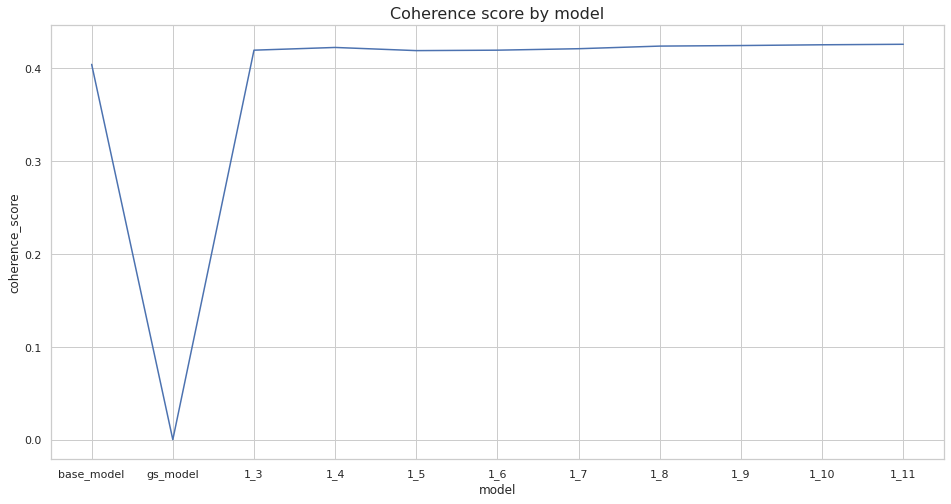

In [175]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 8))

sns.set_color_codes("pastel")
ax = sns.lineplot(data = minimum_probability_track_df, x="model", y="coherence_score")

ax.set_title("Coherence score by model", fontsize=16)

#ax.set_xticklabels(ax.get_xticklabels(), size = 10, rotation=40, ha="right")

#print(len(ax.patches))
#ax.set_box_aspect(5/len(ax.patches)) #change 10 to modify the y/x axis ratio

plt.show()

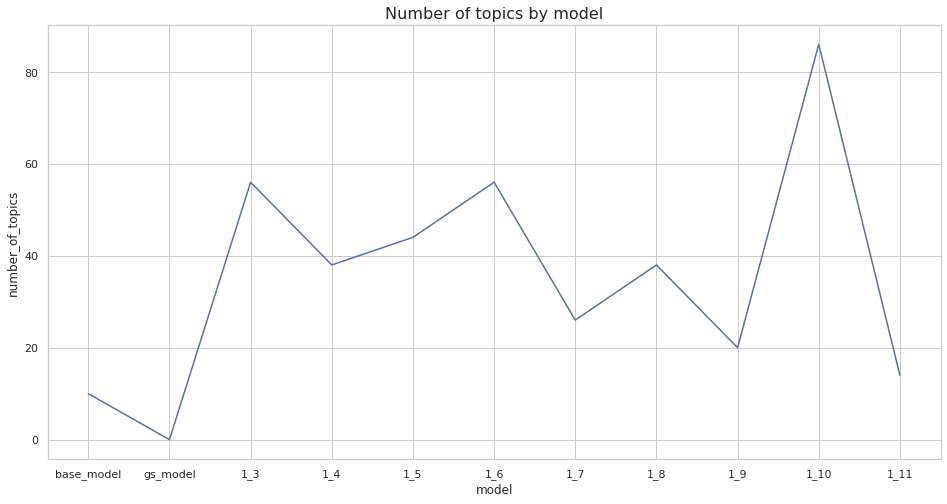

In [176]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 8))

sns.set_color_codes("pastel")
ax = sns.lineplot(data = minimum_probability_track_df, x="model", y="number_of_topics")

ax.set_title("Number of topics by model", fontsize=16)

#ax.set_xticklabels(ax.get_xticklabels(), size = 10, rotation=40, ha="right")

#print(len(ax.patches))
#ax.set_box_aspect(5/len(ax.patches)) #change 10 to modify the y/x axis ratio

plt.show()

In [177]:
#Visualizing our progress
minimum_probability_fig = px.line(minimum_probability_track_df, x="model", y="coherence_score", title='Model comparison',
                    hover_name='number_of_topics')
minimum_probability_fig.show()

<h3 style="background-color:powderblue;">Saving / exporting the chosen model</h3>

In [178]:
# Save the Model (1_7) to file in the current working directory

#Pkl_Filename = "models/Topic_mode_.pkl"

#with open(Pkl_Filename, 'wb') as file:
#    pickle.dump(df_model_1_9_iterables_num_top_sorted.topics.iloc[0], file)

In [179]:
#type(df_model_1_7_iterables_num_top_sorted.topics.iloc[0])

In [242]:
df_model_1_11_iterables_num_top_sorted.topics.iloc[0].save('models/topic.model')

INFO - 01:08:50: LdaState lifecycle event {'fname_or_handle': 'models/topic.model.state', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-02-07T01:08:50.644142', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'saving'}
INFO - 01:08:50: saved models/topic.model.state
INFO - 01:08:50: LdaMulticore lifecycle event {'fname_or_handle': 'models/topic.model', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['state', 'id2word', 'dispatcher'], 'datetime': '2022-02-07T01:08:50.653131', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'saving'}
INFO - 01:08:50: storing np array 'expElogbeta' to models/topic.model.expElogbeta.npy
INFO - 01:08:50: not storing attribute state

<h3 style="background-color:powderblue;">Loading / importing the chosen model</h3>

In [243]:
lda_model_loaded = LdaModel.load('models/topic.model')

INFO - 01:09:02: loading LdaModel object from models/topic.model
INFO - 01:09:02: loading expElogbeta from models/topic.model.expElogbeta.npy with mmap=None
INFO - 01:09:02: setting ignored attribute state to None
INFO - 01:09:02: setting ignored attribute id2word to None
INFO - 01:09:02: setting ignored attribute dispatcher to None
INFO - 01:09:02: LdaMulticore lifecycle event {'fname': 'models/topic.model', 'datetime': '2022-02-07T01:09:02.548445', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'loaded'}
INFO - 01:09:02: loading LdaState object from models/topic.model.state
INFO - 01:09:02: LdaState lifecycle event {'fname': 'models/topic.model.state', 'datetime': '2022-02-07T01:09:02.550980', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-gli

In [244]:
type(lda_model_loaded)

gensim.models.ldamulticore.LdaMulticore

<h3 style="background-color:powderblue;">Plotting the chosen Model</h3>

In [183]:
#lda_model_loaded_df = pd.DataFrame(lda_model_loaded,columns=['id','prob']).sort_values('prob',ascending=False)
#lda_model_loaded_df['topic'] = lda_model_loaded_df['id'].apply(lda_model_loaded_df.print_topic)
#lda_model_loaded_df

In [184]:
## This is just plotting the topics relevance

In [261]:
pyLDAvis.enable_notebook()
gensimvis_data = gensimvis.prepare(lda_model_loaded, corpus, id2word)
gensimvis_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.015726  0.018127       1        1  18.343372
10     0.219335 -0.005720       2        1  14.955774
1      0.006600  0.050766       3        1  14.128604
2     -0.080508  0.027100       4        1   8.954478
3      0.021995  0.021612       5        1   6.821723
6     -0.101641  0.119303       6        1   5.998988
8      0.110943  0.019294       7        1   4.924845
4     -0.150511 -0.116238       8        1   4.835679
7      0.112289 -0.007171       9        1   4.323115
12    -0.096223  0.072349      10        1   4.210844
5     -0.057312 -0.064001      11        1   3.767783
9     -0.045529 -0.099221      12        1   3.333829
11    -0.037944  0.005795      13        1   3.174716
13     0.114232 -0.041995      14        1   2.226251, topic_info=          Term        Freq       Total Category  logprob  loglift
8    education  740.000000  740.000000  Default  30.0000  30.0000
225   redfored  364.000000  364.000000  Default  29.0000  29.0000
222        ape  362.000000  362.000000  Default  28.0000  28.0000
226       tbat  361.000000  361.000000  Default  27.0000  27.0000
88        2021  316.000000  316.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
90      edtech    4.658331  394.449821  Topic14  -4.9274  -0.6340
366       week    3.352263  228.354107  Topic14  -5.2565  -0.4164
186  classroom    3.113977  140.509349  Topic14  -5.3302  -0.0045
198       free    3.049036  139.073242  Topic14  -5.3513  -0.0153
364       post    3.118794  244.547515  Topic14  -5.3286  -0.5571

[982 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
535      12  0.853250       #plague
556      12  0.853282  #shakespeare
1435      1  0.102983            --
1435      3  0.308949            --
1435      5  0.102983            --
...     ...       ...           ...
1842     11  0.889454            𝙞𝙣
1843     11  0.883265      𝙡𝙚𝙖𝙧𝙣𝙞𝙣𝙜
1844     11  0.889345            𝙤𝙛
1845     11  0.889506       𝙥𝙪𝙧𝙥𝙤𝙨𝙚
1846     11  0.889463         𝙨𝙚𝙣𝙨𝙚

[2658 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 11, 2, 3, 4, 7, 9, 5, 8, 13, 6, 10, 12, 14])

<h3 style="background-color:powderblue;">Testing the chosen Model</h3>

In [248]:
column_names_test = ["tweet_str_test"]
df_clean_test = pd.DataFrame(columns = column_names_test)

In [249]:
df_clean_test = df_clean_test.append({'tweet_str_test': 'Are We Teaching the Math Kids Need? Every child possesses vast mathematics potential, says Jo Boaler, Stanford University mathematics professor'}, ignore_index=True)

In [250]:
df_clean_test["processed_tweet_str_test"] = df_clean_test["tweet_str_test"].apply(cleaningTweets.get_token_list)

Removing_Twitter-Username: [Are, We, Teaching, the, Math, Kids, Need, ?, Every, child, possesses, vast, mathematics, potential, ,, says, Jo, Boaler, ,, Stanford, University, mathematics, professor]
Removing_Token-URL: [Are, We, Teaching, the, Math, Kids, Need, ?, Every, child, possesses, vast, mathematics, potential, ,, says, Jo, Boaler, ,, Stanford, University, mathematics, professor]
Removing_emoji: [Are, We, Teaching, the, Math, Kids, Need, ?, Every, child, possesses, vast, mathematics, potential, ,, says, Jo, Boaler, ,, Stanford, University, mathematics, professor]
Lemmatizing: ['be', 'we', 'teach', 'the', 'math', 'kids', 'need', '?', 'every', 'child', 'possess', 'vast', 'mathematic', 'potential', ',', 'say', 'jo', 'boaler', ',', 'stanford', 'university', 'mathematic', 'professor']
Stop-words: ['teach', 'math', 'kids', 'child', 'possess', 'vast', 'mathematic', 'potential', 'jo', 'boaler', 'stanford', 'university', 'mathematic', 'professor']


In [251]:
df_clean_test['processed_tweet_str_test_tokens'] = df_clean_test["processed_tweet_str_test"].apply(cleaningTweets.get_tokens)

In [252]:
df_clean_test

tweet_str_test  \
0  Are We Teaching the Math Kids Need? Every chil...   

                            processed_tweet_str_test  \
0  teach math kids child possess vast mathematic ...   

                     processed_tweet_str_test_tokens  
0  [teach, math, kids, child, possess, vast, math...

In [253]:
id2word_test = Dictionary(df_clean_test['processed_tweet_str_test_tokens'])
print(len(id2word_test))

INFO - 01:10:33: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 01:10:33: built Dictionary(13 unique tokens: ['boaler', 'child', 'jo', 'kids', 'math']...) from 1 documents (total 14 corpus positions)
INFO - 01:10:33: Dictionary lifecycle event {'msg': "built Dictionary(13 unique tokens: ['boaler', 'child', 'jo', 'kids', 'math']...) from 1 documents (total 14 corpus positions)", 'datetime': '2022-02-07T01:10:33.774654', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.13.0-28-generic-x86_64-with-glibc2.31', 'event': 'created'}


13


In [192]:
## Filtering Extremes
##id2word_test.filter_extremes(no_below=2, no_above=.99)
##print(len(id2word_test))

In [254]:
# Creating a corpus object 
corpus_test = [id2word_test.doc2bow(d) for d in df_clean_test['processed_tweet_str_test_tokens']]

In [255]:
#corpus_test

In [256]:
#corpus_test[0]

In [257]:
lda_model_test = lda_model_loaded[corpus_test[0]]
print(type(lda_model_test))
lda_model_test

<class 'list'>


[(0, 0.010726484), (2, 0.6952537), (5, 0.2495547)]

In [258]:
lda_model_loaded.print_topics()

INFO - 01:10:45: topic #0 (0.160): 0.029*"learn" + 0.020*"edchat" + 0.015*"edtech" + 0.015*"education" + 0.014*"school" + 0.013*"student" + 0.012*"k12" + 0.012*"learning" + 0.009*"literacy" + 0.008*"book"
INFO - 01:10:45: topic #1 (0.126): 0.030*"edchat" + 0.019*"edtech" + 0.019*"k12" + 0.018*"education" + 0.014*"classroom" + 0.012*"learn" + 0.012*"student" + 0.012*"math" + 0.011*"join" + 0.010*"edleadership"
INFO - 01:10:45: topic #2 (0.104): 0.013*"literacy" + 0.012*"free" + 0.010*"learn" + 0.009*"education" + 0.008*"math" + 0.008*"️" + 0.008*"check" + 0.008*"week" + 0.008*"book" + 0.008*"learning"
INFO - 01:10:45: topic #3 (0.089): 0.023*"learn" + 0.022*"education" + 0.018*"teacher" + 0.017*"edchat" + 0.015*"‍" + 0.013*"student" + 0.011*"k12" + 0.011*"science" + 0.009*"redfored" + 0.009*"tbat"
INFO - 01:10:45: topic #4 (0.077): 0.022*"student" + 0.017*"school" + 0.012*"learning" + 0.010*"session" + 0.008*"kid" + 0.008*"leadership" + 0.008*"teacher" + 0.006*"agree" + 0.006*"literacy"

[(0,
  '0.029*"learn" + 0.020*"edchat" + 0.015*"edtech" + 0.015*"education" + 0.014*"school" + 0.013*"student" + 0.012*"k12" + 0.012*"learning" + 0.009*"literacy" + 0.008*"book"'),
 (1,
  '0.030*"edchat" + 0.019*"edtech" + 0.019*"k12" + 0.018*"education" + 0.014*"classroom" + 0.012*"learn" + 0.012*"student" + 0.012*"math" + 0.011*"join" + 0.010*"edleadership"'),
 (2,
  '0.013*"literacy" + 0.012*"free" + 0.010*"learn" + 0.009*"education" + 0.008*"math" + 0.008*"️" + 0.008*"check" + 0.008*"week" + 0.008*"book" + 0.008*"learning"'),
 (3,
  '0.023*"learn" + 0.022*"education" + 0.018*"teacher" + 0.017*"edchat" + 0.015*"\u200d" + 0.013*"student" + 0.011*"k12" + 0.011*"science" + 0.009*"redfored" + 0.009*"tbat"'),
 (4,
  '0.022*"student" + 0.017*"school" + 0.012*"learning" + 0.010*"session" + 0.008*"kid" + 0.008*"leadership" + 0.008*"teacher" + 0.006*"agree" + 0.006*"literacy" + 0.006*"instruction"'),
 (5,
  '0.023*"day" + 0.018*"learn" + 0.016*"education" + 0.011*"educator" + 0.010*"student"

In [259]:
new = pd.DataFrame(lda_model_test,columns=['id','prob']).sort_values('prob',ascending=False)
new['topic'] = new['id'].apply(lda_model_loaded.print_topic)
new

id      prob                                              topic
1   2  0.695254  0.013*"literacy" + 0.012*"free" + 0.010*"learn...
2   5  0.249555  0.023*"day" + 0.018*"learn" + 0.016*"education...
0   0  0.010726  0.029*"learn" + 0.020*"edchat" + 0.015*"edtech...

In [260]:
new['topic']

1    0.013*"literacy" + 0.012*"free" + 0.010*"learn...
2    0.023*"day" + 0.018*"learn" + 0.016*"education...
0    0.029*"learn" + 0.020*"edchat" + 0.015*"edtech...
Name: topic, dtype: object

In [200]:
#lda_model_loaded

In [201]:
#corpus

In [202]:
#corpus_test

In [203]:
#id2word

In [204]:
#id2word_test

In [205]:
#base_model

In [206]:
#lda_model_loaded

In [207]:
#np.sum(lda_model_loaded.transform(docu_term_matrix),axis=1)

In [208]:
##Creating Topic Distance Visualization 
##gensimvis_data = gensimvis.prepare(lda_model_loaded, corpus_test, id2word_test)
##gensimvis_data

In [209]:
########################################################
#######Please overlook this following models############
########################################################

In [210]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [211]:
#How good our base model is
#The lower the perplexity, the better.
lda.perplexity(data_vectorized)

1539.373176990796

In [212]:
#The higher the log-likelihood, the better.
lda.score(data_vectorized)

-225487.44808190386

In [213]:
topic_word_matrix = lda.components_
pd.DataFrame(np.transpose(topic_word_matrix))

0         1         2         3         4         5          6  \
0     0.889010  0.100007  0.100016  0.100007  0.100009  0.100111   0.100005   
1     0.100008  0.100039  0.100186  0.100014  0.100011  0.100053  16.113997   
2     0.100277  0.100007  0.100006  3.145838  0.100008  0.100007   0.100306   
3     0.100007  0.100008  0.100007  0.100007  0.100416  1.020461   0.100007   
4     0.100099  0.100007  0.100007  0.100008  0.100007  0.100006   0.100306   
...        ...       ...       ...       ...       ...       ...        ...   
5293  0.100325  0.100007  0.100007  0.100008  0.100026  0.100008   0.100340   
5294  0.100394  0.100008  0.100006  0.100007  0.100027  0.100009   0.100244   
5295  0.100544  0.100007  0.100007  0.100007  0.100023  0.100008   0.100305   
5296  0.100333  0.100007  0.100008  0.100006  0.100030  0.100006   0.100476   
5297  0.100128  0.100007  0.100008  0.100009  0.100017  0.100007   0.100361   

             7         8         9  
0     0.100007  2.716587  0.100066  
1     0.100015  0.100007  0.100035  
2     0.100007  0.100615  0.100069  
3     0.100008  0.100007  0.100008  
4     0.100007  0.100196  2.170712  
...        ...       ...       ...  
5293  0.100314  2.807530  0.100061  
5294  0.100288  5.516075  0.100120  
5295  0.100135  2.807522  0.100062  
5296  0.100319  2.807375  0.100059  
5297  0.100310  2.807723  0.100055  

[5298 rows x 10 columns]

In [214]:
df_Tweets_mod["processed_tweet_str"]

0       worried fast finisher kid pace quickly station...
1       focus public education shift flexibility forgi...
2       10 evidence base teaching strategy learn edcha...
3       planning google docs slides sites student crea...
4       worried fast finisher kid pace quickly station...
                              ...                        
3405        question love edchat kidsdeserveit edutwitter
3406                                              ️ thank
3407                                appreciate share idea
3408                                   time favorite song
3409    plan lesson podcast historyteacher look engage ss
Name: processed_tweet_str, Length: 3410, dtype: object

In [215]:
#countVectorizer.vocabulary_.keys()

In [216]:
#CoherenceModel
#metric_coherence_gensim(measure='c_v', 
#                        top_n=NUM_TOPICS, 
#                        topic_word_distrib=topic_word_matrix, 
#                        dtm=countVectorizer, 
#                        vocab=np.array([x for x in countVectorizer.vocabulary_.keys()]), 
#                        texts=ls_doc_tokens
#                       )

In [217]:
#vocab=np.array([x for x in countVectorizer.vocabulary_.keys()])
#print(len(vocab))

In [218]:
#lda_comp = lda.components_
#print(len(lda_comp))

In [219]:
#data_lda

In [220]:
type(df_Tweets_mod["processed_tweet_str"])

pandas.core.series.Series

In [221]:
#cm = CoherenceModel(model=lda, corpus=data_vectorized, coherence='u_mass')
#coherence = cm.get_coherence()  # get coherence value
#print(coherence)

In [222]:
data_lda

array([[0.01111111, 0.01111205, 0.01111111, ..., 0.89999706, 0.01111111,
        0.01111158],
       [0.00909091, 0.00909091, 0.00909091, ..., 0.09999916, 0.00909091,
        0.00909091],
       [0.01      , 0.21000031, 0.01000258, ..., 0.01      , 0.01000453,
        0.01000575],
       ...,
       [0.025     , 0.02500867, 0.77499133, ..., 0.025     , 0.025     ,
        0.025     ],
       [0.27499774, 0.025     , 0.025     , ..., 0.025     , 0.025     ,
        0.025     ],
       [0.0125    , 0.0125    , 0.38749934, ..., 0.01250241, 0.01250085,
        0.2339041 ]])

In [223]:
type(data_lda)

numpy.ndarray

In [224]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS, init = "nndsvda")
data_nmf = nmf.fit_transform(data_vectorized)

In [225]:
data_nmf

array([[0.        , 0.        , 0.        , ..., 0.00215838, 0.00858212,
        0.        ],
       [0.08500429, 0.        , 0.00924283, ..., 0.01117863, 0.        ,
        0.00059777],
       [0.03219757, 0.1044489 , 0.        , ..., 0.        , 0.07260862,
        0.        ],
       ...,
       [0.        , 0.00035219, 0.        , ..., 0.02713294, 0.        ,
        0.00763738],
       [0.        , 0.00063918, 0.00335515, ..., 0.0064743 , 0.00357409,
        0.00604103],
       [0.        , 0.00518697, 0.00966459, ..., 0.02474287, 0.00475263,
        0.00815785]])

In [226]:
# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [227]:
#tuples_join =  '_'.join(['welcome', 'to', 'stack', 'overflow'])
#tuples_join
#print(type(tuples_join))

In [228]:
data_lsi.shape

(3410, 10)

In [229]:
text = cleaningTweets.get_token_list("AI can adapt to each student's level of knowledge, speed of learning and desired goals so they're getting the most out of their education. ... While no chatbot can truly replace an educator, AI tools can help students sharpen their skills and improve weak spots outside of the classroom.")
text

Removing_Twitter-Username: [AI, can, adapt, to, each, student, 's, level, of, knowledge, ,, speed, of, learning, and, desired, goals, so, they, 're, getting, the, most, out, of, their, education, ., ..., While, no, chatbot, can, truly, replace, an, educator, ,, AI, tools, can, help, students, sharpen, their, skills, and, improve, weak, spots, outside, of, the, classroom, .]
Removing_Token-URL: [AI, can, adapt, to, each, student, 's, level, of, knowledge, ,, speed, of, learning, and, desired, goals, so, they, 're, getting, the, most, out, of, their, education, ., ..., While, no, chatbot, can, truly, replace, an, educator, ,, AI, tools, can, help, students, sharpen, their, skills, and, improve, weak, spots, outside, of, the, classroom, .]
Removing_emoji: [AI, can, adapt, to, each, student, 's, level, of, knowledge, ,, speed, of, learning, and, desired, goals, so, they, 're, getting, the, most, out, of, their, education, ., ..., While, no, chatbot, can, truly, replace, an, educator, ,, AI

'ai adapt student level knowledge speed learn desire goal education chatbot truly replace educator ai tool help student sharpen skill improve weak spot outside classroom'

In [230]:
# Transforming an individual sentence
text = cleaningTweets.get_token_list("AI can adapt to each student's level of knowledge, speed of learning and desired goals so they're getting the most out of their education. ... While no chatbot can truly replace an educator, AI tools can help students sharpen their skills and improve weak spots outside of the classroom.")
print(lda.transform(vectorizer.transform([text]))[0])

Removing_Twitter-Username: [AI, can, adapt, to, each, student, 's, level, of, knowledge, ,, speed, of, learning, and, desired, goals, so, they, 're, getting, the, most, out, of, their, education, ., ..., While, no, chatbot, can, truly, replace, an, educator, ,, AI, tools, can, help, students, sharpen, their, skills, and, improve, weak, spots, outside, of, the, classroom, .]
Removing_Token-URL: [AI, can, adapt, to, each, student, 's, level, of, knowledge, ,, speed, of, learning, and, desired, goals, so, they, 're, getting, the, most, out, of, their, education, ., ..., While, no, chatbot, can, truly, replace, an, educator, ,, AI, tools, can, help, students, sharpen, their, skills, and, improve, weak, spots, outside, of, the, classroom, .]
Removing_emoji: [AI, can, adapt, to, each, student, 's, level, of, knowledge, ,, speed, of, learning, and, desired, goals, so, they, 're, getting, the, most, out, of, their, education, ., ..., While, no, chatbot, can, truly, replace, an, educator, ,, AI

In [231]:
lda.components_.shape

(10, 5298)

In [232]:
print("LDA Model:")
cleaningTweets.selected_topics(lda, vectorizer, top_n=10)

LDA Model:
Topic 0:
[('book', 99.43231351101913), ('curriculum', 58.50007129864933), ('story', 46.252049464276794), ('student', 40.47578678234365), ('classroom', 39.09349090227898), ('english', 38.46446719223326), ('blast', 37.20850372893271), ('project', 36.1136452016097), ('educational', 26.347065140783677), ('30', 25.783330885624164)]
Topic 1:
[('share', 72.88991302788828), ('change', 39.15150260176717), ('strategy', 37.11345772922722), ('edreform', 35.06995703882529), ('kid', 27.7404306751927), ('resources', 24.940778895239408), ('weekly', 21.30549664720534), ('thank', 18.172346826394477), ('report', 17.776570208316183), ('diigo', 16.929810551209137)]
Topic 2:
[('learning', 185.34324533070566), ('idea', 112.74923604134149), ('learn', 110.34698404764706), ('2022', 86.63813439242581), ('math', 84.78382561907912), ('mathchat', 83.40816422855536), ('python', 59.320957589976295), ('book', 58.491628064456464), ('edtech', 56.88048978389084), ('machine', 55.12270647505125)]
Topic 3:
[('stu

In [233]:
# Keywords for topics clustered by Latent Semantic Indexing
print("NMF Model:")
cleaningTweets.selected_topics(nmf,  vectorizer, top_n=10)

NMF Model:
Topic 0:
[('education', 5.072792370625765), ('redfored', 2.152685558955734), ('ape', 2.152685558955734), ('tbat', 2.1369891607389895), ('edchat', 2.098949003622342), ('banana', 2.091030088554663), ('headlines', 2.091030088554663), ('2021', 1.7118930690297445), ('k12', 1.4201995160166416), ('august', 1.380915705792008)]
Topic 1:
[('edtech', 3.2516239156968147), ('edchat', 3.0772387363774776), ('free', 1.8371824111145068), ('literacy', 1.6096223840985897), ('k12', 1.5906997555466076), ('edleadership', 1.577293896602371), ('engchat', 1.4296876129312037), ('download', 1.1532633384130182), ('paper', 0.4826571728146244), ('syllabus', 0.44241123461007537)]
Topic 2:
[('student', 6.006150686608829), ('help', 0.639300162457155), ('support', 0.4545790878846854), ('educator', 0.3392496454540894), ('love', 0.31353380664472824), ('create', 0.3055889480332894), ('teacher', 0.303244113786376), ('check', 0.29905945574321857), ('engage', 0.26294453392580885), ('resource', 0.25470405831035536)

In [234]:
# Keywords for topics clustered by Non-Negative Matrix Factorization
print("LSI Model:")
cleaningTweets.selected_topics(lsi, vectorizer, top_n=10)

LSI Model:
Topic 0:
[('education', 0.49726428913204285), ('edchat', 0.3549897864115082), ('k12', 0.29652708028242464), ('ape', 0.28673003169763966), ('redfored', 0.28673003169763966), ('tbat', 0.285760357779298), ('2021', 0.23317525226565058), ('learn', 0.2252339135558913), ('edtech', 0.17808187261631137), ('august', 0.15261684226958488)]
Topic 1:
[('learn', 0.49956895961471465), ('edtech', 0.3641925609058763), ('engchat', 0.22404965859326018), ('k12', 0.17305148653418684), ('edchat', 0.16041277476370538), ('free', 0.15838103834182607), ('student', 0.15700030675013266), ('literacy', 0.13745089878768152), ('post', 0.1315098196514436), ('week', 0.1307457702317896)]
Topic 2:
[('student', 0.6800047785219273), ('teacher', 0.23301998776052302), ('learning', 0.1859831572291288), ('education', 0.18140889715489236), ('school', 0.1656997919585244), ('math', 0.1408402960621484), ('help', 0.12251641856409504), ('banana', 0.11282348880809151), ('headlines', 0.11282348880809151), ('book', 0.11152667

In [235]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      32.420952   8.115230       1        1  18.912714
3       0.648955  71.707100       2        1  13.217379
9      71.019684   9.971006       3        1  12.632355
2       3.785981  33.185135       4        1  11.711528
7     -42.666500  -9.222070       5        1  10.271565
0      -3.621689 -43.526516       6        1   7.532509
5      -3.632402  -4.171708       7        1   7.139533
8     -36.584400  35.804413       8        1   6.830256
6      44.391380  50.615383       9        1   6.110363
1      40.235809 -31.591665      10        1   5.641799, topic_info=           Term        Freq       Total Category  logprob  loglift
1599  education  627.000000  627.000000  Default  30.0000  30.0000
1561     edchat  591.000000  591.000000  Default  29.0000  29.0000
2677        k12  441.000000  441.000000  Default  28.0000  28.0000
3938   redfored  281.000000  281.000000  Default  27.0000  27.0000
366         ape  281.000000  281.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
797      career    6.834841    8.546152  Topic10  -5.5358   2.6515
4770      thank   14.664647   76.157997  Topic10  -4.7724   1.2276
2310       help   13.069684  107.678414  Topic10  -4.8875   0.7661
4170     school   13.025500  199.164264  Topic10  -4.8909   0.1477
250      advice    6.582686    8.369999  Topic10  -5.5734   2.6348

[433 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         9  0.957070      000
5         1  0.238901       10
5         4  0.740593       10
21        6  0.905198       13
34        3  0.959347       19
...     ...       ...      ...
5220      4  0.101011     word
5222      5  0.964332   wordle
5236      8  0.986876    world
5246      2  0.977581    write
5249      2  0.960461  writing

[473 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 10, 3, 8, 1, 6, 9, 7, 2])